# LFQA: Pretrained Models

In this notebook, we build a LFQA pipeline using ELI5 pretrained retriever (i.e., using contrastive training) and and the ELI5 pretrained BART seq2seq model.

Corresponding model checkpoints at huggingface🤗:
* Retriever model: `yjernite/retribert-base-uncased`
* seq2seq Generator model: `yjernite/bart_eli5`


## Workflow
</br>
<div class="alert alert-block alert-info">
    
The following steps are followed in building the LFQA model using pretrained retriever and generator models.
1. <b>Create a document index for the entire corpus.</b>
    * Determine context lengths suitable for the retriever model
    * Slice the contexts to appropriate lengths
    * Tokenize the text using the pretrained tokenizer
    * Embed (using pretrained retriever model) and store (using FAISS indexing)

2. <b>Load Pretrained seq2seq model</b>
3. <b>Build inference inputs according to seq2seq model specifications</b>
    * Embed the question
    * Maximum inner product search (FAISS)
    * Concatenate question and contexts
    * Generate answer
    
4. <b>Build User Interface for question answering</b>
    </div>

### Dependencies

Code are implemented in a `pytorch` environment. For jojie with a GPU set up torch by:

`conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch`

Then install the other dependencies:
> `conda install -c faiss-gpu`
> `pip install ipykernel ipywidgets` </br>
> `pip install elasticsearch`</br>
> `pip install faiss_gpu`</br>
> `pip install nlp`</br>
> `pip install transformers`</br>
> `wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.7.1-linux-x86_64.tar.gz`</br>
> `tar -xzvf elasticsearch-7.7.1-linux-x86_64.tar.gz`</br>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
retriever_checkpoint = "yjernite/retribert-base-uncased"
generator_checkpoint = "yjernite/bart_eli5"

In [3]:
%load_ext autoreload

In [4]:
import nlp
import datasets
import os
import json
from tqdm import tqdm
from glob import glob

%autoreload 2
from lfqa_utils import *

## Load Passages Data

In [5]:
# read snippets
source_dir = '../data/contexts/magazines'
files = glob(os.path.join(source_dir, '*.json'))

magazines_snippets = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/1796 [00:00<?, ?it/s]

Using custom data configuration default-b19f1762f58292c2
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-b19f1762f58292c2/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
magazines_snippets

DatasetDict({
    train: Dataset({
        features: ['article_title', 'section_title', 'start_paragraph', 'end_paragraph', 'start_character', 'end_character', 'passage_text', 'kicker', 'page', 'index', 'context_id'],
        num_rows: 1796
    })
})

In [7]:
magazines_snippets['train'][0]

{'article_title': 'My Battle with Pornography',
 'section_title': '',
 'start_paragraph': 2,
 'end_paragraph': 3,
 'start_character': 997,
 'end_character': 1522,
 'passage_text': 'myself that it was natural and ignored any counsel from the Church that told me otherwise. I didn’t realize it at first, but I had become addicted to pornography. The way I looked at girls started to change, and I was ashamed of the thoughts I had. At a youth conference my stake president spoke to us about how looking at pornography makes young men unworthy to exercise the priesthood. His talk convinced me that I needed to stop. At first I thought I could do it on my own. I didn’t want to tell the bishop because I didn’t',
 'kicker': 'No matter how hard I tried to break free from my addiction, I kept losing the battle. I finally learned I couldn’t do it on my own.',
 'page': 26,
 'index': 256,
 'context_id': '26-256-2-997-6ywi'}

In [8]:
# read snippets
source_dir = '../data/contexts/general-conference'
files = glob(os.path.join(source_dir, '*.json'))

gc_snippets = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/187 [00:00<?, ?it/s]

Using custom data configuration default-460b88f4f7d1637b
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-460b88f4f7d1637b/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
wiki40b_snippets = datasets.load_dataset('wiki_snippets', name='wiki40b_en_100_0')['train']

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522M [00:00<?, ?B/s]

Dataset wiki40b downloaded and prepared to /home/mdorosan/.cache/huggingface/datasets/wiki40b/en/1.1.0/d15702fbf830e65fd775c50946364ff0c02fd3089b31887fabf97c2dad970760. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/17553713 [00:00<?, ? examples/s]

Dataset wiki_snippets downloaded and prepared to /home/mdorosan/.cache/huggingface/datasets/wiki_snippets/wiki40b_en_100_0/1.0.0/abd9d391450b2f5fd0f943e9c51404eba6d86ee04d07d202b8a311cbcc72e020. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## Load Retriever Tokenizer and Model

In [10]:
from transformers import AutoTokenizer, AutoModel

# use retriever model for both tokenizer and model
retriever_tokenizer = AutoTokenizer.from_pretrained(retriever_checkpoint)
retriever_model = AutoModel.from_pretrained(retriever_checkpoint).to('cuda:0')

_ = retriever_model.eval()

Some weights of RetriBertModel were not initialized from the model checkpoint at yjernite/retribert-base-uncased and are newly initialized: ['bert_query.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the next section we create embeddings per batch store it in a numpy memory map. It is done by first building the memory map, and then updating the values by bactch with the representations obtained.

## Embedding contexts

In [11]:
# inspect a sample memory map
passage_dataset = magazines_snippets['train']
max_length = 128
dtype = "float32"

fp = np.memmap("context-index/test-index.dat", dtype=dtype, mode="w+", shape=(passage_dataset.num_rows, max_length))
type(fp)

numpy.memmap

The rest of the by-batch generation of embeddings, is facilitated by the `make_qa_dense_index` and within it the `embed_questions_for_retrieval` which runs simply runs the batch encoding by the tokenizer and the embedding using the `retreiver_checkpoint` model. See below for the embedding step:

```
def embed_passages_for_retrieval(passages, tokenizer, qa_embedder, max_length=128, device="cuda:0"):
    a_toks = tokenizer.batch_encode_plus(passages, max_length=max_length, pad_to_max_length=True)
    a_ids, a_mask = (
        torch.LongTensor(a_toks["input_ids"]).to(device),
        torch.LongTensor(a_toks["attention_mask"]).to(device),
    )
    with torch.no_grad():
        a_reps = qa_embedder.embed_answers(a_ids, a_mask).cpu().type(torch.float)
    return a_reps.numpy()
```

In [12]:
# 8 hours 9 mins, nvidia gtx 2080
index_name = "context-index/wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat"
if not os.path.isfile(index_name): # avoids writing over the index
    make_qa_dense_index(
        retriever_model, retriever_tokenizer, wiki40b_snippets, device='cuda:0',
        index_name=index_name
    )

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Batch: 0, Elapsed: 0.789283275604248 seconds
Batch: 1, Elapsed: 1.199902057647705 seconds
Batch: 2, Elapsed: 1.625427007675171 seconds
Batch: 3, Elapsed: 2.0342721939086914 seconds
Batch: 4, Elapsed: 2.4579930305480957 seconds
Batch: 5, Elapsed: 2.868752956390381 seconds
Batch: 6, Elapsed: 3.283841848373413 seconds
Batch: 7, Elapsed: 3.692702293395996 seconds
Batch: 8, Elapsed: 4.10450005531311 seconds
Batch: 9, Elapsed: 4.516056299209595 seconds
Batch: 10, Elapsed: 4.929081678390503 seconds
Batch: 11, Elapsed: 5.339823484420776 seconds
Batch: 12, Elapsed: 5.752353668212891 seconds
Batch: 13, Elapsed: 6.164618730545044 seconds
Batch: 14, Elapsed: 6.575921058654785 seconds
Batch: 15, Elapsed: 6.98734188079834 seconds
Batch: 16, Elapsed: 7.400197982788086 seconds
Batch: 17, Elapsed: 7.814305543899536 seconds
Batch: 18, Elapsed: 8.22831416130066 seconds
Batch: 19, Elapsed: 8.643010377883911 seconds
Batch: 20, Elapsed: 9.059404373168945 seconds
Batch: 21, Elapsed: 9.480073690414429 seconds

Batch: 176, Elapsed: 75.16286897659302 seconds
Batch: 177, Elapsed: 75.58838415145874 seconds
Batch: 178, Elapsed: 76.01332116127014 seconds
Batch: 179, Elapsed: 76.43499684333801 seconds
Batch: 180, Elapsed: 76.86125946044922 seconds
Batch: 181, Elapsed: 77.28765153884888 seconds
Batch: 182, Elapsed: 77.71418285369873 seconds
Batch: 183, Elapsed: 78.13505673408508 seconds
Batch: 184, Elapsed: 78.55638241767883 seconds
Batch: 185, Elapsed: 78.97847509384155 seconds
Batch: 186, Elapsed: 79.40314817428589 seconds
Batch: 187, Elapsed: 79.82697463035583 seconds
Batch: 188, Elapsed: 80.24944519996643 seconds
Batch: 189, Elapsed: 80.67356705665588 seconds
Batch: 190, Elapsed: 81.09638237953186 seconds
Batch: 191, Elapsed: 81.5179967880249 seconds
Batch: 192, Elapsed: 81.94021391868591 seconds
Batch: 193, Elapsed: 82.36222410202026 seconds
Batch: 194, Elapsed: 82.78460788726807 seconds
Batch: 195, Elapsed: 83.37375664710999 seconds
Batch: 196, Elapsed: 83.79480814933777 seconds
Batch: 197, El

Batch: 349, Elapsed: 148.86647129058838 seconds
Batch: 350, Elapsed: 149.293066740036 seconds
Batch: 351, Elapsed: 150.26499128341675 seconds
Batch: 352, Elapsed: 150.68836498260498 seconds
Batch: 353, Elapsed: 151.10933685302734 seconds
Batch: 354, Elapsed: 151.53520894050598 seconds
Batch: 355, Elapsed: 151.96116518974304 seconds
Batch: 356, Elapsed: 152.3924276828766 seconds
Batch: 357, Elapsed: 152.811692237854 seconds
Batch: 358, Elapsed: 153.23284220695496 seconds
Batch: 359, Elapsed: 153.6553201675415 seconds
Batch: 360, Elapsed: 154.07520937919617 seconds
Batch: 361, Elapsed: 154.49574494361877 seconds
Batch: 362, Elapsed: 154.92153406143188 seconds
Batch: 363, Elapsed: 155.34264206886292 seconds
Batch: 364, Elapsed: 155.7649257183075 seconds
Batch: 365, Elapsed: 156.18718600273132 seconds
Batch: 366, Elapsed: 156.60970211029053 seconds
Batch: 367, Elapsed: 157.0345344543457 seconds
Batch: 368, Elapsed: 157.456196308136 seconds
Batch: 369, Elapsed: 157.88071060180664 seconds
Ba

Batch: 521, Elapsed: 229.9379322528839 seconds
Batch: 522, Elapsed: 230.36134457588196 seconds
Batch: 523, Elapsed: 230.78133344650269 seconds
Batch: 524, Elapsed: 231.20060205459595 seconds
Batch: 525, Elapsed: 231.6246132850647 seconds
Batch: 526, Elapsed: 232.04455184936523 seconds
Batch: 527, Elapsed: 232.46676754951477 seconds
Batch: 528, Elapsed: 232.89109015464783 seconds
Batch: 529, Elapsed: 233.316748380661 seconds
Batch: 530, Elapsed: 233.73847699165344 seconds
Batch: 531, Elapsed: 234.16342949867249 seconds
Batch: 532, Elapsed: 234.58828926086426 seconds
Batch: 533, Elapsed: 235.01356053352356 seconds
Batch: 534, Elapsed: 235.43349027633667 seconds
Batch: 535, Elapsed: 235.85370707511902 seconds
Batch: 536, Elapsed: 236.27525925636292 seconds
Batch: 537, Elapsed: 236.69957613945007 seconds
Batch: 538, Elapsed: 237.12461924552917 seconds
Batch: 539, Elapsed: 237.54516506195068 seconds
Batch: 540, Elapsed: 237.9664216041565 seconds
Batch: 541, Elapsed: 238.38975763320923 secon

Batch: 694, Elapsed: 303.7915506362915 seconds
Batch: 695, Elapsed: 304.21276926994324 seconds
Batch: 696, Elapsed: 304.6322076320648 seconds
Batch: 697, Elapsed: 305.05597949028015 seconds
Batch: 698, Elapsed: 305.4756033420563 seconds
Batch: 699, Elapsed: 305.8966774940491 seconds
Batch: 700, Elapsed: 306.3173213005066 seconds
Batch: 701, Elapsed: 306.73853373527527 seconds
Batch: 702, Elapsed: 307.16172552108765 seconds
Batch: 703, Elapsed: 307.594601392746 seconds
Batch: 704, Elapsed: 308.0171477794647 seconds
Batch: 705, Elapsed: 308.43803572654724 seconds
Batch: 706, Elapsed: 308.85938835144043 seconds
Batch: 707, Elapsed: 309.2818350791931 seconds
Batch: 708, Elapsed: 309.7027475833893 seconds
Batch: 709, Elapsed: 310.12683296203613 seconds
Batch: 710, Elapsed: 310.5490906238556 seconds
Batch: 711, Elapsed: 310.97137665748596 seconds
Batch: 712, Elapsed: 311.3992929458618 seconds
Batch: 713, Elapsed: 311.82248616218567 seconds
Batch: 714, Elapsed: 312.24450969696045 seconds
Batc

Batch: 868, Elapsed: 378.0499515533447 seconds
Batch: 869, Elapsed: 378.4699800014496 seconds
Batch: 870, Elapsed: 378.89647221565247 seconds
Batch: 871, Elapsed: 379.32027220726013 seconds
Batch: 872, Elapsed: 379.7439181804657 seconds
Batch: 873, Elapsed: 380.1665053367615 seconds
Batch: 874, Elapsed: 380.591025352478 seconds
Batch: 875, Elapsed: 381.0150032043457 seconds
Batch: 876, Elapsed: 381.44001150131226 seconds
Batch: 877, Elapsed: 381.8651418685913 seconds
Batch: 878, Elapsed: 382.2876441478729 seconds
Batch: 879, Elapsed: 382.7114851474762 seconds
Batch: 880, Elapsed: 383.1334264278412 seconds
Batch: 881, Elapsed: 383.55812668800354 seconds
Batch: 882, Elapsed: 383.9816048145294 seconds
Batch: 883, Elapsed: 384.4113733768463 seconds
Batch: 884, Elapsed: 384.8357083797455 seconds
Batch: 885, Elapsed: 385.25834012031555 seconds
Batch: 886, Elapsed: 385.68110060691833 seconds
Batch: 887, Elapsed: 386.1055841445923 seconds
Batch: 888, Elapsed: 386.5317451953888 seconds
Batch: 8

Batch: 1040, Elapsed: 462.10775423049927 seconds
Batch: 1041, Elapsed: 462.5298626422882 seconds
Batch: 1042, Elapsed: 462.9505784511566 seconds
Batch: 1043, Elapsed: 463.3768470287323 seconds
Batch: 1044, Elapsed: 463.8008749485016 seconds
Batch: 1045, Elapsed: 464.22358226776123 seconds
Batch: 1046, Elapsed: 464.64373683929443 seconds
Batch: 1047, Elapsed: 465.0676124095917 seconds
Batch: 1048, Elapsed: 465.4897265434265 seconds
Batch: 1049, Elapsed: 465.9124946594238 seconds
Batch: 1050, Elapsed: 466.34206199645996 seconds
Batch: 1051, Elapsed: 466.76658868789673 seconds
Batch: 1052, Elapsed: 467.1914999485016 seconds
Batch: 1053, Elapsed: 467.6118714809418 seconds
Batch: 1054, Elapsed: 468.03518414497375 seconds
Batch: 1055, Elapsed: 468.45667028427124 seconds
Batch: 1056, Elapsed: 468.8771479129791 seconds
Batch: 1057, Elapsed: 469.2985861301422 seconds
Batch: 1058, Elapsed: 469.72128033638 seconds
Batch: 1059, Elapsed: 470.14396500587463 seconds
Batch: 1060, Elapsed: 470.56644010

Batch: 1211, Elapsed: 541.8072028160095 seconds
Batch: 1212, Elapsed: 542.2321581840515 seconds
Batch: 1213, Elapsed: 542.6572511196136 seconds
Batch: 1214, Elapsed: 543.0777497291565 seconds
Batch: 1215, Elapsed: 543.50599360466 seconds
Batch: 1216, Elapsed: 543.989622592926 seconds
Batch: 1217, Elapsed: 544.4099636077881 seconds
Batch: 1218, Elapsed: 544.8321304321289 seconds
Batch: 1219, Elapsed: 545.2537996768951 seconds
Batch: 1220, Elapsed: 545.6786587238312 seconds
Batch: 1221, Elapsed: 546.1022834777832 seconds
Batch: 1222, Elapsed: 546.5256180763245 seconds
Batch: 1223, Elapsed: 546.9499905109406 seconds
Batch: 1224, Elapsed: 547.3720242977142 seconds
Batch: 1225, Elapsed: 547.793112039566 seconds
Batch: 1226, Elapsed: 548.2179572582245 seconds
Batch: 1227, Elapsed: 548.6409153938293 seconds
Batch: 1228, Elapsed: 549.0613539218903 seconds
Batch: 1229, Elapsed: 549.4829761981964 seconds
Batch: 1230, Elapsed: 549.9058954715729 seconds
Batch: 1231, Elapsed: 550.3289921283722 seco

Batch: 1383, Elapsed: 617.3889598846436 seconds
Batch: 1384, Elapsed: 617.811320066452 seconds
Batch: 1385, Elapsed: 618.2313673496246 seconds
Batch: 1386, Elapsed: 618.6557259559631 seconds
Batch: 1387, Elapsed: 619.0818147659302 seconds
Batch: 1388, Elapsed: 619.5048851966858 seconds
Batch: 1389, Elapsed: 619.9273598194122 seconds
Batch: 1390, Elapsed: 620.3461720943451 seconds
Batch: 1391, Elapsed: 620.7705490589142 seconds
Batch: 1392, Elapsed: 621.1932458877563 seconds
Batch: 1393, Elapsed: 621.6141088008881 seconds
Batch: 1394, Elapsed: 622.0351297855377 seconds
Batch: 1395, Elapsed: 622.4575915336609 seconds
Batch: 1396, Elapsed: 622.8809139728546 seconds
Batch: 1397, Elapsed: 623.3022615909576 seconds
Batch: 1398, Elapsed: 623.7256419658661 seconds
Batch: 1399, Elapsed: 624.1504623889923 seconds
Batch: 1400, Elapsed: 624.5836896896362 seconds
Batch: 1401, Elapsed: 625.0066151618958 seconds
Batch: 1402, Elapsed: 625.4293339252472 seconds
Batch: 1403, Elapsed: 625.8493721485138 s

Batch: 1554, Elapsed: 690.7416815757751 seconds
Batch: 1555, Elapsed: 691.1634798049927 seconds
Batch: 1556, Elapsed: 691.5872685909271 seconds
Batch: 1557, Elapsed: 692.0083930492401 seconds
Batch: 1558, Elapsed: 692.4311120510101 seconds
Batch: 1559, Elapsed: 692.8542900085449 seconds
Batch: 1560, Elapsed: 693.2756056785583 seconds
Batch: 1561, Elapsed: 693.695864200592 seconds
Batch: 1562, Elapsed: 694.1216611862183 seconds
Batch: 1563, Elapsed: 694.546391248703 seconds
Batch: 1564, Elapsed: 694.9675109386444 seconds
Batch: 1565, Elapsed: 695.3963742256165 seconds
Batch: 1566, Elapsed: 695.8208034038544 seconds
Batch: 1567, Elapsed: 696.2466785907745 seconds
Batch: 1568, Elapsed: 696.6725969314575 seconds
Batch: 1569, Elapsed: 697.1016616821289 seconds
Batch: 1570, Elapsed: 697.5260326862335 seconds
Batch: 1571, Elapsed: 697.950989484787 seconds
Batch: 1572, Elapsed: 698.3760898113251 seconds
Batch: 1573, Elapsed: 698.7987852096558 seconds
Batch: 1574, Elapsed: 699.2172689437866 sec

Batch: 1726, Elapsed: 763.7339599132538 seconds
Batch: 1727, Elapsed: 764.1542785167694 seconds
Batch: 1728, Elapsed: 764.582745552063 seconds
Batch: 1729, Elapsed: 765.0057015419006 seconds
Batch: 1730, Elapsed: 765.4270477294922 seconds
Batch: 1731, Elapsed: 765.8514897823334 seconds
Batch: 1732, Elapsed: 766.2757768630981 seconds
Batch: 1733, Elapsed: 766.7031464576721 seconds
Batch: 1734, Elapsed: 767.1238703727722 seconds
Batch: 1735, Elapsed: 767.5476942062378 seconds
Batch: 1736, Elapsed: 767.9699685573578 seconds
Batch: 1737, Elapsed: 768.3946137428284 seconds
Batch: 1738, Elapsed: 768.8164811134338 seconds
Batch: 1739, Elapsed: 769.2404205799103 seconds
Batch: 1740, Elapsed: 769.6645946502686 seconds
Batch: 1741, Elapsed: 770.0887024402618 seconds
Batch: 1742, Elapsed: 770.5150227546692 seconds
Batch: 1743, Elapsed: 770.943895816803 seconds
Batch: 1744, Elapsed: 771.3667702674866 seconds
Batch: 1745, Elapsed: 771.7923047542572 seconds
Batch: 1746, Elapsed: 772.2139344215393 se

Batch: 1898, Elapsed: 836.8824510574341 seconds
Batch: 1899, Elapsed: 837.3034329414368 seconds
Batch: 1900, Elapsed: 837.7254619598389 seconds
Batch: 1901, Elapsed: 838.1505875587463 seconds
Batch: 1902, Elapsed: 838.5734255313873 seconds
Batch: 1903, Elapsed: 838.9976427555084 seconds
Batch: 1904, Elapsed: 839.4190244674683 seconds
Batch: 1905, Elapsed: 839.8445534706116 seconds
Batch: 1906, Elapsed: 840.2669453620911 seconds
Batch: 1907, Elapsed: 840.6902463436127 seconds
Batch: 1908, Elapsed: 841.1139802932739 seconds
Batch: 1909, Elapsed: 841.5398900508881 seconds
Batch: 1910, Elapsed: 841.9683718681335 seconds
Batch: 1911, Elapsed: 842.3993382453918 seconds
Batch: 1912, Elapsed: 842.826162815094 seconds
Batch: 1913, Elapsed: 843.2480897903442 seconds
Batch: 1914, Elapsed: 844.2616403102875 seconds
Batch: 1915, Elapsed: 844.683363199234 seconds
Batch: 1916, Elapsed: 845.1097431182861 seconds
Batch: 1917, Elapsed: 845.5369427204132 seconds
Batch: 1918, Elapsed: 845.9600827693939 se

Batch: 2070, Elapsed: 910.341255903244 seconds
Batch: 2071, Elapsed: 910.765335559845 seconds
Batch: 2072, Elapsed: 911.1874823570251 seconds
Batch: 2073, Elapsed: 911.6077156066895 seconds
Batch: 2074, Elapsed: 912.0300414562225 seconds
Batch: 2075, Elapsed: 912.4511651992798 seconds
Batch: 2076, Elapsed: 912.8762495517731 seconds
Batch: 2077, Elapsed: 913.2980737686157 seconds
Batch: 2078, Elapsed: 913.7209479808807 seconds
Batch: 2079, Elapsed: 914.1421959400177 seconds
Batch: 2080, Elapsed: 914.5649025440216 seconds
Batch: 2081, Elapsed: 914.9888815879822 seconds
Batch: 2082, Elapsed: 915.4116053581238 seconds
Batch: 2083, Elapsed: 915.8355748653412 seconds
Batch: 2084, Elapsed: 916.2602391242981 seconds
Batch: 2085, Elapsed: 916.6859011650085 seconds
Batch: 2086, Elapsed: 917.1086320877075 seconds
Batch: 2087, Elapsed: 917.5310971736908 seconds
Batch: 2088, Elapsed: 917.9554131031036 seconds
Batch: 2089, Elapsed: 918.3848326206207 seconds
Batch: 2090, Elapsed: 918.8073523044586 se

Batch: 2241, Elapsed: 982.8267583847046 seconds
Batch: 2242, Elapsed: 983.2535095214844 seconds
Batch: 2243, Elapsed: 983.6785197257996 seconds
Batch: 2244, Elapsed: 984.0994896888733 seconds
Batch: 2245, Elapsed: 984.5211973190308 seconds
Batch: 2246, Elapsed: 984.9418897628784 seconds
Batch: 2247, Elapsed: 985.3618431091309 seconds
Batch: 2248, Elapsed: 985.7841131687164 seconds
Batch: 2249, Elapsed: 986.2055974006653 seconds
Batch: 2250, Elapsed: 986.627697467804 seconds
Batch: 2251, Elapsed: 987.0502195358276 seconds
Batch: 2252, Elapsed: 987.4727635383606 seconds
Batch: 2253, Elapsed: 987.8951048851013 seconds
Batch: 2254, Elapsed: 988.3177654743195 seconds
Batch: 2255, Elapsed: 988.7396996021271 seconds
Batch: 2256, Elapsed: 989.2642269134521 seconds
Batch: 2257, Elapsed: 989.6865346431732 seconds
Batch: 2258, Elapsed: 990.1103286743164 seconds
Batch: 2259, Elapsed: 990.5320076942444 seconds
Batch: 2260, Elapsed: 990.9549164772034 seconds
Batch: 2261, Elapsed: 991.3821947574615 s

Batch: 2410, Elapsed: 1054.572289466858 seconds
Batch: 2411, Elapsed: 1055.000257730484 seconds
Batch: 2412, Elapsed: 1055.4243381023407 seconds
Batch: 2413, Elapsed: 1055.8462154865265 seconds
Batch: 2414, Elapsed: 1056.2684230804443 seconds
Batch: 2415, Elapsed: 1056.6911675930023 seconds
Batch: 2416, Elapsed: 1057.1106996536255 seconds
Batch: 2417, Elapsed: 1057.5312752723694 seconds
Batch: 2418, Elapsed: 1057.9496335983276 seconds
Batch: 2419, Elapsed: 1058.3753516674042 seconds
Batch: 2420, Elapsed: 1058.7969658374786 seconds
Batch: 2421, Elapsed: 1059.2223649024963 seconds
Batch: 2422, Elapsed: 1059.6448969841003 seconds
Batch: 2423, Elapsed: 1060.0665307044983 seconds
Batch: 2424, Elapsed: 1060.4903845787048 seconds
Batch: 2425, Elapsed: 1060.91277551651 seconds
Batch: 2426, Elapsed: 1061.3366539478302 seconds
Batch: 2427, Elapsed: 1061.7646350860596 seconds
Batch: 2428, Elapsed: 1062.1909279823303 seconds
Batch: 2429, Elapsed: 1062.612868309021 seconds
Batch: 2430, Elapsed: 106

Batch: 2578, Elapsed: 1126.0976839065552 seconds
Batch: 2579, Elapsed: 1126.530238866806 seconds
Batch: 2580, Elapsed: 1126.9517509937286 seconds
Batch: 2581, Elapsed: 1127.3794074058533 seconds
Batch: 2582, Elapsed: 1127.8011872768402 seconds
Batch: 2583, Elapsed: 1128.2231578826904 seconds
Batch: 2584, Elapsed: 1128.6464812755585 seconds
Batch: 2585, Elapsed: 1129.0687458515167 seconds
Batch: 2586, Elapsed: 1129.4931075572968 seconds
Batch: 2587, Elapsed: 1129.9160754680634 seconds
Batch: 2588, Elapsed: 1130.3405964374542 seconds
Batch: 2589, Elapsed: 1130.7635941505432 seconds
Batch: 2590, Elapsed: 1131.1884875297546 seconds
Batch: 2591, Elapsed: 1131.607985496521 seconds
Batch: 2592, Elapsed: 1132.0386719703674 seconds
Batch: 2593, Elapsed: 1132.4620406627655 seconds
Batch: 2594, Elapsed: 1132.8842532634735 seconds
Batch: 2595, Elapsed: 1133.308440208435 seconds
Batch: 2596, Elapsed: 1133.729089975357 seconds
Batch: 2597, Elapsed: 1134.1494460105896 seconds
Batch: 2598, Elapsed: 11

Batch: 2747, Elapsed: 1197.7568805217743 seconds
Batch: 2748, Elapsed: 1198.1851379871368 seconds
Batch: 2749, Elapsed: 1198.6118614673615 seconds
Batch: 2750, Elapsed: 1199.0397658348083 seconds
Batch: 2751, Elapsed: 1199.4651362895966 seconds
Batch: 2752, Elapsed: 1199.8911406993866 seconds
Batch: 2753, Elapsed: 1200.3132817745209 seconds
Batch: 2754, Elapsed: 1200.734223127365 seconds
Batch: 2755, Elapsed: 1201.161078453064 seconds
Batch: 2756, Elapsed: 1201.5827767848969 seconds
Batch: 2757, Elapsed: 1202.004126548767 seconds
Batch: 2758, Elapsed: 1202.4274787902832 seconds
Batch: 2759, Elapsed: 1202.854237794876 seconds
Batch: 2760, Elapsed: 1203.2804293632507 seconds
Batch: 2761, Elapsed: 1203.702471256256 seconds
Batch: 2762, Elapsed: 1204.1242113113403 seconds
Batch: 2763, Elapsed: 1204.547837972641 seconds
Batch: 2764, Elapsed: 1204.9708425998688 seconds
Batch: 2765, Elapsed: 1205.3970963954926 seconds
Batch: 2766, Elapsed: 1205.8183891773224 seconds
Batch: 2767, Elapsed: 1206

Batch: 2915, Elapsed: 1269.0087313652039 seconds
Batch: 2916, Elapsed: 1269.4299528598785 seconds
Batch: 2917, Elapsed: 1269.853313446045 seconds
Batch: 2918, Elapsed: 1270.2728934288025 seconds
Batch: 2919, Elapsed: 1270.695630788803 seconds
Batch: 2920, Elapsed: 1271.1184949874878 seconds
Batch: 2921, Elapsed: 1271.54310464859 seconds
Batch: 2922, Elapsed: 1271.9711933135986 seconds
Batch: 2923, Elapsed: 1272.4036593437195 seconds
Batch: 2924, Elapsed: 1272.8279128074646 seconds
Batch: 2925, Elapsed: 1273.2490482330322 seconds
Batch: 2926, Elapsed: 1273.6701939105988 seconds
Batch: 2927, Elapsed: 1274.0903832912445 seconds
Batch: 2928, Elapsed: 1274.5150883197784 seconds
Batch: 2929, Elapsed: 1274.9417207241058 seconds
Batch: 2930, Elapsed: 1275.361192703247 seconds
Batch: 2931, Elapsed: 1275.7835583686829 seconds
Batch: 2932, Elapsed: 1276.205717086792 seconds
Batch: 2933, Elapsed: 1276.6276309490204 seconds
Batch: 2934, Elapsed: 1277.0523691177368 seconds
Batch: 2935, Elapsed: 1277

Batch: 3084, Elapsed: 1340.957647562027 seconds
Batch: 3085, Elapsed: 1341.3852524757385 seconds
Batch: 3086, Elapsed: 1341.8088109493256 seconds
Batch: 3087, Elapsed: 1342.2314822673798 seconds
Batch: 3088, Elapsed: 1342.6571743488312 seconds
Batch: 3089, Elapsed: 1343.0796117782593 seconds
Batch: 3090, Elapsed: 1343.5057559013367 seconds
Batch: 3091, Elapsed: 1343.931804895401 seconds
Batch: 3092, Elapsed: 1344.3546922206879 seconds
Batch: 3093, Elapsed: 1344.7790174484253 seconds
Batch: 3094, Elapsed: 1345.2070620059967 seconds
Batch: 3095, Elapsed: 1345.6299152374268 seconds
Batch: 3096, Elapsed: 1346.0573794841766 seconds
Batch: 3097, Elapsed: 1346.481636762619 seconds
Batch: 3098, Elapsed: 1346.9017033576965 seconds
Batch: 3099, Elapsed: 1347.322467327118 seconds
Batch: 3100, Elapsed: 1347.7439949512482 seconds
Batch: 3101, Elapsed: 1348.1660599708557 seconds
Batch: 3102, Elapsed: 1348.5913684368134 seconds
Batch: 3103, Elapsed: 1349.0147395133972 seconds
Batch: 3104, Elapsed: 13

Batch: 3253, Elapsed: 1412.6346805095673 seconds
Batch: 3254, Elapsed: 1413.0591869354248 seconds
Batch: 3255, Elapsed: 1413.4817395210266 seconds
Batch: 3256, Elapsed: 1413.9037268161774 seconds
Batch: 3257, Elapsed: 1414.3270554542542 seconds
Batch: 3258, Elapsed: 1414.7483623027802 seconds
Batch: 3259, Elapsed: 1415.1717426776886 seconds
Batch: 3260, Elapsed: 1415.594933271408 seconds
Batch: 3261, Elapsed: 1416.0189957618713 seconds
Batch: 3262, Elapsed: 1416.4439001083374 seconds
Batch: 3263, Elapsed: 1416.8664836883545 seconds
Batch: 3264, Elapsed: 1417.2888162136078 seconds
Batch: 3265, Elapsed: 1417.7132098674774 seconds
Batch: 3266, Elapsed: 1418.1410193443298 seconds
Batch: 3267, Elapsed: 1418.568097114563 seconds
Batch: 3268, Elapsed: 1418.9936954975128 seconds
Batch: 3269, Elapsed: 1419.4153578281403 seconds
Batch: 3270, Elapsed: 1419.8379945755005 seconds
Batch: 3271, Elapsed: 1420.2590012550354 seconds
Batch: 3272, Elapsed: 1420.6827037334442 seconds
Batch: 3273, Elapsed: 

Batch: 3421, Elapsed: 1484.0108518600464 seconds
Batch: 3422, Elapsed: 1484.432544708252 seconds
Batch: 3423, Elapsed: 1484.8551108837128 seconds
Batch: 3424, Elapsed: 1485.2819275856018 seconds
Batch: 3425, Elapsed: 1485.7044088840485 seconds
Batch: 3426, Elapsed: 1486.1291589736938 seconds
Batch: 3427, Elapsed: 1486.5575230121613 seconds
Batch: 3428, Elapsed: 1486.9814667701721 seconds
Batch: 3429, Elapsed: 1487.4114925861359 seconds
Batch: 3430, Elapsed: 1487.8382194042206 seconds
Batch: 3431, Elapsed: 1488.2611508369446 seconds
Batch: 3432, Elapsed: 1488.6827619075775 seconds
Batch: 3433, Elapsed: 1489.1098763942719 seconds
Batch: 3434, Elapsed: 1489.647623538971 seconds
Batch: 3435, Elapsed: 1490.0697791576385 seconds
Batch: 3436, Elapsed: 1490.4927895069122 seconds
Batch: 3437, Elapsed: 1490.9228162765503 seconds
Batch: 3438, Elapsed: 1491.346629858017 seconds
Batch: 3439, Elapsed: 1491.770278930664 seconds
Batch: 3440, Elapsed: 1492.1915392875671 seconds
Batch: 3441, Elapsed: 14

Batch: 3590, Elapsed: 1555.8354136943817 seconds
Batch: 3591, Elapsed: 1556.2632184028625 seconds
Batch: 3592, Elapsed: 1556.6902499198914 seconds
Batch: 3593, Elapsed: 1557.1159026622772 seconds
Batch: 3594, Elapsed: 1557.5398030281067 seconds
Batch: 3595, Elapsed: 1557.9609899520874 seconds
Batch: 3596, Elapsed: 1558.391633272171 seconds
Batch: 3597, Elapsed: 1558.817453622818 seconds
Batch: 3598, Elapsed: 1559.2391006946564 seconds
Batch: 3599, Elapsed: 1559.6609060764313 seconds
Batch: 3600, Elapsed: 1560.0872683525085 seconds
Batch: 3601, Elapsed: 1560.5123510360718 seconds
Batch: 3602, Elapsed: 1560.9369044303894 seconds
Batch: 3603, Elapsed: 1561.3603670597076 seconds
Batch: 3604, Elapsed: 1561.785808801651 seconds
Batch: 3605, Elapsed: 1562.2089700698853 seconds
Batch: 3606, Elapsed: 1562.6380529403687 seconds
Batch: 3607, Elapsed: 1563.0639612674713 seconds
Batch: 3608, Elapsed: 1563.4918050765991 seconds
Batch: 3609, Elapsed: 1563.9168968200684 seconds
Batch: 3610, Elapsed: 1

Batch: 3759, Elapsed: 1628.0954973697662 seconds
Batch: 3760, Elapsed: 1628.5157594680786 seconds
Batch: 3761, Elapsed: 1628.9404504299164 seconds
Batch: 3762, Elapsed: 1629.362829208374 seconds
Batch: 3763, Elapsed: 1629.7827651500702 seconds
Batch: 3764, Elapsed: 1630.2074213027954 seconds
Batch: 3765, Elapsed: 1630.629179239273 seconds
Batch: 3766, Elapsed: 1631.0535876750946 seconds
Batch: 3767, Elapsed: 1631.4785969257355 seconds
Batch: 3768, Elapsed: 1631.9023485183716 seconds
Batch: 3769, Elapsed: 1632.325478553772 seconds
Batch: 3770, Elapsed: 1632.7483878135681 seconds
Batch: 3771, Elapsed: 1633.1704733371735 seconds
Batch: 3772, Elapsed: 1633.5944225788116 seconds
Batch: 3773, Elapsed: 1634.0185012817383 seconds
Batch: 3774, Elapsed: 1634.440670967102 seconds
Batch: 3775, Elapsed: 1634.864868402481 seconds
Batch: 3776, Elapsed: 1635.291808128357 seconds
Batch: 3777, Elapsed: 1635.71782040596 seconds
Batch: 3778, Elapsed: 1636.1412794589996 seconds
Batch: 3779, Elapsed: 1636.5

Batch: 3928, Elapsed: 1699.7398409843445 seconds
Batch: 3929, Elapsed: 1700.16543507576 seconds
Batch: 3930, Elapsed: 1700.5885467529297 seconds
Batch: 3931, Elapsed: 1701.010823249817 seconds
Batch: 3932, Elapsed: 1701.4339990615845 seconds
Batch: 3933, Elapsed: 1701.861643075943 seconds
Batch: 3934, Elapsed: 1702.2867872714996 seconds
Batch: 3935, Elapsed: 1702.7075061798096 seconds
Batch: 3936, Elapsed: 1703.1290366649628 seconds
Batch: 3937, Elapsed: 1703.550974369049 seconds
Batch: 3938, Elapsed: 1703.9748916625977 seconds
Batch: 3939, Elapsed: 1704.4010620117188 seconds
Batch: 3940, Elapsed: 1704.8216841220856 seconds
Batch: 3941, Elapsed: 1705.2425255775452 seconds
Batch: 3942, Elapsed: 1705.6647052764893 seconds
Batch: 3943, Elapsed: 1706.0869407653809 seconds
Batch: 3944, Elapsed: 1706.5078797340393 seconds
Batch: 3945, Elapsed: 1706.936282157898 seconds
Batch: 3946, Elapsed: 1707.3623473644257 seconds
Batch: 3947, Elapsed: 1707.7907633781433 seconds
Batch: 3948, Elapsed: 1708

Batch: 4096, Elapsed: 1771.6073410511017 seconds
Batch: 4097, Elapsed: 1772.0313935279846 seconds
Batch: 4098, Elapsed: 1772.4543161392212 seconds
Batch: 4099, Elapsed: 1772.882176399231 seconds
Batch: 4100, Elapsed: 1773.3137891292572 seconds
Batch: 4101, Elapsed: 1773.7398500442505 seconds
Batch: 4102, Elapsed: 1774.1605026721954 seconds
Batch: 4103, Elapsed: 1774.590791940689 seconds
Batch: 4104, Elapsed: 1775.0165235996246 seconds
Batch: 4105, Elapsed: 1775.4405336380005 seconds
Batch: 4106, Elapsed: 1775.867648601532 seconds
Batch: 4107, Elapsed: 1776.2934401035309 seconds
Batch: 4108, Elapsed: 1776.7181651592255 seconds
Batch: 4109, Elapsed: 1777.1411843299866 seconds
Batch: 4110, Elapsed: 1777.5603518486023 seconds
Batch: 4111, Elapsed: 1777.9838328361511 seconds
Batch: 4112, Elapsed: 1778.4056487083435 seconds
Batch: 4113, Elapsed: 1778.8281104564667 seconds
Batch: 4114, Elapsed: 1779.251056432724 seconds
Batch: 4115, Elapsed: 1779.6766662597656 seconds
Batch: 4116, Elapsed: 17

Batch: 4264, Elapsed: 1842.9762065410614 seconds
Batch: 4265, Elapsed: 1843.4077413082123 seconds
Batch: 4266, Elapsed: 1843.830043554306 seconds
Batch: 4267, Elapsed: 1844.2543637752533 seconds
Batch: 4268, Elapsed: 1844.680110692978 seconds
Batch: 4269, Elapsed: 1845.1075434684753 seconds
Batch: 4270, Elapsed: 1845.5292146205902 seconds
Batch: 4271, Elapsed: 1845.9496121406555 seconds
Batch: 4272, Elapsed: 1846.3716583251953 seconds
Batch: 4273, Elapsed: 1846.797161102295 seconds
Batch: 4274, Elapsed: 1847.2213921546936 seconds
Batch: 4275, Elapsed: 1847.6461143493652 seconds
Batch: 4276, Elapsed: 1848.0678987503052 seconds
Batch: 4277, Elapsed: 1848.4913964271545 seconds
Batch: 4278, Elapsed: 1848.9117276668549 seconds
Batch: 4279, Elapsed: 1849.3330519199371 seconds
Batch: 4280, Elapsed: 1849.7567110061646 seconds
Batch: 4281, Elapsed: 1850.1818692684174 seconds
Batch: 4282, Elapsed: 1850.6052656173706 seconds
Batch: 4283, Elapsed: 1851.028305053711 seconds
Batch: 4284, Elapsed: 18

Batch: 4433, Elapsed: 1914.6808443069458 seconds
Batch: 4434, Elapsed: 1915.1050443649292 seconds
Batch: 4435, Elapsed: 1915.5305724143982 seconds
Batch: 4436, Elapsed: 1915.952955007553 seconds
Batch: 4437, Elapsed: 1916.3786735534668 seconds
Batch: 4438, Elapsed: 1916.8024854660034 seconds
Batch: 4439, Elapsed: 1917.2251262664795 seconds
Batch: 4440, Elapsed: 1917.6517503261566 seconds
Batch: 4441, Elapsed: 1918.077402830124 seconds
Batch: 4442, Elapsed: 1918.50204205513 seconds
Batch: 4443, Elapsed: 1918.92391872406 seconds
Batch: 4444, Elapsed: 1919.3459117412567 seconds
Batch: 4445, Elapsed: 1919.769933462143 seconds
Batch: 4446, Elapsed: 1920.191767692566 seconds
Batch: 4447, Elapsed: 1920.6151056289673 seconds
Batch: 4448, Elapsed: 1921.0420796871185 seconds
Batch: 4449, Elapsed: 1921.4660358428955 seconds
Batch: 4450, Elapsed: 1921.894449710846 seconds
Batch: 4451, Elapsed: 1922.3218574523926 seconds
Batch: 4452, Elapsed: 1922.743639945984 seconds
Batch: 4453, Elapsed: 1923.174

Batch: 4602, Elapsed: 1986.3808767795563 seconds
Batch: 4603, Elapsed: 1986.801204919815 seconds
Batch: 4604, Elapsed: 1987.2229018211365 seconds
Batch: 4605, Elapsed: 1987.6459534168243 seconds
Batch: 4606, Elapsed: 1988.0672433376312 seconds
Batch: 4607, Elapsed: 1988.4894795417786 seconds
Batch: 4608, Elapsed: 1988.9122560024261 seconds
Batch: 4609, Elapsed: 1989.4513683319092 seconds
Batch: 4610, Elapsed: 1989.874247789383 seconds
Batch: 4611, Elapsed: 1990.2965767383575 seconds
Batch: 4612, Elapsed: 1990.839263677597 seconds
Batch: 4613, Elapsed: 1991.2629191875458 seconds
Batch: 4614, Elapsed: 1991.6843285560608 seconds
Batch: 4615, Elapsed: 1992.1070566177368 seconds
Batch: 4616, Elapsed: 1992.5340530872345 seconds
Batch: 4617, Elapsed: 1992.961587190628 seconds
Batch: 4618, Elapsed: 1993.386947631836 seconds
Batch: 4619, Elapsed: 1993.8112480640411 seconds
Batch: 4620, Elapsed: 1994.2387878894806 seconds
Batch: 4621, Elapsed: 1994.6697044372559 seconds
Batch: 4622, Elapsed: 199

Batch: 4771, Elapsed: 2058.2913925647736 seconds
Batch: 4772, Elapsed: 2058.716335296631 seconds
Batch: 4773, Elapsed: 2059.138104915619 seconds
Batch: 4774, Elapsed: 2059.559636116028 seconds
Batch: 4775, Elapsed: 2059.981630563736 seconds
Batch: 4776, Elapsed: 2060.402195453644 seconds
Batch: 4777, Elapsed: 2060.825236558914 seconds
Batch: 4778, Elapsed: 2061.2484169006348 seconds
Batch: 4779, Elapsed: 2061.6708614826202 seconds
Batch: 4780, Elapsed: 2062.0930166244507 seconds
Batch: 4781, Elapsed: 2062.517500638962 seconds
Batch: 4782, Elapsed: 2062.939266204834 seconds
Batch: 4783, Elapsed: 2063.3624205589294 seconds
Batch: 4784, Elapsed: 2063.7844710350037 seconds
Batch: 4785, Elapsed: 2064.20841383934 seconds
Batch: 4786, Elapsed: 2064.631100177765 seconds
Batch: 4787, Elapsed: 2065.061575651169 seconds
Batch: 4788, Elapsed: 2065.4866058826447 seconds
Batch: 4789, Elapsed: 2065.9121963977814 seconds
Batch: 4790, Elapsed: 2066.336222410202 seconds
Batch: 4791, Elapsed: 2066.759250

Batch: 4940, Elapsed: 2130.340859413147 seconds
Batch: 4941, Elapsed: 2130.762421131134 seconds
Batch: 4942, Elapsed: 2131.1829903125763 seconds
Batch: 4943, Elapsed: 2131.6065306663513 seconds
Batch: 4944, Elapsed: 2132.0261545181274 seconds
Batch: 4945, Elapsed: 2132.453008890152 seconds
Batch: 4946, Elapsed: 2132.877439022064 seconds
Batch: 4947, Elapsed: 2133.3009045124054 seconds
Batch: 4948, Elapsed: 2133.7237083911896 seconds
Batch: 4949, Elapsed: 2134.1444087028503 seconds
Batch: 4950, Elapsed: 2134.5721225738525 seconds
Batch: 4951, Elapsed: 2134.995723247528 seconds
Batch: 4952, Elapsed: 2135.422940015793 seconds
Batch: 4953, Elapsed: 2135.8455402851105 seconds
Batch: 4954, Elapsed: 2136.2672657966614 seconds
Batch: 4955, Elapsed: 2136.689822912216 seconds
Batch: 4956, Elapsed: 2137.1142642498016 seconds
Batch: 4957, Elapsed: 2137.540810108185 seconds
Batch: 4958, Elapsed: 2137.961604118347 seconds
Batch: 4959, Elapsed: 2138.3852758407593 seconds
Batch: 4960, Elapsed: 2138.81

Batch: 5109, Elapsed: 2201.877415895462 seconds
Batch: 5110, Elapsed: 2202.30007147789 seconds
Batch: 5111, Elapsed: 2202.721355676651 seconds
Batch: 5112, Elapsed: 2203.1414337158203 seconds
Batch: 5113, Elapsed: 2203.563558101654 seconds
Batch: 5114, Elapsed: 2203.9859669208527 seconds
Batch: 5115, Elapsed: 2204.4128148555756 seconds
Batch: 5116, Elapsed: 2204.8351118564606 seconds
Batch: 5117, Elapsed: 2205.2636325359344 seconds
Batch: 5118, Elapsed: 2205.6859765052795 seconds
Batch: 5119, Elapsed: 2206.107486486435 seconds
Batch: 5120, Elapsed: 2206.530215024948 seconds
Batch: 5121, Elapsed: 2206.955189228058 seconds
Batch: 5122, Elapsed: 2207.3852446079254 seconds
Batch: 5123, Elapsed: 2207.809679031372 seconds
Batch: 5124, Elapsed: 2208.2313973903656 seconds
Batch: 5125, Elapsed: 2208.655109167099 seconds
Batch: 5126, Elapsed: 2209.078343629837 seconds
Batch: 5127, Elapsed: 2209.4993743896484 seconds
Batch: 5128, Elapsed: 2209.923793554306 seconds
Batch: 5129, Elapsed: 2210.34379

Batch: 5278, Elapsed: 2273.552698612213 seconds
Batch: 5279, Elapsed: 2273.9739367961884 seconds
Batch: 5280, Elapsed: 2274.3995332717896 seconds
Batch: 5281, Elapsed: 2274.8239097595215 seconds
Batch: 5282, Elapsed: 2275.24840760231 seconds
Batch: 5283, Elapsed: 2275.6748428344727 seconds
Batch: 5284, Elapsed: 2276.098896741867 seconds
Batch: 5285, Elapsed: 2276.5199098587036 seconds
Batch: 5286, Elapsed: 2276.9424378871918 seconds
Batch: 5287, Elapsed: 2277.3633658885956 seconds
Batch: 5288, Elapsed: 2277.787350177765 seconds
Batch: 5289, Elapsed: 2278.2074208259583 seconds
Batch: 5290, Elapsed: 2278.6322190761566 seconds
Batch: 5291, Elapsed: 2279.0566613674164 seconds
Batch: 5292, Elapsed: 2279.4778027534485 seconds
Batch: 5293, Elapsed: 2279.900562763214 seconds
Batch: 5294, Elapsed: 2280.323498249054 seconds
Batch: 5295, Elapsed: 2280.7497012615204 seconds
Batch: 5296, Elapsed: 2281.1739802360535 seconds
Batch: 5297, Elapsed: 2281.600683450699 seconds
Batch: 5298, Elapsed: 2282.0

Batch: 5447, Elapsed: 2345.2523670196533 seconds
Batch: 5448, Elapsed: 2345.6766200065613 seconds
Batch: 5449, Elapsed: 2346.1041038036346 seconds
Batch: 5450, Elapsed: 2346.525318622589 seconds
Batch: 5451, Elapsed: 2346.9496948719025 seconds
Batch: 5452, Elapsed: 2347.377418756485 seconds
Batch: 5453, Elapsed: 2347.804768562317 seconds
Batch: 5454, Elapsed: 2348.2328004837036 seconds
Batch: 5455, Elapsed: 2348.657907962799 seconds
Batch: 5456, Elapsed: 2349.080318212509 seconds
Batch: 5457, Elapsed: 2349.5030040740967 seconds
Batch: 5458, Elapsed: 2349.9243166446686 seconds
Batch: 5459, Elapsed: 2350.3482649326324 seconds
Batch: 5460, Elapsed: 2350.7709217071533 seconds
Batch: 5461, Elapsed: 2351.1927919387817 seconds
Batch: 5462, Elapsed: 2351.6151354312897 seconds
Batch: 5463, Elapsed: 2352.040015935898 seconds
Batch: 5464, Elapsed: 2352.464980363846 seconds
Batch: 5465, Elapsed: 2352.8913338184357 seconds
Batch: 5466, Elapsed: 2353.3151438236237 seconds
Batch: 5467, Elapsed: 2353.

Batch: 5617, Elapsed: 2417.383992910385 seconds
Batch: 5618, Elapsed: 2417.808324098587 seconds
Batch: 5619, Elapsed: 2418.232967853546 seconds
Batch: 5620, Elapsed: 2418.657888650894 seconds
Batch: 5621, Elapsed: 2419.0818638801575 seconds
Batch: 5622, Elapsed: 2419.5088725090027 seconds
Batch: 5623, Elapsed: 2419.934221982956 seconds
Batch: 5624, Elapsed: 2420.3563420772552 seconds
Batch: 5625, Elapsed: 2420.7844779491425 seconds
Batch: 5626, Elapsed: 2421.2089080810547 seconds
Batch: 5627, Elapsed: 2421.6329588890076 seconds
Batch: 5628, Elapsed: 2422.0563027858734 seconds
Batch: 5629, Elapsed: 2422.4813396930695 seconds
Batch: 5630, Elapsed: 2422.905646800995 seconds
Batch: 5631, Elapsed: 2423.3312287330627 seconds
Batch: 5632, Elapsed: 2423.7571969032288 seconds
Batch: 5633, Elapsed: 2424.1802518367767 seconds
Batch: 5634, Elapsed: 2424.6042659282684 seconds
Batch: 5635, Elapsed: 2425.0272192955017 seconds
Batch: 5636, Elapsed: 2425.451730489731 seconds
Batch: 5637, Elapsed: 2425.

Batch: 5786, Elapsed: 2489.2515230178833 seconds
Batch: 5787, Elapsed: 2489.6781482696533 seconds
Batch: 5788, Elapsed: 2490.105334997177 seconds
Batch: 5789, Elapsed: 2490.5302698612213 seconds
Batch: 5790, Elapsed: 2491.0542685985565 seconds
Batch: 5791, Elapsed: 2491.4795689582825 seconds
Batch: 5792, Elapsed: 2491.9023382663727 seconds
Batch: 5793, Elapsed: 2492.3256034851074 seconds
Batch: 5794, Elapsed: 2492.7501323223114 seconds
Batch: 5795, Elapsed: 2493.1768555641174 seconds
Batch: 5796, Elapsed: 2493.6034944057465 seconds
Batch: 5797, Elapsed: 2494.0283739566803 seconds
Batch: 5798, Elapsed: 2494.4520494937897 seconds
Batch: 5799, Elapsed: 2494.875461578369 seconds
Batch: 5800, Elapsed: 2495.3000824451447 seconds
Batch: 5801, Elapsed: 2495.724052429199 seconds
Batch: 5802, Elapsed: 2496.146792650223 seconds
Batch: 5803, Elapsed: 2496.5698251724243 seconds
Batch: 5804, Elapsed: 2496.9938173294067 seconds
Batch: 5805, Elapsed: 2497.4184794425964 seconds
Batch: 5806, Elapsed: 24

Batch: 5955, Elapsed: 2561.201722383499 seconds
Batch: 5956, Elapsed: 2561.6256711483 seconds
Batch: 5957, Elapsed: 2562.053116798401 seconds
Batch: 5958, Elapsed: 2562.4802029132843 seconds
Batch: 5959, Elapsed: 2562.9048376083374 seconds
Batch: 5960, Elapsed: 2563.3277509212494 seconds
Batch: 5961, Elapsed: 2563.7518589496613 seconds
Batch: 5962, Elapsed: 2564.178356409073 seconds
Batch: 5963, Elapsed: 2564.602353334427 seconds
Batch: 5964, Elapsed: 2565.0291249752045 seconds
Batch: 5965, Elapsed: 2565.451021671295 seconds
Batch: 5966, Elapsed: 2565.872992992401 seconds
Batch: 5967, Elapsed: 2566.2973926067352 seconds
Batch: 5968, Elapsed: 2566.720803260803 seconds
Batch: 5969, Elapsed: 2567.1449177265167 seconds
Batch: 5970, Elapsed: 2567.568874359131 seconds
Batch: 5971, Elapsed: 2567.9936244487762 seconds
Batch: 5972, Elapsed: 2568.4174234867096 seconds
Batch: 5973, Elapsed: 2568.844263792038 seconds
Batch: 5974, Elapsed: 2569.2675054073334 seconds
Batch: 5975, Elapsed: 2569.68971

Batch: 6124, Elapsed: 2633.110412120819 seconds
Batch: 6125, Elapsed: 2633.533193588257 seconds
Batch: 6126, Elapsed: 2633.9567646980286 seconds
Batch: 6127, Elapsed: 2634.3884468078613 seconds
Batch: 6128, Elapsed: 2634.813179254532 seconds
Batch: 6129, Elapsed: 2635.2364790439606 seconds
Batch: 6130, Elapsed: 2635.6615068912506 seconds
Batch: 6131, Elapsed: 2636.083275794983 seconds
Batch: 6132, Elapsed: 2636.5114884376526 seconds
Batch: 6133, Elapsed: 2636.934750318527 seconds
Batch: 6134, Elapsed: 2637.357202768326 seconds
Batch: 6135, Elapsed: 2637.7797334194183 seconds
Batch: 6136, Elapsed: 2638.2080228328705 seconds
Batch: 6137, Elapsed: 2638.6344227790833 seconds
Batch: 6138, Elapsed: 2639.05850815773 seconds
Batch: 6139, Elapsed: 2639.482751607895 seconds
Batch: 6140, Elapsed: 2639.9073219299316 seconds
Batch: 6141, Elapsed: 2640.331172466278 seconds
Batch: 6142, Elapsed: 2640.7540640830994 seconds
Batch: 6143, Elapsed: 2641.1780705451965 seconds
Batch: 6144, Elapsed: 2641.600

Batch: 6293, Elapsed: 2705.552501678467 seconds
Batch: 6294, Elapsed: 2705.978648662567 seconds
Batch: 6295, Elapsed: 2706.406265735626 seconds
Batch: 6296, Elapsed: 2706.830629825592 seconds
Batch: 6297, Elapsed: 2707.2558534145355 seconds
Batch: 6298, Elapsed: 2707.6802186965942 seconds
Batch: 6299, Elapsed: 2708.10399723053 seconds
Batch: 6300, Elapsed: 2708.528757572174 seconds
Batch: 6301, Elapsed: 2708.9535703659058 seconds
Batch: 6302, Elapsed: 2709.3854336738586 seconds
Batch: 6303, Elapsed: 2709.8119628429413 seconds
Batch: 6304, Elapsed: 2710.2390575408936 seconds
Batch: 6305, Elapsed: 2710.6613087654114 seconds
Batch: 6306, Elapsed: 2711.0846309661865 seconds
Batch: 6307, Elapsed: 2711.5071527957916 seconds
Batch: 6308, Elapsed: 2711.929011106491 seconds
Batch: 6309, Elapsed: 2712.351326227188 seconds
Batch: 6310, Elapsed: 2712.774248600006 seconds
Batch: 6311, Elapsed: 2713.19727063179 seconds
Batch: 6312, Elapsed: 2713.6229259967804 seconds
Batch: 6313, Elapsed: 2714.04847

Batch: 6462, Elapsed: 2777.6036818027496 seconds
Batch: 6463, Elapsed: 2778.034581899643 seconds
Batch: 6464, Elapsed: 2778.460198879242 seconds
Batch: 6465, Elapsed: 2778.883853673935 seconds
Batch: 6466, Elapsed: 2779.3071875572205 seconds
Batch: 6467, Elapsed: 2779.7312903404236 seconds
Batch: 6468, Elapsed: 2780.1564774513245 seconds
Batch: 6469, Elapsed: 2780.580913543701 seconds
Batch: 6470, Elapsed: 2781.00861287117 seconds
Batch: 6471, Elapsed: 2781.4375360012054 seconds
Batch: 6472, Elapsed: 2781.8688354492188 seconds
Batch: 6473, Elapsed: 2782.2968652248383 seconds
Batch: 6474, Elapsed: 2782.7241158485413 seconds
Batch: 6475, Elapsed: 2783.151210308075 seconds
Batch: 6476, Elapsed: 2783.574672460556 seconds
Batch: 6477, Elapsed: 2784.0002014636993 seconds
Batch: 6478, Elapsed: 2784.4246554374695 seconds
Batch: 6479, Elapsed: 2784.850024700165 seconds
Batch: 6480, Elapsed: 2785.2729852199554 seconds
Batch: 6481, Elapsed: 2785.6965210437775 seconds
Batch: 6482, Elapsed: 2786.12

Batch: 6632, Elapsed: 2850.0790300369263 seconds
Batch: 6633, Elapsed: 2850.506940126419 seconds
Batch: 6634, Elapsed: 2850.932923555374 seconds
Batch: 6635, Elapsed: 2851.3570704460144 seconds
Batch: 6636, Elapsed: 2851.7823898792267 seconds
Batch: 6637, Elapsed: 2852.2068724632263 seconds
Batch: 6638, Elapsed: 2852.6328027248383 seconds
Batch: 6639, Elapsed: 2853.0606377124786 seconds
Batch: 6640, Elapsed: 2853.494965314865 seconds
Batch: 6641, Elapsed: 2853.921888113022 seconds
Batch: 6642, Elapsed: 2854.3467350006104 seconds
Batch: 6643, Elapsed: 2854.7701218128204 seconds
Batch: 6644, Elapsed: 2855.1940891742706 seconds
Batch: 6645, Elapsed: 2855.6236085891724 seconds
Batch: 6646, Elapsed: 2856.0456964969635 seconds
Batch: 6647, Elapsed: 2856.4685740470886 seconds
Batch: 6648, Elapsed: 2856.8935441970825 seconds
Batch: 6649, Elapsed: 2857.32195353508 seconds
Batch: 6650, Elapsed: 2857.7455434799194 seconds
Batch: 6651, Elapsed: 2858.171142578125 seconds
Batch: 6652, Elapsed: 2858.

Batch: 6801, Elapsed: 2922.083179473877 seconds
Batch: 6802, Elapsed: 2922.509137868881 seconds
Batch: 6803, Elapsed: 2922.932210922241 seconds
Batch: 6804, Elapsed: 2923.3564121723175 seconds
Batch: 6805, Elapsed: 2923.779615879059 seconds
Batch: 6806, Elapsed: 2924.2041788101196 seconds
Batch: 6807, Elapsed: 2924.6285076141357 seconds
Batch: 6808, Elapsed: 2925.0518929958344 seconds
Batch: 6809, Elapsed: 2925.478659391403 seconds
Batch: 6810, Elapsed: 2925.9047615528107 seconds
Batch: 6811, Elapsed: 2926.327514886856 seconds
Batch: 6812, Elapsed: 2926.749985218048 seconds
Batch: 6813, Elapsed: 2927.175503015518 seconds
Batch: 6814, Elapsed: 2927.600353717804 seconds
Batch: 6815, Elapsed: 2928.024777173996 seconds
Batch: 6816, Elapsed: 2928.4485323429108 seconds
Batch: 6817, Elapsed: 2928.8730223178864 seconds
Batch: 6818, Elapsed: 2929.299468278885 seconds
Batch: 6819, Elapsed: 2929.724872112274 seconds
Batch: 6820, Elapsed: 2930.1492896080017 seconds
Batch: 6821, Elapsed: 2930.57729

Batch: 6971, Elapsed: 2994.589788913727 seconds
Batch: 6972, Elapsed: 2995.030576944351 seconds
Batch: 6973, Elapsed: 2995.454884290695 seconds
Batch: 6974, Elapsed: 2995.880914926529 seconds
Batch: 6975, Elapsed: 2996.3035004138947 seconds
Batch: 6976, Elapsed: 2996.7261052131653 seconds
Batch: 6977, Elapsed: 2997.1488511562347 seconds
Batch: 6978, Elapsed: 2997.572144985199 seconds
Batch: 6979, Elapsed: 2997.999176263809 seconds
Batch: 6980, Elapsed: 2998.4214046001434 seconds
Batch: 6981, Elapsed: 2998.8493373394012 seconds
Batch: 6982, Elapsed: 2999.274157524109 seconds
Batch: 6983, Elapsed: 2999.6974806785583 seconds
Batch: 6984, Elapsed: 3000.1199593544006 seconds
Batch: 6985, Elapsed: 3000.5445177555084 seconds
Batch: 6986, Elapsed: 3000.9692945480347 seconds
Batch: 6987, Elapsed: 3001.39546251297 seconds
Batch: 6988, Elapsed: 3001.8169429302216 seconds
Batch: 6989, Elapsed: 3002.2400028705597 seconds
Batch: 6990, Elapsed: 3002.6665925979614 seconds
Batch: 6991, Elapsed: 3003.09

Batch: 7140, Elapsed: 3067.00426697731 seconds
Batch: 7141, Elapsed: 3067.4313547611237 seconds
Batch: 7142, Elapsed: 3067.8575987815857 seconds
Batch: 7143, Elapsed: 3068.282524585724 seconds
Batch: 7144, Elapsed: 3068.7078716754913 seconds
Batch: 7145, Elapsed: 3069.134166240692 seconds
Batch: 7146, Elapsed: 3069.5609998703003 seconds
Batch: 7147, Elapsed: 3069.98592877388 seconds
Batch: 7148, Elapsed: 3070.96617102623 seconds
Batch: 7149, Elapsed: 3071.3932223320007 seconds
Batch: 7150, Elapsed: 3071.8179755210876 seconds
Batch: 7151, Elapsed: 3072.2433712482452 seconds
Batch: 7152, Elapsed: 3072.664878845215 seconds
Batch: 7153, Elapsed: 3073.0922837257385 seconds
Batch: 7154, Elapsed: 3073.5147964954376 seconds
Batch: 7155, Elapsed: 3073.9375636577606 seconds
Batch: 7156, Elapsed: 3074.3607001304626 seconds
Batch: 7157, Elapsed: 3074.7836821079254 seconds
Batch: 7158, Elapsed: 3075.209128379822 seconds
Batch: 7159, Elapsed: 3075.634927034378 seconds
Batch: 7160, Elapsed: 3076.0575

Batch: 7310, Elapsed: 3140.0049908161163 seconds
Batch: 7311, Elapsed: 3140.4350554943085 seconds
Batch: 7312, Elapsed: 3140.8644824028015 seconds
Batch: 7313, Elapsed: 3141.2915019989014 seconds
Batch: 7314, Elapsed: 3141.715635061264 seconds
Batch: 7315, Elapsed: 3142.1407010555267 seconds
Batch: 7316, Elapsed: 3142.566962003708 seconds
Batch: 7317, Elapsed: 3142.9914979934692 seconds
Batch: 7318, Elapsed: 3143.414345741272 seconds
Batch: 7319, Elapsed: 3143.839746236801 seconds
Batch: 7320, Elapsed: 3144.263699531555 seconds
Batch: 7321, Elapsed: 3144.6916813850403 seconds
Batch: 7322, Elapsed: 3145.115622282028 seconds
Batch: 7323, Elapsed: 3145.5411462783813 seconds
Batch: 7324, Elapsed: 3145.9691998958588 seconds
Batch: 7325, Elapsed: 3146.3992314338684 seconds
Batch: 7326, Elapsed: 3146.8232567310333 seconds
Batch: 7327, Elapsed: 3147.253371477127 seconds
Batch: 7328, Elapsed: 3147.681204557419 seconds
Batch: 7329, Elapsed: 3148.1066386699677 seconds
Batch: 7330, Elapsed: 3148.5

Batch: 7479, Elapsed: 3211.9456927776337 seconds
Batch: 7480, Elapsed: 3212.376690387726 seconds
Batch: 7481, Elapsed: 3212.801338672638 seconds
Batch: 7482, Elapsed: 3213.2277410030365 seconds
Batch: 7483, Elapsed: 3213.6532502174377 seconds
Batch: 7484, Elapsed: 3214.0786397457123 seconds
Batch: 7485, Elapsed: 3214.5042374134064 seconds
Batch: 7486, Elapsed: 3214.927568912506 seconds
Batch: 7487, Elapsed: 3215.3530526161194 seconds
Batch: 7488, Elapsed: 3215.7773818969727 seconds
Batch: 7489, Elapsed: 3216.2053878307343 seconds
Batch: 7490, Elapsed: 3216.632307767868 seconds
Batch: 7491, Elapsed: 3217.057137966156 seconds
Batch: 7492, Elapsed: 3217.4833562374115 seconds
Batch: 7493, Elapsed: 3217.9126517772675 seconds
Batch: 7494, Elapsed: 3218.336761236191 seconds
Batch: 7495, Elapsed: 3218.7606003284454 seconds
Batch: 7496, Elapsed: 3219.185886859894 seconds
Batch: 7497, Elapsed: 3219.6130118370056 seconds
Batch: 7498, Elapsed: 3220.041032075882 seconds
Batch: 7499, Elapsed: 3220.4

Batch: 7649, Elapsed: 3284.381910085678 seconds
Batch: 7650, Elapsed: 3284.80855178833 seconds
Batch: 7651, Elapsed: 3285.232684135437 seconds
Batch: 7652, Elapsed: 3285.6606228351593 seconds
Batch: 7653, Elapsed: 3286.086967945099 seconds
Batch: 7654, Elapsed: 3286.5145518779755 seconds
Batch: 7655, Elapsed: 3286.937355518341 seconds
Batch: 7656, Elapsed: 3287.3648960590363 seconds
Batch: 7657, Elapsed: 3287.788444042206 seconds
Batch: 7658, Elapsed: 3288.214297056198 seconds
Batch: 7659, Elapsed: 3288.6396803855896 seconds
Batch: 7660, Elapsed: 3289.063663482666 seconds
Batch: 7661, Elapsed: 3289.4858033657074 seconds
Batch: 7662, Elapsed: 3289.90669798851 seconds
Batch: 7663, Elapsed: 3290.3300852775574 seconds
Batch: 7664, Elapsed: 3290.7545006275177 seconds
Batch: 7665, Elapsed: 3291.180595397949 seconds
Batch: 7666, Elapsed: 3291.605503797531 seconds
Batch: 7667, Elapsed: 3292.028716802597 seconds
Batch: 7668, Elapsed: 3292.4528546333313 seconds
Batch: 7669, Elapsed: 3292.8781692

Batch: 7818, Elapsed: 3356.403980731964 seconds
Batch: 7819, Elapsed: 3356.829344511032 seconds
Batch: 7820, Elapsed: 3357.2566380500793 seconds
Batch: 7821, Elapsed: 3357.684168577194 seconds
Batch: 7822, Elapsed: 3358.1073310375214 seconds
Batch: 7823, Elapsed: 3358.53048992157 seconds
Batch: 7824, Elapsed: 3358.9566028118134 seconds
Batch: 7825, Elapsed: 3359.3839495182037 seconds
Batch: 7826, Elapsed: 3359.8072929382324 seconds
Batch: 7827, Elapsed: 3360.233636856079 seconds
Batch: 7828, Elapsed: 3360.6573865413666 seconds
Batch: 7829, Elapsed: 3361.0805790424347 seconds
Batch: 7830, Elapsed: 3361.505271434784 seconds
Batch: 7831, Elapsed: 3361.936485528946 seconds
Batch: 7832, Elapsed: 3362.365745306015 seconds
Batch: 7833, Elapsed: 3362.79088640213 seconds
Batch: 7834, Elapsed: 3363.215853214264 seconds
Batch: 7835, Elapsed: 3363.6392714977264 seconds
Batch: 7836, Elapsed: 3364.0628876686096 seconds
Batch: 7837, Elapsed: 3364.4890534877777 seconds
Batch: 7838, Elapsed: 3364.91110

Batch: 7988, Elapsed: 3428.8358771800995 seconds
Batch: 7989, Elapsed: 3429.258245944977 seconds
Batch: 7990, Elapsed: 3429.6818630695343 seconds
Batch: 7991, Elapsed: 3430.1061017513275 seconds
Batch: 7992, Elapsed: 3430.531862974167 seconds
Batch: 7993, Elapsed: 3430.9577119350433 seconds
Batch: 7994, Elapsed: 3431.3856711387634 seconds
Batch: 7995, Elapsed: 3431.8097558021545 seconds
Batch: 7996, Elapsed: 3432.233311891556 seconds
Batch: 7997, Elapsed: 3432.6594252586365 seconds
Batch: 7998, Elapsed: 3433.087225675583 seconds
Batch: 7999, Elapsed: 3433.5120391845703 seconds
Batch: 8000, Elapsed: 3433.9401502609253 seconds
Batch: 8001, Elapsed: 3434.3691160678864 seconds
Batch: 8002, Elapsed: 3434.7981593608856 seconds
Batch: 8003, Elapsed: 3435.2239739894867 seconds
Batch: 8004, Elapsed: 3435.6472868919373 seconds
Batch: 8005, Elapsed: 3436.071172475815 seconds
Batch: 8006, Elapsed: 3436.491282224655 seconds
Batch: 8007, Elapsed: 3436.9228603839874 seconds
Batch: 8008, Elapsed: 3437

Batch: 8157, Elapsed: 3500.79966711998 seconds
Batch: 8158, Elapsed: 3501.2252645492554 seconds
Batch: 8159, Elapsed: 3501.653074026108 seconds
Batch: 8160, Elapsed: 3502.079404592514 seconds
Batch: 8161, Elapsed: 3502.5032250881195 seconds
Batch: 8162, Elapsed: 3502.930798768997 seconds
Batch: 8163, Elapsed: 3503.355337381363 seconds
Batch: 8164, Elapsed: 3503.789664745331 seconds
Batch: 8165, Elapsed: 3504.2167525291443 seconds
Batch: 8166, Elapsed: 3504.640294790268 seconds
Batch: 8167, Elapsed: 3505.0647356510162 seconds
Batch: 8168, Elapsed: 3505.4923255443573 seconds
Batch: 8169, Elapsed: 3505.915343284607 seconds
Batch: 8170, Elapsed: 3506.338334798813 seconds
Batch: 8171, Elapsed: 3506.762434244156 seconds
Batch: 8172, Elapsed: 3507.188477039337 seconds
Batch: 8173, Elapsed: 3507.614842414856 seconds
Batch: 8174, Elapsed: 3508.04154419899 seconds
Batch: 8175, Elapsed: 3508.4666872024536 seconds
Batch: 8176, Elapsed: 3508.891452074051 seconds
Batch: 8177, Elapsed: 3509.314575433

Batch: 8326, Elapsed: 3576.8257343769073 seconds
Batch: 8327, Elapsed: 3577.2514872550964 seconds
Batch: 8328, Elapsed: 3577.6836817264557 seconds
Batch: 8329, Elapsed: 3578.107704639435 seconds
Batch: 8330, Elapsed: 3578.5333745479584 seconds
Batch: 8331, Elapsed: 3578.9555695056915 seconds
Batch: 8332, Elapsed: 3579.3823716640472 seconds
Batch: 8333, Elapsed: 3579.805520057678 seconds
Batch: 8334, Elapsed: 3580.2285010814667 seconds
Batch: 8335, Elapsed: 3580.6530377864838 seconds
Batch: 8336, Elapsed: 3581.076141834259 seconds
Batch: 8337, Elapsed: 3581.4989013671875 seconds
Batch: 8338, Elapsed: 3581.9219653606415 seconds
Batch: 8339, Elapsed: 3582.3468194007874 seconds
Batch: 8340, Elapsed: 3582.768538713455 seconds
Batch: 8341, Elapsed: 3583.193783760071 seconds
Batch: 8342, Elapsed: 3583.6193075180054 seconds
Batch: 8343, Elapsed: 3584.0422801971436 seconds
Batch: 8344, Elapsed: 3584.464812517166 seconds
Batch: 8345, Elapsed: 3584.8868794441223 seconds
Batch: 8346, Elapsed: 3585

Batch: 8495, Elapsed: 3648.94154381752 seconds
Batch: 8496, Elapsed: 3649.364898443222 seconds
Batch: 8497, Elapsed: 3649.787957906723 seconds
Batch: 8498, Elapsed: 3650.214380502701 seconds
Batch: 8499, Elapsed: 3650.639712333679 seconds
Batch: 8500, Elapsed: 3651.062347650528 seconds
Batch: 8501, Elapsed: 3651.4877636432648 seconds
Batch: 8502, Elapsed: 3651.9115691184998 seconds
Batch: 8503, Elapsed: 3652.3412313461304 seconds
Batch: 8504, Elapsed: 3652.765694618225 seconds
Batch: 8505, Elapsed: 3653.1898124217987 seconds
Batch: 8506, Elapsed: 3653.6140842437744 seconds
Batch: 8507, Elapsed: 3654.039201259613 seconds
Batch: 8508, Elapsed: 3654.461634874344 seconds
Batch: 8509, Elapsed: 3654.8850569725037 seconds
Batch: 8510, Elapsed: 3655.3086919784546 seconds
Batch: 8511, Elapsed: 3655.7337839603424 seconds
Batch: 8512, Elapsed: 3656.1598625183105 seconds
Batch: 8513, Elapsed: 3656.5839264392853 seconds
Batch: 8514, Elapsed: 3657.009735107422 seconds
Batch: 8515, Elapsed: 3657.4419

Batch: 8665, Elapsed: 3721.1759662628174 seconds
Batch: 8666, Elapsed: 3721.5992193222046 seconds
Batch: 8667, Elapsed: 3722.023462295532 seconds
Batch: 8668, Elapsed: 3722.449389696121 seconds
Batch: 8669, Elapsed: 3722.8719606399536 seconds
Batch: 8670, Elapsed: 3723.3005034923553 seconds
Batch: 8671, Elapsed: 3723.727950811386 seconds
Batch: 8672, Elapsed: 3724.1514534950256 seconds
Batch: 8673, Elapsed: 3724.5736589431763 seconds
Batch: 8674, Elapsed: 3724.998059988022 seconds
Batch: 8675, Elapsed: 3725.423314809799 seconds
Batch: 8676, Elapsed: 3725.848942756653 seconds
Batch: 8677, Elapsed: 3726.2724323272705 seconds
Batch: 8678, Elapsed: 3726.697986841202 seconds
Batch: 8679, Elapsed: 3727.121591567993 seconds
Batch: 8680, Elapsed: 3727.5450036525726 seconds
Batch: 8681, Elapsed: 3727.9694831371307 seconds
Batch: 8682, Elapsed: 3728.3982634544373 seconds
Batch: 8683, Elapsed: 3728.8240196704865 seconds
Batch: 8684, Elapsed: 3729.247963666916 seconds
Batch: 8685, Elapsed: 3729.67

Batch: 8835, Elapsed: 3794.807044029236 seconds
Batch: 8836, Elapsed: 3795.2325963974 seconds
Batch: 8837, Elapsed: 3795.654222011566 seconds
Batch: 8838, Elapsed: 3796.07741189003 seconds
Batch: 8839, Elapsed: 3796.5001254081726 seconds
Batch: 8840, Elapsed: 3796.922273874283 seconds
Batch: 8841, Elapsed: 3797.3474321365356 seconds
Batch: 8842, Elapsed: 3797.7758181095123 seconds
Batch: 8843, Elapsed: 3798.2195551395416 seconds
Batch: 8844, Elapsed: 3798.6473548412323 seconds
Batch: 8845, Elapsed: 3799.071179628372 seconds
Batch: 8846, Elapsed: 3799.496403694153 seconds
Batch: 8847, Elapsed: 3799.9197812080383 seconds
Batch: 8848, Elapsed: 3800.343470811844 seconds
Batch: 8849, Elapsed: 3800.773041009903 seconds
Batch: 8850, Elapsed: 3801.196140527725 seconds
Batch: 8851, Elapsed: 3801.6190354824066 seconds
Batch: 8852, Elapsed: 3802.0439875125885 seconds
Batch: 8853, Elapsed: 3802.466810941696 seconds
Batch: 8854, Elapsed: 3802.8927450180054 seconds
Batch: 8855, Elapsed: 3803.3152828

Batch: 9005, Elapsed: 3867.1661369800568 seconds
Batch: 9006, Elapsed: 3867.5901811122894 seconds
Batch: 9007, Elapsed: 3868.0154461860657 seconds
Batch: 9008, Elapsed: 3868.439317703247 seconds
Batch: 9009, Elapsed: 3868.861265897751 seconds
Batch: 9010, Elapsed: 3869.2849683761597 seconds
Batch: 9011, Elapsed: 3869.7086882591248 seconds
Batch: 9012, Elapsed: 3870.1320431232452 seconds
Batch: 9013, Elapsed: 3870.5570611953735 seconds
Batch: 9014, Elapsed: 3870.983196735382 seconds
Batch: 9015, Elapsed: 3871.401903152466 seconds
Batch: 9016, Elapsed: 3871.8223493099213 seconds
Batch: 9017, Elapsed: 3872.245153427124 seconds
Batch: 9018, Elapsed: 3872.6677396297455 seconds
Batch: 9019, Elapsed: 3873.091225862503 seconds
Batch: 9020, Elapsed: 3873.5177834033966 seconds
Batch: 9021, Elapsed: 3873.942582845688 seconds
Batch: 9022, Elapsed: 3874.364742040634 seconds
Batch: 9023, Elapsed: 3874.8220751285553 seconds
Batch: 9024, Elapsed: 3875.245473384857 seconds
Batch: 9025, Elapsed: 3875.67

Batch: 9174, Elapsed: 3939.4400355815887 seconds
Batch: 9175, Elapsed: 3939.861733198166 seconds
Batch: 9176, Elapsed: 3940.284576177597 seconds
Batch: 9177, Elapsed: 3940.7097430229187 seconds
Batch: 9178, Elapsed: 3941.133498430252 seconds
Batch: 9179, Elapsed: 3941.5632581710815 seconds
Batch: 9180, Elapsed: 3941.9925746917725 seconds
Batch: 9181, Elapsed: 3942.4165539741516 seconds
Batch: 9182, Elapsed: 3942.8386359214783 seconds
Batch: 9183, Elapsed: 3943.261121749878 seconds
Batch: 9184, Elapsed: 3943.6881711483 seconds
Batch: 9185, Elapsed: 3944.1124877929688 seconds
Batch: 9186, Elapsed: 3944.5372796058655 seconds
Batch: 9187, Elapsed: 3944.961702823639 seconds
Batch: 9188, Elapsed: 3945.38880610466 seconds
Batch: 9189, Elapsed: 3945.8108491897583 seconds
Batch: 9190, Elapsed: 3946.237245798111 seconds
Batch: 9191, Elapsed: 3946.661335706711 seconds
Batch: 9192, Elapsed: 3947.0854032039642 seconds
Batch: 9193, Elapsed: 3947.5123267173767 seconds
Batch: 9194, Elapsed: 3947.93777

Batch: 9343, Elapsed: 4011.375518321991 seconds
Batch: 9344, Elapsed: 4011.798713684082 seconds
Batch: 9345, Elapsed: 4012.222202539444 seconds
Batch: 9346, Elapsed: 4012.6467134952545 seconds
Batch: 9347, Elapsed: 4013.072385787964 seconds
Batch: 9348, Elapsed: 4013.498490333557 seconds
Batch: 9349, Elapsed: 4013.920477628708 seconds
Batch: 9350, Elapsed: 4014.3462624549866 seconds
Batch: 9351, Elapsed: 4014.770492553711 seconds
Batch: 9352, Elapsed: 4015.1937308311462 seconds
Batch: 9353, Elapsed: 4015.6150453090668 seconds
Batch: 9354, Elapsed: 4016.03870844841 seconds
Batch: 9355, Elapsed: 4016.463952064514 seconds
Batch: 9356, Elapsed: 4018.0982851982117 seconds
Batch: 9357, Elapsed: 4018.5210309028625 seconds
Batch: 9358, Elapsed: 4018.943951368332 seconds
Batch: 9359, Elapsed: 4019.3673696517944 seconds
Batch: 9360, Elapsed: 4019.7903628349304 seconds
Batch: 9361, Elapsed: 4020.2170338630676 seconds
Batch: 9362, Elapsed: 4020.640861272812 seconds
Batch: 9363, Elapsed: 4021.06311

Batch: 9512, Elapsed: 4084.538369655609 seconds
Batch: 9513, Elapsed: 4084.967756986618 seconds
Batch: 9514, Elapsed: 4085.3920443058014 seconds
Batch: 9515, Elapsed: 4085.8155512809753 seconds
Batch: 9516, Elapsed: 4086.239483356476 seconds
Batch: 9517, Elapsed: 4086.6627819538116 seconds
Batch: 9518, Elapsed: 4087.0857241153717 seconds
Batch: 9519, Elapsed: 4087.5099284648895 seconds
Batch: 9520, Elapsed: 4087.9412701129913 seconds
Batch: 9521, Elapsed: 4088.3647525310516 seconds
Batch: 9522, Elapsed: 4088.787607908249 seconds
Batch: 9523, Elapsed: 4089.213136434555 seconds
Batch: 9524, Elapsed: 4089.6374537944794 seconds
Batch: 9525, Elapsed: 4090.069427728653 seconds
Batch: 9526, Elapsed: 4090.498110771179 seconds
Batch: 9527, Elapsed: 4090.9286069869995 seconds
Batch: 9528, Elapsed: 4091.3541374206543 seconds
Batch: 9529, Elapsed: 4091.8811893463135 seconds
Batch: 9530, Elapsed: 4092.30556845665 seconds
Batch: 9531, Elapsed: 4092.7387549877167 seconds
Batch: 9532, Elapsed: 4093.16

Batch: 9683, Elapsed: 4157.378625392914 seconds
Batch: 9684, Elapsed: 4157.8053023815155 seconds
Batch: 9685, Elapsed: 4158.231688499451 seconds
Batch: 9686, Elapsed: 4158.658191919327 seconds
Batch: 9687, Elapsed: 4159.09010219574 seconds
Batch: 9688, Elapsed: 4159.515665531158 seconds
Batch: 9689, Elapsed: 4159.936483860016 seconds
Batch: 9690, Elapsed: 4160.358135223389 seconds
Batch: 9691, Elapsed: 4160.780483484268 seconds
Batch: 9692, Elapsed: 4161.20530962944 seconds
Batch: 9693, Elapsed: 4161.62829709053 seconds
Batch: 9694, Elapsed: 4162.054186344147 seconds
Batch: 9695, Elapsed: 4162.474830150604 seconds
Batch: 9696, Elapsed: 4162.895358085632 seconds
Batch: 9697, Elapsed: 4163.321725845337 seconds
Batch: 9698, Elapsed: 4163.750274658203 seconds
Batch: 9699, Elapsed: 4164.1761174201965 seconds
Batch: 9700, Elapsed: 4164.597815513611 seconds
Batch: 9701, Elapsed: 4165.023652076721 seconds
Batch: 9702, Elapsed: 4165.449907779694 seconds
Batch: 9703, Elapsed: 4165.874973535538 s

Batch: 9854, Elapsed: 4230.3058660030365 seconds
Batch: 9855, Elapsed: 4230.729726314545 seconds
Batch: 9856, Elapsed: 4231.154247760773 seconds
Batch: 9857, Elapsed: 4231.580160617828 seconds
Batch: 9858, Elapsed: 4232.004046201706 seconds
Batch: 9859, Elapsed: 4232.427796125412 seconds
Batch: 9860, Elapsed: 4232.857060432434 seconds
Batch: 9861, Elapsed: 4233.280563354492 seconds
Batch: 9862, Elapsed: 4233.708768606186 seconds
Batch: 9863, Elapsed: 4234.132228851318 seconds
Batch: 9864, Elapsed: 4234.555504083633 seconds
Batch: 9865, Elapsed: 4234.982466459274 seconds
Batch: 9866, Elapsed: 4235.40375828743 seconds
Batch: 9867, Elapsed: 4235.8248064517975 seconds
Batch: 9868, Elapsed: 4236.24799656868 seconds
Batch: 9869, Elapsed: 4236.671365261078 seconds
Batch: 9870, Elapsed: 4237.098815441132 seconds
Batch: 9871, Elapsed: 4237.5215492248535 seconds
Batch: 9872, Elapsed: 4237.9426856040955 seconds
Batch: 9873, Elapsed: 4238.363521099091 seconds
Batch: 9874, Elapsed: 4238.78776574134

Batch: 10025, Elapsed: 4305.091456413269 seconds
Batch: 10026, Elapsed: 4305.5139129161835 seconds
Batch: 10027, Elapsed: 4305.93526673317 seconds
Batch: 10028, Elapsed: 4306.3592319488525 seconds
Batch: 10029, Elapsed: 4306.7843289375305 seconds
Batch: 10030, Elapsed: 4307.209679603577 seconds
Batch: 10031, Elapsed: 4307.631997346878 seconds
Batch: 10032, Elapsed: 4308.053192138672 seconds
Batch: 10033, Elapsed: 4308.476325511932 seconds
Batch: 10034, Elapsed: 4308.8973388671875 seconds
Batch: 10035, Elapsed: 4309.321576833725 seconds
Batch: 10036, Elapsed: 4309.748530626297 seconds
Batch: 10037, Elapsed: 4310.173062324524 seconds
Batch: 10038, Elapsed: 4310.599896907806 seconds
Batch: 10039, Elapsed: 4311.032982587814 seconds
Batch: 10040, Elapsed: 4311.45468378067 seconds
Batch: 10041, Elapsed: 4311.878007888794 seconds
Batch: 10042, Elapsed: 4312.302329540253 seconds
Batch: 10043, Elapsed: 4312.726345777512 seconds
Batch: 10044, Elapsed: 4313.154017210007 seconds
Batch: 10045, Elap

Batch: 10193, Elapsed: 4376.459707975388 seconds
Batch: 10194, Elapsed: 4376.883131980896 seconds
Batch: 10195, Elapsed: 4377.312432527542 seconds
Batch: 10196, Elapsed: 4377.735501050949 seconds
Batch: 10197, Elapsed: 4378.155864715576 seconds
Batch: 10198, Elapsed: 4378.578240156174 seconds
Batch: 10199, Elapsed: 4379.002276182175 seconds
Batch: 10200, Elapsed: 4379.424391508102 seconds
Batch: 10201, Elapsed: 4379.8463139534 seconds
Batch: 10202, Elapsed: 4380.2775321006775 seconds
Batch: 10203, Elapsed: 4380.70064330101 seconds
Batch: 10204, Elapsed: 4381.124200820923 seconds
Batch: 10205, Elapsed: 4381.550902843475 seconds
Batch: 10206, Elapsed: 4381.9772934913635 seconds
Batch: 10207, Elapsed: 4382.403008937836 seconds
Batch: 10208, Elapsed: 4382.824584245682 seconds
Batch: 10209, Elapsed: 4383.246031999588 seconds
Batch: 10210, Elapsed: 4383.66784119606 seconds
Batch: 10211, Elapsed: 4384.090484857559 seconds
Batch: 10212, Elapsed: 4384.514262676239 seconds
Batch: 10213, Elapsed:

Batch: 10361, Elapsed: 4448.980651140213 seconds
Batch: 10362, Elapsed: 4449.406460046768 seconds
Batch: 10363, Elapsed: 4449.831342697144 seconds
Batch: 10364, Elapsed: 4450.258004426956 seconds
Batch: 10365, Elapsed: 4450.685120820999 seconds
Batch: 10366, Elapsed: 4451.109647274017 seconds
Batch: 10367, Elapsed: 4451.534387350082 seconds
Batch: 10368, Elapsed: 4451.962436199188 seconds
Batch: 10369, Elapsed: 4452.390345573425 seconds
Batch: 10370, Elapsed: 4452.810999155045 seconds
Batch: 10371, Elapsed: 4453.235374927521 seconds
Batch: 10372, Elapsed: 4453.65966129303 seconds
Batch: 10373, Elapsed: 4454.08297419548 seconds
Batch: 10374, Elapsed: 4454.505150318146 seconds
Batch: 10375, Elapsed: 4454.927136182785 seconds
Batch: 10376, Elapsed: 4455.349813222885 seconds
Batch: 10377, Elapsed: 4455.7732038497925 seconds
Batch: 10378, Elapsed: 4456.200310707092 seconds
Batch: 10379, Elapsed: 4456.6271114349365 seconds
Batch: 10380, Elapsed: 4457.054535627365 seconds
Batch: 10381, Elapse

Batch: 10529, Elapsed: 4521.733829021454 seconds
Batch: 10530, Elapsed: 4522.164300441742 seconds
Batch: 10531, Elapsed: 4522.588818788528 seconds
Batch: 10532, Elapsed: 4523.0143921375275 seconds
Batch: 10533, Elapsed: 4523.436460494995 seconds
Batch: 10534, Elapsed: 4523.8666179180145 seconds
Batch: 10535, Elapsed: 4524.291157722473 seconds
Batch: 10536, Elapsed: 4524.7166447639465 seconds
Batch: 10537, Elapsed: 4525.140457391739 seconds
Batch: 10538, Elapsed: 4525.5652821063995 seconds
Batch: 10539, Elapsed: 4525.994972229004 seconds
Batch: 10540, Elapsed: 4526.419261932373 seconds
Batch: 10541, Elapsed: 4526.849058628082 seconds
Batch: 10542, Elapsed: 4527.276156902313 seconds
Batch: 10543, Elapsed: 4527.699998378754 seconds
Batch: 10544, Elapsed: 4528.1241002082825 seconds
Batch: 10545, Elapsed: 4528.550426244736 seconds
Batch: 10546, Elapsed: 4528.979825019836 seconds
Batch: 10547, Elapsed: 4529.406943559647 seconds
Batch: 10548, Elapsed: 4529.8286826610565 seconds
Batch: 10549, 

Batch: 10697, Elapsed: 4593.5437026023865 seconds
Batch: 10698, Elapsed: 4593.966942071915 seconds
Batch: 10699, Elapsed: 4594.394797801971 seconds
Batch: 10700, Elapsed: 4594.817745923996 seconds
Batch: 10701, Elapsed: 4595.243833065033 seconds
Batch: 10702, Elapsed: 4595.670635700226 seconds
Batch: 10703, Elapsed: 4596.098165273666 seconds
Batch: 10704, Elapsed: 4596.5237629413605 seconds
Batch: 10705, Elapsed: 4596.948982477188 seconds
Batch: 10706, Elapsed: 4597.377594470978 seconds
Batch: 10707, Elapsed: 4597.905266523361 seconds
Batch: 10708, Elapsed: 4598.330516815186 seconds
Batch: 10709, Elapsed: 4598.7548360824585 seconds
Batch: 10710, Elapsed: 4599.1786868572235 seconds
Batch: 10711, Elapsed: 4599.603965520859 seconds
Batch: 10712, Elapsed: 4600.032523393631 seconds
Batch: 10713, Elapsed: 4600.45644402504 seconds
Batch: 10714, Elapsed: 4600.880205631256 seconds
Batch: 10715, Elapsed: 4601.302947282791 seconds
Batch: 10716, Elapsed: 4601.727284908295 seconds
Batch: 10717, Ela

Batch: 10864, Elapsed: 4669.344929456711 seconds
Batch: 10865, Elapsed: 4669.765918970108 seconds
Batch: 10866, Elapsed: 4670.188002586365 seconds
Batch: 10867, Elapsed: 4670.609838247299 seconds
Batch: 10868, Elapsed: 4671.034998178482 seconds
Batch: 10869, Elapsed: 4671.46261548996 seconds
Batch: 10870, Elapsed: 4671.889897108078 seconds
Batch: 10871, Elapsed: 4672.315213918686 seconds
Batch: 10872, Elapsed: 4672.739378929138 seconds
Batch: 10873, Elapsed: 4673.16156411171 seconds
Batch: 10874, Elapsed: 4673.584981679916 seconds
Batch: 10875, Elapsed: 4674.005902290344 seconds
Batch: 10876, Elapsed: 4674.427525043488 seconds
Batch: 10877, Elapsed: 4674.849616527557 seconds
Batch: 10878, Elapsed: 4675.271467208862 seconds
Batch: 10879, Elapsed: 4675.692392110825 seconds
Batch: 10880, Elapsed: 4676.116448163986 seconds
Batch: 10881, Elapsed: 4676.539136171341 seconds
Batch: 10882, Elapsed: 4676.960608005524 seconds
Batch: 10883, Elapsed: 4677.389666557312 seconds
Batch: 10884, Elapsed:

Batch: 11032, Elapsed: 4740.643000125885 seconds
Batch: 11033, Elapsed: 4741.067682027817 seconds
Batch: 11034, Elapsed: 4741.49010014534 seconds
Batch: 11035, Elapsed: 4741.914498329163 seconds
Batch: 11036, Elapsed: 4742.336848020554 seconds
Batch: 11037, Elapsed: 4742.760734796524 seconds
Batch: 11038, Elapsed: 4743.1829290390015 seconds
Batch: 11039, Elapsed: 4743.60578417778 seconds
Batch: 11040, Elapsed: 4744.029371976852 seconds
Batch: 11041, Elapsed: 4744.453362703323 seconds
Batch: 11042, Elapsed: 4744.876990318298 seconds
Batch: 11043, Elapsed: 4745.300260305405 seconds
Batch: 11044, Elapsed: 4745.724532365799 seconds
Batch: 11045, Elapsed: 4746.14838886261 seconds
Batch: 11046, Elapsed: 4746.572610616684 seconds
Batch: 11047, Elapsed: 4746.996477365494 seconds
Batch: 11048, Elapsed: 4747.422197818756 seconds
Batch: 11049, Elapsed: 4747.848190546036 seconds
Batch: 11050, Elapsed: 4748.278918981552 seconds
Batch: 11051, Elapsed: 4748.704862356186 seconds
Batch: 11052, Elapsed:

Batch: 11200, Elapsed: 4812.562779664993 seconds
Batch: 11201, Elapsed: 4812.988571643829 seconds
Batch: 11202, Elapsed: 4813.413649320602 seconds
Batch: 11203, Elapsed: 4813.838266134262 seconds
Batch: 11204, Elapsed: 4814.266447305679 seconds
Batch: 11205, Elapsed: 4814.692461967468 seconds
Batch: 11206, Elapsed: 4815.121932268143 seconds
Batch: 11207, Elapsed: 4815.548412799835 seconds
Batch: 11208, Elapsed: 4815.973680019379 seconds
Batch: 11209, Elapsed: 4816.3977217674255 seconds
Batch: 11210, Elapsed: 4816.826189994812 seconds
Batch: 11211, Elapsed: 4817.251022100449 seconds
Batch: 11212, Elapsed: 4817.6778683662415 seconds
Batch: 11213, Elapsed: 4818.102843999863 seconds
Batch: 11214, Elapsed: 4818.527939558029 seconds
Batch: 11215, Elapsed: 4818.950910568237 seconds
Batch: 11216, Elapsed: 4819.377073764801 seconds
Batch: 11217, Elapsed: 4819.801615715027 seconds
Batch: 11218, Elapsed: 4820.229277610779 seconds
Batch: 11219, Elapsed: 4820.654143571854 seconds
Batch: 11220, Elap

Batch: 11368, Elapsed: 4884.133480787277 seconds
Batch: 11369, Elapsed: 4884.559020042419 seconds
Batch: 11370, Elapsed: 4884.982618570328 seconds
Batch: 11371, Elapsed: 4885.404312133789 seconds
Batch: 11372, Elapsed: 4885.829354286194 seconds
Batch: 11373, Elapsed: 4886.256868600845 seconds
Batch: 11374, Elapsed: 4886.681237697601 seconds
Batch: 11375, Elapsed: 4887.11146402359 seconds
Batch: 11376, Elapsed: 4887.536564588547 seconds
Batch: 11377, Elapsed: 4887.9574229717255 seconds
Batch: 11378, Elapsed: 4888.386834383011 seconds
Batch: 11379, Elapsed: 4888.813714265823 seconds
Batch: 11380, Elapsed: 4889.2386066913605 seconds
Batch: 11381, Elapsed: 4889.663345575333 seconds
Batch: 11382, Elapsed: 4890.089150428772 seconds
Batch: 11383, Elapsed: 4890.510383844376 seconds
Batch: 11384, Elapsed: 4890.9331974983215 seconds
Batch: 11385, Elapsed: 4891.3556752204895 seconds
Batch: 11386, Elapsed: 4891.779195308685 seconds
Batch: 11387, Elapsed: 4892.204206943512 seconds
Batch: 11388, Ela

Batch: 11536, Elapsed: 4955.526698350906 seconds
Batch: 11537, Elapsed: 4955.953883886337 seconds
Batch: 11538, Elapsed: 4956.3792905807495 seconds
Batch: 11539, Elapsed: 4956.8051035404205 seconds
Batch: 11540, Elapsed: 4957.229516506195 seconds
Batch: 11541, Elapsed: 4957.654758930206 seconds
Batch: 11542, Elapsed: 4958.08088183403 seconds
Batch: 11543, Elapsed: 4958.505343914032 seconds
Batch: 11544, Elapsed: 4958.930752277374 seconds
Batch: 11545, Elapsed: 4959.356376409531 seconds
Batch: 11546, Elapsed: 4959.781121969223 seconds
Batch: 11547, Elapsed: 4960.205707788467 seconds
Batch: 11548, Elapsed: 4960.631511449814 seconds
Batch: 11549, Elapsed: 4961.061854600906 seconds
Batch: 11550, Elapsed: 4961.488759279251 seconds
Batch: 11551, Elapsed: 4961.912080526352 seconds
Batch: 11552, Elapsed: 4962.340482234955 seconds
Batch: 11553, Elapsed: 4962.763886213303 seconds
Batch: 11554, Elapsed: 4963.187460660934 seconds
Batch: 11555, Elapsed: 4963.614152908325 seconds
Batch: 11556, Elaps

Batch: 11704, Elapsed: 5027.418397188187 seconds
Batch: 11705, Elapsed: 5027.842240095139 seconds
Batch: 11706, Elapsed: 5028.2661192417145 seconds
Batch: 11707, Elapsed: 5028.690762519836 seconds
Batch: 11708, Elapsed: 5029.116946935654 seconds
Batch: 11709, Elapsed: 5029.543836355209 seconds
Batch: 11710, Elapsed: 5029.972974061966 seconds
Batch: 11711, Elapsed: 5030.399453639984 seconds
Batch: 11712, Elapsed: 5030.82198548317 seconds
Batch: 11713, Elapsed: 5031.245796918869 seconds
Batch: 11714, Elapsed: 5031.669108390808 seconds
Batch: 11715, Elapsed: 5032.093153953552 seconds
Batch: 11716, Elapsed: 5032.521926879883 seconds
Batch: 11717, Elapsed: 5032.9491057395935 seconds
Batch: 11718, Elapsed: 5033.3807463645935 seconds
Batch: 11719, Elapsed: 5033.803906440735 seconds
Batch: 11720, Elapsed: 5034.231043577194 seconds
Batch: 11721, Elapsed: 5034.657026529312 seconds
Batch: 11722, Elapsed: 5035.084235429764 seconds
Batch: 11723, Elapsed: 5035.509484529495 seconds
Batch: 11724, Elap

Batch: 11872, Elapsed: 5099.271999359131 seconds
Batch: 11873, Elapsed: 5099.696405649185 seconds
Batch: 11874, Elapsed: 5100.120196580887 seconds
Batch: 11875, Elapsed: 5100.55180478096 seconds
Batch: 11876, Elapsed: 5100.980882406235 seconds
Batch: 11877, Elapsed: 5101.402943611145 seconds
Batch: 11878, Elapsed: 5101.825936079025 seconds
Batch: 11879, Elapsed: 5102.25085735321 seconds
Batch: 11880, Elapsed: 5102.674351215363 seconds
Batch: 11881, Elapsed: 5103.099404096603 seconds
Batch: 11882, Elapsed: 5103.525063037872 seconds
Batch: 11883, Elapsed: 5103.950422525406 seconds
Batch: 11884, Elapsed: 5104.3802082538605 seconds
Batch: 11885, Elapsed: 5104.908189296722 seconds
Batch: 11886, Elapsed: 5105.3368899822235 seconds
Batch: 11887, Elapsed: 5105.762323379517 seconds
Batch: 11888, Elapsed: 5106.193722248077 seconds
Batch: 11889, Elapsed: 5106.6182544231415 seconds
Batch: 11890, Elapsed: 5107.043906211853 seconds
Batch: 11891, Elapsed: 5107.468230247498 seconds
Batch: 11892, Elaps

Batch: 12040, Elapsed: 5171.141920566559 seconds
Batch: 12041, Elapsed: 5171.567855119705 seconds
Batch: 12042, Elapsed: 5171.991387605667 seconds
Batch: 12043, Elapsed: 5172.417191505432 seconds
Batch: 12044, Elapsed: 5172.841974258423 seconds
Batch: 12045, Elapsed: 5173.265308856964 seconds
Batch: 12046, Elapsed: 5173.686454534531 seconds
Batch: 12047, Elapsed: 5174.112685441971 seconds
Batch: 12048, Elapsed: 5174.537643432617 seconds
Batch: 12049, Elapsed: 5174.960711240768 seconds
Batch: 12050, Elapsed: 5175.397894620895 seconds
Batch: 12051, Elapsed: 5175.824053764343 seconds
Batch: 12052, Elapsed: 5176.249722242355 seconds
Batch: 12053, Elapsed: 5176.672616004944 seconds
Batch: 12054, Elapsed: 5177.097604036331 seconds
Batch: 12055, Elapsed: 5177.52481007576 seconds
Batch: 12056, Elapsed: 5177.948216676712 seconds
Batch: 12057, Elapsed: 5178.375371932983 seconds
Batch: 12058, Elapsed: 5178.800822973251 seconds
Batch: 12059, Elapsed: 5179.222425937653 seconds
Batch: 12060, Elapsed

Batch: 12208, Elapsed: 5242.479417562485 seconds
Batch: 12209, Elapsed: 5242.902692079544 seconds
Batch: 12210, Elapsed: 5243.328923463821 seconds
Batch: 12211, Elapsed: 5243.752531051636 seconds
Batch: 12212, Elapsed: 5244.175191164017 seconds
Batch: 12213, Elapsed: 5244.597687482834 seconds
Batch: 12214, Elapsed: 5245.02180147171 seconds
Batch: 12215, Elapsed: 5245.443959474564 seconds
Batch: 12216, Elapsed: 5245.867657661438 seconds
Batch: 12217, Elapsed: 5246.292861461639 seconds
Batch: 12218, Elapsed: 5246.716096878052 seconds
Batch: 12219, Elapsed: 5247.138284921646 seconds
Batch: 12220, Elapsed: 5247.561435461044 seconds
Batch: 12221, Elapsed: 5247.986488580704 seconds
Batch: 12222, Elapsed: 5248.406862974167 seconds
Batch: 12223, Elapsed: 5248.833111524582 seconds
Batch: 12224, Elapsed: 5249.256964683533 seconds
Batch: 12225, Elapsed: 5249.683922767639 seconds
Batch: 12226, Elapsed: 5250.114730358124 seconds
Batch: 12227, Elapsed: 5250.539044857025 seconds
Batch: 12228, Elapsed

Batch: 12376, Elapsed: 5313.904950141907 seconds
Batch: 12377, Elapsed: 5314.330210447311 seconds
Batch: 12378, Elapsed: 5314.753758430481 seconds
Batch: 12379, Elapsed: 5315.1758580207825 seconds
Batch: 12380, Elapsed: 5315.5991542339325 seconds
Batch: 12381, Elapsed: 5316.025096893311 seconds
Batch: 12382, Elapsed: 5316.455070734024 seconds
Batch: 12383, Elapsed: 5316.878405094147 seconds
Batch: 12384, Elapsed: 5317.3018634319305 seconds
Batch: 12385, Elapsed: 5317.7268443107605 seconds
Batch: 12386, Elapsed: 5318.150128126144 seconds
Batch: 12387, Elapsed: 5318.577128171921 seconds
Batch: 12388, Elapsed: 5319.006149530411 seconds
Batch: 12389, Elapsed: 5319.428858757019 seconds
Batch: 12390, Elapsed: 5319.851398706436 seconds
Batch: 12391, Elapsed: 5320.283874750137 seconds
Batch: 12392, Elapsed: 5320.7097363471985 seconds
Batch: 12393, Elapsed: 5321.137107133865 seconds
Batch: 12394, Elapsed: 5321.56044626236 seconds
Batch: 12395, Elapsed: 5321.985774040222 seconds
Batch: 12396, El

Batch: 12544, Elapsed: 5385.807554483414 seconds
Batch: 12545, Elapsed: 5386.231956243515 seconds
Batch: 12546, Elapsed: 5386.656639814377 seconds
Batch: 12547, Elapsed: 5387.081308364868 seconds
Batch: 12548, Elapsed: 5387.5056393146515 seconds
Batch: 12549, Elapsed: 5387.9302752017975 seconds
Batch: 12550, Elapsed: 5388.352829694748 seconds
Batch: 12551, Elapsed: 5388.776125431061 seconds
Batch: 12552, Elapsed: 5389.19872879982 seconds
Batch: 12553, Elapsed: 5389.623327255249 seconds
Batch: 12554, Elapsed: 5390.0473716259 seconds
Batch: 12555, Elapsed: 5390.475022554398 seconds
Batch: 12556, Elapsed: 5390.907539606094 seconds
Batch: 12557, Elapsed: 5391.338558673859 seconds
Batch: 12558, Elapsed: 5391.761171340942 seconds
Batch: 12559, Elapsed: 5392.1868715286255 seconds
Batch: 12560, Elapsed: 5392.609892368317 seconds
Batch: 12561, Elapsed: 5393.032661676407 seconds
Batch: 12562, Elapsed: 5393.454655885696 seconds
Batch: 12563, Elapsed: 5393.880373001099 seconds
Batch: 12564, Elapse

Batch: 12712, Elapsed: 5457.297852754593 seconds
Batch: 12713, Elapsed: 5457.725743770599 seconds
Batch: 12714, Elapsed: 5458.150827169418 seconds
Batch: 12715, Elapsed: 5458.574512243271 seconds
Batch: 12716, Elapsed: 5458.997394561768 seconds
Batch: 12717, Elapsed: 5459.536483764648 seconds
Batch: 12718, Elapsed: 5459.96032500267 seconds
Batch: 12719, Elapsed: 5460.3882122039795 seconds
Batch: 12720, Elapsed: 5460.813701629639 seconds
Batch: 12721, Elapsed: 5461.237551450729 seconds
Batch: 12722, Elapsed: 5461.659270763397 seconds
Batch: 12723, Elapsed: 5462.0817193984985 seconds
Batch: 12724, Elapsed: 5462.503884792328 seconds
Batch: 12725, Elapsed: 5462.926981449127 seconds
Batch: 12726, Elapsed: 5463.349091291428 seconds
Batch: 12727, Elapsed: 5463.772308588028 seconds
Batch: 12728, Elapsed: 5464.196247577667 seconds
Batch: 12729, Elapsed: 5464.62063908577 seconds
Batch: 12730, Elapsed: 5465.045939445496 seconds
Batch: 12731, Elapsed: 5465.468768119812 seconds
Batch: 12732, Elapse

Batch: 12880, Elapsed: 5529.030474901199 seconds
Batch: 12881, Elapsed: 5529.455955982208 seconds
Batch: 12882, Elapsed: 5529.881633520126 seconds
Batch: 12883, Elapsed: 5530.305717945099 seconds
Batch: 12884, Elapsed: 5530.734297990799 seconds
Batch: 12885, Elapsed: 5531.164031744003 seconds
Batch: 12886, Elapsed: 5531.588935613632 seconds
Batch: 12887, Elapsed: 5532.0124044418335 seconds
Batch: 12888, Elapsed: 5532.439799308777 seconds
Batch: 12889, Elapsed: 5532.863588094711 seconds
Batch: 12890, Elapsed: 5533.2943959236145 seconds
Batch: 12891, Elapsed: 5533.721892356873 seconds
Batch: 12892, Elapsed: 5534.145016670227 seconds
Batch: 12893, Elapsed: 5534.588906764984 seconds
Batch: 12894, Elapsed: 5535.01497220993 seconds
Batch: 12895, Elapsed: 5535.441228151321 seconds
Batch: 12896, Elapsed: 5535.869676589966 seconds
Batch: 12897, Elapsed: 5536.293149232864 seconds
Batch: 12898, Elapsed: 5536.715472459793 seconds
Batch: 12899, Elapsed: 5537.143874883652 seconds
Batch: 12900, Elaps

Batch: 13048, Elapsed: 5600.736605882645 seconds
Batch: 13049, Elapsed: 5601.159315109253 seconds
Batch: 13050, Elapsed: 5601.583004236221 seconds
Batch: 13051, Elapsed: 5602.008863449097 seconds
Batch: 13052, Elapsed: 5602.434606552124 seconds
Batch: 13053, Elapsed: 5602.859287261963 seconds
Batch: 13054, Elapsed: 5603.28312587738 seconds
Batch: 13055, Elapsed: 5603.706248521805 seconds
Batch: 13056, Elapsed: 5604.129714012146 seconds
Batch: 13057, Elapsed: 5604.556046009064 seconds
Batch: 13058, Elapsed: 5604.9818460941315 seconds
Batch: 13059, Elapsed: 5605.406245231628 seconds
Batch: 13060, Elapsed: 5605.830087184906 seconds
Batch: 13061, Elapsed: 5606.255087614059 seconds
Batch: 13062, Elapsed: 5606.679413557053 seconds
Batch: 13063, Elapsed: 5607.203867197037 seconds
Batch: 13064, Elapsed: 5607.631083011627 seconds
Batch: 13065, Elapsed: 5608.053858757019 seconds
Batch: 13066, Elapsed: 5608.480106115341 seconds
Batch: 13067, Elapsed: 5608.903046131134 seconds
Batch: 13068, Elapse

Batch: 13215, Elapsed: 5672.397874832153 seconds
Batch: 13216, Elapsed: 5672.823251247406 seconds
Batch: 13217, Elapsed: 5673.24689745903 seconds
Batch: 13218, Elapsed: 5673.670352697372 seconds
Batch: 13219, Elapsed: 5674.092934846878 seconds
Batch: 13220, Elapsed: 5674.517341852188 seconds
Batch: 13221, Elapsed: 5674.950229644775 seconds
Batch: 13222, Elapsed: 5675.379127264023 seconds
Batch: 13223, Elapsed: 5675.810339212418 seconds
Batch: 13224, Elapsed: 5676.241060495377 seconds
Batch: 13225, Elapsed: 5676.665154933929 seconds
Batch: 13226, Elapsed: 5677.089396476746 seconds
Batch: 13227, Elapsed: 5677.513060569763 seconds
Batch: 13228, Elapsed: 5677.938082695007 seconds
Batch: 13229, Elapsed: 5678.360964536667 seconds
Batch: 13230, Elapsed: 5678.783319234848 seconds
Batch: 13231, Elapsed: 5679.207664966583 seconds
Batch: 13232, Elapsed: 5679.631258964539 seconds
Batch: 13233, Elapsed: 5680.054364442825 seconds
Batch: 13234, Elapsed: 5680.479675292969 seconds
Batch: 13235, Elapsed

Batch: 13383, Elapsed: 5743.995303153992 seconds
Batch: 13384, Elapsed: 5744.424948215485 seconds
Batch: 13385, Elapsed: 5744.8501932621 seconds
Batch: 13386, Elapsed: 5745.274003982544 seconds
Batch: 13387, Elapsed: 5745.698780298233 seconds
Batch: 13388, Elapsed: 5746.123121261597 seconds
Batch: 13389, Elapsed: 5746.548850774765 seconds
Batch: 13390, Elapsed: 5746.974557161331 seconds
Batch: 13391, Elapsed: 5747.399882555008 seconds
Batch: 13392, Elapsed: 5747.824537992477 seconds
Batch: 13393, Elapsed: 5748.25116276741 seconds
Batch: 13394, Elapsed: 5748.678316354752 seconds
Batch: 13395, Elapsed: 5749.104568243027 seconds
Batch: 13396, Elapsed: 5749.535333395004 seconds
Batch: 13397, Elapsed: 5749.960951089859 seconds
Batch: 13398, Elapsed: 5750.405882835388 seconds
Batch: 13399, Elapsed: 5750.832278013229 seconds
Batch: 13400, Elapsed: 5751.260019302368 seconds
Batch: 13401, Elapsed: 5751.68955039978 seconds
Batch: 13402, Elapsed: 5752.1176698207855 seconds
Batch: 13403, Elapsed: 

Batch: 13551, Elapsed: 5815.819799900055 seconds
Batch: 13552, Elapsed: 5816.243773460388 seconds
Batch: 13553, Elapsed: 5816.670611858368 seconds
Batch: 13554, Elapsed: 5817.101839542389 seconds
Batch: 13555, Elapsed: 5817.526864051819 seconds
Batch: 13556, Elapsed: 5817.954789638519 seconds
Batch: 13557, Elapsed: 5818.3854060173035 seconds
Batch: 13558, Elapsed: 5818.808148384094 seconds
Batch: 13559, Elapsed: 5819.233000040054 seconds
Batch: 13560, Elapsed: 5819.657735109329 seconds
Batch: 13561, Elapsed: 5820.085213184357 seconds
Batch: 13562, Elapsed: 5820.510353565216 seconds
Batch: 13563, Elapsed: 5820.938807725906 seconds
Batch: 13564, Elapsed: 5821.364844560623 seconds
Batch: 13565, Elapsed: 5821.788681983948 seconds
Batch: 13566, Elapsed: 5822.212576627731 seconds
Batch: 13567, Elapsed: 5822.6372311115265 seconds
Batch: 13568, Elapsed: 5823.061442613602 seconds
Batch: 13569, Elapsed: 5823.486451387405 seconds
Batch: 13570, Elapsed: 5823.940690279007 seconds
Batch: 13571, Elap

Batch: 13719, Elapsed: 5887.748603820801 seconds
Batch: 13720, Elapsed: 5888.177908658981 seconds
Batch: 13721, Elapsed: 5888.603241443634 seconds
Batch: 13722, Elapsed: 5889.0307104587555 seconds
Batch: 13723, Elapsed: 5889.461893558502 seconds
Batch: 13724, Elapsed: 5889.894522428513 seconds
Batch: 13725, Elapsed: 5890.322395801544 seconds
Batch: 13726, Elapsed: 5890.750277042389 seconds
Batch: 13727, Elapsed: 5891.17630982399 seconds
Batch: 13728, Elapsed: 5891.6030859947205 seconds
Batch: 13729, Elapsed: 5892.030125379562 seconds
Batch: 13730, Elapsed: 5892.4573447704315 seconds
Batch: 13731, Elapsed: 5892.889135360718 seconds
Batch: 13732, Elapsed: 5893.31800532341 seconds
Batch: 13733, Elapsed: 5893.747238874435 seconds
Batch: 13734, Elapsed: 5894.171954870224 seconds
Batch: 13735, Elapsed: 5894.600212574005 seconds
Batch: 13736, Elapsed: 5895.02840924263 seconds
Batch: 13737, Elapsed: 5895.455571889877 seconds
Batch: 13738, Elapsed: 5895.884078025818 seconds
Batch: 13739, Elapse

Batch: 13887, Elapsed: 5959.426418066025 seconds
Batch: 13888, Elapsed: 5959.852705478668 seconds
Batch: 13889, Elapsed: 5960.279280900955 seconds
Batch: 13890, Elapsed: 5960.7081961631775 seconds
Batch: 13891, Elapsed: 5961.131864309311 seconds
Batch: 13892, Elapsed: 5961.55578494072 seconds
Batch: 13893, Elapsed: 5961.981560945511 seconds
Batch: 13894, Elapsed: 5962.407237768173 seconds
Batch: 13895, Elapsed: 5962.834178447723 seconds
Batch: 13896, Elapsed: 5963.261412620544 seconds
Batch: 13897, Elapsed: 5963.688084602356 seconds
Batch: 13898, Elapsed: 5964.116407871246 seconds
Batch: 13899, Elapsed: 5964.54501748085 seconds
Batch: 13900, Elapsed: 5964.970422744751 seconds
Batch: 13901, Elapsed: 5965.396722793579 seconds
Batch: 13902, Elapsed: 5965.820512056351 seconds
Batch: 13903, Elapsed: 5966.243411540985 seconds
Batch: 13904, Elapsed: 5966.670053482056 seconds
Batch: 13905, Elapsed: 5967.096281290054 seconds
Batch: 13906, Elapsed: 5967.524888038635 seconds
Batch: 13907, Elapsed

Batch: 14055, Elapsed: 6031.0839784145355 seconds
Batch: 14056, Elapsed: 6031.5078229904175 seconds
Batch: 14057, Elapsed: 6031.931899547577 seconds
Batch: 14058, Elapsed: 6032.356399536133 seconds
Batch: 14059, Elapsed: 6032.782450437546 seconds
Batch: 14060, Elapsed: 6033.207245111465 seconds
Batch: 14061, Elapsed: 6033.632574558258 seconds
Batch: 14062, Elapsed: 6034.0608632564545 seconds
Batch: 14063, Elapsed: 6034.485796689987 seconds
Batch: 14064, Elapsed: 6034.910705327988 seconds
Batch: 14065, Elapsed: 6035.336161851883 seconds
Batch: 14066, Elapsed: 6035.762966394424 seconds
Batch: 14067, Elapsed: 6036.187848329544 seconds
Batch: 14068, Elapsed: 6036.614864110947 seconds
Batch: 14069, Elapsed: 6037.041781663895 seconds
Batch: 14070, Elapsed: 6037.466617107391 seconds
Batch: 14071, Elapsed: 6037.893790483475 seconds
Batch: 14072, Elapsed: 6038.316511631012 seconds
Batch: 14073, Elapsed: 6038.741526126862 seconds
Batch: 14074, Elapsed: 6039.168929100037 seconds
Batch: 14075, Ela

Batch: 14222, Elapsed: 6102.120270252228 seconds
Batch: 14223, Elapsed: 6102.551616191864 seconds
Batch: 14224, Elapsed: 6102.985149145126 seconds
Batch: 14225, Elapsed: 6103.408432483673 seconds
Batch: 14226, Elapsed: 6103.833685398102 seconds
Batch: 14227, Elapsed: 6104.256363153458 seconds
Batch: 14228, Elapsed: 6104.680291175842 seconds
Batch: 14229, Elapsed: 6105.10972070694 seconds
Batch: 14230, Elapsed: 6105.533293008804 seconds
Batch: 14231, Elapsed: 6105.956426143646 seconds
Batch: 14232, Elapsed: 6106.3845274448395 seconds
Batch: 14233, Elapsed: 6106.812889814377 seconds
Batch: 14234, Elapsed: 6107.236213207245 seconds
Batch: 14235, Elapsed: 6107.661472558975 seconds
Batch: 14236, Elapsed: 6108.085782766342 seconds
Batch: 14237, Elapsed: 6108.510236740112 seconds
Batch: 14238, Elapsed: 6108.937947273254 seconds
Batch: 14239, Elapsed: 6109.362308502197 seconds
Batch: 14240, Elapsed: 6109.787036657333 seconds
Batch: 14241, Elapsed: 6110.313829421997 seconds
Batch: 14242, Elapse

Batch: 14390, Elapsed: 6173.762720584869 seconds
Batch: 14391, Elapsed: 6174.186760902405 seconds
Batch: 14392, Elapsed: 6174.616643667221 seconds
Batch: 14393, Elapsed: 6175.043048620224 seconds
Batch: 14394, Elapsed: 6175.467848777771 seconds
Batch: 14395, Elapsed: 6175.892186880112 seconds
Batch: 14396, Elapsed: 6176.318879842758 seconds
Batch: 14397, Elapsed: 6176.7444190979 seconds
Batch: 14398, Elapsed: 6177.169962406158 seconds
Batch: 14399, Elapsed: 6177.594415187836 seconds
Batch: 14400, Elapsed: 6178.018921613693 seconds
Batch: 14401, Elapsed: 6178.4430203437805 seconds
Batch: 14402, Elapsed: 6178.870101451874 seconds
Batch: 14403, Elapsed: 6179.294196128845 seconds
Batch: 14404, Elapsed: 6179.720235347748 seconds
Batch: 14405, Elapsed: 6180.143749237061 seconds
Batch: 14406, Elapsed: 6180.566904306412 seconds
Batch: 14407, Elapsed: 6180.99067735672 seconds
Batch: 14408, Elapsed: 6181.416877746582 seconds
Batch: 14409, Elapsed: 6181.8426785469055 seconds
Batch: 14410, Elapsed

Batch: 14558, Elapsed: 6245.2721536159515 seconds
Batch: 14559, Elapsed: 6245.696432352066 seconds
Batch: 14560, Elapsed: 6246.122319459915 seconds
Batch: 14561, Elapsed: 6246.545865774155 seconds
Batch: 14562, Elapsed: 6246.969584226608 seconds
Batch: 14563, Elapsed: 6247.400080919266 seconds
Batch: 14564, Elapsed: 6247.82359957695 seconds
Batch: 14565, Elapsed: 6248.249395847321 seconds
Batch: 14566, Elapsed: 6248.673469781876 seconds
Batch: 14567, Elapsed: 6249.098789215088 seconds
Batch: 14568, Elapsed: 6249.521014928818 seconds
Batch: 14569, Elapsed: 6249.943500995636 seconds
Batch: 14570, Elapsed: 6250.371130466461 seconds
Batch: 14571, Elapsed: 6250.798672199249 seconds
Batch: 14572, Elapsed: 6251.222623825073 seconds
Batch: 14573, Elapsed: 6251.645929098129 seconds
Batch: 14574, Elapsed: 6252.073504447937 seconds
Batch: 14575, Elapsed: 6252.4990446567535 seconds
Batch: 14576, Elapsed: 6252.923693656921 seconds
Batch: 14577, Elapsed: 6253.349529266357 seconds
Batch: 14578, Elaps

Batch: 14726, Elapsed: 6316.880148649216 seconds
Batch: 14727, Elapsed: 6317.30203127861 seconds
Batch: 14728, Elapsed: 6317.726830482483 seconds
Batch: 14729, Elapsed: 6318.152174711227 seconds
Batch: 14730, Elapsed: 6318.579625844955 seconds
Batch: 14731, Elapsed: 6319.003092288971 seconds
Batch: 14732, Elapsed: 6319.428564310074 seconds
Batch: 14733, Elapsed: 6319.853678941727 seconds
Batch: 14734, Elapsed: 6320.278581380844 seconds
Batch: 14735, Elapsed: 6320.703668117523 seconds
Batch: 14736, Elapsed: 6321.1302325725555 seconds
Batch: 14737, Elapsed: 6321.555201768875 seconds
Batch: 14738, Elapsed: 6321.986655950546 seconds
Batch: 14739, Elapsed: 6322.409737586975 seconds
Batch: 14740, Elapsed: 6322.832405567169 seconds
Batch: 14741, Elapsed: 6323.258008718491 seconds
Batch: 14742, Elapsed: 6323.680095434189 seconds
Batch: 14743, Elapsed: 6324.101890325546 seconds
Batch: 14744, Elapsed: 6324.526021718979 seconds
Batch: 14745, Elapsed: 6324.952963352203 seconds
Batch: 14746, Elapse

Batch: 14894, Elapsed: 6388.529716014862 seconds
Batch: 14895, Elapsed: 6388.952950716019 seconds
Batch: 14896, Elapsed: 6389.379193544388 seconds
Batch: 14897, Elapsed: 6389.805550575256 seconds
Batch: 14898, Elapsed: 6390.2318568229675 seconds
Batch: 14899, Elapsed: 6390.6606204509735 seconds
Batch: 14900, Elapsed: 6391.0860986709595 seconds
Batch: 14901, Elapsed: 6391.516138315201 seconds
Batch: 14902, Elapsed: 6391.943953514099 seconds
Batch: 14903, Elapsed: 6392.369635820389 seconds
Batch: 14904, Elapsed: 6392.795123338699 seconds
Batch: 14905, Elapsed: 6393.220541715622 seconds
Batch: 14906, Elapsed: 6393.646427631378 seconds
Batch: 14907, Elapsed: 6394.072493314743 seconds
Batch: 14908, Elapsed: 6394.495652914047 seconds
Batch: 14909, Elapsed: 6394.919585227966 seconds
Batch: 14910, Elapsed: 6395.344110250473 seconds
Batch: 14911, Elapsed: 6395.7704248428345 seconds
Batch: 14912, Elapsed: 6396.196507930756 seconds
Batch: 14913, Elapsed: 6396.619892120361 seconds
Batch: 14914, El

Batch: 15062, Elapsed: 6460.379660367966 seconds
Batch: 15063, Elapsed: 6460.8046979904175 seconds
Batch: 15064, Elapsed: 6461.229508399963 seconds
Batch: 15065, Elapsed: 6461.65407705307 seconds
Batch: 15066, Elapsed: 6462.080386638641 seconds
Batch: 15067, Elapsed: 6462.506961107254 seconds
Batch: 15068, Elapsed: 6462.933071613312 seconds
Batch: 15069, Elapsed: 6463.357242822647 seconds
Batch: 15070, Elapsed: 6463.781139373779 seconds
Batch: 15071, Elapsed: 6464.207391500473 seconds
Batch: 15072, Elapsed: 6464.633862495422 seconds
Batch: 15073, Elapsed: 6465.061822652817 seconds
Batch: 15074, Elapsed: 6465.4850080013275 seconds
Batch: 15075, Elapsed: 6465.909637212753 seconds
Batch: 15076, Elapsed: 6466.337971687317 seconds
Batch: 15077, Elapsed: 6466.764142513275 seconds
Batch: 15078, Elapsed: 6467.191309928894 seconds
Batch: 15079, Elapsed: 6467.616164445877 seconds
Batch: 15080, Elapsed: 6468.039302349091 seconds
Batch: 15081, Elapsed: 6468.4624564647675 seconds
Batch: 15082, Elap

Batch: 15230, Elapsed: 6532.006101846695 seconds
Batch: 15231, Elapsed: 6532.428848266602 seconds
Batch: 15232, Elapsed: 6532.851306676865 seconds
Batch: 15233, Elapsed: 6533.277038812637 seconds
Batch: 15234, Elapsed: 6533.704993247986 seconds
Batch: 15235, Elapsed: 6534.125688314438 seconds
Batch: 15236, Elapsed: 6534.548231601715 seconds
Batch: 15237, Elapsed: 6534.9737429618835 seconds
Batch: 15238, Elapsed: 6535.3973824977875 seconds
Batch: 15239, Elapsed: 6535.822962522507 seconds
Batch: 15240, Elapsed: 6536.248206138611 seconds
Batch: 15241, Elapsed: 6536.671269655228 seconds
Batch: 15242, Elapsed: 6537.094427347183 seconds
Batch: 15243, Elapsed: 6537.516399860382 seconds
Batch: 15244, Elapsed: 6537.939832687378 seconds
Batch: 15245, Elapsed: 6538.364442586899 seconds
Batch: 15246, Elapsed: 6538.786532878876 seconds
Batch: 15247, Elapsed: 6539.210041046143 seconds
Batch: 15248, Elapsed: 6539.636972904205 seconds
Batch: 15249, Elapsed: 6540.060464859009 seconds
Batch: 15250, Elap

Batch: 15398, Elapsed: 6603.341695308685 seconds
Batch: 15399, Elapsed: 6603.76459980011 seconds
Batch: 15400, Elapsed: 6604.1868641376495 seconds
Batch: 15401, Elapsed: 6604.610425710678 seconds
Batch: 15402, Elapsed: 6605.035995483398 seconds
Batch: 15403, Elapsed: 6605.458142518997 seconds
Batch: 15404, Elapsed: 6605.881970643997 seconds
Batch: 15405, Elapsed: 6606.315680027008 seconds
Batch: 15406, Elapsed: 6606.743478536606 seconds
Batch: 15407, Elapsed: 6607.1669409275055 seconds
Batch: 15408, Elapsed: 6607.589092493057 seconds
Batch: 15409, Elapsed: 6608.012221574783 seconds
Batch: 15410, Elapsed: 6608.433857917786 seconds
Batch: 15411, Elapsed: 6608.859669446945 seconds
Batch: 15412, Elapsed: 6609.284638166428 seconds
Batch: 15413, Elapsed: 6609.710344791412 seconds
Batch: 15414, Elapsed: 6610.132755994797 seconds
Batch: 15415, Elapsed: 6610.558314800262 seconds
Batch: 15416, Elapsed: 6610.980121135712 seconds
Batch: 15417, Elapsed: 6611.4057013988495 seconds
Batch: 15418, Elap

Batch: 15566, Elapsed: 6674.863743066788 seconds
Batch: 15567, Elapsed: 6675.285137176514 seconds
Batch: 15568, Elapsed: 6675.708329677582 seconds
Batch: 15569, Elapsed: 6676.132976531982 seconds
Batch: 15570, Elapsed: 6676.555540800095 seconds
Batch: 15571, Elapsed: 6676.977451324463 seconds
Batch: 15572, Elapsed: 6677.405365228653 seconds
Batch: 15573, Elapsed: 6677.830408573151 seconds
Batch: 15574, Elapsed: 6678.255474090576 seconds
Batch: 15575, Elapsed: 6678.680114507675 seconds
Batch: 15576, Elapsed: 6679.102265357971 seconds
Batch: 15577, Elapsed: 6679.525165081024 seconds
Batch: 15578, Elapsed: 6679.947725772858 seconds
Batch: 15579, Elapsed: 6680.370916604996 seconds
Batch: 15580, Elapsed: 6680.795281410217 seconds
Batch: 15581, Elapsed: 6681.217336177826 seconds
Batch: 15582, Elapsed: 6681.639245033264 seconds
Batch: 15583, Elapsed: 6682.061566114426 seconds
Batch: 15584, Elapsed: 6682.488042116165 seconds
Batch: 15585, Elapsed: 6682.918640375137 seconds
Batch: 15586, Elapse

Batch: 15734, Elapsed: 6746.139166593552 seconds
Batch: 15735, Elapsed: 6746.565776348114 seconds
Batch: 15736, Elapsed: 6746.988497257233 seconds
Batch: 15737, Elapsed: 6747.410160064697 seconds
Batch: 15738, Elapsed: 6747.833003282547 seconds
Batch: 15739, Elapsed: 6748.2598576545715 seconds
Batch: 15740, Elapsed: 6748.6894817352295 seconds
Batch: 15741, Elapsed: 6749.116451263428 seconds
Batch: 15742, Elapsed: 6749.544064998627 seconds
Batch: 15743, Elapsed: 6749.97008895874 seconds
Batch: 15744, Elapsed: 6750.397071361542 seconds
Batch: 15745, Elapsed: 6750.823689222336 seconds
Batch: 15746, Elapsed: 6751.247563123703 seconds
Batch: 15747, Elapsed: 6751.672440767288 seconds
Batch: 15748, Elapsed: 6752.097855567932 seconds
Batch: 15749, Elapsed: 6752.521324872971 seconds
Batch: 15750, Elapsed: 6752.945372581482 seconds
Batch: 15751, Elapsed: 6753.374700784683 seconds
Batch: 15752, Elapsed: 6753.798912763596 seconds
Batch: 15753, Elapsed: 6754.225503206253 seconds
Batch: 15754, Elaps

Batch: 15902, Elapsed: 6817.565201282501 seconds
Batch: 15903, Elapsed: 6817.990465402603 seconds
Batch: 15904, Elapsed: 6818.411842107773 seconds
Batch: 15905, Elapsed: 6818.841806173325 seconds
Batch: 15906, Elapsed: 6819.264982700348 seconds
Batch: 15907, Elapsed: 6819.687593221664 seconds
Batch: 15908, Elapsed: 6820.1114246845245 seconds
Batch: 15909, Elapsed: 6820.537426948547 seconds
Batch: 15910, Elapsed: 6820.959974050522 seconds
Batch: 15911, Elapsed: 6821.386627197266 seconds
Batch: 15912, Elapsed: 6821.809774398804 seconds
Batch: 15913, Elapsed: 6822.234212875366 seconds
Batch: 15914, Elapsed: 6822.6613738536835 seconds
Batch: 15915, Elapsed: 6823.086001396179 seconds
Batch: 15916, Elapsed: 6823.507613420486 seconds
Batch: 15917, Elapsed: 6823.931346654892 seconds
Batch: 15918, Elapsed: 6824.352208375931 seconds
Batch: 15919, Elapsed: 6824.776647567749 seconds
Batch: 15920, Elapsed: 6825.1982526779175 seconds
Batch: 15921, Elapsed: 6825.623867273331 seconds
Batch: 15922, Ela

Batch: 16070, Elapsed: 6888.9491765499115 seconds
Batch: 16071, Elapsed: 6889.399276971817 seconds
Batch: 16072, Elapsed: 6889.821695327759 seconds
Batch: 16073, Elapsed: 6890.243992328644 seconds
Batch: 16074, Elapsed: 6890.667284965515 seconds
Batch: 16075, Elapsed: 6891.09329366684 seconds
Batch: 16076, Elapsed: 6891.513613939285 seconds
Batch: 16077, Elapsed: 6891.935644388199 seconds
Batch: 16078, Elapsed: 6892.362199306488 seconds
Batch: 16079, Elapsed: 6892.789283037186 seconds
Batch: 16080, Elapsed: 6893.212662220001 seconds
Batch: 16081, Elapsed: 6893.642232656479 seconds
Batch: 16082, Elapsed: 6894.069695949554 seconds
Batch: 16083, Elapsed: 6894.493584871292 seconds
Batch: 16084, Elapsed: 6894.918663740158 seconds
Batch: 16085, Elapsed: 6895.343170881271 seconds
Batch: 16086, Elapsed: 6895.7659640312195 seconds
Batch: 16087, Elapsed: 6896.189013719559 seconds
Batch: 16088, Elapsed: 6896.617469787598 seconds
Batch: 16089, Elapsed: 6897.042589664459 seconds
Batch: 16090, Elaps

Batch: 16238, Elapsed: 6960.24702501297 seconds
Batch: 16239, Elapsed: 6960.6701509952545 seconds
Batch: 16240, Elapsed: 6961.091799497604 seconds
Batch: 16241, Elapsed: 6961.513984203339 seconds
Batch: 16242, Elapsed: 6961.934373855591 seconds
Batch: 16243, Elapsed: 6962.353640079498 seconds
Batch: 16244, Elapsed: 6962.779014587402 seconds
Batch: 16245, Elapsed: 6963.205199718475 seconds
Batch: 16246, Elapsed: 6963.630572795868 seconds
Batch: 16247, Elapsed: 6964.053135633469 seconds
Batch: 16248, Elapsed: 6964.477043390274 seconds
Batch: 16249, Elapsed: 6964.898722887039 seconds
Batch: 16250, Elapsed: 6965.326265573502 seconds
Batch: 16251, Elapsed: 6965.749505996704 seconds
Batch: 16252, Elapsed: 6966.172128677368 seconds
Batch: 16253, Elapsed: 6966.594730377197 seconds
Batch: 16254, Elapsed: 6967.019521713257 seconds
Batch: 16255, Elapsed: 6967.4451212883 seconds
Batch: 16256, Elapsed: 6967.867337465286 seconds
Batch: 16257, Elapsed: 6968.290093660355 seconds
Batch: 16258, Elapsed:

Batch: 16406, Elapsed: 7031.497040271759 seconds
Batch: 16407, Elapsed: 7031.920578718185 seconds
Batch: 16408, Elapsed: 7032.34357380867 seconds
Batch: 16409, Elapsed: 7032.770744800568 seconds
Batch: 16410, Elapsed: 7033.1949944496155 seconds
Batch: 16411, Elapsed: 7033.618062257767 seconds
Batch: 16412, Elapsed: 7034.041728258133 seconds
Batch: 16413, Elapsed: 7034.463861465454 seconds
Batch: 16414, Elapsed: 7034.88799571991 seconds
Batch: 16415, Elapsed: 7035.309272289276 seconds
Batch: 16416, Elapsed: 7035.732997894287 seconds
Batch: 16417, Elapsed: 7036.154019117355 seconds
Batch: 16418, Elapsed: 7036.577416181564 seconds
Batch: 16419, Elapsed: 7036.999671459198 seconds
Batch: 16420, Elapsed: 7037.422792434692 seconds
Batch: 16421, Elapsed: 7037.846423149109 seconds
Batch: 16422, Elapsed: 7038.270068883896 seconds
Batch: 16423, Elapsed: 7038.69468998909 seconds
Batch: 16424, Elapsed: 7039.118145465851 seconds
Batch: 16425, Elapsed: 7039.542773485184 seconds
Batch: 16426, Elapsed:

Batch: 16574, Elapsed: 7102.876450300217 seconds
Batch: 16575, Elapsed: 7103.300047636032 seconds
Batch: 16576, Elapsed: 7103.7251443862915 seconds
Batch: 16577, Elapsed: 7104.150248527527 seconds
Batch: 16578, Elapsed: 7104.579796791077 seconds
Batch: 16579, Elapsed: 7105.003050327301 seconds
Batch: 16580, Elapsed: 7105.427501916885 seconds
Batch: 16581, Elapsed: 7105.850625038147 seconds
Batch: 16582, Elapsed: 7106.275177955627 seconds
Batch: 16583, Elapsed: 7106.704689741135 seconds
Batch: 16584, Elapsed: 7107.524213314056 seconds
Batch: 16585, Elapsed: 7107.952755212784 seconds
Batch: 16586, Elapsed: 7108.377308607101 seconds
Batch: 16587, Elapsed: 7108.798914194107 seconds
Batch: 16588, Elapsed: 7109.222185373306 seconds
Batch: 16589, Elapsed: 7109.651700496674 seconds
Batch: 16590, Elapsed: 7110.07715010643 seconds
Batch: 16591, Elapsed: 7110.499655246735 seconds
Batch: 16592, Elapsed: 7110.922085046768 seconds
Batch: 16593, Elapsed: 7111.344839096069 seconds
Batch: 16594, Elapse

Batch: 16742, Elapsed: 7174.67001914978 seconds
Batch: 16743, Elapsed: 7175.094895601273 seconds
Batch: 16744, Elapsed: 7175.516768693924 seconds
Batch: 16745, Elapsed: 7175.942450761795 seconds
Batch: 16746, Elapsed: 7176.366294384003 seconds
Batch: 16747, Elapsed: 7176.790223121643 seconds
Batch: 16748, Elapsed: 7177.593376159668 seconds
Batch: 16749, Elapsed: 7178.017313718796 seconds
Batch: 16750, Elapsed: 7178.439338922501 seconds
Batch: 16751, Elapsed: 7178.863867521286 seconds
Batch: 16752, Elapsed: 7179.288849830627 seconds
Batch: 16753, Elapsed: 7179.7155566215515 seconds
Batch: 16754, Elapsed: 7180.137829780579 seconds
Batch: 16755, Elapsed: 7180.559055089951 seconds
Batch: 16756, Elapsed: 7180.983573436737 seconds
Batch: 16757, Elapsed: 7181.41086101532 seconds
Batch: 16758, Elapsed: 7181.834491968155 seconds
Batch: 16759, Elapsed: 7182.260023355484 seconds
Batch: 16760, Elapsed: 7182.685621500015 seconds
Batch: 16761, Elapsed: 7183.115556001663 seconds
Batch: 16762, Elapsed

Batch: 16910, Elapsed: 7248.8883674144745 seconds
Batch: 16911, Elapsed: 7249.314054489136 seconds
Batch: 16912, Elapsed: 7249.735999107361 seconds
Batch: 16913, Elapsed: 7250.156170606613 seconds
Batch: 16914, Elapsed: 7250.5808181762695 seconds
Batch: 16915, Elapsed: 7251.004621744156 seconds
Batch: 16916, Elapsed: 7251.428393125534 seconds
Batch: 16917, Elapsed: 7251.855136632919 seconds
Batch: 16918, Elapsed: 7252.279580354691 seconds
Batch: 16919, Elapsed: 7252.703192949295 seconds
Batch: 16920, Elapsed: 7253.127708673477 seconds
Batch: 16921, Elapsed: 7253.550774097443 seconds
Batch: 16922, Elapsed: 7253.97441983223 seconds
Batch: 16923, Elapsed: 7254.400297403336 seconds
Batch: 16924, Elapsed: 7254.828043937683 seconds
Batch: 16925, Elapsed: 7255.250767707825 seconds
Batch: 16926, Elapsed: 7255.677841663361 seconds
Batch: 16927, Elapsed: 7256.102774858475 seconds
Batch: 16928, Elapsed: 7256.526569604874 seconds
Batch: 16929, Elapsed: 7256.9523186683655 seconds
Batch: 16930, Elap

Batch: 17078, Elapsed: 7320.729150533676 seconds
Batch: 17079, Elapsed: 7321.150882482529 seconds
Batch: 17080, Elapsed: 7321.573109865189 seconds
Batch: 17081, Elapsed: 7321.996507644653 seconds
Batch: 17082, Elapsed: 7322.421560049057 seconds
Batch: 17083, Elapsed: 7322.845046281815 seconds
Batch: 17084, Elapsed: 7323.269916772842 seconds
Batch: 17085, Elapsed: 7323.692483663559 seconds
Batch: 17086, Elapsed: 7324.115563631058 seconds
Batch: 17087, Elapsed: 7324.537334918976 seconds
Batch: 17088, Elapsed: 7324.958643198013 seconds
Batch: 17089, Elapsed: 7325.387023925781 seconds
Batch: 17090, Elapsed: 7325.80922460556 seconds
Batch: 17091, Elapsed: 7326.232509851456 seconds
Batch: 17092, Elapsed: 7326.655067205429 seconds
Batch: 17093, Elapsed: 7327.0774512290955 seconds
Batch: 17094, Elapsed: 7327.501731395721 seconds
Batch: 17095, Elapsed: 7327.924515485764 seconds
Batch: 17096, Elapsed: 7328.345453739166 seconds
Batch: 17097, Elapsed: 7328.7692930698395 seconds
Batch: 17098, Elaps

Batch: 17246, Elapsed: 7392.277041912079 seconds
Batch: 17247, Elapsed: 7392.7027587890625 seconds
Batch: 17248, Elapsed: 7393.124414205551 seconds
Batch: 17249, Elapsed: 7393.546881914139 seconds
Batch: 17250, Elapsed: 7393.97397851944 seconds
Batch: 17251, Elapsed: 7394.394547700882 seconds
Batch: 17252, Elapsed: 7394.820663452148 seconds
Batch: 17253, Elapsed: 7395.242228746414 seconds
Batch: 17254, Elapsed: 7395.663174629211 seconds
Batch: 17255, Elapsed: 7396.092983722687 seconds
Batch: 17256, Elapsed: 7396.515058517456 seconds
Batch: 17257, Elapsed: 7396.939511537552 seconds
Batch: 17258, Elapsed: 7397.362895011902 seconds
Batch: 17259, Elapsed: 7397.787877559662 seconds
Batch: 17260, Elapsed: 7398.210386991501 seconds
Batch: 17261, Elapsed: 7398.639647245407 seconds
Batch: 17262, Elapsed: 7399.06444811821 seconds
Batch: 17263, Elapsed: 7399.4890060424805 seconds
Batch: 17264, Elapsed: 7399.909187793732 seconds
Batch: 17265, Elapsed: 7400.334928274155 seconds
Batch: 17266, Elapse

Batch: 17414, Elapsed: 7470.210819721222 seconds
Batch: 17415, Elapsed: 7470.638008594513 seconds
Batch: 17416, Elapsed: 7471.061309099197 seconds
Batch: 17417, Elapsed: 7471.485239744186 seconds
Batch: 17418, Elapsed: 7471.9091584682465 seconds
Batch: 17419, Elapsed: 7472.332257509232 seconds
Batch: 17420, Elapsed: 7472.753798723221 seconds
Batch: 17421, Elapsed: 7473.17898440361 seconds
Batch: 17422, Elapsed: 7473.602509975433 seconds
Batch: 17423, Elapsed: 7474.025153160095 seconds
Batch: 17424, Elapsed: 7474.445518255234 seconds
Batch: 17425, Elapsed: 7474.868761301041 seconds
Batch: 17426, Elapsed: 7475.293140411377 seconds
Batch: 17427, Elapsed: 7475.71502494812 seconds
Batch: 17428, Elapsed: 7476.135632514954 seconds
Batch: 17429, Elapsed: 7476.558662414551 seconds
Batch: 17430, Elapsed: 7476.985059738159 seconds
Batch: 17431, Elapsed: 7477.416454792023 seconds
Batch: 17432, Elapsed: 7477.841497182846 seconds
Batch: 17433, Elapsed: 7478.264910459518 seconds
Batch: 17434, Elapsed

Batch: 17582, Elapsed: 7541.414791345596 seconds
Batch: 17583, Elapsed: 7541.836251735687 seconds
Batch: 17584, Elapsed: 7542.259103536606 seconds
Batch: 17585, Elapsed: 7542.682568311691 seconds
Batch: 17586, Elapsed: 7543.106317043304 seconds
Batch: 17587, Elapsed: 7543.526913642883 seconds
Batch: 17588, Elapsed: 7543.94713973999 seconds
Batch: 17589, Elapsed: 7544.370869874954 seconds
Batch: 17590, Elapsed: 7544.943991661072 seconds
Batch: 17591, Elapsed: 7545.36700630188 seconds
Batch: 17592, Elapsed: 7545.790222644806 seconds
Batch: 17593, Elapsed: 7546.214860677719 seconds
Batch: 17594, Elapsed: 7546.6366086006165 seconds
Batch: 17595, Elapsed: 7547.061968564987 seconds
Batch: 17596, Elapsed: 7547.483287096024 seconds
Batch: 17597, Elapsed: 7547.9053246974945 seconds
Batch: 17598, Elapsed: 7548.329385519028 seconds
Batch: 17599, Elapsed: 7548.75364613533 seconds
Batch: 17600, Elapsed: 7549.175300836563 seconds
Batch: 17601, Elapsed: 7549.595461606979 seconds
Batch: 17602, Elapsed

Batch: 17750, Elapsed: 7613.530920982361 seconds
Batch: 17751, Elapsed: 7613.953915119171 seconds
Batch: 17752, Elapsed: 7614.377975463867 seconds
Batch: 17753, Elapsed: 7614.800741434097 seconds
Batch: 17754, Elapsed: 7615.222638845444 seconds
Batch: 17755, Elapsed: 7615.645631074905 seconds
Batch: 17756, Elapsed: 7616.068839550018 seconds
Batch: 17757, Elapsed: 7616.492571353912 seconds
Batch: 17758, Elapsed: 7616.9175062179565 seconds
Batch: 17759, Elapsed: 7617.343919038773 seconds
Batch: 17760, Elapsed: 7617.765123844147 seconds
Batch: 17761, Elapsed: 7618.186518669128 seconds
Batch: 17762, Elapsed: 7618.610257387161 seconds
Batch: 17763, Elapsed: 7619.03488111496 seconds
Batch: 17764, Elapsed: 7619.456071615219 seconds
Batch: 17765, Elapsed: 7619.8778829574585 seconds
Batch: 17766, Elapsed: 7620.30016374588 seconds
Batch: 17767, Elapsed: 7620.722726583481 seconds
Batch: 17768, Elapsed: 7621.149542808533 seconds
Batch: 17769, Elapsed: 7621.572523593903 seconds
Batch: 17770, Elapse

Batch: 17918, Elapsed: 7685.100199222565 seconds
Batch: 17919, Elapsed: 7685.522878408432 seconds
Batch: 17920, Elapsed: 7685.944267272949 seconds
Batch: 17921, Elapsed: 7686.372464179993 seconds
Batch: 17922, Elapsed: 7686.7962555885315 seconds
Batch: 17923, Elapsed: 7687.2285187244415 seconds
Batch: 17924, Elapsed: 7687.649761199951 seconds
Batch: 17925, Elapsed: 7688.070672750473 seconds
Batch: 17926, Elapsed: 7688.494468688965 seconds
Batch: 17927, Elapsed: 7688.916576623917 seconds
Batch: 17928, Elapsed: 7689.340130567551 seconds
Batch: 17929, Elapsed: 7689.767264127731 seconds
Batch: 17930, Elapsed: 7690.190350532532 seconds
Batch: 17931, Elapsed: 7690.61213350296 seconds
Batch: 17932, Elapsed: 7691.037038564682 seconds
Batch: 17933, Elapsed: 7691.46169090271 seconds
Batch: 17934, Elapsed: 7691.88751745224 seconds
Batch: 17935, Elapsed: 7692.309037923813 seconds
Batch: 17936, Elapsed: 7692.731156110764 seconds
Batch: 17937, Elapsed: 7693.153713226318 seconds
Batch: 17938, Elapsed

Batch: 18086, Elapsed: 7756.385648965836 seconds
Batch: 18087, Elapsed: 7756.807687044144 seconds
Batch: 18088, Elapsed: 7757.2327625751495 seconds
Batch: 18089, Elapsed: 7757.655254364014 seconds
Batch: 18090, Elapsed: 7758.077239990234 seconds
Batch: 18091, Elapsed: 7758.502758741379 seconds
Batch: 18092, Elapsed: 7758.925171136856 seconds
Batch: 18093, Elapsed: 7759.3469388484955 seconds
Batch: 18094, Elapsed: 7759.772793531418 seconds
Batch: 18095, Elapsed: 7760.1981790065765 seconds
Batch: 18096, Elapsed: 7760.622091770172 seconds
Batch: 18097, Elapsed: 7761.045659780502 seconds
Batch: 18098, Elapsed: 7761.471076965332 seconds
Batch: 18099, Elapsed: 7761.892997503281 seconds
Batch: 18100, Elapsed: 7762.316166400909 seconds
Batch: 18101, Elapsed: 7762.737806558609 seconds
Batch: 18102, Elapsed: 7763.158640861511 seconds
Batch: 18103, Elapsed: 7763.5836544036865 seconds
Batch: 18104, Elapsed: 7764.009380578995 seconds
Batch: 18105, Elapsed: 7764.434368610382 seconds
Batch: 18106, El

Batch: 18254, Elapsed: 7827.696971893311 seconds
Batch: 18255, Elapsed: 7828.120739936829 seconds
Batch: 18256, Elapsed: 7828.546149015427 seconds
Batch: 18257, Elapsed: 7828.97128200531 seconds
Batch: 18258, Elapsed: 7829.395198583603 seconds
Batch: 18259, Elapsed: 7829.8191084861755 seconds
Batch: 18260, Elapsed: 7830.436513900757 seconds
Batch: 18261, Elapsed: 7830.857467651367 seconds
Batch: 18262, Elapsed: 7831.27997303009 seconds
Batch: 18263, Elapsed: 7831.701868534088 seconds
Batch: 18264, Elapsed: 7832.122384786606 seconds
Batch: 18265, Elapsed: 7832.545206069946 seconds
Batch: 18266, Elapsed: 7832.972546815872 seconds
Batch: 18267, Elapsed: 7833.397000551224 seconds
Batch: 18268, Elapsed: 7833.81906914711 seconds
Batch: 18269, Elapsed: 7834.243928194046 seconds
Batch: 18270, Elapsed: 7834.670789241791 seconds
Batch: 18271, Elapsed: 7835.092462539673 seconds
Batch: 18272, Elapsed: 7835.5138239860535 seconds
Batch: 18273, Elapsed: 7835.935200452805 seconds
Batch: 18274, Elapsed

Batch: 18422, Elapsed: 7899.649752378464 seconds
Batch: 18423, Elapsed: 7900.073781967163 seconds
Batch: 18424, Elapsed: 7900.496275186539 seconds
Batch: 18425, Elapsed: 7900.922024965286 seconds
Batch: 18426, Elapsed: 7901.344312667847 seconds
Batch: 18427, Elapsed: 7901.771576881409 seconds
Batch: 18428, Elapsed: 7902.195988178253 seconds
Batch: 18429, Elapsed: 7902.62317609787 seconds
Batch: 18430, Elapsed: 7903.044562578201 seconds
Batch: 18431, Elapsed: 7903.466594219208 seconds
Batch: 18432, Elapsed: 7903.887997150421 seconds
Batch: 18433, Elapsed: 7904.312006473541 seconds
Batch: 18434, Elapsed: 7904.74165058136 seconds
Batch: 18435, Elapsed: 7905.169361114502 seconds
Batch: 18436, Elapsed: 7905.594505310059 seconds
Batch: 18437, Elapsed: 7906.021030902863 seconds
Batch: 18438, Elapsed: 7906.44656586647 seconds
Batch: 18439, Elapsed: 7906.87087225914 seconds
Batch: 18440, Elapsed: 7907.292883396149 seconds
Batch: 18441, Elapsed: 7907.717294454575 seconds
Batch: 18442, Elapsed: 7

Batch: 18590, Elapsed: 7971.130019426346 seconds
Batch: 18591, Elapsed: 7971.553292989731 seconds
Batch: 18592, Elapsed: 7971.9785187244415 seconds
Batch: 18593, Elapsed: 7972.687876701355 seconds
Batch: 18594, Elapsed: 7973.115902900696 seconds
Batch: 18595, Elapsed: 7973.540786266327 seconds
Batch: 18596, Elapsed: 7973.962297916412 seconds
Batch: 18597, Elapsed: 7974.393175601959 seconds
Batch: 18598, Elapsed: 7974.814858675003 seconds
Batch: 18599, Elapsed: 7975.2406549453735 seconds
Batch: 18600, Elapsed: 7975.668636083603 seconds
Batch: 18601, Elapsed: 7976.095989227295 seconds
Batch: 18602, Elapsed: 7976.521058797836 seconds
Batch: 18603, Elapsed: 7976.945973157883 seconds
Batch: 18604, Elapsed: 7977.371427536011 seconds
Batch: 18605, Elapsed: 7977.794647693634 seconds
Batch: 18606, Elapsed: 7978.219636678696 seconds
Batch: 18607, Elapsed: 7978.643493175507 seconds
Batch: 18608, Elapsed: 7979.066510677338 seconds
Batch: 18609, Elapsed: 7979.490234851837 seconds
Batch: 18610, Elap

Batch: 18758, Elapsed: 8043.734250068665 seconds
Batch: 18759, Elapsed: 8044.159177780151 seconds
Batch: 18760, Elapsed: 8044.5838804244995 seconds
Batch: 18761, Elapsed: 8045.005358457565 seconds
Batch: 18762, Elapsed: 8045.4288375377655 seconds
Batch: 18763, Elapsed: 8045.8534071445465 seconds
Batch: 18764, Elapsed: 8046.2784469127655 seconds
Batch: 18765, Elapsed: 8046.705005645752 seconds
Batch: 18766, Elapsed: 8047.132153749466 seconds
Batch: 18767, Elapsed: 8047.556351184845 seconds
Batch: 18768, Elapsed: 8047.980380296707 seconds
Batch: 18769, Elapsed: 8048.407509088516 seconds
Batch: 18770, Elapsed: 8048.832525730133 seconds
Batch: 18771, Elapsed: 8049.253679990768 seconds
Batch: 18772, Elapsed: 8049.676615953445 seconds
Batch: 18773, Elapsed: 8050.098406791687 seconds
Batch: 18774, Elapsed: 8050.522987604141 seconds
Batch: 18775, Elapsed: 8050.952465057373 seconds
Batch: 18776, Elapsed: 8051.386198282242 seconds
Batch: 18777, Elapsed: 8051.810306310654 seconds
Batch: 18778, El

Batch: 18925, Elapsed: 8116.118829011917 seconds
Batch: 18926, Elapsed: 8116.541147470474 seconds
Batch: 18927, Elapsed: 8116.968014955521 seconds
Batch: 18928, Elapsed: 8117.572959661484 seconds
Batch: 18929, Elapsed: 8117.995599985123 seconds
Batch: 18930, Elapsed: 8118.420290231705 seconds
Batch: 18931, Elapsed: 8118.843366622925 seconds
Batch: 18932, Elapsed: 8119.264175415039 seconds
Batch: 18933, Elapsed: 8119.687206745148 seconds
Batch: 18934, Elapsed: 8120.1137437820435 seconds
Batch: 18935, Elapsed: 8120.537635803223 seconds
Batch: 18936, Elapsed: 8120.968139886856 seconds
Batch: 18937, Elapsed: 8121.396587848663 seconds
Batch: 18938, Elapsed: 8121.822533607483 seconds
Batch: 18939, Elapsed: 8122.244361400604 seconds
Batch: 18940, Elapsed: 8122.667243003845 seconds
Batch: 18941, Elapsed: 8123.091322898865 seconds
Batch: 18942, Elapsed: 8123.515774488449 seconds
Batch: 18943, Elapsed: 8123.937124252319 seconds
Batch: 18944, Elapsed: 8124.36477971077 seconds
Batch: 18945, Elapse

Batch: 19093, Elapsed: 8187.713971853256 seconds
Batch: 19094, Elapsed: 8188.135242700577 seconds
Batch: 19095, Elapsed: 8188.55934882164 seconds
Batch: 19096, Elapsed: 8188.983101129532 seconds
Batch: 19097, Elapsed: 8189.407314538956 seconds
Batch: 19098, Elapsed: 8189.830458879471 seconds
Batch: 19099, Elapsed: 8190.253665685654 seconds
Batch: 19100, Elapsed: 8190.682121038437 seconds
Batch: 19101, Elapsed: 8191.106708526611 seconds
Batch: 19102, Elapsed: 8191.530463695526 seconds
Batch: 19103, Elapsed: 8191.954759836197 seconds
Batch: 19104, Elapsed: 8192.380852222443 seconds
Batch: 19105, Elapsed: 8192.80569267273 seconds
Batch: 19106, Elapsed: 8193.23316025734 seconds
Batch: 19107, Elapsed: 8193.65809082985 seconds
Batch: 19108, Elapsed: 8194.080748558044 seconds
Batch: 19109, Elapsed: 8194.502493619919 seconds
Batch: 19110, Elapsed: 8194.924381494522 seconds
Batch: 19111, Elapsed: 8195.347048282623 seconds
Batch: 19112, Elapsed: 8195.769641637802 seconds
Batch: 19113, Elapsed: 8

Batch: 19261, Elapsed: 8259.088106632233 seconds
Batch: 19262, Elapsed: 8259.512036085129 seconds
Batch: 19263, Elapsed: 8259.935158252716 seconds
Batch: 19264, Elapsed: 8260.36198592186 seconds
Batch: 19265, Elapsed: 8260.784988641739 seconds
Batch: 19266, Elapsed: 8261.207275867462 seconds
Batch: 19267, Elapsed: 8261.632245779037 seconds
Batch: 19268, Elapsed: 8262.054990291595 seconds
Batch: 19269, Elapsed: 8262.475974798203 seconds
Batch: 19270, Elapsed: 8262.900862932205 seconds
Batch: 19271, Elapsed: 8263.323984384537 seconds
Batch: 19272, Elapsed: 8263.747034549713 seconds
Batch: 19273, Elapsed: 8264.17204451561 seconds
Batch: 19274, Elapsed: 8264.593748807907 seconds
Batch: 19275, Elapsed: 8265.014684677124 seconds
Batch: 19276, Elapsed: 8265.43492102623 seconds
Batch: 19277, Elapsed: 8265.856162548065 seconds
Batch: 19278, Elapsed: 8266.281532049179 seconds
Batch: 19279, Elapsed: 8266.705364704132 seconds
Batch: 19280, Elapsed: 8267.12911939621 seconds
Batch: 19281, Elapsed: 8

Batch: 19429, Elapsed: 8331.100773572922 seconds
Batch: 19430, Elapsed: 8331.524000883102 seconds
Batch: 19431, Elapsed: 8331.947890520096 seconds
Batch: 19432, Elapsed: 8332.371524333954 seconds
Batch: 19433, Elapsed: 8332.794060707092 seconds
Batch: 19434, Elapsed: 8333.218407154083 seconds
Batch: 19435, Elapsed: 8333.644297122955 seconds
Batch: 19436, Elapsed: 8334.066704511642 seconds
Batch: 19437, Elapsed: 8334.492112874985 seconds
Batch: 19438, Elapsed: 8334.920990228653 seconds
Batch: 19439, Elapsed: 8335.346400499344 seconds
Batch: 19440, Elapsed: 8335.776212453842 seconds
Batch: 19441, Elapsed: 8336.198676109314 seconds
Batch: 19442, Elapsed: 8336.624314785004 seconds
Batch: 19443, Elapsed: 8337.05226778984 seconds
Batch: 19444, Elapsed: 8337.475174665451 seconds
Batch: 19445, Elapsed: 8337.89854335785 seconds
Batch: 19446, Elapsed: 8338.321321964264 seconds
Batch: 19447, Elapsed: 8338.745607852936 seconds
Batch: 19448, Elapsed: 8339.167494058609 seconds
Batch: 19449, Elapsed:

Batch: 19597, Elapsed: 8402.657529830933 seconds
Batch: 19598, Elapsed: 8403.08063840866 seconds
Batch: 19599, Elapsed: 8403.50452709198 seconds
Batch: 19600, Elapsed: 8403.929517507553 seconds
Batch: 19601, Elapsed: 8404.364733457565 seconds
Batch: 19602, Elapsed: 8404.78803396225 seconds
Batch: 19603, Elapsed: 8405.21131014824 seconds
Batch: 19604, Elapsed: 8405.634000778198 seconds
Batch: 19605, Elapsed: 8406.05668091774 seconds
Batch: 19606, Elapsed: 8406.482699871063 seconds
Batch: 19607, Elapsed: 8406.90553021431 seconds
Batch: 19608, Elapsed: 8407.329053163528 seconds
Batch: 19609, Elapsed: 8407.75674700737 seconds
Batch: 19610, Elapsed: 8408.180954933167 seconds
Batch: 19611, Elapsed: 8408.603337287903 seconds
Batch: 19612, Elapsed: 8409.026248455048 seconds
Batch: 19613, Elapsed: 8409.447359800339 seconds
Batch: 19614, Elapsed: 8409.873136520386 seconds
Batch: 19615, Elapsed: 8410.301084041595 seconds
Batch: 19616, Elapsed: 8410.727975130081 seconds
Batch: 19617, Elapsed: 8411

Batch: 19766, Elapsed: 8474.394854068756 seconds
Batch: 19767, Elapsed: 8474.82299041748 seconds
Batch: 19768, Elapsed: 8475.248261213303 seconds
Batch: 19769, Elapsed: 8475.675940275192 seconds
Batch: 19770, Elapsed: 8476.098613500595 seconds
Batch: 19771, Elapsed: 8476.522340297699 seconds
Batch: 19772, Elapsed: 8476.945544242859 seconds
Batch: 19773, Elapsed: 8477.372257709503 seconds
Batch: 19774, Elapsed: 8477.79465007782 seconds
Batch: 19775, Elapsed: 8478.218297243118 seconds
Batch: 19776, Elapsed: 8478.643670082092 seconds
Batch: 19777, Elapsed: 8479.065875530243 seconds
Batch: 19778, Elapsed: 8479.491226434708 seconds
Batch: 19779, Elapsed: 8479.919350385666 seconds
Batch: 19780, Elapsed: 8480.34501838684 seconds
Batch: 19781, Elapsed: 8480.771356105804 seconds
Batch: 19782, Elapsed: 8481.19348359108 seconds
Batch: 19783, Elapsed: 8481.618065357208 seconds
Batch: 19784, Elapsed: 8482.046298742294 seconds
Batch: 19785, Elapsed: 8482.468843698502 seconds
Batch: 19786, Elapsed: 8

Batch: 19934, Elapsed: 8546.03051352501 seconds
Batch: 19935, Elapsed: 8546.45283150673 seconds
Batch: 19936, Elapsed: 8546.87764120102 seconds
Batch: 19937, Elapsed: 8547.304144382477 seconds
Batch: 19938, Elapsed: 8547.732212543488 seconds
Batch: 19939, Elapsed: 8548.157450199127 seconds
Batch: 19940, Elapsed: 8548.582493066788 seconds
Batch: 19941, Elapsed: 8549.01081776619 seconds
Batch: 19942, Elapsed: 8549.437786579132 seconds
Batch: 19943, Elapsed: 8549.861440181732 seconds
Batch: 19944, Elapsed: 8550.288912296295 seconds
Batch: 19945, Elapsed: 8550.712027072906 seconds
Batch: 19946, Elapsed: 8551.139651298523 seconds
Batch: 19947, Elapsed: 8551.56553721428 seconds
Batch: 19948, Elapsed: 8551.99187374115 seconds
Batch: 19949, Elapsed: 8552.420652151108 seconds
Batch: 19950, Elapsed: 8552.851097106934 seconds
Batch: 19951, Elapsed: 8553.276937961578 seconds
Batch: 19952, Elapsed: 8553.702785253525 seconds
Batch: 19953, Elapsed: 8554.126098394394 seconds
Batch: 19954, Elapsed: 855

Batch: 20102, Elapsed: 8622.927364826202 seconds
Batch: 20103, Elapsed: 8623.351671934128 seconds
Batch: 20104, Elapsed: 8623.772433042526 seconds
Batch: 20105, Elapsed: 8624.197048664093 seconds
Batch: 20106, Elapsed: 8624.617146253586 seconds
Batch: 20107, Elapsed: 8625.039319992065 seconds
Batch: 20108, Elapsed: 8625.461978435516 seconds
Batch: 20109, Elapsed: 8625.888048410416 seconds
Batch: 20110, Elapsed: 8626.311114549637 seconds
Batch: 20111, Elapsed: 8626.737547159195 seconds
Batch: 20112, Elapsed: 8627.164592266083 seconds
Batch: 20113, Elapsed: 8627.585484981537 seconds
Batch: 20114, Elapsed: 8628.004693508148 seconds
Batch: 20115, Elapsed: 8628.426246881485 seconds
Batch: 20116, Elapsed: 8628.852780342102 seconds
Batch: 20117, Elapsed: 8629.281143188477 seconds
Batch: 20118, Elapsed: 8629.702764749527 seconds
Batch: 20119, Elapsed: 8630.128432035446 seconds
Batch: 20120, Elapsed: 8630.549409151077 seconds
Batch: 20121, Elapsed: 8630.97324514389 seconds
Batch: 20122, Elapsed

Batch: 20270, Elapsed: 8695.31024646759 seconds
Batch: 20271, Elapsed: 8695.731436252594 seconds
Batch: 20272, Elapsed: 8696.152027606964 seconds
Batch: 20273, Elapsed: 8696.579487085342 seconds
Batch: 20274, Elapsed: 8696.999559164047 seconds
Batch: 20275, Elapsed: 8697.42189502716 seconds
Batch: 20276, Elapsed: 8697.84157705307 seconds
Batch: 20277, Elapsed: 8698.263438224792 seconds
Batch: 20278, Elapsed: 8698.687174797058 seconds
Batch: 20279, Elapsed: 8699.108416080475 seconds
Batch: 20280, Elapsed: 8699.530064105988 seconds
Batch: 20281, Elapsed: 8699.955035924911 seconds
Batch: 20282, Elapsed: 8700.378817081451 seconds
Batch: 20283, Elapsed: 8700.809099435806 seconds
Batch: 20284, Elapsed: 8701.231909751892 seconds
Batch: 20285, Elapsed: 8701.655198097229 seconds
Batch: 20286, Elapsed: 8702.075947523117 seconds
Batch: 20287, Elapsed: 8702.498577833176 seconds
Batch: 20288, Elapsed: 8702.918730974197 seconds
Batch: 20289, Elapsed: 8703.336879968643 seconds
Batch: 20290, Elapsed: 

Batch: 20438, Elapsed: 8766.82788658142 seconds
Batch: 20439, Elapsed: 8767.253867149353 seconds
Batch: 20440, Elapsed: 8767.678431510925 seconds
Batch: 20441, Elapsed: 8768.113677978516 seconds
Batch: 20442, Elapsed: 8768.54250907898 seconds
Batch: 20443, Elapsed: 8768.969508886337 seconds
Batch: 20444, Elapsed: 8769.393790721893 seconds
Batch: 20445, Elapsed: 8769.818788051605 seconds
Batch: 20446, Elapsed: 8770.24332165718 seconds
Batch: 20447, Elapsed: 8770.664136648178 seconds
Batch: 20448, Elapsed: 8771.085460662842 seconds
Batch: 20449, Elapsed: 8771.506896734238 seconds
Batch: 20450, Elapsed: 8771.929608821869 seconds
Batch: 20451, Elapsed: 8772.352647304535 seconds
Batch: 20452, Elapsed: 8772.773080587387 seconds
Batch: 20453, Elapsed: 8773.195423603058 seconds
Batch: 20454, Elapsed: 8773.61532330513 seconds
Batch: 20455, Elapsed: 8774.036941051483 seconds
Batch: 20456, Elapsed: 8774.461352348328 seconds
Batch: 20457, Elapsed: 8774.890046358109 seconds
Batch: 20458, Elapsed: 8

Batch: 20606, Elapsed: 8838.118365049362 seconds
Batch: 20607, Elapsed: 8838.540256023407 seconds
Batch: 20608, Elapsed: 8838.961330652237 seconds
Batch: 20609, Elapsed: 8839.385894060135 seconds
Batch: 20610, Elapsed: 8839.81136751175 seconds
Batch: 20611, Elapsed: 8840.238000154495 seconds
Batch: 20612, Elapsed: 8840.661272287369 seconds
Batch: 20613, Elapsed: 8841.085760831833 seconds
Batch: 20614, Elapsed: 8841.508250951767 seconds
Batch: 20615, Elapsed: 8841.929715871811 seconds
Batch: 20616, Elapsed: 8842.352499961853 seconds
Batch: 20617, Elapsed: 8842.775794267654 seconds
Batch: 20618, Elapsed: 8843.198130846024 seconds
Batch: 20619, Elapsed: 8843.620054721832 seconds
Batch: 20620, Elapsed: 8844.042564153671 seconds
Batch: 20621, Elapsed: 8844.464083909988 seconds
Batch: 20622, Elapsed: 8844.885455608368 seconds
Batch: 20623, Elapsed: 8845.310782670975 seconds
Batch: 20624, Elapsed: 8845.731909513474 seconds
Batch: 20625, Elapsed: 8846.158321857452 seconds
Batch: 20626, Elapsed

Batch: 20774, Elapsed: 8909.770718336105 seconds
Batch: 20775, Elapsed: 8910.196408748627 seconds
Batch: 20776, Elapsed: 8910.618836402893 seconds
Batch: 20777, Elapsed: 8911.041553020477 seconds
Batch: 20778, Elapsed: 8911.463290214539 seconds
Batch: 20779, Elapsed: 8911.886937141418 seconds
Batch: 20780, Elapsed: 8912.309660434723 seconds
Batch: 20781, Elapsed: 8912.73645234108 seconds
Batch: 20782, Elapsed: 8913.159853696823 seconds
Batch: 20783, Elapsed: 8913.584517240524 seconds
Batch: 20784, Elapsed: 8914.007979869843 seconds
Batch: 20785, Elapsed: 8914.431192398071 seconds
Batch: 20786, Elapsed: 8914.853231668472 seconds
Batch: 20787, Elapsed: 8915.276226043701 seconds
Batch: 20788, Elapsed: 8915.700749397278 seconds
Batch: 20789, Elapsed: 8916.12440419197 seconds
Batch: 20790, Elapsed: 8916.54729294777 seconds
Batch: 20791, Elapsed: 8916.970737218857 seconds
Batch: 20792, Elapsed: 8917.395102977753 seconds
Batch: 20793, Elapsed: 8917.819049596786 seconds
Batch: 20794, Elapsed: 

Batch: 20942, Elapsed: 8981.101575613022 seconds
Batch: 20943, Elapsed: 8981.55755019188 seconds
Batch: 20944, Elapsed: 8981.98185133934 seconds
Batch: 20945, Elapsed: 8982.402495861053 seconds
Batch: 20946, Elapsed: 8982.824819087982 seconds
Batch: 20947, Elapsed: 8983.24532198906 seconds
Batch: 20948, Elapsed: 8983.667915821075 seconds
Batch: 20949, Elapsed: 8984.092393398285 seconds
Batch: 20950, Elapsed: 8984.517347335815 seconds
Batch: 20951, Elapsed: 8984.939843416214 seconds
Batch: 20952, Elapsed: 8985.364669561386 seconds
Batch: 20953, Elapsed: 8985.789885044098 seconds
Batch: 20954, Elapsed: 8986.21336555481 seconds
Batch: 20955, Elapsed: 8986.637547492981 seconds
Batch: 20956, Elapsed: 8987.071389913559 seconds
Batch: 20957, Elapsed: 8987.497176885605 seconds
Batch: 20958, Elapsed: 8987.921800851822 seconds
Batch: 20959, Elapsed: 8988.344828128815 seconds
Batch: 20960, Elapsed: 8988.767448663712 seconds
Batch: 20961, Elapsed: 8989.19013261795 seconds
Batch: 20962, Elapsed: 89

Batch: 21110, Elapsed: 9052.554508924484 seconds
Batch: 21111, Elapsed: 9052.97884607315 seconds
Batch: 21112, Elapsed: 9053.402303218842 seconds
Batch: 21113, Elapsed: 9053.825076580048 seconds
Batch: 21114, Elapsed: 9054.248208999634 seconds
Batch: 21115, Elapsed: 9054.671685934067 seconds
Batch: 21116, Elapsed: 9055.100754499435 seconds
Batch: 21117, Elapsed: 9055.52673959732 seconds
Batch: 21118, Elapsed: 9055.987617731094 seconds
Batch: 21119, Elapsed: 9056.412316799164 seconds
Batch: 21120, Elapsed: 9056.833403587341 seconds
Batch: 21121, Elapsed: 9057.255573511124 seconds
Batch: 21122, Elapsed: 9057.683151245117 seconds
Batch: 21123, Elapsed: 9058.109341621399 seconds
Batch: 21124, Elapsed: 9058.532363414764 seconds
Batch: 21125, Elapsed: 9058.956894874573 seconds
Batch: 21126, Elapsed: 9059.381505012512 seconds
Batch: 21127, Elapsed: 9059.805972337723 seconds
Batch: 21128, Elapsed: 9060.231752634048 seconds
Batch: 21129, Elapsed: 9060.653732299805 seconds
Batch: 21130, Elapsed:

Batch: 21278, Elapsed: 9123.809957265854 seconds
Batch: 21279, Elapsed: 9124.233054161072 seconds
Batch: 21280, Elapsed: 9124.659578561783 seconds
Batch: 21281, Elapsed: 9125.084312677383 seconds
Batch: 21282, Elapsed: 9125.505507230759 seconds
Batch: 21283, Elapsed: 9125.927250862122 seconds
Batch: 21284, Elapsed: 9126.354074954987 seconds
Batch: 21285, Elapsed: 9126.77783370018 seconds
Batch: 21286, Elapsed: 9127.200355529785 seconds
Batch: 21287, Elapsed: 9127.623426437378 seconds
Batch: 21288, Elapsed: 9128.049035072327 seconds
Batch: 21289, Elapsed: 9128.476470947266 seconds
Batch: 21290, Elapsed: 9128.902347803116 seconds
Batch: 21291, Elapsed: 9129.325163125992 seconds
Batch: 21292, Elapsed: 9129.750596046448 seconds
Batch: 21293, Elapsed: 9130.177278280258 seconds
Batch: 21294, Elapsed: 9130.600598335266 seconds
Batch: 21295, Elapsed: 9131.020641088486 seconds
Batch: 21296, Elapsed: 9131.441751003265 seconds
Batch: 21297, Elapsed: 9131.863488435745 seconds
Batch: 21298, Elapsed

Batch: 21446, Elapsed: 9195.196853399277 seconds
Batch: 21447, Elapsed: 9195.618437290192 seconds
Batch: 21448, Elapsed: 9196.041016340256 seconds
Batch: 21449, Elapsed: 9196.465785741806 seconds
Batch: 21450, Elapsed: 9196.891257047653 seconds
Batch: 21451, Elapsed: 9197.312622070312 seconds
Batch: 21452, Elapsed: 9197.738161802292 seconds
Batch: 21453, Elapsed: 9198.160316467285 seconds
Batch: 21454, Elapsed: 9198.585624933243 seconds
Batch: 21455, Elapsed: 9199.011174678802 seconds
Batch: 21456, Elapsed: 9199.4357919693 seconds
Batch: 21457, Elapsed: 9199.860806703568 seconds
Batch: 21458, Elapsed: 9200.288180589676 seconds
Batch: 21459, Elapsed: 9200.710525751114 seconds
Batch: 21460, Elapsed: 9201.13177537918 seconds
Batch: 21461, Elapsed: 9201.552727460861 seconds
Batch: 21462, Elapsed: 9201.976449251175 seconds
Batch: 21463, Elapsed: 9202.397763729095 seconds
Batch: 21464, Elapsed: 9202.81990981102 seconds
Batch: 21465, Elapsed: 9203.241106033325 seconds
Batch: 21466, Elapsed: 9

Batch: 21615, Elapsed: 9267.129556179047 seconds
Batch: 21616, Elapsed: 9267.551248788834 seconds
Batch: 21617, Elapsed: 9267.977695703506 seconds
Batch: 21618, Elapsed: 9268.40068244934 seconds
Batch: 21619, Elapsed: 9268.822610616684 seconds
Batch: 21620, Elapsed: 9269.245267152786 seconds
Batch: 21621, Elapsed: 9269.669553518295 seconds
Batch: 21622, Elapsed: 9270.094115257263 seconds
Batch: 21623, Elapsed: 9270.516462564468 seconds
Batch: 21624, Elapsed: 9270.937126398087 seconds
Batch: 21625, Elapsed: 9271.363018512726 seconds
Batch: 21626, Elapsed: 9271.788380861282 seconds
Batch: 21627, Elapsed: 9272.213447332382 seconds
Batch: 21628, Elapsed: 9272.638080835342 seconds
Batch: 21629, Elapsed: 9273.064806461334 seconds
Batch: 21630, Elapsed: 9273.488960981369 seconds
Batch: 21631, Elapsed: 9273.909626960754 seconds
Batch: 21632, Elapsed: 9274.33068728447 seconds
Batch: 21633, Elapsed: 9274.753595113754 seconds
Batch: 21634, Elapsed: 9275.176167011261 seconds
Batch: 21635, Elapsed:

Batch: 21783, Elapsed: 9338.837518692017 seconds
Batch: 21784, Elapsed: 9339.26567864418 seconds
Batch: 21785, Elapsed: 9339.68953871727 seconds
Batch: 21786, Elapsed: 9340.113261461258 seconds
Batch: 21787, Elapsed: 9340.536557912827 seconds
Batch: 21788, Elapsed: 9340.95908498764 seconds
Batch: 21789, Elapsed: 9341.38431596756 seconds
Batch: 21790, Elapsed: 9341.810466766357 seconds
Batch: 21791, Elapsed: 9342.232939004898 seconds
Batch: 21792, Elapsed: 9342.664622306824 seconds
Batch: 21793, Elapsed: 9343.09013056755 seconds
Batch: 21794, Elapsed: 9343.513443946838 seconds
Batch: 21795, Elapsed: 9343.937754631042 seconds
Batch: 21796, Elapsed: 9344.368802070618 seconds
Batch: 21797, Elapsed: 9344.792345046997 seconds
Batch: 21798, Elapsed: 9345.220287561417 seconds
Batch: 21799, Elapsed: 9345.64643239975 seconds
Batch: 21800, Elapsed: 9346.07200551033 seconds
Batch: 21801, Elapsed: 9346.502938985825 seconds
Batch: 21802, Elapsed: 9346.924966335297 seconds
Batch: 21803, Elapsed: 9347

Batch: 21951, Elapsed: 9410.751010894775 seconds
Batch: 21952, Elapsed: 9411.176680088043 seconds
Batch: 21953, Elapsed: 9411.606331586838 seconds
Batch: 21954, Elapsed: 9412.028554677963 seconds
Batch: 21955, Elapsed: 9412.450550794601 seconds
Batch: 21956, Elapsed: 9412.871043920517 seconds
Batch: 21957, Elapsed: 9413.292877912521 seconds
Batch: 21958, Elapsed: 9413.718761920929 seconds
Batch: 21959, Elapsed: 9414.143659830093 seconds
Batch: 21960, Elapsed: 9414.566832780838 seconds
Batch: 21961, Elapsed: 9414.989972829819 seconds
Batch: 21962, Elapsed: 9415.415316343307 seconds
Batch: 21963, Elapsed: 9415.840327739716 seconds
Batch: 21964, Elapsed: 9416.261322498322 seconds
Batch: 21965, Elapsed: 9416.686438083649 seconds
Batch: 21966, Elapsed: 9417.110163927078 seconds
Batch: 21967, Elapsed: 9417.53282380104 seconds
Batch: 21968, Elapsed: 9417.956701755524 seconds
Batch: 21969, Elapsed: 9418.390375852585 seconds
Batch: 21970, Elapsed: 9418.816477537155 seconds
Batch: 21971, Elapsed

Batch: 22119, Elapsed: 9482.03743839264 seconds
Batch: 22120, Elapsed: 9482.457226514816 seconds
Batch: 22121, Elapsed: 9482.88256764412 seconds
Batch: 22122, Elapsed: 9483.305260419846 seconds
Batch: 22123, Elapsed: 9483.728055000305 seconds
Batch: 22124, Elapsed: 9484.15228176117 seconds
Batch: 22125, Elapsed: 9484.577973365784 seconds
Batch: 22126, Elapsed: 9485.004307031631 seconds
Batch: 22127, Elapsed: 9485.425054311752 seconds
Batch: 22128, Elapsed: 9485.84816455841 seconds
Batch: 22129, Elapsed: 9486.270250797272 seconds
Batch: 22130, Elapsed: 9486.695364952087 seconds
Batch: 22131, Elapsed: 9487.118879318237 seconds
Batch: 22132, Elapsed: 9487.540957927704 seconds
Batch: 22133, Elapsed: 9487.964368581772 seconds
Batch: 22134, Elapsed: 9488.395029783249 seconds
Batch: 22135, Elapsed: 9488.822414159775 seconds
Batch: 22136, Elapsed: 9489.247805595398 seconds
Batch: 22137, Elapsed: 9489.674261808395 seconds
Batch: 22138, Elapsed: 9490.099770784378 seconds
Batch: 22139, Elapsed: 9

Batch: 22287, Elapsed: 9553.417037248611 seconds
Batch: 22288, Elapsed: 9553.839534759521 seconds
Batch: 22289, Elapsed: 9554.265122175217 seconds
Batch: 22290, Elapsed: 9554.690032958984 seconds
Batch: 22291, Elapsed: 9555.112489700317 seconds
Batch: 22292, Elapsed: 9555.537934541702 seconds
Batch: 22293, Elapsed: 9555.959207296371 seconds
Batch: 22294, Elapsed: 9556.384665727615 seconds
Batch: 22295, Elapsed: 9556.809581279755 seconds
Batch: 22296, Elapsed: 9557.235586881638 seconds
Batch: 22297, Elapsed: 9557.659994602203 seconds
Batch: 22298, Elapsed: 9558.09011054039 seconds
Batch: 22299, Elapsed: 9558.517919301987 seconds
Batch: 22300, Elapsed: 9558.944242477417 seconds
Batch: 22301, Elapsed: 9559.371531963348 seconds
Batch: 22302, Elapsed: 9559.795582771301 seconds
Batch: 22303, Elapsed: 9560.220866203308 seconds
Batch: 22304, Elapsed: 9560.652036190033 seconds
Batch: 22305, Elapsed: 9561.073746442795 seconds
Batch: 22306, Elapsed: 9561.501414299011 seconds
Batch: 22307, Elapsed

Batch: 22455, Elapsed: 9625.703374147415 seconds
Batch: 22456, Elapsed: 9626.12475180626 seconds
Batch: 22457, Elapsed: 9626.54913187027 seconds
Batch: 22458, Elapsed: 9626.970104694366 seconds
Batch: 22459, Elapsed: 9627.391378879547 seconds
Batch: 22460, Elapsed: 9628.15533041954 seconds
Batch: 22461, Elapsed: 9628.57654953003 seconds
Batch: 22462, Elapsed: 9629.000133991241 seconds
Batch: 22463, Elapsed: 9629.420410871506 seconds
Batch: 22464, Elapsed: 9629.840869903564 seconds
Batch: 22465, Elapsed: 9630.263881444931 seconds
Batch: 22466, Elapsed: 9630.684326410294 seconds
Batch: 22467, Elapsed: 9631.109459877014 seconds
Batch: 22468, Elapsed: 9631.531269788742 seconds
Batch: 22469, Elapsed: 9631.951086044312 seconds
Batch: 22470, Elapsed: 9632.375425338745 seconds
Batch: 22471, Elapsed: 9632.797443389893 seconds
Batch: 22472, Elapsed: 9633.220991134644 seconds
Batch: 22473, Elapsed: 9633.644880056381 seconds
Batch: 22474, Elapsed: 9634.066640377045 seconds
Batch: 22475, Elapsed: 9

Batch: 22623, Elapsed: 9697.342014551163 seconds
Batch: 22624, Elapsed: 9697.765097856522 seconds
Batch: 22625, Elapsed: 9698.194787502289 seconds
Batch: 22626, Elapsed: 9698.620300531387 seconds
Batch: 22627, Elapsed: 9699.041452169418 seconds
Batch: 22628, Elapsed: 9699.471135139465 seconds
Batch: 22629, Elapsed: 9699.893724441528 seconds
Batch: 22630, Elapsed: 9700.318533658981 seconds
Batch: 22631, Elapsed: 9700.738157749176 seconds
Batch: 22632, Elapsed: 9701.162402629852 seconds
Batch: 22633, Elapsed: 9701.588298559189 seconds
Batch: 22634, Elapsed: 9702.012610435486 seconds
Batch: 22635, Elapsed: 9702.438042640686 seconds
Batch: 22636, Elapsed: 9702.864354133606 seconds
Batch: 22637, Elapsed: 9703.291465044022 seconds
Batch: 22638, Elapsed: 9703.714498758316 seconds
Batch: 22639, Elapsed: 9704.137879133224 seconds
Batch: 22640, Elapsed: 9704.563148498535 seconds
Batch: 22641, Elapsed: 9704.98678445816 seconds
Batch: 22642, Elapsed: 9705.409250974655 seconds
Batch: 22643, Elapsed

Batch: 22792, Elapsed: 9768.958791017532 seconds
Batch: 22793, Elapsed: 9769.38453412056 seconds
Batch: 22794, Elapsed: 9769.8069293499 seconds
Batch: 22795, Elapsed: 9770.231586694717 seconds
Batch: 22796, Elapsed: 9770.655838012695 seconds
Batch: 22797, Elapsed: 9771.082849502563 seconds
Batch: 22798, Elapsed: 9771.506870746613 seconds
Batch: 22799, Elapsed: 9771.935298919678 seconds
Batch: 22800, Elapsed: 9772.361095905304 seconds
Batch: 22801, Elapsed: 9772.785614967346 seconds
Batch: 22802, Elapsed: 9773.211354017258 seconds
Batch: 22803, Elapsed: 9773.632190942764 seconds
Batch: 22804, Elapsed: 9774.05804157257 seconds
Batch: 22805, Elapsed: 9774.48876452446 seconds
Batch: 22806, Elapsed: 9774.909593105316 seconds
Batch: 22807, Elapsed: 9775.331350326538 seconds
Batch: 22808, Elapsed: 9775.75383901596 seconds
Batch: 22809, Elapsed: 9776.178083658218 seconds
Batch: 22810, Elapsed: 9776.599238872528 seconds
Batch: 22811, Elapsed: 9777.019636154175 seconds
Batch: 22812, Elapsed: 977

Batch: 22960, Elapsed: 9840.23049378395 seconds
Batch: 22961, Elapsed: 9840.655321598053 seconds
Batch: 22962, Elapsed: 9841.07850408554 seconds
Batch: 22963, Elapsed: 9841.50099825859 seconds
Batch: 22964, Elapsed: 9841.923659324646 seconds
Batch: 22965, Elapsed: 9842.345459222794 seconds
Batch: 22966, Elapsed: 9842.768553972244 seconds
Batch: 22967, Elapsed: 9843.190745353699 seconds
Batch: 22968, Elapsed: 9843.617085933685 seconds
Batch: 22969, Elapsed: 9844.038175344467 seconds
Batch: 22970, Elapsed: 9844.45825457573 seconds
Batch: 22971, Elapsed: 9844.881776571274 seconds
Batch: 22972, Elapsed: 9845.303876161575 seconds
Batch: 22973, Elapsed: 9845.727607488632 seconds
Batch: 22974, Elapsed: 9846.152126550674 seconds
Batch: 22975, Elapsed: 9846.57328414917 seconds
Batch: 22976, Elapsed: 9846.997633218765 seconds
Batch: 22977, Elapsed: 9847.42042517662 seconds
Batch: 22978, Elapsed: 9847.842025279999 seconds
Batch: 22979, Elapsed: 9848.262432098389 seconds
Batch: 22980, Elapsed: 984

Batch: 23128, Elapsed: 9911.44763994217 seconds
Batch: 23129, Elapsed: 9911.87141919136 seconds
Batch: 23130, Elapsed: 9912.295278072357 seconds
Batch: 23131, Elapsed: 9912.718107700348 seconds
Batch: 23132, Elapsed: 9913.14394569397 seconds
Batch: 23133, Elapsed: 9913.565666437149 seconds
Batch: 23134, Elapsed: 9913.986443519592 seconds
Batch: 23135, Elapsed: 9914.40872168541 seconds
Batch: 23136, Elapsed: 9914.832748889923 seconds
Batch: 23137, Elapsed: 9915.253623723984 seconds
Batch: 23138, Elapsed: 9915.675292491913 seconds
Batch: 23139, Elapsed: 9916.09722161293 seconds
Batch: 23140, Elapsed: 9916.519119739532 seconds
Batch: 23141, Elapsed: 9916.939921855927 seconds
Batch: 23142, Elapsed: 9917.363936185837 seconds
Batch: 23143, Elapsed: 9917.787714004517 seconds
Batch: 23144, Elapsed: 9918.210144758224 seconds
Batch: 23145, Elapsed: 9918.637200832367 seconds
Batch: 23146, Elapsed: 9919.062593698502 seconds
Batch: 23147, Elapsed: 9919.487850904465 seconds
Batch: 23148, Elapsed: 99

Batch: 23296, Elapsed: 9982.629379749298 seconds
Batch: 23297, Elapsed: 9983.050699710846 seconds
Batch: 23298, Elapsed: 9983.47204375267 seconds
Batch: 23299, Elapsed: 9983.899319410324 seconds
Batch: 23300, Elapsed: 9984.324890136719 seconds
Batch: 23301, Elapsed: 9984.74589061737 seconds
Batch: 23302, Elapsed: 9985.191809892654 seconds
Batch: 23303, Elapsed: 9985.614180088043 seconds
Batch: 23304, Elapsed: 9986.035293579102 seconds
Batch: 23305, Elapsed: 9986.459986925125 seconds
Batch: 23306, Elapsed: 9986.88363313675 seconds
Batch: 23307, Elapsed: 9987.305098056793 seconds
Batch: 23308, Elapsed: 9987.72581410408 seconds
Batch: 23309, Elapsed: 9988.149304151535 seconds
Batch: 23310, Elapsed: 9988.570815324783 seconds
Batch: 23311, Elapsed: 9988.999191761017 seconds
Batch: 23312, Elapsed: 9989.421087503433 seconds
Batch: 23313, Elapsed: 9989.842798233032 seconds
Batch: 23314, Elapsed: 9990.26666688919 seconds
Batch: 23315, Elapsed: 9990.6900639534 seconds
Batch: 23316, Elapsed: 9991

Batch: 23462, Elapsed: 10053.11585521698 seconds
Batch: 23463, Elapsed: 10053.539083957672 seconds
Batch: 23464, Elapsed: 10053.961140155792 seconds
Batch: 23465, Elapsed: 10054.391710281372 seconds
Batch: 23466, Elapsed: 10054.813589811325 seconds
Batch: 23467, Elapsed: 10055.234524011612 seconds
Batch: 23468, Elapsed: 10055.656133651733 seconds
Batch: 23469, Elapsed: 10056.079847335815 seconds
Batch: 23470, Elapsed: 10056.501517534256 seconds
Batch: 23471, Elapsed: 10056.922838687897 seconds
Batch: 23472, Elapsed: 10057.344366073608 seconds
Batch: 23473, Elapsed: 10057.768383026123 seconds
Batch: 23474, Elapsed: 10058.196569681168 seconds
Batch: 23475, Elapsed: 10058.62507200241 seconds
Batch: 23476, Elapsed: 10059.048854589462 seconds
Batch: 23477, Elapsed: 10059.470665454865 seconds
Batch: 23478, Elapsed: 10059.894339799881 seconds
Batch: 23479, Elapsed: 10060.317932605743 seconds
Batch: 23480, Elapsed: 10060.745406627655 seconds
Batch: 23481, Elapsed: 10061.16961145401 seconds
Bat

Batch: 23627, Elapsed: 10123.086076259613 seconds
Batch: 23628, Elapsed: 10123.5127825737 seconds
Batch: 23629, Elapsed: 10123.936149835587 seconds
Batch: 23630, Elapsed: 10124.360172510147 seconds
Batch: 23631, Elapsed: 10124.786794424057 seconds
Batch: 23632, Elapsed: 10125.217011928558 seconds
Batch: 23633, Elapsed: 10125.642811775208 seconds
Batch: 23634, Elapsed: 10126.067113161087 seconds
Batch: 23635, Elapsed: 10126.491122484207 seconds
Batch: 23636, Elapsed: 10126.914164066315 seconds
Batch: 23637, Elapsed: 10127.337827444077 seconds
Batch: 23638, Elapsed: 10127.758979558945 seconds
Batch: 23639, Elapsed: 10128.182660102844 seconds
Batch: 23640, Elapsed: 10128.604669094086 seconds
Batch: 23641, Elapsed: 10129.028354883194 seconds
Batch: 23642, Elapsed: 10129.451225042343 seconds
Batch: 23643, Elapsed: 10129.875051021576 seconds
Batch: 23644, Elapsed: 10130.30088686943 seconds
Batch: 23645, Elapsed: 10130.724429130554 seconds
Batch: 23646, Elapsed: 10131.146035671234 seconds
Bat

Batch: 23792, Elapsed: 10193.239221572876 seconds
Batch: 23793, Elapsed: 10193.662426948547 seconds
Batch: 23794, Elapsed: 10194.085745096207 seconds
Batch: 23795, Elapsed: 10194.510959386826 seconds
Batch: 23796, Elapsed: 10194.937048196793 seconds
Batch: 23797, Elapsed: 10195.362500429153 seconds
Batch: 23798, Elapsed: 10195.787547111511 seconds
Batch: 23799, Elapsed: 10196.212087392807 seconds
Batch: 23800, Elapsed: 10196.636800050735 seconds
Batch: 23801, Elapsed: 10197.058609724045 seconds
Batch: 23802, Elapsed: 10197.480395078659 seconds
Batch: 23803, Elapsed: 10197.901803255081 seconds
Batch: 23804, Elapsed: 10198.323040246964 seconds
Batch: 23805, Elapsed: 10198.745626211166 seconds
Batch: 23806, Elapsed: 10199.167767047882 seconds
Batch: 23807, Elapsed: 10199.591284036636 seconds
Batch: 23808, Elapsed: 10200.012910842896 seconds
Batch: 23809, Elapsed: 10200.43869638443 seconds
Batch: 23810, Elapsed: 10200.859899759293 seconds
Batch: 23811, Elapsed: 10201.281676530838 seconds
B

Batch: 23957, Elapsed: 10263.257853746414 seconds
Batch: 23958, Elapsed: 10263.679252624512 seconds
Batch: 23959, Elapsed: 10264.104737758636 seconds
Batch: 23960, Elapsed: 10264.52769780159 seconds
Batch: 23961, Elapsed: 10264.950305223465 seconds
Batch: 23962, Elapsed: 10265.376139163971 seconds
Batch: 23963, Elapsed: 10265.800383090973 seconds
Batch: 23964, Elapsed: 10266.224494218826 seconds
Batch: 23965, Elapsed: 10266.648300886154 seconds
Batch: 23966, Elapsed: 10267.076399803162 seconds
Batch: 23967, Elapsed: 10267.49966430664 seconds
Batch: 23968, Elapsed: 10267.927760362625 seconds
Batch: 23969, Elapsed: 10268.353820085526 seconds
Batch: 23970, Elapsed: 10268.778909921646 seconds
Batch: 23971, Elapsed: 10269.203831672668 seconds
Batch: 23972, Elapsed: 10269.62688946724 seconds
Batch: 23973, Elapsed: 10270.052660942078 seconds
Batch: 23974, Elapsed: 10270.482724666595 seconds
Batch: 23975, Elapsed: 10270.909416437149 seconds
Batch: 23976, Elapsed: 10271.33070898056 seconds
Batc

Batch: 24122, Elapsed: 10333.37158536911 seconds
Batch: 24123, Elapsed: 10333.798032999039 seconds
Batch: 24124, Elapsed: 10334.21948313713 seconds
Batch: 24125, Elapsed: 10334.639868497849 seconds
Batch: 24126, Elapsed: 10335.063392162323 seconds
Batch: 24127, Elapsed: 10335.491466522217 seconds
Batch: 24128, Elapsed: 10335.917316913605 seconds
Batch: 24129, Elapsed: 10336.341809272766 seconds
Batch: 24130, Elapsed: 10336.764820098877 seconds
Batch: 24131, Elapsed: 10337.190452098846 seconds
Batch: 24132, Elapsed: 10337.612446784973 seconds
Batch: 24133, Elapsed: 10338.038295984268 seconds
Batch: 24134, Elapsed: 10338.461601734161 seconds
Batch: 24135, Elapsed: 10338.893371582031 seconds
Batch: 24136, Elapsed: 10339.320575237274 seconds
Batch: 24137, Elapsed: 10339.742900848389 seconds
Batch: 24138, Elapsed: 10340.167361974716 seconds
Batch: 24139, Elapsed: 10340.590452194214 seconds
Batch: 24140, Elapsed: 10341.017396450043 seconds
Batch: 24141, Elapsed: 10341.441228151321 seconds
Ba

Batch: 24287, Elapsed: 10403.493106126785 seconds
Batch: 24288, Elapsed: 10403.917749404907 seconds
Batch: 24289, Elapsed: 10404.344203948975 seconds
Batch: 24290, Elapsed: 10404.764266252518 seconds
Batch: 24291, Elapsed: 10405.184883832932 seconds
Batch: 24292, Elapsed: 10405.605248212814 seconds
Batch: 24293, Elapsed: 10406.0265686512 seconds
Batch: 24294, Elapsed: 10406.44636464119 seconds
Batch: 24295, Elapsed: 10406.869573354721 seconds
Batch: 24296, Elapsed: 10407.295230150223 seconds
Batch: 24297, Elapsed: 10407.717388868332 seconds
Batch: 24298, Elapsed: 10408.140938520432 seconds
Batch: 24299, Elapsed: 10408.56853222847 seconds
Batch: 24300, Elapsed: 10408.992679595947 seconds
Batch: 24301, Elapsed: 10409.416351556778 seconds
Batch: 24302, Elapsed: 10409.836790800095 seconds
Batch: 24303, Elapsed: 10410.259658575058 seconds
Batch: 24304, Elapsed: 10410.682210922241 seconds
Batch: 24305, Elapsed: 10411.105959892273 seconds
Batch: 24306, Elapsed: 10411.552346467972 seconds
Batc

Batch: 24452, Elapsed: 10473.930330753326 seconds
Batch: 24453, Elapsed: 10474.362514734268 seconds
Batch: 24454, Elapsed: 10474.788207292557 seconds
Batch: 24455, Elapsed: 10475.214607715607 seconds
Batch: 24456, Elapsed: 10475.637882947922 seconds
Batch: 24457, Elapsed: 10476.062842130661 seconds
Batch: 24458, Elapsed: 10476.488359212875 seconds
Batch: 24459, Elapsed: 10476.914999723434 seconds
Batch: 24460, Elapsed: 10477.338112592697 seconds
Batch: 24461, Elapsed: 10477.764418125153 seconds
Batch: 24462, Elapsed: 10478.1901242733 seconds
Batch: 24463, Elapsed: 10478.613797903061 seconds
Batch: 24464, Elapsed: 10479.03588461876 seconds
Batch: 24465, Elapsed: 10479.458711862564 seconds
Batch: 24466, Elapsed: 10479.882741689682 seconds
Batch: 24467, Elapsed: 10480.30526804924 seconds
Batch: 24468, Elapsed: 10480.72971367836 seconds
Batch: 24469, Elapsed: 10481.151651859283 seconds
Batch: 24470, Elapsed: 10481.573706626892 seconds
Batch: 24471, Elapsed: 10481.995969772339 seconds
Batch

Batch: 24617, Elapsed: 10543.997600317001 seconds
Batch: 24618, Elapsed: 10544.421564340591 seconds
Batch: 24619, Elapsed: 10544.847256183624 seconds
Batch: 24620, Elapsed: 10545.275193214417 seconds
Batch: 24621, Elapsed: 10545.700328588486 seconds
Batch: 24622, Elapsed: 10546.123916864395 seconds
Batch: 24623, Elapsed: 10546.549067258835 seconds
Batch: 24624, Elapsed: 10546.973556280136 seconds
Batch: 24625, Elapsed: 10547.398864507675 seconds
Batch: 24626, Elapsed: 10547.82075381279 seconds
Batch: 24627, Elapsed: 10548.25432395935 seconds
Batch: 24628, Elapsed: 10548.681711673737 seconds
Batch: 24629, Elapsed: 10549.105349063873 seconds
Batch: 24630, Elapsed: 10549.532140254974 seconds
Batch: 24631, Elapsed: 10549.953994750977 seconds
Batch: 24632, Elapsed: 10550.379916667938 seconds
Batch: 24633, Elapsed: 10550.804795503616 seconds
Batch: 24634, Elapsed: 10551.23191165924 seconds
Batch: 24635, Elapsed: 10551.655321598053 seconds
Batch: 24636, Elapsed: 10552.079511165619 seconds
Bat

Batch: 24782, Elapsed: 10614.168240070343 seconds
Batch: 24783, Elapsed: 10614.593892335892 seconds
Batch: 24784, Elapsed: 10615.01568865776 seconds
Batch: 24785, Elapsed: 10615.441168546677 seconds
Batch: 24786, Elapsed: 10615.866822242737 seconds
Batch: 24787, Elapsed: 10616.292904615402 seconds
Batch: 24788, Elapsed: 10616.719470024109 seconds
Batch: 24789, Elapsed: 10617.144396305084 seconds
Batch: 24790, Elapsed: 10617.566612958908 seconds
Batch: 24791, Elapsed: 10617.986773252487 seconds
Batch: 24792, Elapsed: 10618.410957813263 seconds
Batch: 24793, Elapsed: 10618.834875583649 seconds
Batch: 24794, Elapsed: 10619.257365465164 seconds
Batch: 24795, Elapsed: 10619.680943250656 seconds
Batch: 24796, Elapsed: 10620.10526418686 seconds
Batch: 24797, Elapsed: 10620.53904223442 seconds
Batch: 24798, Elapsed: 10620.962711811066 seconds
Batch: 24799, Elapsed: 10621.38700723648 seconds
Batch: 24800, Elapsed: 10621.812453508377 seconds
Batch: 24801, Elapsed: 10622.237005710602 seconds
Batc

Batch: 24947, Elapsed: 10684.814464330673 seconds
Batch: 24948, Elapsed: 10685.237836360931 seconds
Batch: 24949, Elapsed: 10685.660390615463 seconds
Batch: 24950, Elapsed: 10686.087454319 seconds
Batch: 24951, Elapsed: 10686.509901046753 seconds
Batch: 24952, Elapsed: 10686.936856269836 seconds
Batch: 24953, Elapsed: 10687.358825445175 seconds
Batch: 24954, Elapsed: 10687.782673358917 seconds
Batch: 24955, Elapsed: 10688.20603275299 seconds
Batch: 24956, Elapsed: 10688.630783557892 seconds
Batch: 24957, Elapsed: 10689.05560207367 seconds
Batch: 24958, Elapsed: 10689.646791934967 seconds
Batch: 24959, Elapsed: 10690.075960159302 seconds
Batch: 24960, Elapsed: 10690.502213001251 seconds
Batch: 24961, Elapsed: 10690.92768073082 seconds
Batch: 24962, Elapsed: 10691.355021476746 seconds
Batch: 24963, Elapsed: 10691.77961397171 seconds
Batch: 24964, Elapsed: 10692.20358967781 seconds
Batch: 24965, Elapsed: 10692.625993013382 seconds
Batch: 24966, Elapsed: 10693.04743027687 seconds
Batch: 24

Batch: 25112, Elapsed: 10770.857246637344 seconds
Batch: 25113, Elapsed: 10771.283079624176 seconds
Batch: 25114, Elapsed: 10771.708045482635 seconds
Batch: 25115, Elapsed: 10772.128415584564 seconds
Batch: 25116, Elapsed: 10772.552349805832 seconds
Batch: 25117, Elapsed: 10772.984772205353 seconds
Batch: 25118, Elapsed: 10773.407276630402 seconds
Batch: 25119, Elapsed: 10773.827092409134 seconds
Batch: 25120, Elapsed: 10774.246577501297 seconds
Batch: 25121, Elapsed: 10774.667996883392 seconds
Batch: 25122, Elapsed: 10775.092683315277 seconds
Batch: 25123, Elapsed: 10775.514487743378 seconds
Batch: 25124, Elapsed: 10775.9350233078 seconds
Batch: 25125, Elapsed: 10776.357702970505 seconds
Batch: 25126, Elapsed: 10776.779674768448 seconds
Batch: 25127, Elapsed: 10777.200640201569 seconds
Batch: 25128, Elapsed: 10777.621182203293 seconds
Batch: 25129, Elapsed: 10778.04383802414 seconds
Batch: 25130, Elapsed: 10778.740144014359 seconds
Batch: 25131, Elapsed: 10779.164340734482 seconds
Bat

Batch: 25277, Elapsed: 10843.658190011978 seconds
Batch: 25278, Elapsed: 10844.080244064331 seconds
Batch: 25279, Elapsed: 10844.500345945358 seconds
Batch: 25280, Elapsed: 10844.922661066055 seconds
Batch: 25281, Elapsed: 10845.346605539322 seconds
Batch: 25282, Elapsed: 10845.768802165985 seconds
Batch: 25283, Elapsed: 10846.188254833221 seconds
Batch: 25284, Elapsed: 10846.611584663391 seconds
Batch: 25285, Elapsed: 10847.032863140106 seconds
Batch: 25286, Elapsed: 10847.455948114395 seconds
Batch: 25287, Elapsed: 10847.882510662079 seconds
Batch: 25288, Elapsed: 10848.305228948593 seconds
Batch: 25289, Elapsed: 10848.725357055664 seconds
Batch: 25290, Elapsed: 10849.14788198471 seconds
Batch: 25291, Elapsed: 10849.5679666996 seconds
Batch: 25292, Elapsed: 10849.989146471024 seconds
Batch: 25293, Elapsed: 10850.41453051567 seconds
Batch: 25294, Elapsed: 10850.841853141785 seconds
Batch: 25295, Elapsed: 10851.267253398895 seconds
Batch: 25296, Elapsed: 10851.69157910347 seconds
Batch

Batch: 25442, Elapsed: 10913.944733381271 seconds
Batch: 25443, Elapsed: 10914.373919487 seconds
Batch: 25444, Elapsed: 10914.799103021622 seconds
Batch: 25445, Elapsed: 10915.222051382065 seconds
Batch: 25446, Elapsed: 10915.645196437836 seconds
Batch: 25447, Elapsed: 10916.070035219193 seconds
Batch: 25448, Elapsed: 10916.494071245193 seconds
Batch: 25449, Elapsed: 10916.918802261353 seconds
Batch: 25450, Elapsed: 10917.340555667877 seconds
Batch: 25451, Elapsed: 10917.768146276474 seconds
Batch: 25452, Elapsed: 10918.191966295242 seconds
Batch: 25453, Elapsed: 10918.61658859253 seconds
Batch: 25454, Elapsed: 10919.040818929672 seconds
Batch: 25455, Elapsed: 10919.466617822647 seconds
Batch: 25456, Elapsed: 10919.888901472092 seconds
Batch: 25457, Elapsed: 10920.312628984451 seconds
Batch: 25458, Elapsed: 10920.735489845276 seconds
Batch: 25459, Elapsed: 10921.158472061157 seconds
Batch: 25460, Elapsed: 10921.584936618805 seconds
Batch: 25461, Elapsed: 10922.008236408234 seconds
Batc

Batch: 25607, Elapsed: 10989.787676095963 seconds
Batch: 25608, Elapsed: 10990.209179401398 seconds
Batch: 25609, Elapsed: 10990.63283252716 seconds
Batch: 25610, Elapsed: 10991.059167385101 seconds
Batch: 25611, Elapsed: 10991.486091375351 seconds
Batch: 25612, Elapsed: 10991.908219099045 seconds
Batch: 25613, Elapsed: 10992.3299908638 seconds
Batch: 25614, Elapsed: 10992.7550573349 seconds
Batch: 25615, Elapsed: 10993.176235198975 seconds
Batch: 25616, Elapsed: 10993.59590125084 seconds
Batch: 25617, Elapsed: 10994.018089532852 seconds
Batch: 25618, Elapsed: 10994.439092874527 seconds
Batch: 25619, Elapsed: 10994.861869573593 seconds
Batch: 25620, Elapsed: 10995.281202077866 seconds
Batch: 25621, Elapsed: 10995.701832056046 seconds
Batch: 25622, Elapsed: 10996.123255491257 seconds
Batch: 25623, Elapsed: 10996.544785261154 seconds
Batch: 25624, Elapsed: 10996.967091083527 seconds
Batch: 25625, Elapsed: 10997.399899721146 seconds
Batch: 25626, Elapsed: 10997.831246614456 seconds
Batch:

Batch: 25772, Elapsed: 11059.995310544968 seconds
Batch: 25773, Elapsed: 11060.435271263123 seconds
Batch: 25774, Elapsed: 11060.860434532166 seconds
Batch: 25775, Elapsed: 11061.280219554901 seconds
Batch: 25776, Elapsed: 11061.7059071064 seconds
Batch: 25777, Elapsed: 11062.127682447433 seconds
Batch: 25778, Elapsed: 11062.54973936081 seconds
Batch: 25779, Elapsed: 11062.973636865616 seconds
Batch: 25780, Elapsed: 11063.94185090065 seconds
Batch: 25781, Elapsed: 11064.37416601181 seconds
Batch: 25782, Elapsed: 11064.802995920181 seconds
Batch: 25783, Elapsed: 11065.228854894638 seconds
Batch: 25784, Elapsed: 11065.651243209839 seconds
Batch: 25785, Elapsed: 11066.074855804443 seconds
Batch: 25786, Elapsed: 11066.498800754547 seconds
Batch: 25787, Elapsed: 11066.919307470322 seconds
Batch: 25788, Elapsed: 11067.34025812149 seconds
Batch: 25789, Elapsed: 11067.76405286789 seconds
Batch: 25790, Elapsed: 11068.1859998703 seconds
Batch: 25791, Elapsed: 11068.60755109787 seconds
Batch: 257

Batch: 25937, Elapsed: 11132.010841608047 seconds
Batch: 25938, Elapsed: 11132.435941934586 seconds
Batch: 25939, Elapsed: 11132.864425420761 seconds
Batch: 25940, Elapsed: 11133.29019188881 seconds
Batch: 25941, Elapsed: 11133.716320753098 seconds
Batch: 25942, Elapsed: 11134.156883478165 seconds
Batch: 25943, Elapsed: 11134.582272052765 seconds
Batch: 25944, Elapsed: 11135.004123210907 seconds
Batch: 25945, Elapsed: 11135.426436185837 seconds
Batch: 25946, Elapsed: 11135.849071025848 seconds
Batch: 25947, Elapsed: 11136.271838665009 seconds
Batch: 25948, Elapsed: 11136.695019245148 seconds
Batch: 25949, Elapsed: 11137.118446588516 seconds
Batch: 25950, Elapsed: 11137.539593458176 seconds
Batch: 25951, Elapsed: 11137.963247299194 seconds
Batch: 25952, Elapsed: 11138.521748065948 seconds
Batch: 25953, Elapsed: 11138.94359755516 seconds
Batch: 25954, Elapsed: 11139.368144750595 seconds
Batch: 25955, Elapsed: 11139.791860580444 seconds
Batch: 25956, Elapsed: 11140.216345310211 seconds
Ba

Batch: 26102, Elapsed: 11202.212653398514 seconds
Batch: 26103, Elapsed: 11202.636555194855 seconds
Batch: 26104, Elapsed: 11203.058536529541 seconds
Batch: 26105, Elapsed: 11203.481696128845 seconds
Batch: 26106, Elapsed: 11203.9031894207 seconds
Batch: 26107, Elapsed: 11204.327142477036 seconds
Batch: 26108, Elapsed: 11204.751696586609 seconds
Batch: 26109, Elapsed: 11205.1734893322 seconds
Batch: 26110, Elapsed: 11205.617619037628 seconds
Batch: 26111, Elapsed: 11206.040874242783 seconds
Batch: 26112, Elapsed: 11206.460058450699 seconds
Batch: 26113, Elapsed: 11206.899480819702 seconds
Batch: 26114, Elapsed: 11207.321637868881 seconds
Batch: 26115, Elapsed: 11207.746800661087 seconds
Batch: 26116, Elapsed: 11208.168625116348 seconds
Batch: 26117, Elapsed: 11208.589994192123 seconds
Batch: 26118, Elapsed: 11209.014057397842 seconds
Batch: 26119, Elapsed: 11209.43660902977 seconds
Batch: 26120, Elapsed: 11209.861882448196 seconds
Batch: 26121, Elapsed: 11210.28307890892 seconds
Batch:

Batch: 26267, Elapsed: 11272.582347154617 seconds
Batch: 26268, Elapsed: 11273.008785009384 seconds
Batch: 26269, Elapsed: 11273.42947268486 seconds
Batch: 26270, Elapsed: 11273.853923082352 seconds
Batch: 26271, Elapsed: 11274.277750968933 seconds
Batch: 26272, Elapsed: 11274.70161485672 seconds
Batch: 26273, Elapsed: 11275.125169038773 seconds
Batch: 26274, Elapsed: 11275.54933667183 seconds
Batch: 26275, Elapsed: 11275.973616838455 seconds
Batch: 26276, Elapsed: 11276.397912979126 seconds
Batch: 26277, Elapsed: 11276.822278022766 seconds
Batch: 26278, Elapsed: 11277.24237203598 seconds
Batch: 26279, Elapsed: 11277.66469335556 seconds
Batch: 26280, Elapsed: 11278.085659503937 seconds
Batch: 26281, Elapsed: 11278.506431102753 seconds
Batch: 26282, Elapsed: 11278.928422927856 seconds
Batch: 26283, Elapsed: 11279.351970672607 seconds
Batch: 26284, Elapsed: 11279.771627664566 seconds
Batch: 26285, Elapsed: 11280.192843198776 seconds
Batch: 26286, Elapsed: 11280.616330385208 seconds
Batch

Batch: 26432, Elapsed: 11342.901770114899 seconds
Batch: 26433, Elapsed: 11343.3256046772 seconds
Batch: 26434, Elapsed: 11343.747626543045 seconds
Batch: 26435, Elapsed: 11344.172934055328 seconds
Batch: 26436, Elapsed: 11344.597861289978 seconds
Batch: 26437, Elapsed: 11345.020492553711 seconds
Batch: 26438, Elapsed: 11345.438969612122 seconds
Batch: 26439, Elapsed: 11345.863651752472 seconds
Batch: 26440, Elapsed: 11346.28601717949 seconds
Batch: 26441, Elapsed: 11346.710725545883 seconds
Batch: 26442, Elapsed: 11347.134962797165 seconds
Batch: 26443, Elapsed: 11347.558491706848 seconds
Batch: 26444, Elapsed: 11347.980536222458 seconds
Batch: 26445, Elapsed: 11348.405662536621 seconds
Batch: 26446, Elapsed: 11348.826350688934 seconds
Batch: 26447, Elapsed: 11349.248330116272 seconds
Batch: 26448, Elapsed: 11349.674537420273 seconds
Batch: 26449, Elapsed: 11350.098780870438 seconds
Batch: 26450, Elapsed: 11350.522565841675 seconds
Batch: 26451, Elapsed: 11350.94607925415 seconds
Batc

Batch: 26597, Elapsed: 11412.89988064766 seconds
Batch: 26598, Elapsed: 11413.3261282444 seconds
Batch: 26599, Elapsed: 11413.750575780869 seconds
Batch: 26600, Elapsed: 11414.172080039978 seconds
Batch: 26601, Elapsed: 11414.602954864502 seconds
Batch: 26602, Elapsed: 11415.023971319199 seconds
Batch: 26603, Elapsed: 11415.446390390396 seconds
Batch: 26604, Elapsed: 11415.86921954155 seconds
Batch: 26605, Elapsed: 11416.294659852982 seconds
Batch: 26606, Elapsed: 11416.720793247223 seconds
Batch: 26607, Elapsed: 11417.142971992493 seconds
Batch: 26608, Elapsed: 11417.56804060936 seconds
Batch: 26609, Elapsed: 11417.995062351227 seconds
Batch: 26610, Elapsed: 11418.516830921173 seconds
Batch: 26611, Elapsed: 11418.940719127655 seconds
Batch: 26612, Elapsed: 11419.366623401642 seconds
Batch: 26613, Elapsed: 11419.78976559639 seconds
Batch: 26614, Elapsed: 11420.213564395905 seconds
Batch: 26615, Elapsed: 11420.638359308243 seconds
Batch: 26616, Elapsed: 11421.062220096588 seconds
Batch:

Batch: 26762, Elapsed: 11483.137217283249 seconds
Batch: 26763, Elapsed: 11483.558592557907 seconds
Batch: 26764, Elapsed: 11483.983291625977 seconds
Batch: 26765, Elapsed: 11484.415377616882 seconds
Batch: 26766, Elapsed: 11484.84114766121 seconds
Batch: 26767, Elapsed: 11485.264581680298 seconds
Batch: 26768, Elapsed: 11485.685929775238 seconds
Batch: 26769, Elapsed: 11486.106963396072 seconds
Batch: 26770, Elapsed: 11486.531184196472 seconds
Batch: 26771, Elapsed: 11486.951733827591 seconds
Batch: 26772, Elapsed: 11487.377748727798 seconds
Batch: 26773, Elapsed: 11487.800078392029 seconds
Batch: 26774, Elapsed: 11488.226481199265 seconds
Batch: 26775, Elapsed: 11488.648400783539 seconds
Batch: 26776, Elapsed: 11489.071077823639 seconds
Batch: 26777, Elapsed: 11489.494635343552 seconds
Batch: 26778, Elapsed: 11489.91776561737 seconds
Batch: 26779, Elapsed: 11490.339664697647 seconds
Batch: 26780, Elapsed: 11490.762495994568 seconds
Batch: 26781, Elapsed: 11491.184403181076 seconds
Ba

Batch: 26927, Elapsed: 11553.011720895767 seconds
Batch: 26928, Elapsed: 11553.438443660736 seconds
Batch: 26929, Elapsed: 11553.861819267273 seconds
Batch: 26930, Elapsed: 11554.289175748825 seconds
Batch: 26931, Elapsed: 11554.712683200836 seconds
Batch: 26932, Elapsed: 11555.142343044281 seconds
Batch: 26933, Elapsed: 11555.567759990692 seconds
Batch: 26934, Elapsed: 11555.990051269531 seconds
Batch: 26935, Elapsed: 11556.414087057114 seconds
Batch: 26936, Elapsed: 11556.840204238892 seconds
Batch: 26937, Elapsed: 11557.263511419296 seconds
Batch: 26938, Elapsed: 11557.684580564499 seconds
Batch: 26939, Elapsed: 11558.107472658157 seconds
Batch: 26940, Elapsed: 11558.529338598251 seconds
Batch: 26941, Elapsed: 11558.950652360916 seconds
Batch: 26942, Elapsed: 11559.376136779785 seconds
Batch: 26943, Elapsed: 11559.797449111938 seconds
Batch: 26944, Elapsed: 11560.220203638077 seconds
Batch: 26945, Elapsed: 11560.643752336502 seconds
Batch: 26946, Elapsed: 11561.06577372551 seconds
B

Batch: 27092, Elapsed: 11623.16910624504 seconds
Batch: 27093, Elapsed: 11623.591067552567 seconds
Batch: 27094, Elapsed: 11624.012974023819 seconds
Batch: 27095, Elapsed: 11624.433981180191 seconds
Batch: 27096, Elapsed: 11624.853484153748 seconds
Batch: 27097, Elapsed: 11625.27911567688 seconds
Batch: 27098, Elapsed: 11625.701211214066 seconds
Batch: 27099, Elapsed: 11626.124668359756 seconds
Batch: 27100, Elapsed: 11626.546675682068 seconds
Batch: 27101, Elapsed: 11626.966562986374 seconds
Batch: 27102, Elapsed: 11627.386818647385 seconds
Batch: 27103, Elapsed: 11627.808745622635 seconds
Batch: 27104, Elapsed: 11628.232600450516 seconds
Batch: 27105, Elapsed: 11628.65360569954 seconds
Batch: 27106, Elapsed: 11629.074213981628 seconds
Batch: 27107, Elapsed: 11629.495897054672 seconds
Batch: 27108, Elapsed: 11629.919477462769 seconds
Batch: 27109, Elapsed: 11630.347161769867 seconds
Batch: 27110, Elapsed: 11630.771630048752 seconds
Batch: 27111, Elapsed: 11631.19420337677 seconds
Batc

Batch: 27257, Elapsed: 11694.392397165298 seconds
Batch: 27258, Elapsed: 11694.81779718399 seconds
Batch: 27259, Elapsed: 11695.2413854599 seconds
Batch: 27260, Elapsed: 11695.679099798203 seconds
Batch: 27261, Elapsed: 11696.100754022598 seconds
Batch: 27262, Elapsed: 11696.522883176804 seconds
Batch: 27263, Elapsed: 11696.945724010468 seconds
Batch: 27264, Elapsed: 11697.377433776855 seconds
Batch: 27265, Elapsed: 11697.805428743362 seconds
Batch: 27266, Elapsed: 11698.230421304703 seconds
Batch: 27267, Elapsed: 11698.653904914856 seconds
Batch: 27268, Elapsed: 11699.075898170471 seconds
Batch: 27269, Elapsed: 11699.499621391296 seconds
Batch: 27270, Elapsed: 11699.923369407654 seconds
Batch: 27271, Elapsed: 11700.346860647202 seconds
Batch: 27272, Elapsed: 11700.771105766296 seconds
Batch: 27273, Elapsed: 11701.192874670029 seconds
Batch: 27274, Elapsed: 11701.61352133751 seconds
Batch: 27275, Elapsed: 11702.034667730331 seconds
Batch: 27276, Elapsed: 11702.456707000732 seconds
Batc

Batch: 27422, Elapsed: 11764.405910253525 seconds
Batch: 27423, Elapsed: 11764.833410263062 seconds
Batch: 27424, Elapsed: 11765.25398683548 seconds
Batch: 27425, Elapsed: 11765.674851179123 seconds
Batch: 27426, Elapsed: 11766.099632501602 seconds
Batch: 27427, Elapsed: 11766.522587299347 seconds
Batch: 27428, Elapsed: 11766.94418311119 seconds
Batch: 27429, Elapsed: 11767.369924783707 seconds
Batch: 27430, Elapsed: 11767.791901350021 seconds
Batch: 27431, Elapsed: 11768.213265895844 seconds
Batch: 27432, Elapsed: 11768.635454654694 seconds
Batch: 27433, Elapsed: 11769.0618288517 seconds
Batch: 27434, Elapsed: 11769.484431743622 seconds
Batch: 27435, Elapsed: 11769.90760588646 seconds
Batch: 27436, Elapsed: 11770.332072257996 seconds
Batch: 27437, Elapsed: 11770.756285429 seconds
Batch: 27438, Elapsed: 11771.178149700165 seconds
Batch: 27439, Elapsed: 11771.599707126617 seconds
Batch: 27440, Elapsed: 11772.02245926857 seconds
Batch: 27441, Elapsed: 11772.446919441223 seconds
Batch: 27

Batch: 27587, Elapsed: 11834.44570851326 seconds
Batch: 27588, Elapsed: 11834.86651968956 seconds
Batch: 27589, Elapsed: 11835.28916978836 seconds
Batch: 27590, Elapsed: 11835.71094918251 seconds
Batch: 27591, Elapsed: 11836.133492469788 seconds
Batch: 27592, Elapsed: 11836.555319309235 seconds
Batch: 27593, Elapsed: 11836.980271339417 seconds
Batch: 27594, Elapsed: 11837.408074855804 seconds
Batch: 27595, Elapsed: 11837.832271575928 seconds
Batch: 27596, Elapsed: 11838.255784511566 seconds
Batch: 27597, Elapsed: 11838.680684566498 seconds
Batch: 27598, Elapsed: 11839.106090307236 seconds
Batch: 27599, Elapsed: 11839.527849197388 seconds
Batch: 27600, Elapsed: 11839.94794178009 seconds
Batch: 27601, Elapsed: 11840.372263669968 seconds
Batch: 27602, Elapsed: 11840.793328285217 seconds
Batch: 27603, Elapsed: 11841.216781377792 seconds
Batch: 27604, Elapsed: 11841.639234542847 seconds
Batch: 27605, Elapsed: 11842.063535928726 seconds
Batch: 27606, Elapsed: 11842.486067056656 seconds
Batch

Batch: 27752, Elapsed: 11904.38205909729 seconds
Batch: 27753, Elapsed: 11904.804719686508 seconds
Batch: 27754, Elapsed: 11905.229722499847 seconds
Batch: 27755, Elapsed: 11905.652606964111 seconds
Batch: 27756, Elapsed: 11906.076508045197 seconds
Batch: 27757, Elapsed: 11906.50120639801 seconds
Batch: 27758, Elapsed: 11906.921655416489 seconds
Batch: 27759, Elapsed: 11907.34590792656 seconds
Batch: 27760, Elapsed: 11907.766750335693 seconds
Batch: 27761, Elapsed: 11908.187622308731 seconds
Batch: 27762, Elapsed: 11908.613461017609 seconds
Batch: 27763, Elapsed: 11909.036433935165 seconds
Batch: 27764, Elapsed: 11909.46096420288 seconds
Batch: 27765, Elapsed: 11909.884762048721 seconds
Batch: 27766, Elapsed: 11910.305739879608 seconds
Batch: 27767, Elapsed: 11910.726466655731 seconds
Batch: 27768, Elapsed: 11911.149066448212 seconds
Batch: 27769, Elapsed: 11911.571776390076 seconds
Batch: 27770, Elapsed: 11911.994620084763 seconds
Batch: 27771, Elapsed: 11912.419419288635 seconds
Batc

Batch: 27917, Elapsed: 11974.396113395691 seconds
Batch: 27918, Elapsed: 11974.817718982697 seconds
Batch: 27919, Elapsed: 11975.239231348038 seconds
Batch: 27920, Elapsed: 11975.66044640541 seconds
Batch: 27921, Elapsed: 11976.082189321518 seconds
Batch: 27922, Elapsed: 11976.50841999054 seconds
Batch: 27923, Elapsed: 11976.934225320816 seconds
Batch: 27924, Elapsed: 11977.360140562057 seconds
Batch: 27925, Elapsed: 11977.781347990036 seconds
Batch: 27926, Elapsed: 11978.20302271843 seconds
Batch: 27927, Elapsed: 11978.62517118454 seconds
Batch: 27928, Elapsed: 11979.048503875732 seconds
Batch: 27929, Elapsed: 11979.480398654938 seconds
Batch: 27930, Elapsed: 11979.904259204865 seconds
Batch: 27931, Elapsed: 11980.326839923859 seconds
Batch: 27932, Elapsed: 11980.748652458191 seconds
Batch: 27933, Elapsed: 11981.17354631424 seconds
Batch: 27934, Elapsed: 11981.596826791763 seconds
Batch: 27935, Elapsed: 11982.023151874542 seconds
Batch: 27936, Elapsed: 11982.443133354187 seconds
Batch

Batch: 28082, Elapsed: 12044.225530862808 seconds
Batch: 28083, Elapsed: 12044.64992403984 seconds
Batch: 28084, Elapsed: 12045.072058439255 seconds
Batch: 28085, Elapsed: 12045.499552249908 seconds
Batch: 28086, Elapsed: 12045.928255558014 seconds
Batch: 28087, Elapsed: 12046.355843544006 seconds
Batch: 28088, Elapsed: 12046.781202077866 seconds
Batch: 28089, Elapsed: 12047.2068400383 seconds
Batch: 28090, Elapsed: 12047.632291078568 seconds
Batch: 28091, Elapsed: 12048.05434179306 seconds
Batch: 28092, Elapsed: 12048.477366685867 seconds
Batch: 28093, Elapsed: 12048.900363445282 seconds
Batch: 28094, Elapsed: 12049.325224876404 seconds
Batch: 28095, Elapsed: 12049.751800060272 seconds
Batch: 28096, Elapsed: 12050.175414085388 seconds
Batch: 28097, Elapsed: 12050.599665403366 seconds
Batch: 28098, Elapsed: 12051.025538921356 seconds
Batch: 28099, Elapsed: 12051.451550722122 seconds
Batch: 28100, Elapsed: 12051.877477645874 seconds
Batch: 28101, Elapsed: 12052.301351070404 seconds
Batc

Batch: 28247, Elapsed: 12114.820023298264 seconds
Batch: 28248, Elapsed: 12115.246330738068 seconds
Batch: 28249, Elapsed: 12115.671085834503 seconds
Batch: 28250, Elapsed: 12116.096016645432 seconds
Batch: 28251, Elapsed: 12116.517254590988 seconds
Batch: 28252, Elapsed: 12116.939510345459 seconds
Batch: 28253, Elapsed: 12117.366969347 seconds
Batch: 28254, Elapsed: 12117.794613361359 seconds
Batch: 28255, Elapsed: 12118.240398168564 seconds
Batch: 28256, Elapsed: 12118.66332435608 seconds
Batch: 28257, Elapsed: 12119.08694076538 seconds
Batch: 28258, Elapsed: 12119.509391784668 seconds
Batch: 28259, Elapsed: 12119.931439876556 seconds
Batch: 28260, Elapsed: 12120.357538700104 seconds
Batch: 28261, Elapsed: 12120.786512374878 seconds
Batch: 28262, Elapsed: 12121.209070444107 seconds
Batch: 28263, Elapsed: 12121.634777784348 seconds
Batch: 28264, Elapsed: 12122.055751085281 seconds
Batch: 28265, Elapsed: 12122.480157613754 seconds
Batch: 28266, Elapsed: 12122.904448509216 seconds
Batch

Batch: 28412, Elapsed: 12185.78743648529 seconds
Batch: 28413, Elapsed: 12186.209134817123 seconds
Batch: 28414, Elapsed: 12186.630491018295 seconds
Batch: 28415, Elapsed: 12187.052995204926 seconds
Batch: 28416, Elapsed: 12187.478637933731 seconds
Batch: 28417, Elapsed: 12187.903467655182 seconds
Batch: 28418, Elapsed: 12188.325963020325 seconds
Batch: 28419, Elapsed: 12188.750877380371 seconds
Batch: 28420, Elapsed: 12189.173186779022 seconds
Batch: 28421, Elapsed: 12189.597095251083 seconds
Batch: 28422, Elapsed: 12190.024302244186 seconds
Batch: 28423, Elapsed: 12190.447025060654 seconds
Batch: 28424, Elapsed: 12190.874444246292 seconds
Batch: 28425, Elapsed: 12191.299850702286 seconds
Batch: 28426, Elapsed: 12191.72114610672 seconds
Batch: 28427, Elapsed: 12192.14784026146 seconds
Batch: 28428, Elapsed: 12192.572710752487 seconds
Batch: 28429, Elapsed: 12192.99726486206 seconds
Batch: 28430, Elapsed: 12193.418731689453 seconds
Batch: 28431, Elapsed: 12193.840109825134 seconds
Batc

Batch: 28577, Elapsed: 12255.77000260353 seconds
Batch: 28578, Elapsed: 12256.195013999939 seconds
Batch: 28579, Elapsed: 12256.618749856949 seconds
Batch: 28580, Elapsed: 12257.040588378906 seconds
Batch: 28581, Elapsed: 12257.465341091156 seconds
Batch: 28582, Elapsed: 12257.891755104065 seconds
Batch: 28583, Elapsed: 12258.312884092331 seconds
Batch: 28584, Elapsed: 12258.736074209213 seconds
Batch: 28585, Elapsed: 12259.158719062805 seconds
Batch: 28586, Elapsed: 12259.580949783325 seconds
Batch: 28587, Elapsed: 12260.002800703049 seconds
Batch: 28588, Elapsed: 12260.425261497498 seconds
Batch: 28589, Elapsed: 12260.847179174423 seconds
Batch: 28590, Elapsed: 12261.268628358841 seconds
Batch: 28591, Elapsed: 12261.692316532135 seconds
Batch: 28592, Elapsed: 12262.119280576706 seconds
Batch: 28593, Elapsed: 12262.552879333496 seconds
Batch: 28594, Elapsed: 12262.976107597351 seconds
Batch: 28595, Elapsed: 12263.396301984787 seconds
Batch: 28596, Elapsed: 12263.824541807175 seconds
B

Batch: 28742, Elapsed: 12325.76083278656 seconds
Batch: 28743, Elapsed: 12326.18517112732 seconds
Batch: 28744, Elapsed: 12326.606147527695 seconds
Batch: 28745, Elapsed: 12327.02794265747 seconds
Batch: 28746, Elapsed: 12327.449705123901 seconds
Batch: 28747, Elapsed: 12327.87591433525 seconds
Batch: 28748, Elapsed: 12328.299763441086 seconds
Batch: 28749, Elapsed: 12328.721229314804 seconds
Batch: 28750, Elapsed: 12329.148456573486 seconds
Batch: 28751, Elapsed: 12329.57116150856 seconds
Batch: 28752, Elapsed: 12329.993120908737 seconds
Batch: 28753, Elapsed: 12330.413106679916 seconds
Batch: 28754, Elapsed: 12330.835532665253 seconds
Batch: 28755, Elapsed: 12331.259128808975 seconds
Batch: 28756, Elapsed: 12331.682442903519 seconds
Batch: 28757, Elapsed: 12332.103406190872 seconds
Batch: 28758, Elapsed: 12332.52531170845 seconds
Batch: 28759, Elapsed: 12332.950464010239 seconds
Batch: 28760, Elapsed: 12333.370666503906 seconds
Batch: 28761, Elapsed: 12333.90791630745 seconds
Batch: 

Batch: 28907, Elapsed: 12395.793726444244 seconds
Batch: 28908, Elapsed: 12396.216690301895 seconds
Batch: 28909, Elapsed: 12396.638031244278 seconds
Batch: 28910, Elapsed: 12397.059884786606 seconds
Batch: 28911, Elapsed: 12397.483407258987 seconds
Batch: 28912, Elapsed: 12397.909090280533 seconds
Batch: 28913, Elapsed: 12398.332602262497 seconds
Batch: 28914, Elapsed: 12398.759616613388 seconds
Batch: 28915, Elapsed: 12399.187074422836 seconds
Batch: 28916, Elapsed: 12399.610507965088 seconds
Batch: 28917, Elapsed: 12400.037819623947 seconds
Batch: 28918, Elapsed: 12400.463893413544 seconds
Batch: 28919, Elapsed: 12400.889917373657 seconds
Batch: 28920, Elapsed: 12401.314477443695 seconds
Batch: 28921, Elapsed: 12401.736939191818 seconds
Batch: 28922, Elapsed: 12402.158509731293 seconds
Batch: 28923, Elapsed: 12402.580712795258 seconds
Batch: 28924, Elapsed: 12403.005269050598 seconds
Batch: 28925, Elapsed: 12403.427420377731 seconds
Batch: 28926, Elapsed: 12403.8509247303 seconds
Ba

Batch: 29072, Elapsed: 12465.849799156189 seconds
Batch: 29073, Elapsed: 12466.272919416428 seconds
Batch: 29074, Elapsed: 12466.695964336395 seconds
Batch: 29075, Elapsed: 12467.117450714111 seconds
Batch: 29076, Elapsed: 12467.541688919067 seconds
Batch: 29077, Elapsed: 12467.964170217514 seconds
Batch: 29078, Elapsed: 12468.388482809067 seconds
Batch: 29079, Elapsed: 12468.813490629196 seconds
Batch: 29080, Elapsed: 12469.238744020462 seconds
Batch: 29081, Elapsed: 12469.664397478104 seconds
Batch: 29082, Elapsed: 12470.085002422333 seconds
Batch: 29083, Elapsed: 12470.508471488953 seconds
Batch: 29084, Elapsed: 12470.93512749672 seconds
Batch: 29085, Elapsed: 12471.36185336113 seconds
Batch: 29086, Elapsed: 12471.78871512413 seconds
Batch: 29087, Elapsed: 12472.216074466705 seconds
Batch: 29088, Elapsed: 12472.635628700256 seconds
Batch: 29089, Elapsed: 12473.057477712631 seconds
Batch: 29090, Elapsed: 12473.480370283127 seconds
Batch: 29091, Elapsed: 12473.903865337372 seconds
Bat

Batch: 29237, Elapsed: 12535.752627849579 seconds
Batch: 29238, Elapsed: 12536.175803899765 seconds
Batch: 29239, Elapsed: 12536.59989118576 seconds
Batch: 29240, Elapsed: 12537.021655797958 seconds
Batch: 29241, Elapsed: 12537.44343662262 seconds
Batch: 29242, Elapsed: 12537.866028308868 seconds
Batch: 29243, Elapsed: 12538.290615797043 seconds
Batch: 29244, Elapsed: 12538.715105772018 seconds
Batch: 29245, Elapsed: 12539.137151002884 seconds
Batch: 29246, Elapsed: 12539.557989358902 seconds
Batch: 29247, Elapsed: 12539.980041980743 seconds
Batch: 29248, Elapsed: 12540.40251660347 seconds
Batch: 29249, Elapsed: 12540.823542118073 seconds
Batch: 29250, Elapsed: 12541.247370958328 seconds
Batch: 29251, Elapsed: 12541.675215959549 seconds
Batch: 29252, Elapsed: 12542.099768400192 seconds
Batch: 29253, Elapsed: 12542.519548892975 seconds
Batch: 29254, Elapsed: 12542.940935611725 seconds
Batch: 29255, Elapsed: 12543.365658521652 seconds
Batch: 29256, Elapsed: 12543.791425943375 seconds
Bat

Batch: 29402, Elapsed: 12605.79765033722 seconds
Batch: 29403, Elapsed: 12606.217883825302 seconds
Batch: 29404, Elapsed: 12606.639229774475 seconds
Batch: 29405, Elapsed: 12607.061076641083 seconds
Batch: 29406, Elapsed: 12607.483199357986 seconds
Batch: 29407, Elapsed: 12607.910313367844 seconds
Batch: 29408, Elapsed: 12608.33486199379 seconds
Batch: 29409, Elapsed: 12608.757940530777 seconds
Batch: 29410, Elapsed: 12609.179332017899 seconds
Batch: 29411, Elapsed: 12609.600784778595 seconds
Batch: 29412, Elapsed: 12610.021503925323 seconds
Batch: 29413, Elapsed: 12610.44227528572 seconds
Batch: 29414, Elapsed: 12610.865533351898 seconds
Batch: 29415, Elapsed: 12611.289294719696 seconds
Batch: 29416, Elapsed: 12611.713665008545 seconds
Batch: 29417, Elapsed: 12612.142321825027 seconds
Batch: 29418, Elapsed: 12612.565238952637 seconds
Batch: 29419, Elapsed: 12612.989456653595 seconds
Batch: 29420, Elapsed: 12613.414827346802 seconds
Batch: 29421, Elapsed: 12613.837728977203 seconds
Bat

Batch: 29567, Elapsed: 12675.929633378983 seconds
Batch: 29568, Elapsed: 12676.359974861145 seconds
Batch: 29569, Elapsed: 12676.781400203705 seconds
Batch: 29570, Elapsed: 12677.205794811249 seconds
Batch: 29571, Elapsed: 12677.782701253891 seconds
Batch: 29572, Elapsed: 12678.20493221283 seconds
Batch: 29573, Elapsed: 12678.626686573029 seconds
Batch: 29574, Elapsed: 12679.04874753952 seconds
Batch: 29575, Elapsed: 12679.471738815308 seconds
Batch: 29576, Elapsed: 12679.896001815796 seconds
Batch: 29577, Elapsed: 12680.3169465065 seconds
Batch: 29578, Elapsed: 12680.744693517685 seconds
Batch: 29579, Elapsed: 12681.168348312378 seconds
Batch: 29580, Elapsed: 12681.595658063889 seconds
Batch: 29581, Elapsed: 12682.023458003998 seconds
Batch: 29582, Elapsed: 12682.444765329361 seconds
Batch: 29583, Elapsed: 12682.869090557098 seconds
Batch: 29584, Elapsed: 12683.289720773697 seconds
Batch: 29585, Elapsed: 12683.715028047562 seconds
Batch: 29586, Elapsed: 12684.138288497925 seconds
Batc

Batch: 29732, Elapsed: 12748.761985301971 seconds
Batch: 29733, Elapsed: 12749.185333967209 seconds
Batch: 29734, Elapsed: 12749.604292869568 seconds
Batch: 29735, Elapsed: 12750.025937795639 seconds
Batch: 29736, Elapsed: 12750.449867010117 seconds
Batch: 29737, Elapsed: 12750.871293783188 seconds
Batch: 29738, Elapsed: 12751.29377579689 seconds
Batch: 29739, Elapsed: 12751.717026948929 seconds
Batch: 29740, Elapsed: 12752.139527320862 seconds
Batch: 29741, Elapsed: 12752.565189123154 seconds
Batch: 29742, Elapsed: 12752.98991727829 seconds
Batch: 29743, Elapsed: 12753.416781187057 seconds
Batch: 29744, Elapsed: 12753.841812372208 seconds
Batch: 29745, Elapsed: 12754.267384767532 seconds
Batch: 29746, Elapsed: 12754.688456773758 seconds
Batch: 29747, Elapsed: 12755.112935066223 seconds
Batch: 29748, Elapsed: 12755.53702545166 seconds
Batch: 29749, Elapsed: 12755.961165428162 seconds
Batch: 29750, Elapsed: 12756.381248950958 seconds
Batch: 29751, Elapsed: 12756.802696943283 seconds
Bat

Batch: 29897, Elapsed: 12818.673368930817 seconds
Batch: 29898, Elapsed: 12819.100522756577 seconds
Batch: 29899, Elapsed: 12819.526731967926 seconds
Batch: 29900, Elapsed: 12819.949224710464 seconds
Batch: 29901, Elapsed: 12820.371017456055 seconds
Batch: 29902, Elapsed: 12820.794558525085 seconds
Batch: 29903, Elapsed: 12821.222394943237 seconds
Batch: 29904, Elapsed: 12821.649425506592 seconds
Batch: 29905, Elapsed: 12822.07092165947 seconds
Batch: 29906, Elapsed: 12822.491159200668 seconds
Batch: 29907, Elapsed: 12822.911660909653 seconds
Batch: 29908, Elapsed: 12823.334411144257 seconds
Batch: 29909, Elapsed: 12823.75522518158 seconds
Batch: 29910, Elapsed: 12824.17813706398 seconds
Batch: 29911, Elapsed: 12824.602279186249 seconds
Batch: 29912, Elapsed: 12825.025338172913 seconds
Batch: 29913, Elapsed: 12825.447407484055 seconds
Batch: 29914, Elapsed: 12825.867233514786 seconds
Batch: 29915, Elapsed: 12826.292815685272 seconds
Batch: 29916, Elapsed: 12826.716703176498 seconds
Bat

Batch: 30062, Elapsed: 12888.671328306198 seconds
Batch: 30063, Elapsed: 12889.096925973892 seconds
Batch: 30064, Elapsed: 12889.52306318283 seconds
Batch: 30065, Elapsed: 12889.947757482529 seconds
Batch: 30066, Elapsed: 12890.406660556793 seconds
Batch: 30067, Elapsed: 12890.82743358612 seconds
Batch: 30068, Elapsed: 12891.252456903458 seconds
Batch: 30069, Elapsed: 12891.673245429993 seconds
Batch: 30070, Elapsed: 12892.097214460373 seconds
Batch: 30071, Elapsed: 12892.520001649857 seconds
Batch: 30072, Elapsed: 12892.94766497612 seconds
Batch: 30073, Elapsed: 12893.373535871506 seconds
Batch: 30074, Elapsed: 12893.794743299484 seconds
Batch: 30075, Elapsed: 12894.217391490936 seconds
Batch: 30076, Elapsed: 12894.64155125618 seconds
Batch: 30077, Elapsed: 12895.063051700592 seconds
Batch: 30078, Elapsed: 12895.488523483276 seconds
Batch: 30079, Elapsed: 12895.907284736633 seconds
Batch: 30080, Elapsed: 12896.330296993256 seconds
Batch: 30081, Elapsed: 12896.752107858658 seconds
Batc

Batch: 30227, Elapsed: 12959.012978315353 seconds
Batch: 30228, Elapsed: 12959.43495631218 seconds
Batch: 30229, Elapsed: 12959.855916500092 seconds
Batch: 30230, Elapsed: 12960.275880098343 seconds
Batch: 30231, Elapsed: 12960.696265220642 seconds
Batch: 30232, Elapsed: 12961.120134592056 seconds
Batch: 30233, Elapsed: 12961.542687416077 seconds
Batch: 30234, Elapsed: 12961.972546100616 seconds
Batch: 30235, Elapsed: 12962.392521381378 seconds
Batch: 30236, Elapsed: 12962.813210964203 seconds
Batch: 30237, Elapsed: 12963.238268136978 seconds
Batch: 30238, Elapsed: 12963.659674882889 seconds
Batch: 30239, Elapsed: 12964.087851285934 seconds
Batch: 30240, Elapsed: 12964.514086008072 seconds
Batch: 30241, Elapsed: 12964.936755895615 seconds
Batch: 30242, Elapsed: 12965.36169719696 seconds
Batch: 30243, Elapsed: 12965.783726930618 seconds
Batch: 30244, Elapsed: 12966.208357095718 seconds
Batch: 30245, Elapsed: 12966.636753797531 seconds
Batch: 30246, Elapsed: 12967.064054727554 seconds
Ba

Batch: 30392, Elapsed: 13029.076518058777 seconds
Batch: 30393, Elapsed: 13029.502127408981 seconds
Batch: 30394, Elapsed: 13029.924368143082 seconds
Batch: 30395, Elapsed: 13030.352259635925 seconds
Batch: 30396, Elapsed: 13030.776471138 seconds
Batch: 30397, Elapsed: 13031.197483778 seconds
Batch: 30398, Elapsed: 13031.620165109634 seconds
Batch: 30399, Elapsed: 13032.046383857727 seconds
Batch: 30400, Elapsed: 13032.471683263779 seconds
Batch: 30401, Elapsed: 13032.89494752884 seconds
Batch: 30402, Elapsed: 13033.316155195236 seconds
Batch: 30403, Elapsed: 13033.741620540619 seconds
Batch: 30404, Elapsed: 13034.166807174683 seconds
Batch: 30405, Elapsed: 13034.589581727982 seconds
Batch: 30406, Elapsed: 13035.0079267025 seconds
Batch: 30407, Elapsed: 13035.433304071426 seconds
Batch: 30408, Elapsed: 13035.86081624031 seconds
Batch: 30409, Elapsed: 13036.289156198502 seconds
Batch: 30410, Elapsed: 13036.713455677032 seconds
Batch: 30411, Elapsed: 13037.137501001358 seconds
Batch: 304

Batch: 30557, Elapsed: 13099.2861058712 seconds
Batch: 30558, Elapsed: 13099.714177131653 seconds
Batch: 30559, Elapsed: 13100.135511398315 seconds
Batch: 30560, Elapsed: 13100.557719230652 seconds
Batch: 30561, Elapsed: 13100.979391336441 seconds
Batch: 30562, Elapsed: 13101.400775671005 seconds
Batch: 30563, Elapsed: 13101.822921991348 seconds
Batch: 30564, Elapsed: 13102.246669530869 seconds
Batch: 30565, Elapsed: 13102.668745279312 seconds
Batch: 30566, Elapsed: 13103.09598684311 seconds
Batch: 30567, Elapsed: 13103.517485380173 seconds
Batch: 30568, Elapsed: 13103.941373825073 seconds
Batch: 30569, Elapsed: 13104.371098041534 seconds
Batch: 30570, Elapsed: 13104.796089410782 seconds
Batch: 30571, Elapsed: 13105.222611427307 seconds
Batch: 30572, Elapsed: 13105.644075632095 seconds
Batch: 30573, Elapsed: 13106.071189165115 seconds
Batch: 30574, Elapsed: 13106.49712395668 seconds
Batch: 30575, Elapsed: 13106.9185256958 seconds
Batch: 30576, Elapsed: 13107.339723825455 seconds
Batch:

Batch: 30722, Elapsed: 13169.649235725403 seconds
Batch: 30723, Elapsed: 13170.074677705765 seconds
Batch: 30724, Elapsed: 13170.501640319824 seconds
Batch: 30725, Elapsed: 13170.924330472946 seconds
Batch: 30726, Elapsed: 13171.345062494278 seconds
Batch: 30727, Elapsed: 13171.767300605774 seconds
Batch: 30728, Elapsed: 13172.1966817379 seconds
Batch: 30729, Elapsed: 13172.623774051666 seconds
Batch: 30730, Elapsed: 13173.046523332596 seconds
Batch: 30731, Elapsed: 13173.500529050827 seconds
Batch: 30732, Elapsed: 13173.930517196655 seconds
Batch: 30733, Elapsed: 13174.460622310638 seconds
Batch: 30734, Elapsed: 13174.886407375336 seconds
Batch: 30735, Elapsed: 13175.309024572372 seconds
Batch: 30736, Elapsed: 13175.734607458115 seconds
Batch: 30737, Elapsed: 13176.161074399948 seconds
Batch: 30738, Elapsed: 13176.58512377739 seconds
Batch: 30739, Elapsed: 13177.010890007019 seconds
Batch: 30740, Elapsed: 13177.42947602272 seconds
Batch: 30741, Elapsed: 13177.855301141739 seconds
Batc

Batch: 30887, Elapsed: 13240.142849445343 seconds
Batch: 30888, Elapsed: 13240.569420337677 seconds
Batch: 30889, Elapsed: 13240.990154266357 seconds
Batch: 30890, Elapsed: 13241.411729574203 seconds
Batch: 30891, Elapsed: 13241.83394408226 seconds
Batch: 30892, Elapsed: 13242.257162570953 seconds
Batch: 30893, Elapsed: 13242.68370270729 seconds
Batch: 30894, Elapsed: 13243.113620996475 seconds
Batch: 30895, Elapsed: 13243.537813186646 seconds
Batch: 30896, Elapsed: 13243.962008953094 seconds
Batch: 30897, Elapsed: 13244.386950492859 seconds
Batch: 30898, Elapsed: 13244.816472053528 seconds
Batch: 30899, Elapsed: 13245.239947080612 seconds
Batch: 30900, Elapsed: 13245.661563873291 seconds
Batch: 30901, Elapsed: 13246.084052085876 seconds
Batch: 30902, Elapsed: 13246.508832454681 seconds
Batch: 30903, Elapsed: 13246.934073448181 seconds
Batch: 30904, Elapsed: 13247.359646558762 seconds
Batch: 30905, Elapsed: 13247.782496452332 seconds
Batch: 30906, Elapsed: 13248.205690383911 seconds
Ba

Batch: 31052, Elapsed: 13310.31445813179 seconds
Batch: 31053, Elapsed: 13310.739869832993 seconds
Batch: 31054, Elapsed: 13311.175399541855 seconds
Batch: 31055, Elapsed: 13311.597600698471 seconds
Batch: 31056, Elapsed: 13312.019573688507 seconds
Batch: 31057, Elapsed: 13312.440973997116 seconds
Batch: 31058, Elapsed: 13312.861475944519 seconds
Batch: 31059, Elapsed: 13313.284046649933 seconds
Batch: 31060, Elapsed: 13313.707212924957 seconds
Batch: 31061, Elapsed: 13314.12985420227 seconds
Batch: 31062, Elapsed: 13314.552394390106 seconds
Batch: 31063, Elapsed: 13314.975637435913 seconds
Batch: 31064, Elapsed: 13315.399538993835 seconds
Batch: 31065, Elapsed: 13315.823023796082 seconds
Batch: 31066, Elapsed: 13316.244470119476 seconds
Batch: 31067, Elapsed: 13316.667388677597 seconds
Batch: 31068, Elapsed: 13317.094047307968 seconds
Batch: 31069, Elapsed: 13317.520631790161 seconds
Batch: 31070, Elapsed: 13317.950734853745 seconds
Batch: 31071, Elapsed: 13318.376045942307 seconds
Ba

Batch: 31217, Elapsed: 13380.473620891571 seconds
Batch: 31218, Elapsed: 13380.89513015747 seconds
Batch: 31219, Elapsed: 13381.316359996796 seconds
Batch: 31220, Elapsed: 13381.762148857117 seconds
Batch: 31221, Elapsed: 13382.187831163406 seconds
Batch: 31222, Elapsed: 13382.611755609512 seconds
Batch: 31223, Elapsed: 13383.038213253021 seconds
Batch: 31224, Elapsed: 13383.462364912033 seconds
Batch: 31225, Elapsed: 13383.888221502304 seconds
Batch: 31226, Elapsed: 13384.311388492584 seconds
Batch: 31227, Elapsed: 13384.735358715057 seconds
Batch: 31228, Elapsed: 13385.165089607239 seconds
Batch: 31229, Elapsed: 13385.590394496918 seconds
Batch: 31230, Elapsed: 13386.01431298256 seconds
Batch: 31231, Elapsed: 13386.438347101212 seconds
Batch: 31232, Elapsed: 13386.865265130997 seconds
Batch: 31233, Elapsed: 13387.293716430664 seconds
Batch: 31234, Elapsed: 13387.717576026917 seconds
Batch: 31235, Elapsed: 13388.140827655792 seconds
Batch: 31236, Elapsed: 13388.562714099884 seconds
Ba

Batch: 31382, Elapsed: 13451.324697971344 seconds
Batch: 31383, Elapsed: 13451.748218297958 seconds
Batch: 31384, Elapsed: 13452.172417163849 seconds
Batch: 31385, Elapsed: 13452.595591783524 seconds
Batch: 31386, Elapsed: 13453.018882751465 seconds
Batch: 31387, Elapsed: 13453.443345546722 seconds
Batch: 31388, Elapsed: 13453.870065689087 seconds
Batch: 31389, Elapsed: 13454.295502185822 seconds
Batch: 31390, Elapsed: 13454.71793270111 seconds
Batch: 31391, Elapsed: 13455.140968322754 seconds
Batch: 31392, Elapsed: 13455.567687511444 seconds
Batch: 31393, Elapsed: 13455.998033285141 seconds
Batch: 31394, Elapsed: 13456.422821760178 seconds
Batch: 31395, Elapsed: 13456.84803032875 seconds
Batch: 31396, Elapsed: 13457.27240896225 seconds
Batch: 31397, Elapsed: 13457.696810722351 seconds
Batch: 31398, Elapsed: 13458.119066476822 seconds
Batch: 31399, Elapsed: 13458.54432439804 seconds
Batch: 31400, Elapsed: 13458.969665765762 seconds
Batch: 31401, Elapsed: 13459.391345500946 seconds
Batc

Batch: 31547, Elapsed: 13521.76862359047 seconds
Batch: 31548, Elapsed: 13522.195718050003 seconds
Batch: 31549, Elapsed: 13522.621489048004 seconds
Batch: 31550, Elapsed: 13523.045483589172 seconds
Batch: 31551, Elapsed: 13523.472563266754 seconds
Batch: 31552, Elapsed: 13523.896480321884 seconds
Batch: 31553, Elapsed: 13524.32535123825 seconds
Batch: 31554, Elapsed: 13524.749978542328 seconds
Batch: 31555, Elapsed: 13525.179060459137 seconds
Batch: 31556, Elapsed: 13525.608839273453 seconds
Batch: 31557, Elapsed: 13526.047025203705 seconds
Batch: 31558, Elapsed: 13526.47299027443 seconds
Batch: 31559, Elapsed: 13526.895476579666 seconds
Batch: 31560, Elapsed: 13527.319897651672 seconds
Batch: 31561, Elapsed: 13527.742701530457 seconds
Batch: 31562, Elapsed: 13528.172347784042 seconds
Batch: 31563, Elapsed: 13528.596189260483 seconds
Batch: 31564, Elapsed: 13529.022337675095 seconds
Batch: 31565, Elapsed: 13529.445912837982 seconds
Batch: 31566, Elapsed: 13529.872564792633 seconds
Bat

Batch: 31712, Elapsed: 13592.136083841324 seconds
Batch: 31713, Elapsed: 13592.55857205391 seconds
Batch: 31714, Elapsed: 13592.982286930084 seconds
Batch: 31715, Elapsed: 13593.404568195343 seconds
Batch: 31716, Elapsed: 13593.843657016754 seconds
Batch: 31717, Elapsed: 13594.271405696869 seconds
Batch: 31718, Elapsed: 13594.699647188187 seconds
Batch: 31719, Elapsed: 13595.126559972763 seconds
Batch: 31720, Elapsed: 13595.551277160645 seconds
Batch: 31721, Elapsed: 13595.975471735 seconds
Batch: 31722, Elapsed: 13596.402739524841 seconds
Batch: 31723, Elapsed: 13596.829225063324 seconds
Batch: 31724, Elapsed: 13597.255749940872 seconds
Batch: 31725, Elapsed: 13597.682359933853 seconds
Batch: 31726, Elapsed: 13598.10703253746 seconds
Batch: 31727, Elapsed: 13598.531626224518 seconds
Batch: 31728, Elapsed: 13598.954493761063 seconds
Batch: 31729, Elapsed: 13599.380166769028 seconds
Batch: 31730, Elapsed: 13599.804046154022 seconds
Batch: 31731, Elapsed: 13600.225970506668 seconds
Batch

Batch: 31877, Elapsed: 13662.34555721283 seconds
Batch: 31878, Elapsed: 13662.770994186401 seconds
Batch: 31879, Elapsed: 13663.195890426636 seconds
Batch: 31880, Elapsed: 13663.622636079788 seconds
Batch: 31881, Elapsed: 13664.049391031265 seconds
Batch: 31882, Elapsed: 13664.475293159485 seconds
Batch: 31883, Elapsed: 13664.897156476974 seconds
Batch: 31884, Elapsed: 13665.32366991043 seconds
Batch: 31885, Elapsed: 13665.746793270111 seconds
Batch: 31886, Elapsed: 13666.171714305878 seconds
Batch: 31887, Elapsed: 13666.594091415405 seconds
Batch: 31888, Elapsed: 13667.017597198486 seconds
Batch: 31889, Elapsed: 13667.4394364357 seconds
Batch: 31890, Elapsed: 13667.862707138062 seconds
Batch: 31891, Elapsed: 13668.289211273193 seconds
Batch: 31892, Elapsed: 13668.712086200714 seconds
Batch: 31893, Elapsed: 13669.138103485107 seconds
Batch: 31894, Elapsed: 13669.562443494797 seconds
Batch: 31895, Elapsed: 13669.987806797028 seconds
Batch: 31896, Elapsed: 13670.411012887955 seconds
Batc

Batch: 32042, Elapsed: 13733.007720708847 seconds
Batch: 32043, Elapsed: 13733.431705713272 seconds
Batch: 32044, Elapsed: 13733.85695028305 seconds
Batch: 32045, Elapsed: 13734.280474185944 seconds
Batch: 32046, Elapsed: 13734.703516483307 seconds
Batch: 32047, Elapsed: 13735.127740383148 seconds
Batch: 32048, Elapsed: 13735.551023244858 seconds
Batch: 32049, Elapsed: 13735.97364974022 seconds
Batch: 32050, Elapsed: 13736.396904945374 seconds
Batch: 32051, Elapsed: 13736.822751045227 seconds
Batch: 32052, Elapsed: 13737.250518083572 seconds
Batch: 32053, Elapsed: 13737.67767071724 seconds
Batch: 32054, Elapsed: 13738.10262799263 seconds
Batch: 32055, Elapsed: 13738.526200294495 seconds
Batch: 32056, Elapsed: 13738.948154211044 seconds
Batch: 32057, Elapsed: 13739.373793125153 seconds
Batch: 32058, Elapsed: 13739.797531843185 seconds
Batch: 32059, Elapsed: 13740.224294900894 seconds
Batch: 32060, Elapsed: 13740.647111177444 seconds
Batch: 32061, Elapsed: 13741.070810317993 seconds
Batc

Batch: 32207, Elapsed: 13803.110299110413 seconds
Batch: 32208, Elapsed: 13803.53917002678 seconds
Batch: 32209, Elapsed: 13803.964055776596 seconds
Batch: 32210, Elapsed: 13804.390743732452 seconds
Batch: 32211, Elapsed: 13804.815778017044 seconds
Batch: 32212, Elapsed: 13805.239158153534 seconds
Batch: 32213, Elapsed: 13805.673279762268 seconds
Batch: 32214, Elapsed: 13806.108275175095 seconds
Batch: 32215, Elapsed: 13806.533726215363 seconds
Batch: 32216, Elapsed: 13806.961353302002 seconds
Batch: 32217, Elapsed: 13807.389291286469 seconds
Batch: 32218, Elapsed: 13807.812337875366 seconds
Batch: 32219, Elapsed: 13808.237266778946 seconds
Batch: 32220, Elapsed: 13808.660192728043 seconds
Batch: 32221, Elapsed: 13809.08635020256 seconds
Batch: 32222, Elapsed: 13809.508668661118 seconds
Batch: 32223, Elapsed: 13809.929951906204 seconds
Batch: 32224, Elapsed: 13810.355553150177 seconds
Batch: 32225, Elapsed: 13810.776472330093 seconds
Batch: 32226, Elapsed: 13811.206000804901 seconds
Ba

Batch: 32372, Elapsed: 13873.448954105377 seconds
Batch: 32373, Elapsed: 13873.87729048729 seconds
Batch: 32374, Elapsed: 13874.3071205616 seconds
Batch: 32375, Elapsed: 13874.732680559158 seconds
Batch: 32376, Elapsed: 13875.15894150734 seconds
Batch: 32377, Elapsed: 13875.583221435547 seconds
Batch: 32378, Elapsed: 13876.011004924774 seconds
Batch: 32379, Elapsed: 13876.436072349548 seconds
Batch: 32380, Elapsed: 13876.861966848373 seconds
Batch: 32381, Elapsed: 13877.28730583191 seconds
Batch: 32382, Elapsed: 13877.715934991837 seconds
Batch: 32383, Elapsed: 13878.143436193466 seconds
Batch: 32384, Elapsed: 13878.57396364212 seconds
Batch: 32385, Elapsed: 13878.996922016144 seconds
Batch: 32386, Elapsed: 13879.420231103897 seconds
Batch: 32387, Elapsed: 13879.844299793243 seconds
Batch: 32388, Elapsed: 13880.269313097 seconds
Batch: 32389, Elapsed: 13880.694162845612 seconds
Batch: 32390, Elapsed: 13881.117814779282 seconds
Batch: 32391, Elapsed: 13881.541758775711 seconds
Batch: 32

Batch: 32537, Elapsed: 13943.754945278168 seconds
Batch: 32538, Elapsed: 13944.177997589111 seconds
Batch: 32539, Elapsed: 13944.60541009903 seconds
Batch: 32540, Elapsed: 13945.029726982117 seconds
Batch: 32541, Elapsed: 13945.452284574509 seconds
Batch: 32542, Elapsed: 13945.882618427277 seconds
Batch: 32543, Elapsed: 13946.306339979172 seconds
Batch: 32544, Elapsed: 13946.727501392365 seconds
Batch: 32545, Elapsed: 13947.15098977089 seconds
Batch: 32546, Elapsed: 13947.573905467987 seconds
Batch: 32547, Elapsed: 13947.998761415482 seconds
Batch: 32548, Elapsed: 13948.421593904495 seconds
Batch: 32549, Elapsed: 13948.842184066772 seconds
Batch: 32550, Elapsed: 13949.264431715012 seconds
Batch: 32551, Elapsed: 13949.686628103256 seconds
Batch: 32552, Elapsed: 13950.112387180328 seconds
Batch: 32553, Elapsed: 13950.538059473038 seconds
Batch: 32554, Elapsed: 13950.962767124176 seconds
Batch: 32555, Elapsed: 13951.386600971222 seconds
Batch: 32556, Elapsed: 13951.809215545654 seconds
Ba

Batch: 32702, Elapsed: 14013.860221147537 seconds
Batch: 32703, Elapsed: 14014.286526203156 seconds
Batch: 32704, Elapsed: 14014.713508367538 seconds
Batch: 32705, Elapsed: 14015.135758638382 seconds
Batch: 32706, Elapsed: 14015.557922840118 seconds
Batch: 32707, Elapsed: 14015.98474931717 seconds
Batch: 32708, Elapsed: 14016.413547754288 seconds
Batch: 32709, Elapsed: 14016.841455698013 seconds
Batch: 32710, Elapsed: 14017.264621257782 seconds
Batch: 32711, Elapsed: 14017.68756699562 seconds
Batch: 32712, Elapsed: 14018.11130475998 seconds
Batch: 32713, Elapsed: 14018.534775972366 seconds
Batch: 32714, Elapsed: 14018.957680225372 seconds
Batch: 32715, Elapsed: 14019.383373498917 seconds
Batch: 32716, Elapsed: 14019.806119680405 seconds
Batch: 32717, Elapsed: 14020.227969169617 seconds
Batch: 32718, Elapsed: 14020.650571346283 seconds
Batch: 32719, Elapsed: 14021.07436132431 seconds
Batch: 32720, Elapsed: 14021.497146844864 seconds
Batch: 32721, Elapsed: 14021.9183011055 seconds
Batch:

Batch: 32867, Elapsed: 14084.090274095535 seconds
Batch: 32868, Elapsed: 14084.518361091614 seconds
Batch: 32869, Elapsed: 14084.947000026703 seconds
Batch: 32870, Elapsed: 14085.374232053757 seconds
Batch: 32871, Elapsed: 14085.80155658722 seconds
Batch: 32872, Elapsed: 14086.233698129654 seconds
Batch: 32873, Elapsed: 14086.656139850616 seconds
Batch: 32874, Elapsed: 14087.080957889557 seconds
Batch: 32875, Elapsed: 14087.50785779953 seconds
Batch: 32876, Elapsed: 14087.930542945862 seconds
Batch: 32877, Elapsed: 14088.356852054596 seconds
Batch: 32878, Elapsed: 14088.782982110977 seconds
Batch: 32879, Elapsed: 14089.207258462906 seconds
Batch: 32880, Elapsed: 14089.631988286972 seconds
Batch: 32881, Elapsed: 14090.05502152443 seconds
Batch: 32882, Elapsed: 14090.477706432343 seconds
Batch: 32883, Elapsed: 14090.900238990784 seconds
Batch: 32884, Elapsed: 14091.469312906265 seconds
Batch: 32885, Elapsed: 14091.892404079437 seconds
Batch: 32886, Elapsed: 14092.314892530441 seconds
Bat

Batch: 33032, Elapsed: 14154.436814785004 seconds
Batch: 33033, Elapsed: 14154.85885810852 seconds
Batch: 33034, Elapsed: 14155.28220486641 seconds
Batch: 33035, Elapsed: 14155.704608678818 seconds
Batch: 33036, Elapsed: 14156.129511833191 seconds
Batch: 33037, Elapsed: 14156.553386688232 seconds
Batch: 33038, Elapsed: 14156.980689525604 seconds
Batch: 33039, Elapsed: 14157.405766010284 seconds
Batch: 33040, Elapsed: 14157.83245396614 seconds
Batch: 33041, Elapsed: 14158.26338481903 seconds
Batch: 33042, Elapsed: 14158.686822414398 seconds
Batch: 33043, Elapsed: 14159.1114320755 seconds
Batch: 33044, Elapsed: 14159.534890413284 seconds
Batch: 33045, Elapsed: 14159.961772203445 seconds
Batch: 33046, Elapsed: 14160.390146493912 seconds
Batch: 33047, Elapsed: 14160.81670832634 seconds
Batch: 33048, Elapsed: 14161.24146938324 seconds
Batch: 33049, Elapsed: 14161.669721603394 seconds
Batch: 33050, Elapsed: 14162.093643903732 seconds
Batch: 33051, Elapsed: 14162.518503665924 seconds
Batch: 3

Batch: 33197, Elapsed: 14224.705195903778 seconds
Batch: 33198, Elapsed: 14225.132341623306 seconds
Batch: 33199, Elapsed: 14225.559027433395 seconds
Batch: 33200, Elapsed: 14225.987317562103 seconds
Batch: 33201, Elapsed: 14226.411272525787 seconds
Batch: 33202, Elapsed: 14226.834894180298 seconds
Batch: 33203, Elapsed: 14227.265329122543 seconds
Batch: 33204, Elapsed: 14227.689495563507 seconds
Batch: 33205, Elapsed: 14228.114781856537 seconds
Batch: 33206, Elapsed: 14228.537901163101 seconds
Batch: 33207, Elapsed: 14228.967567682266 seconds
Batch: 33208, Elapsed: 14229.396948337555 seconds
Batch: 33209, Elapsed: 14229.821932792664 seconds
Batch: 33210, Elapsed: 14230.244880914688 seconds
Batch: 33211, Elapsed: 14230.673219442368 seconds
Batch: 33212, Elapsed: 14231.099540233612 seconds
Batch: 33213, Elapsed: 14231.522801160812 seconds
Batch: 33214, Elapsed: 14231.948389530182 seconds
Batch: 33215, Elapsed: 14232.379530906677 seconds
Batch: 33216, Elapsed: 14232.809736251831 seconds


Batch: 33362, Elapsed: 14303.87670993805 seconds
Batch: 33363, Elapsed: 14304.301625013351 seconds
Batch: 33364, Elapsed: 14304.727217912674 seconds
Batch: 33365, Elapsed: 14305.148925065994 seconds
Batch: 33366, Elapsed: 14305.571154594421 seconds
Batch: 33367, Elapsed: 14305.994601726532 seconds
Batch: 33368, Elapsed: 14306.41838479042 seconds
Batch: 33369, Elapsed: 14306.842788696289 seconds
Batch: 33370, Elapsed: 14307.265363931656 seconds
Batch: 33371, Elapsed: 14307.691191673279 seconds
Batch: 33372, Elapsed: 14308.118300437927 seconds
Batch: 33373, Elapsed: 14308.545189380646 seconds
Batch: 33374, Elapsed: 14308.973146677017 seconds
Batch: 33375, Elapsed: 14309.395045995712 seconds
Batch: 33376, Elapsed: 14309.819009780884 seconds
Batch: 33377, Elapsed: 14310.243304252625 seconds
Batch: 33378, Elapsed: 14310.670926570892 seconds
Batch: 33379, Elapsed: 14311.095199584961 seconds
Batch: 33380, Elapsed: 14311.518434047699 seconds
Batch: 33381, Elapsed: 14311.944100618362 seconds
Ba

Batch: 33527, Elapsed: 14375.333437204361 seconds
Batch: 33528, Elapsed: 14375.792771339417 seconds
Batch: 33529, Elapsed: 14376.217636585236 seconds
Batch: 33530, Elapsed: 14376.64206957817 seconds
Batch: 33531, Elapsed: 14377.066775798798 seconds
Batch: 33532, Elapsed: 14377.489039421082 seconds
Batch: 33533, Elapsed: 14377.914201974869 seconds
Batch: 33534, Elapsed: 14378.340326309204 seconds
Batch: 33535, Elapsed: 14378.76459145546 seconds
Batch: 33536, Elapsed: 14379.188123464584 seconds
Batch: 33537, Elapsed: 14379.609613656998 seconds
Batch: 33538, Elapsed: 14380.032004833221 seconds
Batch: 33539, Elapsed: 14380.455681085587 seconds
Batch: 33540, Elapsed: 14380.878517389297 seconds
Batch: 33541, Elapsed: 14381.300193786621 seconds
Batch: 33542, Elapsed: 14381.722232580185 seconds
Batch: 33543, Elapsed: 14382.146789550781 seconds
Batch: 33544, Elapsed: 14382.570485591888 seconds
Batch: 33545, Elapsed: 14382.996736049652 seconds
Batch: 33546, Elapsed: 14383.423148870468 seconds
Ba

Batch: 33692, Elapsed: 14445.660338401794 seconds
Batch: 33693, Elapsed: 14446.08542728424 seconds
Batch: 33694, Elapsed: 14446.50898718834 seconds
Batch: 33695, Elapsed: 14446.93429017067 seconds
Batch: 33696, Elapsed: 14447.362737417221 seconds
Batch: 33697, Elapsed: 14447.785766839981 seconds
Batch: 33698, Elapsed: 14448.210068941116 seconds
Batch: 33699, Elapsed: 14448.633259057999 seconds
Batch: 33700, Elapsed: 14449.057799577713 seconds
Batch: 33701, Elapsed: 14449.481938123703 seconds
Batch: 33702, Elapsed: 14449.90631055832 seconds
Batch: 33703, Elapsed: 14450.329148292542 seconds
Batch: 33704, Elapsed: 14450.753894090652 seconds
Batch: 33705, Elapsed: 14451.179154157639 seconds
Batch: 33706, Elapsed: 14451.604187011719 seconds
Batch: 33707, Elapsed: 14452.030193567276 seconds
Batch: 33708, Elapsed: 14452.455910921097 seconds
Batch: 33709, Elapsed: 14452.879321813583 seconds
Batch: 33710, Elapsed: 14453.309098005295 seconds
Batch: 33711, Elapsed: 14453.76578783989 seconds
Batch

Batch: 33857, Elapsed: 14515.947906255722 seconds
Batch: 33858, Elapsed: 14516.373458862305 seconds
Batch: 33859, Elapsed: 14516.79728102684 seconds
Batch: 33860, Elapsed: 14517.222037553787 seconds
Batch: 33861, Elapsed: 14517.64535355568 seconds
Batch: 33862, Elapsed: 14518.069956064224 seconds
Batch: 33863, Elapsed: 14518.497383117676 seconds
Batch: 33864, Elapsed: 14518.924623250961 seconds
Batch: 33865, Elapsed: 14519.353794813156 seconds
Batch: 33866, Elapsed: 14519.7803337574 seconds
Batch: 33867, Elapsed: 14520.286814928055 seconds
Batch: 33868, Elapsed: 14520.71662735939 seconds
Batch: 33869, Elapsed: 14521.144025564194 seconds
Batch: 33870, Elapsed: 14521.569384098053 seconds
Batch: 33871, Elapsed: 14521.992589473724 seconds
Batch: 33872, Elapsed: 14522.418244838715 seconds
Batch: 33873, Elapsed: 14522.841373682022 seconds
Batch: 33874, Elapsed: 14523.265975236893 seconds
Batch: 33875, Elapsed: 14523.691573858261 seconds
Batch: 33876, Elapsed: 14524.116839408875 seconds
Batch

Batch: 34022, Elapsed: 14586.830529928207 seconds
Batch: 34023, Elapsed: 14587.261630535126 seconds
Batch: 34024, Elapsed: 14587.685734033585 seconds
Batch: 34025, Elapsed: 14588.107207775116 seconds
Batch: 34026, Elapsed: 14588.532058477402 seconds
Batch: 34027, Elapsed: 14588.95516037941 seconds
Batch: 34028, Elapsed: 14589.383453130722 seconds
Batch: 34029, Elapsed: 14589.809053182602 seconds
Batch: 34030, Elapsed: 14590.233180046082 seconds
Batch: 34031, Elapsed: 14590.655886173248 seconds
Batch: 34032, Elapsed: 14591.080535888672 seconds
Batch: 34033, Elapsed: 14591.50674366951 seconds
Batch: 34034, Elapsed: 14591.930287599564 seconds
Batch: 34035, Elapsed: 14592.35971236229 seconds
Batch: 34036, Elapsed: 14592.784377336502 seconds
Batch: 34037, Elapsed: 14593.208268880844 seconds
Batch: 34038, Elapsed: 14593.632868766785 seconds
Batch: 34039, Elapsed: 14594.058081626892 seconds
Batch: 34040, Elapsed: 14594.484049320221 seconds
Batch: 34041, Elapsed: 14594.908623695374 seconds
Bat

Batch: 34187, Elapsed: 14657.762144088745 seconds
Batch: 34188, Elapsed: 14658.186677455902 seconds
Batch: 34189, Elapsed: 14658.609392642975 seconds
Batch: 34190, Elapsed: 14659.031732082367 seconds
Batch: 34191, Elapsed: 14659.453910589218 seconds
Batch: 34192, Elapsed: 14659.878040075302 seconds
Batch: 34193, Elapsed: 14660.300785303116 seconds
Batch: 34194, Elapsed: 14660.725300312042 seconds
Batch: 34195, Elapsed: 14661.14974808693 seconds
Batch: 34196, Elapsed: 14661.572841644287 seconds
Batch: 34197, Elapsed: 14661.997886657715 seconds
Batch: 34198, Elapsed: 14662.422811508179 seconds
Batch: 34199, Elapsed: 14662.849291801453 seconds
Batch: 34200, Elapsed: 14663.273168087006 seconds
Batch: 34201, Elapsed: 14663.69775390625 seconds
Batch: 34202, Elapsed: 14664.151979923248 seconds
Batch: 34203, Elapsed: 14664.574867725372 seconds
Batch: 34204, Elapsed: 14664.998040914536 seconds
Batch: 34205, Elapsed: 14665.421172618866 seconds
Batch: 34206, Elapsed: 14665.843933343887 seconds
Ba

Batch: 34352, Elapsed: 14728.09195971489 seconds
Batch: 34353, Elapsed: 14728.517084598541 seconds
Batch: 34354, Elapsed: 14728.944578647614 seconds
Batch: 34355, Elapsed: 14729.374650001526 seconds
Batch: 34356, Elapsed: 14729.799951791763 seconds
Batch: 34357, Elapsed: 14730.22539973259 seconds
Batch: 34358, Elapsed: 14730.648819684982 seconds
Batch: 34359, Elapsed: 14731.070632457733 seconds
Batch: 34360, Elapsed: 14731.497464179993 seconds
Batch: 34361, Elapsed: 14731.92193031311 seconds
Batch: 34362, Elapsed: 14732.351456403732 seconds
Batch: 34363, Elapsed: 14732.776887893677 seconds
Batch: 34364, Elapsed: 14733.2090113163 seconds
Batch: 34365, Elapsed: 14733.635360479355 seconds
Batch: 34366, Elapsed: 14734.05847287178 seconds
Batch: 34367, Elapsed: 14734.482910394669 seconds
Batch: 34368, Elapsed: 14734.910593509674 seconds
Batch: 34369, Elapsed: 14735.338831663132 seconds
Batch: 34370, Elapsed: 14735.764253616333 seconds
Batch: 34371, Elapsed: 14736.192011833191 seconds
Batch:

Batch: 34517, Elapsed: 14798.712222337723 seconds
Batch: 34518, Elapsed: 14799.137323141098 seconds
Batch: 34519, Elapsed: 14799.561032772064 seconds
Batch: 34520, Elapsed: 14799.987176179886 seconds
Batch: 34521, Elapsed: 14800.413707017899 seconds
Batch: 34522, Elapsed: 14800.84248161316 seconds
Batch: 34523, Elapsed: 14801.274436712265 seconds
Batch: 34524, Elapsed: 14801.696712493896 seconds
Batch: 34525, Elapsed: 14802.118788957596 seconds
Batch: 34526, Elapsed: 14802.546168088913 seconds
Batch: 34527, Elapsed: 14802.969430446625 seconds
Batch: 34528, Elapsed: 14803.391892910004 seconds
Batch: 34529, Elapsed: 14803.815788030624 seconds
Batch: 34530, Elapsed: 14804.23789691925 seconds
Batch: 34531, Elapsed: 14804.663522481918 seconds
Batch: 34532, Elapsed: 14805.088230848312 seconds
Batch: 34533, Elapsed: 14805.512734174728 seconds
Batch: 34534, Elapsed: 14805.935646295547 seconds
Batch: 34535, Elapsed: 14806.367034196854 seconds
Batch: 34536, Elapsed: 14806.792891740799 seconds
Ba

Batch: 34682, Elapsed: 14869.067411661148 seconds
Batch: 34683, Elapsed: 14869.490258932114 seconds
Batch: 34684, Elapsed: 14869.910196781158 seconds
Batch: 34685, Elapsed: 14870.333076953888 seconds
Batch: 34686, Elapsed: 14870.755064249039 seconds
Batch: 34687, Elapsed: 14871.18832397461 seconds
Batch: 34688, Elapsed: 14871.610667705536 seconds
Batch: 34689, Elapsed: 14872.033224344254 seconds
Batch: 34690, Elapsed: 14872.459966421127 seconds
Batch: 34691, Elapsed: 14872.885432243347 seconds
Batch: 34692, Elapsed: 14873.307839393616 seconds
Batch: 34693, Elapsed: 14873.730637788773 seconds
Batch: 34694, Elapsed: 14874.152708053589 seconds
Batch: 34695, Elapsed: 14874.579283714294 seconds
Batch: 34696, Elapsed: 14875.004361867905 seconds
Batch: 34697, Elapsed: 14875.429723739624 seconds
Batch: 34698, Elapsed: 14875.855781555176 seconds
Batch: 34699, Elapsed: 14876.279993534088 seconds
Batch: 34700, Elapsed: 14876.703515768051 seconds
Batch: 34701, Elapsed: 14877.126854419708 seconds
B

Batch: 34847, Elapsed: 14939.30799460411 seconds
Batch: 34848, Elapsed: 14939.733785152435 seconds
Batch: 34849, Elapsed: 14940.262372732162 seconds
Batch: 34850, Elapsed: 14940.685659646988 seconds
Batch: 34851, Elapsed: 14941.11090540886 seconds
Batch: 34852, Elapsed: 14941.535373210907 seconds
Batch: 34853, Elapsed: 14941.960856437683 seconds
Batch: 34854, Elapsed: 14942.387254953384 seconds
Batch: 34855, Elapsed: 14942.811127901077 seconds
Batch: 34856, Elapsed: 14943.33226776123 seconds
Batch: 34857, Elapsed: 14943.755291700363 seconds
Batch: 34858, Elapsed: 14944.17977643013 seconds
Batch: 34859, Elapsed: 14944.603919029236 seconds
Batch: 34860, Elapsed: 14945.02813243866 seconds
Batch: 34861, Elapsed: 14945.450940132141 seconds
Batch: 34862, Elapsed: 14945.873271226883 seconds
Batch: 34863, Elapsed: 14946.294008493423 seconds
Batch: 34864, Elapsed: 14946.716000556946 seconds
Batch: 34865, Elapsed: 14947.141816854477 seconds
Batch: 34866, Elapsed: 14947.568055152893 seconds
Batch

Batch: 35012, Elapsed: 15009.984605073929 seconds
Batch: 35013, Elapsed: 15010.405867099762 seconds
Batch: 35014, Elapsed: 15010.83094549179 seconds
Batch: 35015, Elapsed: 15011.25747013092 seconds
Batch: 35016, Elapsed: 15011.684122800827 seconds
Batch: 35017, Elapsed: 15012.111079216003 seconds
Batch: 35018, Elapsed: 15012.53741979599 seconds
Batch: 35019, Elapsed: 15012.964805603027 seconds
Batch: 35020, Elapsed: 15013.39232802391 seconds
Batch: 35021, Elapsed: 15013.824503660202 seconds
Batch: 35022, Elapsed: 15014.249615430832 seconds
Batch: 35023, Elapsed: 15014.671961069107 seconds
Batch: 35024, Elapsed: 15015.10149359703 seconds
Batch: 35025, Elapsed: 15015.52280330658 seconds
Batch: 35026, Elapsed: 15015.952947378159 seconds
Batch: 35027, Elapsed: 15016.385255813599 seconds
Batch: 35028, Elapsed: 15016.807834863663 seconds
Batch: 35029, Elapsed: 15017.229764938354 seconds
Batch: 35030, Elapsed: 15017.65369796753 seconds
Batch: 35031, Elapsed: 15018.075303077698 seconds
Batch: 

Batch: 35177, Elapsed: 15081.070110321045 seconds
Batch: 35178, Elapsed: 15081.493386507034 seconds
Batch: 35179, Elapsed: 15081.91576218605 seconds
Batch: 35180, Elapsed: 15082.341567993164 seconds
Batch: 35181, Elapsed: 15082.765900373459 seconds
Batch: 35182, Elapsed: 15083.19153380394 seconds
Batch: 35183, Elapsed: 15083.617061853409 seconds
Batch: 35184, Elapsed: 15084.040209054947 seconds
Batch: 35185, Elapsed: 15084.465115785599 seconds
Batch: 35186, Elapsed: 15084.88718700409 seconds
Batch: 35187, Elapsed: 15085.312131643295 seconds
Batch: 35188, Elapsed: 15085.737411737442 seconds
Batch: 35189, Elapsed: 15086.160546541214 seconds
Batch: 35190, Elapsed: 15086.584282875061 seconds
Batch: 35191, Elapsed: 15087.009158372879 seconds
Batch: 35192, Elapsed: 15087.431071281433 seconds
Batch: 35193, Elapsed: 15087.854189157486 seconds
Batch: 35194, Elapsed: 15088.276193618774 seconds
Batch: 35195, Elapsed: 15089.080259799957 seconds
Batch: 35196, Elapsed: 15089.503248691559 seconds
Bat

Batch: 35342, Elapsed: 15151.719254016876 seconds
Batch: 35343, Elapsed: 15152.146108865738 seconds
Batch: 35344, Elapsed: 15152.574421405792 seconds
Batch: 35345, Elapsed: 15153.000319242477 seconds
Batch: 35346, Elapsed: 15153.423849582672 seconds
Batch: 35347, Elapsed: 15153.84830379486 seconds
Batch: 35348, Elapsed: 15154.271467924118 seconds
Batch: 35349, Elapsed: 15154.695904254913 seconds
Batch: 35350, Elapsed: 15155.121196746826 seconds
Batch: 35351, Elapsed: 15155.549551486969 seconds
Batch: 35352, Elapsed: 15155.973076820374 seconds
Batch: 35353, Elapsed: 15156.397825956345 seconds
Batch: 35354, Elapsed: 15156.823698282242 seconds
Batch: 35355, Elapsed: 15157.245864629745 seconds
Batch: 35356, Elapsed: 15157.671708583832 seconds
Batch: 35357, Elapsed: 15158.095558643341 seconds
Batch: 35358, Elapsed: 15158.51807141304 seconds
Batch: 35359, Elapsed: 15158.941851854324 seconds
Batch: 35360, Elapsed: 15159.367695331573 seconds
Batch: 35361, Elapsed: 15159.791250705719 seconds
Ba

Batch: 35507, Elapsed: 15227.69565153122 seconds
Batch: 35508, Elapsed: 15228.121403217316 seconds
Batch: 35509, Elapsed: 15228.546741008759 seconds
Batch: 35510, Elapsed: 15228.970312595367 seconds
Batch: 35511, Elapsed: 15229.394235610962 seconds
Batch: 35512, Elapsed: 15229.81749033928 seconds
Batch: 35513, Elapsed: 15230.244532346725 seconds
Batch: 35514, Elapsed: 15230.669955730438 seconds
Batch: 35515, Elapsed: 15231.092055559158 seconds
Batch: 35516, Elapsed: 15231.513016700745 seconds
Batch: 35517, Elapsed: 15231.93731546402 seconds
Batch: 35518, Elapsed: 15232.367676019669 seconds
Batch: 35519, Elapsed: 15232.789319038391 seconds
Batch: 35520, Elapsed: 15233.211839914322 seconds
Batch: 35521, Elapsed: 15233.633799791336 seconds
Batch: 35522, Elapsed: 15234.055761814117 seconds
Batch: 35523, Elapsed: 15234.484654426575 seconds
Batch: 35524, Elapsed: 15234.90839600563 seconds
Batch: 35525, Elapsed: 15235.330950260162 seconds
Batch: 35526, Elapsed: 15235.753380060196 seconds
Batc

Batch: 35672, Elapsed: 15300.601477622986 seconds
Batch: 35673, Elapsed: 15301.02423620224 seconds
Batch: 35674, Elapsed: 15301.449028491974 seconds
Batch: 35675, Elapsed: 15301.870855808258 seconds
Batch: 35676, Elapsed: 15302.294933080673 seconds
Batch: 35677, Elapsed: 15302.721231937408 seconds
Batch: 35678, Elapsed: 15303.147265911102 seconds
Batch: 35679, Elapsed: 15303.570676803589 seconds
Batch: 35680, Elapsed: 15303.994715929031 seconds
Batch: 35681, Elapsed: 15304.417979478836 seconds
Batch: 35682, Elapsed: 15304.841923475266 seconds
Batch: 35683, Elapsed: 15305.265601873398 seconds
Batch: 35684, Elapsed: 15305.68730187416 seconds
Batch: 35685, Elapsed: 15306.111020088196 seconds
Batch: 35686, Elapsed: 15306.533767223358 seconds
Batch: 35687, Elapsed: 15306.956265211105 seconds
Batch: 35688, Elapsed: 15307.383130073547 seconds
Batch: 35689, Elapsed: 15307.809368133545 seconds
Batch: 35690, Elapsed: 15308.234249591827 seconds
Batch: 35691, Elapsed: 15308.9194586277 seconds
Batc

Batch: 35837, Elapsed: 15371.005925893784 seconds
Batch: 35838, Elapsed: 15371.434079885483 seconds
Batch: 35839, Elapsed: 15371.857514619827 seconds
Batch: 35840, Elapsed: 15372.286291122437 seconds
Batch: 35841, Elapsed: 15372.711160898209 seconds
Batch: 35842, Elapsed: 15373.13433098793 seconds
Batch: 35843, Elapsed: 15373.55797624588 seconds
Batch: 35844, Elapsed: 15373.986325502396 seconds
Batch: 35845, Elapsed: 15374.409668684006 seconds
Batch: 35846, Elapsed: 15374.833587884903 seconds
Batch: 35847, Elapsed: 15375.258717536926 seconds
Batch: 35848, Elapsed: 15375.682101488113 seconds
Batch: 35849, Elapsed: 15376.103842496872 seconds
Batch: 35850, Elapsed: 15376.526481628418 seconds
Batch: 35851, Elapsed: 15376.958023071289 seconds
Batch: 35852, Elapsed: 15377.384308815002 seconds
Batch: 35853, Elapsed: 15377.808454275131 seconds
Batch: 35854, Elapsed: 15378.23315167427 seconds
Batch: 35855, Elapsed: 15378.658975601196 seconds
Batch: 35856, Elapsed: 15379.08055973053 seconds
Batc

Batch: 36002, Elapsed: 15441.178956508636 seconds
Batch: 36003, Elapsed: 15441.600750923157 seconds
Batch: 36004, Elapsed: 15442.024279117584 seconds
Batch: 36005, Elapsed: 15442.447875022888 seconds
Batch: 36006, Elapsed: 15442.870789766312 seconds
Batch: 36007, Elapsed: 15443.293379306793 seconds
Batch: 36008, Elapsed: 15443.715857028961 seconds
Batch: 36009, Elapsed: 15444.13921380043 seconds
Batch: 36010, Elapsed: 15444.563529968262 seconds
Batch: 36011, Elapsed: 15444.98751950264 seconds
Batch: 36012, Elapsed: 15445.410154342651 seconds
Batch: 36013, Elapsed: 15445.83209681511 seconds
Batch: 36014, Elapsed: 15446.255256414413 seconds
Batch: 36015, Elapsed: 15446.68192768097 seconds
Batch: 36016, Elapsed: 15447.105316400528 seconds
Batch: 36017, Elapsed: 15447.528046131134 seconds
Batch: 36018, Elapsed: 15447.953543424606 seconds
Batch: 36019, Elapsed: 15448.377216815948 seconds
Batch: 36020, Elapsed: 15448.800299406052 seconds
Batch: 36021, Elapsed: 15449.22577047348 seconds
Batch

Batch: 36167, Elapsed: 15511.515016555786 seconds
Batch: 36168, Elapsed: 15511.938706159592 seconds
Batch: 36169, Elapsed: 15512.362951517105 seconds
Batch: 36170, Elapsed: 15512.788865804672 seconds
Batch: 36171, Elapsed: 15513.21818971634 seconds
Batch: 36172, Elapsed: 15513.644075155258 seconds
Batch: 36173, Elapsed: 15514.066867351532 seconds
Batch: 36174, Elapsed: 15514.493957519531 seconds
Batch: 36175, Elapsed: 15514.915680885315 seconds
Batch: 36176, Elapsed: 15515.34501838684 seconds
Batch: 36177, Elapsed: 15515.768954277039 seconds
Batch: 36178, Elapsed: 15516.19045138359 seconds
Batch: 36179, Elapsed: 15516.614827871323 seconds
Batch: 36180, Elapsed: 15517.038232803345 seconds
Batch: 36181, Elapsed: 15517.460813045502 seconds
Batch: 36182, Elapsed: 15517.886152505875 seconds
Batch: 36183, Elapsed: 15518.313483953476 seconds
Batch: 36184, Elapsed: 15518.736784696579 seconds
Batch: 36185, Elapsed: 15519.160062789917 seconds
Batch: 36186, Elapsed: 15519.583326339722 seconds
Bat

Batch: 36332, Elapsed: 15583.286696910858 seconds
Batch: 36333, Elapsed: 15583.712209939957 seconds
Batch: 36334, Elapsed: 15584.136740922928 seconds
Batch: 36335, Elapsed: 15584.561475753784 seconds
Batch: 36336, Elapsed: 15584.986759901047 seconds
Batch: 36337, Elapsed: 15585.407682180405 seconds
Batch: 36338, Elapsed: 15585.830921173096 seconds
Batch: 36339, Elapsed: 15586.252888917923 seconds
Batch: 36340, Elapsed: 15586.67470741272 seconds
Batch: 36341, Elapsed: 15587.098972797394 seconds
Batch: 36342, Elapsed: 15587.52178478241 seconds
Batch: 36343, Elapsed: 15587.947974205017 seconds
Batch: 36344, Elapsed: 15588.373117685318 seconds
Batch: 36345, Elapsed: 15588.800588607788 seconds
Batch: 36346, Elapsed: 15589.229068040848 seconds
Batch: 36347, Elapsed: 15589.65484881401 seconds
Batch: 36348, Elapsed: 15590.079166412354 seconds
Batch: 36349, Elapsed: 15590.505799531937 seconds
Batch: 36350, Elapsed: 15590.931900024414 seconds
Batch: 36351, Elapsed: 15591.35922574997 seconds
Batc

Batch: 36497, Elapsed: 15653.507633686066 seconds
Batch: 36498, Elapsed: 15653.934127807617 seconds
Batch: 36499, Elapsed: 15654.363206148148 seconds
Batch: 36500, Elapsed: 15654.788429021835 seconds
Batch: 36501, Elapsed: 15655.215035200119 seconds
Batch: 36502, Elapsed: 15655.639966964722 seconds
Batch: 36503, Elapsed: 15656.067905664444 seconds
Batch: 36504, Elapsed: 15656.489336013794 seconds
Batch: 36505, Elapsed: 15656.916820287704 seconds
Batch: 36506, Elapsed: 15657.346981525421 seconds
Batch: 36507, Elapsed: 15657.774336576462 seconds
Batch: 36508, Elapsed: 15658.196779966354 seconds
Batch: 36509, Elapsed: 15658.621339082718 seconds
Batch: 36510, Elapsed: 15659.047392845154 seconds
Batch: 36511, Elapsed: 15659.470957517624 seconds
Batch: 36512, Elapsed: 15659.896045207977 seconds
Batch: 36513, Elapsed: 15660.318736076355 seconds
Batch: 36514, Elapsed: 15660.741344451904 seconds
Batch: 36515, Elapsed: 15661.167194366455 seconds
Batch: 36516, Elapsed: 15661.590224266052 seconds


Batch: 36662, Elapsed: 15723.888359069824 seconds
Batch: 36663, Elapsed: 15724.315207004547 seconds
Batch: 36664, Elapsed: 15724.74178147316 seconds
Batch: 36665, Elapsed: 15725.166599035263 seconds
Batch: 36666, Elapsed: 15725.592588186264 seconds
Batch: 36667, Elapsed: 15726.018722057343 seconds
Batch: 36668, Elapsed: 15726.445142030716 seconds
Batch: 36669, Elapsed: 15726.87095952034 seconds
Batch: 36670, Elapsed: 15727.296615123749 seconds
Batch: 36671, Elapsed: 15727.72257900238 seconds
Batch: 36672, Elapsed: 15728.14761042595 seconds
Batch: 36673, Elapsed: 15728.613309144974 seconds
Batch: 36674, Elapsed: 15729.035641431808 seconds
Batch: 36675, Elapsed: 15729.468938350677 seconds
Batch: 36676, Elapsed: 15729.894243955612 seconds
Batch: 36677, Elapsed: 15730.323446512222 seconds
Batch: 36678, Elapsed: 15730.752227783203 seconds
Batch: 36679, Elapsed: 15731.188069343567 seconds
Batch: 36680, Elapsed: 15731.622070550919 seconds
Batch: 36681, Elapsed: 15732.047427415848 seconds
Batc

Batch: 36827, Elapsed: 15794.626665115356 seconds
Batch: 36828, Elapsed: 15795.0501871109 seconds
Batch: 36829, Elapsed: 15795.480156183243 seconds
Batch: 36830, Elapsed: 15795.903688669205 seconds
Batch: 36831, Elapsed: 15796.327508926392 seconds
Batch: 36832, Elapsed: 15796.752759218216 seconds
Batch: 36833, Elapsed: 15797.178692102432 seconds
Batch: 36834, Elapsed: 15797.604235887527 seconds
Batch: 36835, Elapsed: 15798.037928581238 seconds
Batch: 36836, Elapsed: 15798.464033842087 seconds
Batch: 36837, Elapsed: 15798.887771844864 seconds
Batch: 36838, Elapsed: 15799.314623117447 seconds
Batch: 36839, Elapsed: 15799.74553489685 seconds
Batch: 36840, Elapsed: 15800.168215751648 seconds
Batch: 36841, Elapsed: 15800.593061208725 seconds
Batch: 36842, Elapsed: 15801.016879081726 seconds
Batch: 36843, Elapsed: 15801.444060325623 seconds
Batch: 36844, Elapsed: 15801.869403362274 seconds
Batch: 36845, Elapsed: 15802.296600580215 seconds
Batch: 36846, Elapsed: 15802.722290754318 seconds
Bat

Batch: 36992, Elapsed: 15865.750172138214 seconds
Batch: 36993, Elapsed: 15866.175545930862 seconds
Batch: 36994, Elapsed: 15866.602024316788 seconds
Batch: 36995, Elapsed: 15867.025832891464 seconds
Batch: 36996, Elapsed: 15867.45074892044 seconds
Batch: 36997, Elapsed: 15867.874757766724 seconds
Batch: 36998, Elapsed: 15868.297621488571 seconds
Batch: 36999, Elapsed: 15868.723110198975 seconds
Batch: 37000, Elapsed: 15869.148533582687 seconds
Batch: 37001, Elapsed: 15869.57083272934 seconds
Batch: 37002, Elapsed: 15869.992357492447 seconds
Batch: 37003, Elapsed: 15870.417995929718 seconds
Batch: 37004, Elapsed: 15870.843093395233 seconds
Batch: 37005, Elapsed: 15871.264878511429 seconds
Batch: 37006, Elapsed: 15871.689735174179 seconds
Batch: 37007, Elapsed: 15872.208756923676 seconds
Batch: 37008, Elapsed: 15872.63261437416 seconds
Batch: 37009, Elapsed: 15873.056332349777 seconds
Batch: 37010, Elapsed: 15873.480100154877 seconds
Batch: 37011, Elapsed: 15873.907526731491 seconds
Bat

Batch: 37157, Elapsed: 15937.022064208984 seconds
Batch: 37158, Elapsed: 15937.444025754929 seconds
Batch: 37159, Elapsed: 15937.86636352539 seconds
Batch: 37160, Elapsed: 15938.285360336304 seconds
Batch: 37161, Elapsed: 15938.744974136353 seconds
Batch: 37162, Elapsed: 15939.172318220139 seconds
Batch: 37163, Elapsed: 15939.598566055298 seconds
Batch: 37164, Elapsed: 15940.025526285172 seconds
Batch: 37165, Elapsed: 15940.454290151596 seconds
Batch: 37166, Elapsed: 15940.878967046738 seconds
Batch: 37167, Elapsed: 15941.30338191986 seconds
Batch: 37168, Elapsed: 15941.727528572083 seconds
Batch: 37169, Elapsed: 15942.150809526443 seconds
Batch: 37170, Elapsed: 15942.574396133423 seconds
Batch: 37171, Elapsed: 15942.99904680252 seconds
Batch: 37172, Elapsed: 15943.421123743057 seconds
Batch: 37173, Elapsed: 15943.846915721893 seconds
Batch: 37174, Elapsed: 15944.272552728653 seconds
Batch: 37175, Elapsed: 15944.69786310196 seconds
Batch: 37176, Elapsed: 15945.12154006958 seconds
Batch

Batch: 37322, Elapsed: 16007.40299320221 seconds
Batch: 37323, Elapsed: 16007.82596373558 seconds
Batch: 37324, Elapsed: 16008.252154111862 seconds
Batch: 37325, Elapsed: 16008.67750287056 seconds
Batch: 37326, Elapsed: 16009.10378408432 seconds
Batch: 37327, Elapsed: 16009.531882047653 seconds
Batch: 37328, Elapsed: 16009.96201968193 seconds
Batch: 37329, Elapsed: 16010.386394262314 seconds
Batch: 37330, Elapsed: 16010.810594320297 seconds
Batch: 37331, Elapsed: 16011.23679947853 seconds
Batch: 37332, Elapsed: 16011.66091132164 seconds
Batch: 37333, Elapsed: 16012.083798408508 seconds
Batch: 37334, Elapsed: 16012.505476474762 seconds
Batch: 37335, Elapsed: 16012.929826021194 seconds
Batch: 37336, Elapsed: 16013.357264518738 seconds
Batch: 37337, Elapsed: 16013.779752016068 seconds
Batch: 37338, Elapsed: 16014.202182292938 seconds
Batch: 37339, Elapsed: 16014.623663425446 seconds
Batch: 37340, Elapsed: 16015.050499916077 seconds
Batch: 37341, Elapsed: 16015.47936463356 seconds
Batch: 3

Batch: 37487, Elapsed: 16077.691108703613 seconds
Batch: 37488, Elapsed: 16078.119316101074 seconds
Batch: 37489, Elapsed: 16078.545202255249 seconds
Batch: 37490, Elapsed: 16078.968266487122 seconds
Batch: 37491, Elapsed: 16079.390813112259 seconds
Batch: 37492, Elapsed: 16079.814753293991 seconds
Batch: 37493, Elapsed: 16080.239645957947 seconds
Batch: 37494, Elapsed: 16080.67062163353 seconds
Batch: 37495, Elapsed: 16081.09332203865 seconds
Batch: 37496, Elapsed: 16081.519999742508 seconds
Batch: 37497, Elapsed: 16081.944878816605 seconds
Batch: 37498, Elapsed: 16082.369728326797 seconds
Batch: 37499, Elapsed: 16082.78963637352 seconds
Batch: 37500, Elapsed: 16083.232133865356 seconds
Batch: 37501, Elapsed: 16083.659404754639 seconds
Batch: 37502, Elapsed: 16084.084079742432 seconds
Batch: 37503, Elapsed: 16084.505497455597 seconds
Batch: 37504, Elapsed: 16084.930562257767 seconds
Batch: 37505, Elapsed: 16085.358179330826 seconds
Batch: 37506, Elapsed: 16085.785784721375 seconds
Bat

Batch: 37652, Elapsed: 16153.455144882202 seconds
Batch: 37653, Elapsed: 16153.877719402313 seconds
Batch: 37654, Elapsed: 16154.305792570114 seconds
Batch: 37655, Elapsed: 16154.727692127228 seconds
Batch: 37656, Elapsed: 16155.156384468079 seconds
Batch: 37657, Elapsed: 16155.581760406494 seconds
Batch: 37658, Elapsed: 16156.009794473648 seconds
Batch: 37659, Elapsed: 16156.434026956558 seconds
Batch: 37660, Elapsed: 16156.858926773071 seconds
Batch: 37661, Elapsed: 16157.281608343124 seconds
Batch: 37662, Elapsed: 16157.70716714859 seconds
Batch: 37663, Elapsed: 16158.131942987442 seconds
Batch: 37664, Elapsed: 16158.563351392746 seconds
Batch: 37665, Elapsed: 16158.992267370224 seconds
Batch: 37666, Elapsed: 16159.416101694107 seconds
Batch: 37667, Elapsed: 16159.839210033417 seconds
Batch: 37668, Elapsed: 16160.264609336853 seconds
Batch: 37669, Elapsed: 16160.688337802887 seconds
Batch: 37670, Elapsed: 16161.113513708115 seconds
Batch: 37671, Elapsed: 16161.540725708008 seconds
B

Batch: 37817, Elapsed: 16224.21288728714 seconds
Batch: 37818, Elapsed: 16224.634294986725 seconds
Batch: 37819, Elapsed: 16225.057079315186 seconds
Batch: 37820, Elapsed: 16225.480533599854 seconds
Batch: 37821, Elapsed: 16225.908371686935 seconds
Batch: 37822, Elapsed: 16226.342568397522 seconds
Batch: 37823, Elapsed: 16226.76924777031 seconds
Batch: 37824, Elapsed: 16227.193153858185 seconds
Batch: 37825, Elapsed: 16227.616808652878 seconds
Batch: 37826, Elapsed: 16228.041209697723 seconds
Batch: 37827, Elapsed: 16228.464740037918 seconds
Batch: 37828, Elapsed: 16228.889094114304 seconds
Batch: 37829, Elapsed: 16229.316507816315 seconds
Batch: 37830, Elapsed: 16229.744003534317 seconds
Batch: 37831, Elapsed: 16230.167665243149 seconds
Batch: 37832, Elapsed: 16230.59127831459 seconds
Batch: 37833, Elapsed: 16231.017114639282 seconds
Batch: 37834, Elapsed: 16231.440333366394 seconds
Batch: 37835, Elapsed: 16231.867461204529 seconds
Batch: 37836, Elapsed: 16232.296849012375 seconds
Bat

Batch: 37982, Elapsed: 16294.569236040115 seconds
Batch: 37983, Elapsed: 16294.993634939194 seconds
Batch: 37984, Elapsed: 16295.416659355164 seconds
Batch: 37985, Elapsed: 16295.840294361115 seconds
Batch: 37986, Elapsed: 16296.266822814941 seconds
Batch: 37987, Elapsed: 16296.690243959427 seconds
Batch: 37988, Elapsed: 16297.113435029984 seconds
Batch: 37989, Elapsed: 16297.536055803299 seconds
Batch: 37990, Elapsed: 16297.963858366013 seconds
Batch: 37991, Elapsed: 16298.386384248734 seconds
Batch: 37992, Elapsed: 16298.833854436874 seconds
Batch: 37993, Elapsed: 16299.258389949799 seconds
Batch: 37994, Elapsed: 16299.684633016586 seconds
Batch: 37995, Elapsed: 16300.109067440033 seconds
Batch: 37996, Elapsed: 16300.535480260849 seconds
Batch: 37997, Elapsed: 16300.961886644363 seconds
Batch: 37998, Elapsed: 16301.386052846909 seconds
Batch: 37999, Elapsed: 16301.81704878807 seconds
Batch: 38000, Elapsed: 16302.245522260666 seconds
Batch: 38001, Elapsed: 16302.671512126923 seconds
B

Batch: 38147, Elapsed: 16366.217023849487 seconds
Batch: 38148, Elapsed: 16366.64057803154 seconds
Batch: 38149, Elapsed: 16367.060900688171 seconds
Batch: 38150, Elapsed: 16367.484370231628 seconds
Batch: 38151, Elapsed: 16367.913450479507 seconds
Batch: 38152, Elapsed: 16368.335808992386 seconds
Batch: 38153, Elapsed: 16368.760523080826 seconds
Batch: 38154, Elapsed: 16369.184126377106 seconds
Batch: 38155, Elapsed: 16369.61098074913 seconds
Batch: 38156, Elapsed: 16370.037931919098 seconds
Batch: 38157, Elapsed: 16370.464203357697 seconds
Batch: 38158, Elapsed: 16370.889205932617 seconds
Batch: 38159, Elapsed: 16371.313175678253 seconds
Batch: 38160, Elapsed: 16371.739532709122 seconds
Batch: 38161, Elapsed: 16372.162511587143 seconds
Batch: 38162, Elapsed: 16372.584982395172 seconds
Batch: 38163, Elapsed: 16373.01201248169 seconds
Batch: 38164, Elapsed: 16373.441216468811 seconds
Batch: 38165, Elapsed: 16373.869531154633 seconds
Batch: 38166, Elapsed: 16374.295746326447 seconds
Bat

Batch: 38312, Elapsed: 16436.533206939697 seconds
Batch: 38313, Elapsed: 16436.96008372307 seconds
Batch: 38314, Elapsed: 16437.38888669014 seconds
Batch: 38315, Elapsed: 16437.81448507309 seconds
Batch: 38316, Elapsed: 16438.23624777794 seconds
Batch: 38317, Elapsed: 16438.65958881378 seconds
Batch: 38318, Elapsed: 16439.08354306221 seconds
Batch: 38319, Elapsed: 16439.50925898552 seconds
Batch: 38320, Elapsed: 16439.939474105835 seconds
Batch: 38321, Elapsed: 16440.367882490158 seconds
Batch: 38322, Elapsed: 16440.793738603592 seconds
Batch: 38323, Elapsed: 16441.216704130173 seconds
Batch: 38324, Elapsed: 16441.63963341713 seconds
Batch: 38325, Elapsed: 16442.062690734863 seconds
Batch: 38326, Elapsed: 16442.488902807236 seconds
Batch: 38327, Elapsed: 16442.913024425507 seconds
Batch: 38328, Elapsed: 16443.335616588593 seconds
Batch: 38329, Elapsed: 16443.75985598564 seconds
Batch: 38330, Elapsed: 16444.18306708336 seconds
Batch: 38331, Elapsed: 16444.607206344604 seconds
Batch: 383

Batch: 38478, Elapsed: 16507.373803138733 seconds
Batch: 38479, Elapsed: 16507.796855211258 seconds
Batch: 38480, Elapsed: 16508.220943689346 seconds
Batch: 38481, Elapsed: 16508.649155139923 seconds
Batch: 38482, Elapsed: 16509.074728012085 seconds
Batch: 38483, Elapsed: 16509.537169456482 seconds
Batch: 38484, Elapsed: 16509.963583230972 seconds
Batch: 38485, Elapsed: 16510.387567043304 seconds
Batch: 38486, Elapsed: 16510.812029123306 seconds
Batch: 38487, Elapsed: 16511.237820386887 seconds
Batch: 38488, Elapsed: 16511.662751197815 seconds
Batch: 38489, Elapsed: 16512.08892416954 seconds
Batch: 38490, Elapsed: 16512.514726877213 seconds
Batch: 38491, Elapsed: 16512.938457250595 seconds
Batch: 38492, Elapsed: 16513.363697767258 seconds
Batch: 38493, Elapsed: 16513.791306734085 seconds
Batch: 38494, Elapsed: 16514.216362714767 seconds
Batch: 38495, Elapsed: 16514.642397403717 seconds
Batch: 38496, Elapsed: 16515.06471157074 seconds
Batch: 38497, Elapsed: 16515.487501382828 seconds
Ba

Batch: 38644, Elapsed: 16577.964787244797 seconds
Batch: 38645, Elapsed: 16578.385985136032 seconds
Batch: 38646, Elapsed: 16578.811552762985 seconds
Batch: 38647, Elapsed: 16579.236647367477 seconds
Batch: 38648, Elapsed: 16579.657271146774 seconds
Batch: 38649, Elapsed: 16580.077221870422 seconds
Batch: 38650, Elapsed: 16580.49976658821 seconds
Batch: 38651, Elapsed: 16580.95457839966 seconds
Batch: 38652, Elapsed: 16581.384013175964 seconds
Batch: 38653, Elapsed: 16581.807038784027 seconds
Batch: 38654, Elapsed: 16582.228216171265 seconds
Batch: 38655, Elapsed: 16582.652695655823 seconds
Batch: 38656, Elapsed: 16583.075713157654 seconds
Batch: 38657, Elapsed: 16583.502464532852 seconds
Batch: 38658, Elapsed: 16583.927345991135 seconds
Batch: 38659, Elapsed: 16584.357315778732 seconds
Batch: 38660, Elapsed: 16584.78352546692 seconds
Batch: 38661, Elapsed: 16585.209614038467 seconds
Batch: 38662, Elapsed: 16585.6323595047 seconds
Batch: 38663, Elapsed: 16586.05554151535 seconds
Batch:

Batch: 38810, Elapsed: 16648.783965587616 seconds
Batch: 38811, Elapsed: 16649.20756006241 seconds
Batch: 38812, Elapsed: 16649.633073568344 seconds
Batch: 38813, Elapsed: 16650.0561542511 seconds
Batch: 38814, Elapsed: 16650.478850126266 seconds
Batch: 38815, Elapsed: 16650.903824090958 seconds
Batch: 38816, Elapsed: 16651.333663225174 seconds
Batch: 38817, Elapsed: 16651.756876945496 seconds
Batch: 38818, Elapsed: 16652.181975126266 seconds
Batch: 38819, Elapsed: 16652.607943058014 seconds
Batch: 38820, Elapsed: 16653.030541181564 seconds
Batch: 38821, Elapsed: 16653.45087981224 seconds
Batch: 38822, Elapsed: 16653.873607873917 seconds
Batch: 38823, Elapsed: 16654.29827785492 seconds
Batch: 38824, Elapsed: 16654.72163295746 seconds
Batch: 38825, Elapsed: 16655.14673614502 seconds
Batch: 38826, Elapsed: 16655.577384471893 seconds
Batch: 38827, Elapsed: 16656.000447511673 seconds
Batch: 38828, Elapsed: 16656.427782058716 seconds
Batch: 38829, Elapsed: 16656.853652238846 seconds
Batch: 

Batch: 38976, Elapsed: 16722.61197757721 seconds
Batch: 38977, Elapsed: 16723.039932727814 seconds
Batch: 38978, Elapsed: 16723.468495845795 seconds
Batch: 38979, Elapsed: 16723.995416402817 seconds
Batch: 38980, Elapsed: 16724.421435832977 seconds
Batch: 38981, Elapsed: 16724.847222805023 seconds
Batch: 38982, Elapsed: 16725.270258426666 seconds
Batch: 38983, Elapsed: 16725.692406654358 seconds
Batch: 38984, Elapsed: 16726.124234199524 seconds
Batch: 38985, Elapsed: 16726.54918718338 seconds
Batch: 38986, Elapsed: 16726.97057700157 seconds
Batch: 38987, Elapsed: 16727.390719890594 seconds
Batch: 38988, Elapsed: 16727.815101146698 seconds
Batch: 38989, Elapsed: 16728.240051984787 seconds
Batch: 38990, Elapsed: 16728.66261935234 seconds
Batch: 38991, Elapsed: 16729.08644104004 seconds
Batch: 38992, Elapsed: 16729.510223150253 seconds
Batch: 38993, Elapsed: 16729.934298038483 seconds
Batch: 38994, Elapsed: 16730.361411571503 seconds
Batch: 38995, Elapsed: 16730.786473751068 seconds
Batch

Batch: 39142, Elapsed: 16793.298548221588 seconds
Batch: 39143, Elapsed: 16793.722862958908 seconds
Batch: 39144, Elapsed: 16794.14968109131 seconds
Batch: 39145, Elapsed: 16794.575194120407 seconds
Batch: 39146, Elapsed: 16795.00037074089 seconds
Batch: 39147, Elapsed: 16795.425295352936 seconds
Batch: 39148, Elapsed: 16795.847998857498 seconds
Batch: 39149, Elapsed: 16796.27147960663 seconds
Batch: 39150, Elapsed: 16796.696936130524 seconds
Batch: 39151, Elapsed: 16797.120348215103 seconds
Batch: 39152, Elapsed: 16797.541945934296 seconds
Batch: 39153, Elapsed: 16797.965715885162 seconds
Batch: 39154, Elapsed: 16798.393249988556 seconds
Batch: 39155, Elapsed: 16798.81942462921 seconds
Batch: 39156, Elapsed: 16799.244802474976 seconds
Batch: 39157, Elapsed: 16799.667340517044 seconds
Batch: 39158, Elapsed: 16800.09559392929 seconds
Batch: 39159, Elapsed: 16800.52184009552 seconds
Batch: 39160, Elapsed: 16800.948778390884 seconds
Batch: 39161, Elapsed: 16801.377729177475 seconds
Batch:

Batch: 39308, Elapsed: 16864.666159152985 seconds
Batch: 39309, Elapsed: 16865.090054273605 seconds
Batch: 39310, Elapsed: 16865.5173971653 seconds
Batch: 39311, Elapsed: 16865.941447019577 seconds
Batch: 39312, Elapsed: 16866.371057271957 seconds
Batch: 39313, Elapsed: 16866.794452905655 seconds
Batch: 39314, Elapsed: 16867.215473890305 seconds
Batch: 39315, Elapsed: 16867.63883948326 seconds
Batch: 39316, Elapsed: 16868.063596725464 seconds
Batch: 39317, Elapsed: 16868.489688634872 seconds
Batch: 39318, Elapsed: 16868.91477870941 seconds
Batch: 39319, Elapsed: 16869.34054350853 seconds
Batch: 39320, Elapsed: 16869.76687145233 seconds
Batch: 39321, Elapsed: 16870.193277835846 seconds
Batch: 39322, Elapsed: 16870.615751981735 seconds
Batch: 39323, Elapsed: 16871.072429656982 seconds
Batch: 39324, Elapsed: 16871.50150847435 seconds
Batch: 39325, Elapsed: 16871.927053451538 seconds
Batch: 39326, Elapsed: 16872.353046655655 seconds
Batch: 39327, Elapsed: 16872.779091119766 seconds
Batch: 

Batch: 39474, Elapsed: 16935.788870811462 seconds
Batch: 39475, Elapsed: 16936.214336633682 seconds
Batch: 39476, Elapsed: 16936.639296531677 seconds
Batch: 39477, Elapsed: 16937.063019752502 seconds
Batch: 39478, Elapsed: 16937.488837480545 seconds
Batch: 39479, Elapsed: 16937.91523218155 seconds
Batch: 39480, Elapsed: 16938.340942382812 seconds
Batch: 39481, Elapsed: 16938.764169216156 seconds
Batch: 39482, Elapsed: 16939.19175887108 seconds
Batch: 39483, Elapsed: 16939.62046289444 seconds
Batch: 39484, Elapsed: 16940.04573917389 seconds
Batch: 39485, Elapsed: 16940.47257566452 seconds
Batch: 39486, Elapsed: 16940.894607782364 seconds
Batch: 39487, Elapsed: 16941.317385673523 seconds
Batch: 39488, Elapsed: 16941.739204883575 seconds
Batch: 39489, Elapsed: 16942.161618947983 seconds
Batch: 39490, Elapsed: 16942.586114645004 seconds
Batch: 39491, Elapsed: 16943.012974739075 seconds
Batch: 39492, Elapsed: 16943.44361615181 seconds
Batch: 39493, Elapsed: 16943.877125501633 seconds
Batch:

Batch: 39639, Elapsed: 17006.230912923813 seconds
Batch: 39640, Elapsed: 17006.655586242676 seconds
Batch: 39641, Elapsed: 17007.079262018204 seconds
Batch: 39642, Elapsed: 17007.50369310379 seconds
Batch: 39643, Elapsed: 17007.92741060257 seconds
Batch: 39644, Elapsed: 17008.35575723648 seconds
Batch: 39645, Elapsed: 17008.78444457054 seconds
Batch: 39646, Elapsed: 17009.211208105087 seconds
Batch: 39647, Elapsed: 17009.63630914688 seconds
Batch: 39648, Elapsed: 17010.067739248276 seconds
Batch: 39649, Elapsed: 17010.492664813995 seconds
Batch: 39650, Elapsed: 17010.91849589348 seconds
Batch: 39651, Elapsed: 17011.345583438873 seconds
Batch: 39652, Elapsed: 17011.76952457428 seconds
Batch: 39653, Elapsed: 17012.221203565598 seconds
Batch: 39654, Elapsed: 17012.64684176445 seconds
Batch: 39655, Elapsed: 17013.075124025345 seconds
Batch: 39656, Elapsed: 17013.49841403961 seconds
Batch: 39657, Elapsed: 17013.92439866066 seconds
Batch: 39658, Elapsed: 17014.350533246994 seconds
Batch: 396

Batch: 39805, Elapsed: 17077.082553863525 seconds
Batch: 39806, Elapsed: 17077.50697350502 seconds
Batch: 39807, Elapsed: 17077.931457281113 seconds
Batch: 39808, Elapsed: 17078.362218618393 seconds
Batch: 39809, Elapsed: 17078.785141706467 seconds
Batch: 39810, Elapsed: 17079.20778489113 seconds
Batch: 39811, Elapsed: 17079.631932020187 seconds
Batch: 39812, Elapsed: 17080.06167435646 seconds
Batch: 39813, Elapsed: 17080.483945131302 seconds
Batch: 39814, Elapsed: 17080.906486988068 seconds
Batch: 39815, Elapsed: 17081.330119132996 seconds
Batch: 39816, Elapsed: 17081.753888845444 seconds
Batch: 39817, Elapsed: 17082.177095651627 seconds
Batch: 39818, Elapsed: 17082.602322101593 seconds
Batch: 39819, Elapsed: 17083.02952337265 seconds
Batch: 39820, Elapsed: 17083.454263925552 seconds
Batch: 39821, Elapsed: 17083.877549886703 seconds
Batch: 39822, Elapsed: 17084.303644657135 seconds
Batch: 39823, Elapsed: 17084.732517004013 seconds
Batch: 39824, Elapsed: 17085.165353536606 seconds
Batc

Batch: 39970, Elapsed: 17147.34495782852 seconds
Batch: 39971, Elapsed: 17147.76776266098 seconds
Batch: 39972, Elapsed: 17148.19437432289 seconds
Batch: 39973, Elapsed: 17148.62198829651 seconds
Batch: 39974, Elapsed: 17149.045548200607 seconds
Batch: 39975, Elapsed: 17149.469165563583 seconds
Batch: 39976, Elapsed: 17149.894362449646 seconds
Batch: 39977, Elapsed: 17150.31728577614 seconds
Batch: 39978, Elapsed: 17150.739901542664 seconds
Batch: 39979, Elapsed: 17151.163109064102 seconds
Batch: 39980, Elapsed: 17151.586163520813 seconds
Batch: 39981, Elapsed: 17152.012654066086 seconds
Batch: 39982, Elapsed: 17152.43608045578 seconds
Batch: 39983, Elapsed: 17152.859094381332 seconds
Batch: 39984, Elapsed: 17153.28114962578 seconds
Batch: 39985, Elapsed: 17153.702008008957 seconds
Batch: 39986, Elapsed: 17154.12397003174 seconds
Batch: 39987, Elapsed: 17154.55178117752 seconds
Batch: 39988, Elapsed: 17154.977824687958 seconds
Batch: 39989, Elapsed: 17155.404139995575 seconds
Batch: 39

Batch: 40136, Elapsed: 17217.87980365753 seconds
Batch: 40137, Elapsed: 17218.303736448288 seconds
Batch: 40138, Elapsed: 17218.728256464005 seconds
Batch: 40139, Elapsed: 17219.1562833786 seconds
Batch: 40140, Elapsed: 17219.580846309662 seconds
Batch: 40141, Elapsed: 17220.003595113754 seconds
Batch: 40142, Elapsed: 17220.429097652435 seconds
Batch: 40143, Elapsed: 17220.852875947952 seconds
Batch: 40144, Elapsed: 17221.281352043152 seconds
Batch: 40145, Elapsed: 17221.713807344437 seconds
Batch: 40146, Elapsed: 17222.13912320137 seconds
Batch: 40147, Elapsed: 17222.56578683853 seconds
Batch: 40148, Elapsed: 17222.99285364151 seconds
Batch: 40149, Elapsed: 17223.41889810562 seconds
Batch: 40150, Elapsed: 17223.84672021866 seconds
Batch: 40151, Elapsed: 17224.271330356598 seconds
Batch: 40152, Elapsed: 17224.697244167328 seconds
Batch: 40153, Elapsed: 17225.126994371414 seconds
Batch: 40154, Elapsed: 17225.550894975662 seconds
Batch: 40155, Elapsed: 17225.98388171196 seconds
Batch: 40

Batch: 40302, Elapsed: 17288.83993959427 seconds
Batch: 40303, Elapsed: 17289.26353907585 seconds
Batch: 40304, Elapsed: 17289.69446325302 seconds
Batch: 40305, Elapsed: 17290.124467611313 seconds
Batch: 40306, Elapsed: 17290.548357963562 seconds
Batch: 40307, Elapsed: 17290.97803378105 seconds
Batch: 40308, Elapsed: 17291.40553379059 seconds
Batch: 40309, Elapsed: 17291.83056282997 seconds
Batch: 40310, Elapsed: 17292.252249717712 seconds
Batch: 40311, Elapsed: 17292.675059318542 seconds
Batch: 40312, Elapsed: 17293.160390853882 seconds
Batch: 40313, Elapsed: 17293.58613705635 seconds
Batch: 40314, Elapsed: 17294.012550354004 seconds
Batch: 40315, Elapsed: 17294.441398859024 seconds
Batch: 40316, Elapsed: 17294.86925292015 seconds
Batch: 40317, Elapsed: 17295.296399116516 seconds
Batch: 40318, Elapsed: 17295.722675561905 seconds
Batch: 40319, Elapsed: 17296.14737868309 seconds
Batch: 40320, Elapsed: 17296.57146382332 seconds
Batch: 40321, Elapsed: 17296.993797302246 seconds
Batch: 403

Batch: 40468, Elapsed: 17359.62849020958 seconds
Batch: 40469, Elapsed: 17360.050889968872 seconds
Batch: 40470, Elapsed: 17360.473340272903 seconds
Batch: 40471, Elapsed: 17360.895450115204 seconds
Batch: 40472, Elapsed: 17361.319927930832 seconds
Batch: 40473, Elapsed: 17361.749405622482 seconds
Batch: 40474, Elapsed: 17362.173070669174 seconds
Batch: 40475, Elapsed: 17362.599447250366 seconds
Batch: 40476, Elapsed: 17363.02409529686 seconds
Batch: 40477, Elapsed: 17363.447726011276 seconds
Batch: 40478, Elapsed: 17363.87340760231 seconds
Batch: 40479, Elapsed: 17364.301657676697 seconds
Batch: 40480, Elapsed: 17364.727284908295 seconds
Batch: 40481, Elapsed: 17365.15105867386 seconds
Batch: 40482, Elapsed: 17365.577132940292 seconds
Batch: 40483, Elapsed: 17366.004996061325 seconds
Batch: 40484, Elapsed: 17366.42685842514 seconds
Batch: 40485, Elapsed: 17366.852799654007 seconds
Batch: 40486, Elapsed: 17367.27898287773 seconds
Batch: 40487, Elapsed: 17367.70634007454 seconds
Batch: 

Batch: 40634, Elapsed: 17430.780096769333 seconds
Batch: 40635, Elapsed: 17431.20285010338 seconds
Batch: 40636, Elapsed: 17431.63060069084 seconds
Batch: 40637, Elapsed: 17432.057741880417 seconds
Batch: 40638, Elapsed: 17432.481469392776 seconds
Batch: 40639, Elapsed: 17432.905262470245 seconds
Batch: 40640, Elapsed: 17433.330503702164 seconds
Batch: 40641, Elapsed: 17433.758632421494 seconds
Batch: 40642, Elapsed: 17434.185206890106 seconds
Batch: 40643, Elapsed: 17434.61164045334 seconds
Batch: 40644, Elapsed: 17435.03789973259 seconds
Batch: 40645, Elapsed: 17435.492140054703 seconds
Batch: 40646, Elapsed: 17435.915967941284 seconds
Batch: 40647, Elapsed: 17436.34249663353 seconds
Batch: 40648, Elapsed: 17436.767655849457 seconds
Batch: 40649, Elapsed: 17437.19572544098 seconds
Batch: 40650, Elapsed: 17437.621803998947 seconds
Batch: 40651, Elapsed: 17438.051761627197 seconds
Batch: 40652, Elapsed: 17438.480952739716 seconds
Batch: 40653, Elapsed: 17438.90456533432 seconds
Batch: 

Batch: 40800, Elapsed: 17503.915186166763 seconds
Batch: 40801, Elapsed: 17504.33878993988 seconds
Batch: 40802, Elapsed: 17504.762817144394 seconds
Batch: 40803, Elapsed: 17505.18492460251 seconds
Batch: 40804, Elapsed: 17505.61040854454 seconds
Batch: 40805, Elapsed: 17506.034432649612 seconds
Batch: 40806, Elapsed: 17506.457708597183 seconds
Batch: 40807, Elapsed: 17506.88051009178 seconds
Batch: 40808, Elapsed: 17507.30420088768 seconds
Batch: 40809, Elapsed: 17507.72747182846 seconds
Batch: 40810, Elapsed: 17508.151547908783 seconds
Batch: 40811, Elapsed: 17508.57341837883 seconds
Batch: 40812, Elapsed: 17508.996125936508 seconds
Batch: 40813, Elapsed: 17509.419276714325 seconds
Batch: 40814, Elapsed: 17509.84462404251 seconds
Batch: 40815, Elapsed: 17510.26860308647 seconds
Batch: 40816, Elapsed: 17510.700603961945 seconds
Batch: 40817, Elapsed: 17511.12685894966 seconds
Batch: 40818, Elapsed: 17511.55363345146 seconds
Batch: 40819, Elapsed: 17511.98011469841 seconds
Batch: 40820

Batch: 40966, Elapsed: 17574.50170660019 seconds
Batch: 40967, Elapsed: 17574.92432141304 seconds
Batch: 40968, Elapsed: 17575.35371208191 seconds
Batch: 40969, Elapsed: 17575.782841682434 seconds
Batch: 40970, Elapsed: 17576.213483572006 seconds
Batch: 40971, Elapsed: 17576.63386106491 seconds
Batch: 40972, Elapsed: 17577.091058969498 seconds
Batch: 40973, Elapsed: 17577.518647909164 seconds
Batch: 40974, Elapsed: 17577.942319631577 seconds
Batch: 40975, Elapsed: 17578.37839794159 seconds
Batch: 40976, Elapsed: 17578.810354709625 seconds
Batch: 40977, Elapsed: 17579.24239063263 seconds
Batch: 40978, Elapsed: 17579.66756772995 seconds
Batch: 40979, Elapsed: 17580.09091424942 seconds
Batch: 40980, Elapsed: 17580.518659353256 seconds
Batch: 40981, Elapsed: 17580.952494859695 seconds
Batch: 40982, Elapsed: 17581.37746477127 seconds
Batch: 40983, Elapsed: 17581.80551290512 seconds
Batch: 40984, Elapsed: 17582.2369017601 seconds
Batch: 40985, Elapsed: 17582.664115428925 seconds
Batch: 40986

Batch: 41132, Elapsed: 17645.870931625366 seconds
Batch: 41133, Elapsed: 17646.296808958054 seconds
Batch: 41134, Elapsed: 17646.72341799736 seconds
Batch: 41135, Elapsed: 17647.149117708206 seconds
Batch: 41136, Elapsed: 17647.575493097305 seconds
Batch: 41137, Elapsed: 17648.004860162735 seconds
Batch: 41138, Elapsed: 17648.42973279953 seconds
Batch: 41139, Elapsed: 17648.861546754837 seconds
Batch: 41140, Elapsed: 17649.286762952805 seconds
Batch: 41141, Elapsed: 17649.71629691124 seconds
Batch: 41142, Elapsed: 17650.14095211029 seconds
Batch: 41143, Elapsed: 17650.568897485733 seconds
Batch: 41144, Elapsed: 17650.99473786354 seconds
Batch: 41145, Elapsed: 17651.423699855804 seconds
Batch: 41146, Elapsed: 17651.85044145584 seconds
Batch: 41147, Elapsed: 17652.279277801514 seconds
Batch: 41148, Elapsed: 17652.707310438156 seconds
Batch: 41149, Elapsed: 17653.133418560028 seconds
Batch: 41150, Elapsed: 17653.560993909836 seconds
Batch: 41151, Elapsed: 17653.987105846405 seconds
Batch:

Batch: 41298, Elapsed: 17716.770074367523 seconds
Batch: 41299, Elapsed: 17717.19212269783 seconds
Batch: 41300, Elapsed: 17717.615208387375 seconds
Batch: 41301, Elapsed: 17718.038002967834 seconds
Batch: 41302, Elapsed: 17718.464572906494 seconds
Batch: 41303, Elapsed: 17718.889018774033 seconds
Batch: 41304, Elapsed: 17719.313277959824 seconds
Batch: 41305, Elapsed: 17719.73753643036 seconds
Batch: 41306, Elapsed: 17720.163348436356 seconds
Batch: 41307, Elapsed: 17720.58812570572 seconds
Batch: 41308, Elapsed: 17721.013613939285 seconds
Batch: 41309, Elapsed: 17721.4370200634 seconds
Batch: 41310, Elapsed: 17721.860869169235 seconds
Batch: 41311, Elapsed: 17722.284552812576 seconds
Batch: 41312, Elapsed: 17722.709663391113 seconds
Batch: 41313, Elapsed: 17723.13264966011 seconds
Batch: 41314, Elapsed: 17723.55689573288 seconds
Batch: 41315, Elapsed: 17723.98134946823 seconds
Batch: 41316, Elapsed: 17724.404191970825 seconds
Batch: 41317, Elapsed: 17724.828112125397 seconds
Batch: 4

Batch: 41464, Elapsed: 17787.822093486786 seconds
Batch: 41465, Elapsed: 17788.248334646225 seconds
Batch: 41466, Elapsed: 17788.6762008667 seconds
Batch: 41467, Elapsed: 17789.10442185402 seconds
Batch: 41468, Elapsed: 17789.532385349274 seconds
Batch: 41469, Elapsed: 17789.962632656097 seconds
Batch: 41470, Elapsed: 17790.388690710068 seconds
Batch: 41471, Elapsed: 17790.813727378845 seconds
Batch: 41472, Elapsed: 17791.241930246353 seconds
Batch: 41473, Elapsed: 17791.669789791107 seconds
Batch: 41474, Elapsed: 17792.0934612751 seconds
Batch: 41475, Elapsed: 17792.517587184906 seconds
Batch: 41476, Elapsed: 17792.94464802742 seconds
Batch: 41477, Elapsed: 17793.37051177025 seconds
Batch: 41478, Elapsed: 17793.794895887375 seconds
Batch: 41479, Elapsed: 17794.22090125084 seconds
Batch: 41480, Elapsed: 17794.646669387817 seconds
Batch: 41481, Elapsed: 17795.071311235428 seconds
Batch: 41482, Elapsed: 17795.49736046791 seconds
Batch: 41483, Elapsed: 17795.923593521118 seconds
Batch: 41

Batch: 41630, Elapsed: 17859.34186220169 seconds
Batch: 41631, Elapsed: 17859.76909303665 seconds
Batch: 41632, Elapsed: 17860.195029497147 seconds
Batch: 41633, Elapsed: 17860.62163710594 seconds
Batch: 41634, Elapsed: 17861.047850608826 seconds
Batch: 41635, Elapsed: 17861.47639656067 seconds
Batch: 41636, Elapsed: 17861.901940584183 seconds
Batch: 41637, Elapsed: 17862.32523393631 seconds
Batch: 41638, Elapsed: 17862.747567415237 seconds
Batch: 41639, Elapsed: 17863.17022538185 seconds
Batch: 41640, Elapsed: 17863.59849357605 seconds
Batch: 41641, Elapsed: 17864.022985696793 seconds
Batch: 41642, Elapsed: 17864.44747376442 seconds
Batch: 41643, Elapsed: 17864.87387084961 seconds
Batch: 41644, Elapsed: 17865.298759937286 seconds
Batch: 41645, Elapsed: 17865.725591897964 seconds
Batch: 41646, Elapsed: 17866.153390407562 seconds
Batch: 41647, Elapsed: 17866.578185081482 seconds
Batch: 41648, Elapsed: 17867.00517630577 seconds
Batch: 41649, Elapsed: 17867.43324494362 seconds
Batch: 4165

Batch: 41796, Elapsed: 17933.056502103806 seconds
Batch: 41797, Elapsed: 17933.481944084167 seconds
Batch: 41798, Elapsed: 17933.90693449974 seconds
Batch: 41799, Elapsed: 17934.33225750923 seconds
Batch: 41800, Elapsed: 17934.755081415176 seconds
Batch: 41801, Elapsed: 17935.185868501663 seconds
Batch: 41802, Elapsed: 17935.61362671852 seconds
Batch: 41803, Elapsed: 17936.039402246475 seconds
Batch: 41804, Elapsed: 17936.464448928833 seconds
Batch: 41805, Elapsed: 17936.891882419586 seconds
Batch: 41806, Elapsed: 17937.321543693542 seconds
Batch: 41807, Elapsed: 17937.747910261154 seconds
Batch: 41808, Elapsed: 17938.173672437668 seconds
Batch: 41809, Elapsed: 17938.597639083862 seconds
Batch: 41810, Elapsed: 17939.02881336212 seconds
Batch: 41811, Elapsed: 17939.450564146042 seconds
Batch: 41812, Elapsed: 17939.872559309006 seconds
Batch: 41813, Elapsed: 17940.295574903488 seconds
Batch: 41814, Elapsed: 17940.716470479965 seconds
Batch: 41815, Elapsed: 17941.137910604477 seconds
Batc

Batch: 41961, Elapsed: 18003.568603992462 seconds
Batch: 41962, Elapsed: 18003.99148464203 seconds
Batch: 41963, Elapsed: 18004.416320323944 seconds
Batch: 41964, Elapsed: 18004.84234905243 seconds
Batch: 41965, Elapsed: 18005.267358779907 seconds
Batch: 41966, Elapsed: 18005.690465450287 seconds
Batch: 41967, Elapsed: 18006.11609339714 seconds
Batch: 41968, Elapsed: 18006.54022049904 seconds
Batch: 41969, Elapsed: 18006.96288919449 seconds
Batch: 41970, Elapsed: 18007.390946149826 seconds
Batch: 41971, Elapsed: 18007.81626033783 seconds
Batch: 41972, Elapsed: 18008.23815369606 seconds
Batch: 41973, Elapsed: 18008.66247868538 seconds
Batch: 41974, Elapsed: 18009.08802628517 seconds
Batch: 41975, Elapsed: 18009.510754585266 seconds
Batch: 41976, Elapsed: 18009.934485673904 seconds
Batch: 41977, Elapsed: 18010.36094069481 seconds
Batch: 41978, Elapsed: 18010.785640716553 seconds
Batch: 41979, Elapsed: 18011.208398342133 seconds
Batch: 41980, Elapsed: 18011.634346485138 seconds
Batch: 419

Batch: 42127, Elapsed: 18074.357832431793 seconds
Batch: 42128, Elapsed: 18074.78510904312 seconds
Batch: 42129, Elapsed: 18075.20679306984 seconds
Batch: 42130, Elapsed: 18075.63039302826 seconds
Batch: 42131, Elapsed: 18076.053541898727 seconds
Batch: 42132, Elapsed: 18076.477113962173 seconds
Batch: 42133, Elapsed: 18076.90100622177 seconds
Batch: 42134, Elapsed: 18077.326089143753 seconds
Batch: 42135, Elapsed: 18077.751323223114 seconds
Batch: 42136, Elapsed: 18078.17467069626 seconds
Batch: 42137, Elapsed: 18078.597373247147 seconds
Batch: 42138, Elapsed: 18079.023546218872 seconds
Batch: 42139, Elapsed: 18079.448380231857 seconds
Batch: 42140, Elapsed: 18079.874159812927 seconds
Batch: 42141, Elapsed: 18080.30352640152 seconds
Batch: 42142, Elapsed: 18080.729865789413 seconds
Batch: 42143, Elapsed: 18081.156511306763 seconds
Batch: 42144, Elapsed: 18081.583064317703 seconds
Batch: 42145, Elapsed: 18082.010364294052 seconds
Batch: 42146, Elapsed: 18082.43332505226 seconds
Batch: 

Batch: 42293, Elapsed: 18145.61773610115 seconds
Batch: 42294, Elapsed: 18146.042994737625 seconds
Batch: 42295, Elapsed: 18146.47005391121 seconds
Batch: 42296, Elapsed: 18146.897351026535 seconds
Batch: 42297, Elapsed: 18147.32252907753 seconds
Batch: 42298, Elapsed: 18147.74662542343 seconds
Batch: 42299, Elapsed: 18148.170914888382 seconds
Batch: 42300, Elapsed: 18148.59382390976 seconds
Batch: 42301, Elapsed: 18149.020604372025 seconds
Batch: 42302, Elapsed: 18149.444382190704 seconds
Batch: 42303, Elapsed: 18149.871584653854 seconds
Batch: 42304, Elapsed: 18150.301302671432 seconds
Batch: 42305, Elapsed: 18150.72878265381 seconds
Batch: 42306, Elapsed: 18151.1544175148 seconds
Batch: 42307, Elapsed: 18151.58267712593 seconds
Batch: 42308, Elapsed: 18152.192774534225 seconds
Batch: 42309, Elapsed: 18152.61992740631 seconds
Batch: 42310, Elapsed: 18153.0442070961 seconds
Batch: 42311, Elapsed: 18153.4697766304 seconds
Batch: 42312, Elapsed: 18153.89355945587 seconds
Batch: 42313, E

Batch: 42459, Elapsed: 18219.4275329113 seconds
Batch: 42460, Elapsed: 18219.85502099991 seconds
Batch: 42461, Elapsed: 18220.281799077988 seconds
Batch: 42462, Elapsed: 18220.711106061935 seconds
Batch: 42463, Elapsed: 18221.135543823242 seconds
Batch: 42464, Elapsed: 18221.563774824142 seconds
Batch: 42465, Elapsed: 18221.991622924805 seconds
Batch: 42466, Elapsed: 18222.414347410202 seconds
Batch: 42467, Elapsed: 18222.83901143074 seconds
Batch: 42468, Elapsed: 18223.26756286621 seconds
Batch: 42469, Elapsed: 18223.69275689125 seconds
Batch: 42470, Elapsed: 18224.121304273605 seconds
Batch: 42471, Elapsed: 18224.54725933075 seconds
Batch: 42472, Elapsed: 18224.971637248993 seconds
Batch: 42473, Elapsed: 18225.396409273148 seconds
Batch: 42474, Elapsed: 18225.82246208191 seconds
Batch: 42475, Elapsed: 18226.24697804451 seconds
Batch: 42476, Elapsed: 18226.670887470245 seconds
Batch: 42477, Elapsed: 18227.09763121605 seconds
Batch: 42478, Elapsed: 18227.52530360222 seconds
Batch: 4247

Batch: 42625, Elapsed: 18292.387227535248 seconds
Batch: 42626, Elapsed: 18292.811548233032 seconds
Batch: 42627, Elapsed: 18293.239468336105 seconds
Batch: 42628, Elapsed: 18293.663652181625 seconds
Batch: 42629, Elapsed: 18294.089727640152 seconds
Batch: 42630, Elapsed: 18294.516199350357 seconds
Batch: 42631, Elapsed: 18294.94371700287 seconds
Batch: 42632, Elapsed: 18295.367800951004 seconds
Batch: 42633, Elapsed: 18295.791412353516 seconds
Batch: 42634, Elapsed: 18296.214169979095 seconds
Batch: 42635, Elapsed: 18296.63904595375 seconds
Batch: 42636, Elapsed: 18297.06311106682 seconds
Batch: 42637, Elapsed: 18297.48633313179 seconds
Batch: 42638, Elapsed: 18297.91140937805 seconds
Batch: 42639, Elapsed: 18298.338044166565 seconds
Batch: 42640, Elapsed: 18298.760826587677 seconds
Batch: 42641, Elapsed: 18299.18529367447 seconds
Batch: 42642, Elapsed: 18299.60906600952 seconds
Batch: 42643, Elapsed: 18300.03229689598 seconds
Batch: 42644, Elapsed: 18300.458411455154 seconds
Batch: 4

Batch: 42791, Elapsed: 18366.65647649765 seconds
Batch: 42792, Elapsed: 18367.086794614792 seconds
Batch: 42793, Elapsed: 18367.51232790947 seconds
Batch: 42794, Elapsed: 18367.94448852539 seconds
Batch: 42795, Elapsed: 18368.375097990036 seconds
Batch: 42796, Elapsed: 18368.804822444916 seconds
Batch: 42797, Elapsed: 18369.23203396797 seconds
Batch: 42798, Elapsed: 18369.654987573624 seconds
Batch: 42799, Elapsed: 18370.080164670944 seconds
Batch: 42800, Elapsed: 18370.508051156998 seconds
Batch: 42801, Elapsed: 18370.930891275406 seconds
Batch: 42802, Elapsed: 18371.358103513718 seconds
Batch: 42803, Elapsed: 18371.78282570839 seconds
Batch: 42804, Elapsed: 18372.20587491989 seconds
Batch: 42805, Elapsed: 18372.627913951874 seconds
Batch: 42806, Elapsed: 18373.05058836937 seconds
Batch: 42807, Elapsed: 18373.473570108414 seconds
Batch: 42808, Elapsed: 18373.89681649208 seconds
Batch: 42809, Elapsed: 18374.321660280228 seconds
Batch: 42810, Elapsed: 18374.74314212799 seconds
Batch: 42

Batch: 42957, Elapsed: 18437.359597444534 seconds
Batch: 42958, Elapsed: 18437.786823511124 seconds
Batch: 42959, Elapsed: 18438.210797309875 seconds
Batch: 42960, Elapsed: 18438.641000270844 seconds
Batch: 42961, Elapsed: 18439.065796613693 seconds
Batch: 42962, Elapsed: 18439.49013376236 seconds
Batch: 42963, Elapsed: 18439.914115190506 seconds
Batch: 42964, Elapsed: 18440.344225406647 seconds
Batch: 42965, Elapsed: 18440.772639989853 seconds
Batch: 42966, Elapsed: 18441.19716501236 seconds
Batch: 42967, Elapsed: 18441.6261446476 seconds
Batch: 42968, Elapsed: 18442.061658620834 seconds
Batch: 42969, Elapsed: 18442.488974809647 seconds
Batch: 42970, Elapsed: 18442.91156888008 seconds
Batch: 42971, Elapsed: 18443.334801912308 seconds
Batch: 42972, Elapsed: 18443.758634328842 seconds
Batch: 42973, Elapsed: 18444.18449115753 seconds
Batch: 42974, Elapsed: 18444.612639188766 seconds
Batch: 42975, Elapsed: 18445.045093774796 seconds
Batch: 42976, Elapsed: 18445.468319892883 seconds
Batch:

Batch: 43122, Elapsed: 18507.816548347473 seconds
Batch: 43123, Elapsed: 18508.245061397552 seconds
Batch: 43124, Elapsed: 18508.670921325684 seconds
Batch: 43125, Elapsed: 18509.101772785187 seconds
Batch: 43126, Elapsed: 18509.53091931343 seconds
Batch: 43127, Elapsed: 18509.95592021942 seconds
Batch: 43128, Elapsed: 18510.38021016121 seconds
Batch: 43129, Elapsed: 18510.807345867157 seconds
Batch: 43130, Elapsed: 18511.231832027435 seconds
Batch: 43131, Elapsed: 18511.655043125153 seconds
Batch: 43132, Elapsed: 18512.080333709717 seconds
Batch: 43133, Elapsed: 18512.50663280487 seconds
Batch: 43134, Elapsed: 18512.931849479675 seconds
Batch: 43135, Elapsed: 18513.358662843704 seconds
Batch: 43136, Elapsed: 18513.782529592514 seconds
Batch: 43137, Elapsed: 18514.210226774216 seconds
Batch: 43138, Elapsed: 18514.63629579544 seconds
Batch: 43139, Elapsed: 18515.06135559082 seconds
Batch: 43140, Elapsed: 18515.48903942108 seconds
Batch: 43141, Elapsed: 18515.913703918457 seconds
Batch: 

Batch: 43288, Elapsed: 18578.627724647522 seconds
Batch: 43289, Elapsed: 18579.057950735092 seconds
Batch: 43290, Elapsed: 18579.489246845245 seconds
Batch: 43291, Elapsed: 18579.912997484207 seconds
Batch: 43292, Elapsed: 18580.337916374207 seconds
Batch: 43293, Elapsed: 18580.76309490204 seconds
Batch: 43294, Elapsed: 18581.187520742416 seconds
Batch: 43295, Elapsed: 18581.608484506607 seconds
Batch: 43296, Elapsed: 18582.030351877213 seconds
Batch: 43297, Elapsed: 18582.456408023834 seconds
Batch: 43298, Elapsed: 18582.880228042603 seconds
Batch: 43299, Elapsed: 18583.305134058 seconds
Batch: 43300, Elapsed: 18583.72914004326 seconds
Batch: 43301, Elapsed: 18584.156589746475 seconds
Batch: 43302, Elapsed: 18584.579397201538 seconds
Batch: 43303, Elapsed: 18585.002578258514 seconds
Batch: 43304, Elapsed: 18585.42670917511 seconds
Batch: 43305, Elapsed: 18585.854300260544 seconds
Batch: 43306, Elapsed: 18586.27648997307 seconds
Batch: 43307, Elapsed: 18586.702240228653 seconds
Batch: 

Batch: 43454, Elapsed: 18649.344180583954 seconds
Batch: 43455, Elapsed: 18649.76583838463 seconds
Batch: 43456, Elapsed: 18650.193757534027 seconds
Batch: 43457, Elapsed: 18650.61803340912 seconds
Batch: 43458, Elapsed: 18651.044204711914 seconds
Batch: 43459, Elapsed: 18652.487673282623 seconds
Batch: 43460, Elapsed: 18652.915077209473 seconds
Batch: 43461, Elapsed: 18653.33965563774 seconds
Batch: 43462, Elapsed: 18653.763208389282 seconds
Batch: 43463, Elapsed: 18654.18992996216 seconds
Batch: 43464, Elapsed: 18654.616831064224 seconds
Batch: 43465, Elapsed: 18655.042963027954 seconds
Batch: 43466, Elapsed: 18655.469988822937 seconds
Batch: 43467, Elapsed: 18655.89551091194 seconds
Batch: 43468, Elapsed: 18656.32041811943 seconds
Batch: 43469, Elapsed: 18656.745609521866 seconds
Batch: 43470, Elapsed: 18657.171308755875 seconds
Batch: 43471, Elapsed: 18657.596967697144 seconds
Batch: 43472, Elapsed: 18658.02457022667 seconds
Batch: 43473, Elapsed: 18658.448084831238 seconds
Batch: 

Batch: 43620, Elapsed: 18721.333372592926 seconds
Batch: 43621, Elapsed: 18721.760428905487 seconds
Batch: 43622, Elapsed: 18722.184420108795 seconds
Batch: 43623, Elapsed: 18722.60851597786 seconds
Batch: 43624, Elapsed: 18723.032918453217 seconds
Batch: 43625, Elapsed: 18723.458566904068 seconds
Batch: 43626, Elapsed: 18723.887761592865 seconds
Batch: 43627, Elapsed: 18724.315760850906 seconds
Batch: 43628, Elapsed: 18724.744000911713 seconds
Batch: 43629, Elapsed: 18725.16902256012 seconds
Batch: 43630, Elapsed: 18725.594793319702 seconds
Batch: 43631, Elapsed: 18726.021288871765 seconds
Batch: 43632, Elapsed: 18726.44818711281 seconds
Batch: 43633, Elapsed: 18726.87394285202 seconds
Batch: 43634, Elapsed: 18727.297966957092 seconds
Batch: 43635, Elapsed: 18727.7254486084 seconds
Batch: 43636, Elapsed: 18728.151245594025 seconds
Batch: 43637, Elapsed: 18728.58100414276 seconds
Batch: 43638, Elapsed: 18729.005396604538 seconds
Batch: 43639, Elapsed: 18729.43330335617 seconds
Batch: 4

Batch: 43786, Elapsed: 18792.233974695206 seconds
Batch: 43787, Elapsed: 18792.657242298126 seconds
Batch: 43788, Elapsed: 18793.08757352829 seconds
Batch: 43789, Elapsed: 18793.518082380295 seconds
Batch: 43790, Elapsed: 18793.9710149765 seconds
Batch: 43791, Elapsed: 18794.3941116333 seconds
Batch: 43792, Elapsed: 18794.826241254807 seconds
Batch: 43793, Elapsed: 18795.25094151497 seconds
Batch: 43794, Elapsed: 18795.677629947662 seconds
Batch: 43795, Elapsed: 18796.10118818283 seconds
Batch: 43796, Elapsed: 18796.539024591446 seconds
Batch: 43797, Elapsed: 18796.969764471054 seconds
Batch: 43798, Elapsed: 18797.395580291748 seconds
Batch: 43799, Elapsed: 18797.819185972214 seconds
Batch: 43800, Elapsed: 18798.241738319397 seconds
Batch: 43801, Elapsed: 18798.66490316391 seconds
Batch: 43802, Elapsed: 18799.08711051941 seconds
Batch: 43803, Elapsed: 18799.512283563614 seconds
Batch: 43804, Elapsed: 18799.937968969345 seconds
Batch: 43805, Elapsed: 18800.368803024292 seconds
Batch: 43

Batch: 43952, Elapsed: 18863.066025733948 seconds
Batch: 43953, Elapsed: 18863.489727258682 seconds
Batch: 43954, Elapsed: 18863.912556648254 seconds
Batch: 43955, Elapsed: 18864.338574409485 seconds
Batch: 43956, Elapsed: 18864.764835834503 seconds
Batch: 43957, Elapsed: 18865.18887591362 seconds
Batch: 43958, Elapsed: 18865.611906528473 seconds
Batch: 43959, Elapsed: 18866.036169052124 seconds
Batch: 43960, Elapsed: 18866.460934638977 seconds
Batch: 43961, Elapsed: 18866.883341550827 seconds
Batch: 43962, Elapsed: 18867.306221961975 seconds
Batch: 43963, Elapsed: 18867.733491659164 seconds
Batch: 43964, Elapsed: 18868.17405295372 seconds
Batch: 43965, Elapsed: 18868.60369682312 seconds
Batch: 43966, Elapsed: 18869.030614852905 seconds
Batch: 43967, Elapsed: 18869.456790447235 seconds
Batch: 43968, Elapsed: 18869.88700222969 seconds
Batch: 43969, Elapsed: 18870.31301665306 seconds
Batch: 43970, Elapsed: 18870.738075494766 seconds
Batch: 43971, Elapsed: 18871.164594888687 seconds
Batch

Batch: 44118, Elapsed: 18934.17048740387 seconds
Batch: 44119, Elapsed: 18934.595916748047 seconds
Batch: 44120, Elapsed: 18935.023208141327 seconds
Batch: 44121, Elapsed: 18935.449531793594 seconds
Batch: 44122, Elapsed: 18935.88382411003 seconds
Batch: 44123, Elapsed: 18936.316026687622 seconds
Batch: 44124, Elapsed: 18936.74292898178 seconds
Batch: 44125, Elapsed: 18937.16983604431 seconds
Batch: 44126, Elapsed: 18937.59662103653 seconds
Batch: 44127, Elapsed: 18938.023986577988 seconds
Batch: 44128, Elapsed: 18938.447062015533 seconds
Batch: 44129, Elapsed: 18938.8749833107 seconds
Batch: 44130, Elapsed: 18939.301874399185 seconds
Batch: 44131, Elapsed: 18939.726841926575 seconds
Batch: 44132, Elapsed: 18940.15238213539 seconds
Batch: 44133, Elapsed: 18940.579473495483 seconds
Batch: 44134, Elapsed: 18941.004687547684 seconds
Batch: 44135, Elapsed: 18941.430242061615 seconds
Batch: 44136, Elapsed: 18941.85604119301 seconds
Batch: 44137, Elapsed: 18942.287626743317 seconds
Batch: 44

Batch: 44284, Elapsed: 19005.32869243622 seconds
Batch: 44285, Elapsed: 19005.751797676086 seconds
Batch: 44286, Elapsed: 19006.178213834763 seconds
Batch: 44287, Elapsed: 19006.603102207184 seconds
Batch: 44288, Elapsed: 19007.027205467224 seconds
Batch: 44289, Elapsed: 19007.450902462006 seconds
Batch: 44290, Elapsed: 19007.874245643616 seconds
Batch: 44291, Elapsed: 19008.295568227768 seconds
Batch: 44292, Elapsed: 19008.720880031586 seconds
Batch: 44293, Elapsed: 19009.145230054855 seconds
Batch: 44294, Elapsed: 19009.568368196487 seconds
Batch: 44295, Elapsed: 19009.996823310852 seconds
Batch: 44296, Elapsed: 19010.426191806793 seconds
Batch: 44297, Elapsed: 19010.84966278076 seconds
Batch: 44298, Elapsed: 19011.27634048462 seconds
Batch: 44299, Elapsed: 19011.70116829872 seconds
Batch: 44300, Elapsed: 19012.126742839813 seconds
Batch: 44301, Elapsed: 19012.554847955704 seconds
Batch: 44302, Elapsed: 19012.98527765274 seconds
Batch: 44303, Elapsed: 19013.410137176514 seconds
Batch

Batch: 44450, Elapsed: 19076.332030296326 seconds
Batch: 44451, Elapsed: 19076.75634264946 seconds
Batch: 44452, Elapsed: 19077.18193602562 seconds
Batch: 44453, Elapsed: 19077.611585378647 seconds
Batch: 44454, Elapsed: 19078.04258441925 seconds
Batch: 44455, Elapsed: 19078.47037935257 seconds
Batch: 44456, Elapsed: 19078.89838027954 seconds
Batch: 44457, Elapsed: 19079.330920934677 seconds
Batch: 44458, Elapsed: 19079.76603937149 seconds
Batch: 44459, Elapsed: 19080.18936610222 seconds
Batch: 44460, Elapsed: 19080.613128185272 seconds
Batch: 44461, Elapsed: 19081.034850358963 seconds
Batch: 44462, Elapsed: 19081.463054656982 seconds
Batch: 44463, Elapsed: 19081.888016223907 seconds
Batch: 44464, Elapsed: 19082.312667369843 seconds
Batch: 44465, Elapsed: 19082.73563671112 seconds
Batch: 44466, Elapsed: 19083.157363653183 seconds
Batch: 44467, Elapsed: 19083.579432964325 seconds
Batch: 44468, Elapsed: 19084.002593040466 seconds
Batch: 44469, Elapsed: 19084.426330566406 seconds
Batch: 4

Batch: 44616, Elapsed: 19147.240837574005 seconds
Batch: 44617, Elapsed: 19147.66379070282 seconds
Batch: 44618, Elapsed: 19148.085653305054 seconds
Batch: 44619, Elapsed: 19148.535286664963 seconds
Batch: 44620, Elapsed: 19148.96177840233 seconds
Batch: 44621, Elapsed: 19149.39165854454 seconds
Batch: 44622, Elapsed: 19149.830695152283 seconds
Batch: 44623, Elapsed: 19150.25514650345 seconds
Batch: 44624, Elapsed: 19150.67906498909 seconds
Batch: 44625, Elapsed: 19151.102665424347 seconds
Batch: 44626, Elapsed: 19151.526812314987 seconds
Batch: 44627, Elapsed: 19151.952443361282 seconds
Batch: 44628, Elapsed: 19152.3831179142 seconds
Batch: 44629, Elapsed: 19152.808253526688 seconds
Batch: 44630, Elapsed: 19153.230496883392 seconds
Batch: 44631, Elapsed: 19153.655727624893 seconds
Batch: 44632, Elapsed: 19154.08219575882 seconds
Batch: 44633, Elapsed: 19154.50879716873 seconds
Batch: 44634, Elapsed: 19154.932482004166 seconds
Batch: 44635, Elapsed: 19155.363000631332 seconds
Batch: 44

Batch: 44782, Elapsed: 19218.51324725151 seconds
Batch: 44783, Elapsed: 19218.937188625336 seconds
Batch: 44784, Elapsed: 19219.36718773842 seconds
Batch: 44785, Elapsed: 19219.792684555054 seconds
Batch: 44786, Elapsed: 19220.216731071472 seconds
Batch: 44787, Elapsed: 19220.64271759987 seconds
Batch: 44788, Elapsed: 19221.065942287445 seconds
Batch: 44789, Elapsed: 19221.490706443787 seconds
Batch: 44790, Elapsed: 19221.949038267136 seconds
Batch: 44791, Elapsed: 19222.37911629677 seconds
Batch: 44792, Elapsed: 19222.805590867996 seconds
Batch: 44793, Elapsed: 19223.231360435486 seconds
Batch: 44794, Elapsed: 19223.65865302086 seconds
Batch: 44795, Elapsed: 19224.086370944977 seconds
Batch: 44796, Elapsed: 19224.518079280853 seconds
Batch: 44797, Elapsed: 19224.945816993713 seconds
Batch: 44798, Elapsed: 19225.373214006424 seconds
Batch: 44799, Elapsed: 19225.79708504677 seconds
Batch: 44800, Elapsed: 19226.220378637314 seconds
Batch: 44801, Elapsed: 19226.647367954254 seconds
Batch:

Batch: 44948, Elapsed: 19289.449910402298 seconds
Batch: 44949, Elapsed: 19289.875693321228 seconds
Batch: 44950, Elapsed: 19290.30336213112 seconds
Batch: 44951, Elapsed: 19290.732788085938 seconds
Batch: 44952, Elapsed: 19291.15826511383 seconds
Batch: 44953, Elapsed: 19291.58771252632 seconds
Batch: 44954, Elapsed: 19292.01420688629 seconds
Batch: 44955, Elapsed: 19292.438888788223 seconds
Batch: 44956, Elapsed: 19292.862572669983 seconds
Batch: 44957, Elapsed: 19293.28986763954 seconds
Batch: 44958, Elapsed: 19293.721199035645 seconds
Batch: 44959, Elapsed: 19294.152508497238 seconds
Batch: 44960, Elapsed: 19294.57905983925 seconds
Batch: 44961, Elapsed: 19295.008834838867 seconds
Batch: 44962, Elapsed: 19295.439188718796 seconds
Batch: 44963, Elapsed: 19295.863644599915 seconds
Batch: 44964, Elapsed: 19296.29091143608 seconds
Batch: 44965, Elapsed: 19296.71791934967 seconds
Batch: 44966, Elapsed: 19297.143468379974 seconds
Batch: 44967, Elapsed: 19297.56960630417 seconds
Batch: 44

Batch: 45114, Elapsed: 19360.774741888046 seconds
Batch: 45115, Elapsed: 19361.197096824646 seconds
Batch: 45116, Elapsed: 19361.62278532982 seconds
Batch: 45117, Elapsed: 19362.05477118492 seconds
Batch: 45118, Elapsed: 19362.518023729324 seconds
Batch: 45119, Elapsed: 19362.941455364227 seconds
Batch: 45120, Elapsed: 19363.36756849289 seconds
Batch: 45121, Elapsed: 19363.809329509735 seconds
Batch: 45122, Elapsed: 19364.232800483704 seconds
Batch: 45123, Elapsed: 19364.656024694443 seconds
Batch: 45124, Elapsed: 19365.223110198975 seconds
Batch: 45125, Elapsed: 19365.649259090424 seconds
Batch: 45126, Elapsed: 19366.078779459 seconds
Batch: 45127, Elapsed: 19366.50669503212 seconds
Batch: 45128, Elapsed: 19366.93410396576 seconds
Batch: 45129, Elapsed: 19367.361715316772 seconds
Batch: 45130, Elapsed: 19367.792665481567 seconds
Batch: 45131, Elapsed: 19368.22219467163 seconds
Batch: 45132, Elapsed: 19368.6457092762 seconds
Batch: 45133, Elapsed: 19369.07113814354 seconds
Batch: 45134

Batch: 45280, Elapsed: 19435.328862428665 seconds
Batch: 45281, Elapsed: 19435.75099682808 seconds
Batch: 45282, Elapsed: 19436.205635547638 seconds
Batch: 45283, Elapsed: 19436.632455587387 seconds
Batch: 45284, Elapsed: 19437.05551457405 seconds
Batch: 45285, Elapsed: 19437.479074716568 seconds
Batch: 45286, Elapsed: 19437.902205228806 seconds
Batch: 45287, Elapsed: 19438.344156980515 seconds
Batch: 45288, Elapsed: 19438.76857805252 seconds
Batch: 45289, Elapsed: 19439.195277929306 seconds
Batch: 45290, Elapsed: 19439.618502616882 seconds
Batch: 45291, Elapsed: 19440.04094529152 seconds
Batch: 45292, Elapsed: 19440.461931228638 seconds
Batch: 45293, Elapsed: 19440.8862285614 seconds
Batch: 45294, Elapsed: 19441.310589551926 seconds
Batch: 45295, Elapsed: 19441.735893964767 seconds
Batch: 45296, Elapsed: 19442.164573907852 seconds
Batch: 45297, Elapsed: 19442.58778977394 seconds
Batch: 45298, Elapsed: 19443.012083292007 seconds
Batch: 45299, Elapsed: 19443.439511537552 seconds
Batch: 

Batch: 45446, Elapsed: 19506.571991443634 seconds
Batch: 45447, Elapsed: 19507.002076148987 seconds
Batch: 45448, Elapsed: 19507.43268418312 seconds
Batch: 45449, Elapsed: 19507.857521533966 seconds
Batch: 45450, Elapsed: 19508.286417245865 seconds
Batch: 45451, Elapsed: 19508.71361708641 seconds
Batch: 45452, Elapsed: 19509.144103050232 seconds
Batch: 45453, Elapsed: 19509.594230890274 seconds
Batch: 45454, Elapsed: 19510.02347445488 seconds
Batch: 45455, Elapsed: 19510.449118852615 seconds
Batch: 45456, Elapsed: 19510.87583208084 seconds
Batch: 45457, Elapsed: 19511.298204898834 seconds
Batch: 45458, Elapsed: 19511.840631246567 seconds
Batch: 45459, Elapsed: 19512.269097089767 seconds
Batch: 45460, Elapsed: 19512.696856737137 seconds
Batch: 45461, Elapsed: 19513.124387025833 seconds
Batch: 45462, Elapsed: 19513.55281829834 seconds
Batch: 45463, Elapsed: 19513.978976249695 seconds
Batch: 45464, Elapsed: 19514.40298819542 seconds
Batch: 45465, Elapsed: 19514.827554941177 seconds
Batch:

Batch: 45612, Elapsed: 19577.54932975769 seconds
Batch: 45613, Elapsed: 19577.973046064377 seconds
Batch: 45614, Elapsed: 19578.398286819458 seconds
Batch: 45615, Elapsed: 19578.823678970337 seconds
Batch: 45616, Elapsed: 19579.248759508133 seconds
Batch: 45617, Elapsed: 19579.67359662056 seconds
Batch: 45618, Elapsed: 19580.098096847534 seconds
Batch: 45619, Elapsed: 19580.524152994156 seconds
Batch: 45620, Elapsed: 19580.94678711891 seconds
Batch: 45621, Elapsed: 19581.371140003204 seconds
Batch: 45622, Elapsed: 19581.793639183044 seconds
Batch: 45623, Elapsed: 19582.218447208405 seconds
Batch: 45624, Elapsed: 19582.645730495453 seconds
Batch: 45625, Elapsed: 19583.07747411728 seconds
Batch: 45626, Elapsed: 19583.509771347046 seconds
Batch: 45627, Elapsed: 19583.936491966248 seconds
Batch: 45628, Elapsed: 19584.3603579998 seconds
Batch: 45629, Elapsed: 19584.784104824066 seconds
Batch: 45630, Elapsed: 19585.211304426193 seconds
Batch: 45631, Elapsed: 19585.63525223732 seconds
Batch: 

Batch: 45778, Elapsed: 19648.396349430084 seconds
Batch: 45779, Elapsed: 19648.822746276855 seconds
Batch: 45780, Elapsed: 19649.24824333191 seconds
Batch: 45781, Elapsed: 19649.680958509445 seconds
Batch: 45782, Elapsed: 19650.106253147125 seconds
Batch: 45783, Elapsed: 19650.54077887535 seconds
Batch: 45784, Elapsed: 19650.971611976624 seconds
Batch: 45785, Elapsed: 19651.397342920303 seconds
Batch: 45786, Elapsed: 19651.822524785995 seconds
Batch: 45787, Elapsed: 19652.24936580658 seconds
Batch: 45788, Elapsed: 19652.674768447876 seconds
Batch: 45789, Elapsed: 19653.134366989136 seconds
Batch: 45790, Elapsed: 19653.5622010231 seconds
Batch: 45791, Elapsed: 19653.993000984192 seconds
Batch: 45792, Elapsed: 19654.432579040527 seconds
Batch: 45793, Elapsed: 19654.85484457016 seconds
Batch: 45794, Elapsed: 19655.27872300148 seconds
Batch: 45795, Elapsed: 19655.70403289795 seconds
Batch: 45796, Elapsed: 19656.13134074211 seconds
Batch: 45797, Elapsed: 19656.560243844986 seconds
Batch: 45

Batch: 45944, Elapsed: 19719.618641138077 seconds
Batch: 45945, Elapsed: 19720.06265592575 seconds
Batch: 45946, Elapsed: 19720.491889238358 seconds
Batch: 45947, Elapsed: 19720.91755270958 seconds
Batch: 45948, Elapsed: 19721.34757232666 seconds
Batch: 45949, Elapsed: 19721.776216506958 seconds
Batch: 45950, Elapsed: 19722.20359659195 seconds
Batch: 45951, Elapsed: 19722.63292312622 seconds
Batch: 45952, Elapsed: 19723.06398487091 seconds
Batch: 45953, Elapsed: 19723.495075702667 seconds
Batch: 45954, Elapsed: 19723.91827726364 seconds
Batch: 45955, Elapsed: 19724.345821619034 seconds
Batch: 45956, Elapsed: 19724.773178100586 seconds
Batch: 45957, Elapsed: 19725.199491024017 seconds
Batch: 45958, Elapsed: 19725.626478672028 seconds
Batch: 45959, Elapsed: 19726.057310581207 seconds
Batch: 45960, Elapsed: 19726.48497080803 seconds
Batch: 45961, Elapsed: 19726.91205739975 seconds
Batch: 45962, Elapsed: 19727.339122772217 seconds
Batch: 45963, Elapsed: 19727.765501976013 seconds
Batch: 45

Batch: 46110, Elapsed: 19790.72817325592 seconds
Batch: 46111, Elapsed: 19791.153809547424 seconds
Batch: 46112, Elapsed: 19791.581911563873 seconds
Batch: 46113, Elapsed: 19792.009678840637 seconds
Batch: 46114, Elapsed: 19792.436301231384 seconds
Batch: 46115, Elapsed: 19792.861883878708 seconds
Batch: 46116, Elapsed: 19793.28945016861 seconds
Batch: 46117, Elapsed: 19793.715636730194 seconds
Batch: 46118, Elapsed: 19794.139927625656 seconds
Batch: 46119, Elapsed: 19794.569566965103 seconds
Batch: 46120, Elapsed: 19794.995622873306 seconds
Batch: 46121, Elapsed: 19795.420707702637 seconds
Batch: 46122, Elapsed: 19795.844440460205 seconds
Batch: 46123, Elapsed: 19796.269906044006 seconds
Batch: 46124, Elapsed: 19796.698424339294 seconds
Batch: 46125, Elapsed: 19797.125900745392 seconds
Batch: 46126, Elapsed: 19797.55024290085 seconds
Batch: 46127, Elapsed: 19797.974078178406 seconds
Batch: 46128, Elapsed: 19798.39885377884 seconds
Batch: 46129, Elapsed: 19798.823714256287 seconds
Batc

Batch: 46276, Elapsed: 19861.587707281113 seconds
Batch: 46277, Elapsed: 19862.016497612 seconds
Batch: 46278, Elapsed: 19862.443476200104 seconds
Batch: 46279, Elapsed: 19862.868252038956 seconds
Batch: 46280, Elapsed: 19863.295696735382 seconds
Batch: 46281, Elapsed: 19863.72217798233 seconds
Batch: 46282, Elapsed: 19864.174159049988 seconds
Batch: 46283, Elapsed: 19864.602019309998 seconds
Batch: 46284, Elapsed: 19865.03010702133 seconds
Batch: 46285, Elapsed: 19865.45575451851 seconds
Batch: 46286, Elapsed: 19865.881690502167 seconds
Batch: 46287, Elapsed: 19866.30735063553 seconds
Batch: 46288, Elapsed: 19866.732640981674 seconds
Batch: 46289, Elapsed: 19867.160989761353 seconds
Batch: 46290, Elapsed: 19867.589178800583 seconds
Batch: 46291, Elapsed: 19868.023718833923 seconds
Batch: 46292, Elapsed: 19868.448719978333 seconds
Batch: 46293, Elapsed: 19868.876438617706 seconds
Batch: 46294, Elapsed: 19869.30257487297 seconds
Batch: 46295, Elapsed: 19869.732738018036 seconds
Batch: 4

Batch: 46442, Elapsed: 19932.580877304077 seconds
Batch: 46443, Elapsed: 19933.00404572487 seconds
Batch: 46444, Elapsed: 19933.42698907852 seconds
Batch: 46445, Elapsed: 19933.861648082733 seconds
Batch: 46446, Elapsed: 19934.2867770195 seconds
Batch: 46447, Elapsed: 19934.713844060898 seconds
Batch: 46448, Elapsed: 19935.139285564423 seconds
Batch: 46449, Elapsed: 19935.563176631927 seconds
Batch: 46450, Elapsed: 19935.991636037827 seconds
Batch: 46451, Elapsed: 19936.41584444046 seconds
Batch: 46452, Elapsed: 19936.83870768547 seconds
Batch: 46453, Elapsed: 19937.283009290695 seconds
Batch: 46454, Elapsed: 19937.711354017258 seconds
Batch: 46455, Elapsed: 19938.135778188705 seconds
Batch: 46456, Elapsed: 19938.55962061882 seconds
Batch: 46457, Elapsed: 19938.985446214676 seconds
Batch: 46458, Elapsed: 19939.41158771515 seconds
Batch: 46459, Elapsed: 19939.84339570999 seconds
Batch: 46460, Elapsed: 19940.26860356331 seconds
Batch: 46461, Elapsed: 19940.693750858307 seconds
Batch: 464

Batch: 46608, Elapsed: 20003.593011379242 seconds
Batch: 46609, Elapsed: 20004.017459630966 seconds
Batch: 46610, Elapsed: 20004.44457411766 seconds
Batch: 46611, Elapsed: 20004.869322299957 seconds
Batch: 46612, Elapsed: 20005.295801877975 seconds
Batch: 46613, Elapsed: 20005.719967842102 seconds
Batch: 46614, Elapsed: 20006.14446234703 seconds
Batch: 46615, Elapsed: 20006.5705473423 seconds
Batch: 46616, Elapsed: 20006.997217655182 seconds
Batch: 46617, Elapsed: 20007.4235329628 seconds
Batch: 46618, Elapsed: 20007.847876548767 seconds
Batch: 46619, Elapsed: 20008.271722078323 seconds
Batch: 46620, Elapsed: 20008.69541835785 seconds
Batch: 46621, Elapsed: 20009.121128082275 seconds
Batch: 46622, Elapsed: 20009.54572224617 seconds
Batch: 46623, Elapsed: 20009.97319149971 seconds
Batch: 46624, Elapsed: 20010.398676395416 seconds
Batch: 46625, Elapsed: 20010.82548379898 seconds
Batch: 46626, Elapsed: 20011.250504493713 seconds
Batch: 46627, Elapsed: 20011.67526960373 seconds
Batch: 4662

Batch: 46774, Elapsed: 20074.58444261551 seconds
Batch: 46775, Elapsed: 20075.012803792953 seconds
Batch: 46776, Elapsed: 20075.436641216278 seconds
Batch: 46777, Elapsed: 20075.866330385208 seconds
Batch: 46778, Elapsed: 20076.292511224747 seconds
Batch: 46779, Elapsed: 20076.722472667694 seconds
Batch: 46780, Elapsed: 20077.15671634674 seconds
Batch: 46781, Elapsed: 20077.586906194687 seconds
Batch: 46782, Elapsed: 20078.013578891754 seconds
Batch: 46783, Elapsed: 20078.44179034233 seconds
Batch: 46784, Elapsed: 20078.86843562126 seconds
Batch: 46785, Elapsed: 20079.29846906662 seconds
Batch: 46786, Elapsed: 20079.72636461258 seconds
Batch: 46787, Elapsed: 20080.17102408409 seconds
Batch: 46788, Elapsed: 20080.59565258026 seconds
Batch: 46789, Elapsed: 20081.02193236351 seconds
Batch: 46790, Elapsed: 20081.44994711876 seconds
Batch: 46791, Elapsed: 20081.87686109543 seconds
Batch: 46792, Elapsed: 20082.323860406876 seconds
Batch: 46793, Elapsed: 20082.749710083008 seconds
Batch: 4679

Batch: 46940, Elapsed: 20145.537717819214 seconds
Batch: 46941, Elapsed: 20145.965432167053 seconds
Batch: 46942, Elapsed: 20146.396458148956 seconds
Batch: 46943, Elapsed: 20146.82161808014 seconds
Batch: 46944, Elapsed: 20147.252301692963 seconds
Batch: 46945, Elapsed: 20147.679757118225 seconds
Batch: 46946, Elapsed: 20148.103278636932 seconds
Batch: 46947, Elapsed: 20148.531336545944 seconds
Batch: 46948, Elapsed: 20148.961575984955 seconds
Batch: 46949, Elapsed: 20149.388600587845 seconds
Batch: 46950, Elapsed: 20149.8188393116 seconds
Batch: 46951, Elapsed: 20150.249296188354 seconds
Batch: 46952, Elapsed: 20150.672708272934 seconds
Batch: 46953, Elapsed: 20151.09989452362 seconds
Batch: 46954, Elapsed: 20151.52311897278 seconds
Batch: 46955, Elapsed: 20151.94670033455 seconds
Batch: 46956, Elapsed: 20152.374600172043 seconds
Batch: 46957, Elapsed: 20152.799126386642 seconds
Batch: 46958, Elapsed: 20153.225572109222 seconds
Batch: 46959, Elapsed: 20153.649466991425 seconds
Batch:

Batch: 47106, Elapsed: 20216.478453159332 seconds
Batch: 47107, Elapsed: 20216.90348482132 seconds
Batch: 47108, Elapsed: 20217.329179286957 seconds
Batch: 47109, Elapsed: 20217.76559638977 seconds
Batch: 47110, Elapsed: 20218.195928812027 seconds
Batch: 47111, Elapsed: 20218.61798286438 seconds
Batch: 47112, Elapsed: 20219.0400056839 seconds
Batch: 47113, Elapsed: 20219.460487127304 seconds
Batch: 47114, Elapsed: 20219.88614797592 seconds
Batch: 47115, Elapsed: 20220.30935049057 seconds
Batch: 47116, Elapsed: 20220.734517097473 seconds
Batch: 47117, Elapsed: 20221.15804052353 seconds
Batch: 47118, Elapsed: 20221.58487510681 seconds
Batch: 47119, Elapsed: 20222.01303267479 seconds
Batch: 47120, Elapsed: 20222.43951702118 seconds
Batch: 47121, Elapsed: 20222.862998723984 seconds
Batch: 47122, Elapsed: 20223.288265943527 seconds
Batch: 47123, Elapsed: 20223.71218752861 seconds
Batch: 47124, Elapsed: 20224.133712291718 seconds
Batch: 47125, Elapsed: 20224.55559015274 seconds
Batch: 47126,

Batch: 47272, Elapsed: 20287.440744638443 seconds
Batch: 47273, Elapsed: 20287.866304636 seconds
Batch: 47274, Elapsed: 20288.293494462967 seconds
Batch: 47275, Elapsed: 20288.72556424141 seconds
Batch: 47276, Elapsed: 20289.15434074402 seconds
Batch: 47277, Elapsed: 20289.579516649246 seconds
Batch: 47278, Elapsed: 20290.002771139145 seconds
Batch: 47279, Elapsed: 20290.4263215065 seconds
Batch: 47280, Elapsed: 20290.84865450859 seconds
Batch: 47281, Elapsed: 20291.272131204605 seconds
Batch: 47282, Elapsed: 20291.698701143265 seconds
Batch: 47283, Elapsed: 20292.126157283783 seconds
Batch: 47284, Elapsed: 20292.548329114914 seconds
Batch: 47285, Elapsed: 20292.971838474274 seconds
Batch: 47286, Elapsed: 20293.399829149246 seconds
Batch: 47287, Elapsed: 20293.82452726364 seconds
Batch: 47288, Elapsed: 20294.25277709961 seconds
Batch: 47289, Elapsed: 20294.677183628082 seconds
Batch: 47290, Elapsed: 20295.10070490837 seconds
Batch: 47291, Elapsed: 20295.524889707565 seconds
Batch: 4729

Batch: 47438, Elapsed: 20358.38130760193 seconds
Batch: 47439, Elapsed: 20358.840504169464 seconds
Batch: 47440, Elapsed: 20359.267070055008 seconds
Batch: 47441, Elapsed: 20359.693258047104 seconds
Batch: 47442, Elapsed: 20360.151654958725 seconds
Batch: 47443, Elapsed: 20360.579495191574 seconds
Batch: 47444, Elapsed: 20361.01034641266 seconds
Batch: 47445, Elapsed: 20361.436616420746 seconds
Batch: 47446, Elapsed: 20361.86236190796 seconds
Batch: 47447, Elapsed: 20362.299710989 seconds
Batch: 47448, Elapsed: 20362.733325719833 seconds
Batch: 47449, Elapsed: 20363.156366586685 seconds
Batch: 47450, Elapsed: 20363.581926822662 seconds
Batch: 47451, Elapsed: 20364.011394262314 seconds
Batch: 47452, Elapsed: 20364.437938928604 seconds
Batch: 47453, Elapsed: 20364.863553762436 seconds
Batch: 47454, Elapsed: 20365.29253554344 seconds
Batch: 47455, Elapsed: 20365.71822977066 seconds
Batch: 47456, Elapsed: 20366.144600629807 seconds
Batch: 47457, Elapsed: 20366.57038474083 seconds
Batch: 47

Batch: 47604, Elapsed: 20429.508118629456 seconds
Batch: 47605, Elapsed: 20429.93109726906 seconds
Batch: 47606, Elapsed: 20430.354989767075 seconds
Batch: 47607, Elapsed: 20430.782201051712 seconds
Batch: 47608, Elapsed: 20431.206446409225 seconds
Batch: 47609, Elapsed: 20431.776707410812 seconds
Batch: 47610, Elapsed: 20432.20153093338 seconds
Batch: 47611, Elapsed: 20432.629350423813 seconds
Batch: 47612, Elapsed: 20433.05200600624 seconds
Batch: 47613, Elapsed: 20433.476624965668 seconds
Batch: 47614, Elapsed: 20433.933116674423 seconds
Batch: 47615, Elapsed: 20434.356974840164 seconds
Batch: 47616, Elapsed: 20434.780799865723 seconds
Batch: 47617, Elapsed: 20435.2082324028 seconds
Batch: 47618, Elapsed: 20435.666543483734 seconds
Batch: 47619, Elapsed: 20436.093201637268 seconds
Batch: 47620, Elapsed: 20436.51870751381 seconds
Batch: 47621, Elapsed: 20436.945842266083 seconds
Batch: 47622, Elapsed: 20437.373008966446 seconds
Batch: 47623, Elapsed: 20437.79863524437 seconds
Batch: 

Batch: 47770, Elapsed: 20500.609790325165 seconds
Batch: 47771, Elapsed: 20501.035342931747 seconds
Batch: 47772, Elapsed: 20501.46205329895 seconds
Batch: 47773, Elapsed: 20501.887625694275 seconds
Batch: 47774, Elapsed: 20502.31414294243 seconds
Batch: 47775, Elapsed: 20502.74278306961 seconds
Batch: 47776, Elapsed: 20503.176933050156 seconds
Batch: 47777, Elapsed: 20503.605484724045 seconds
Batch: 47778, Elapsed: 20504.03083705902 seconds
Batch: 47779, Elapsed: 20504.45553636551 seconds
Batch: 47780, Elapsed: 20504.883919000626 seconds
Batch: 47781, Elapsed: 20505.309827566147 seconds
Batch: 47782, Elapsed: 20505.737835645676 seconds
Batch: 47783, Elapsed: 20506.165720939636 seconds
Batch: 47784, Elapsed: 20506.594408750534 seconds
Batch: 47785, Elapsed: 20507.01891732216 seconds
Batch: 47786, Elapsed: 20507.443425893784 seconds
Batch: 47787, Elapsed: 20507.868851184845 seconds
Batch: 47788, Elapsed: 20508.291989564896 seconds
Batch: 47789, Elapsed: 20508.71708226204 seconds
Batch: 

Batch: 47936, Elapsed: 20571.71447992325 seconds
Batch: 47937, Elapsed: 20572.14083456993 seconds
Batch: 47938, Elapsed: 20572.565345048904 seconds
Batch: 47939, Elapsed: 20572.992463350296 seconds
Batch: 47940, Elapsed: 20573.41702246666 seconds
Batch: 47941, Elapsed: 20573.84179210663 seconds
Batch: 47942, Elapsed: 20574.264899730682 seconds
Batch: 47943, Elapsed: 20574.68776869774 seconds
Batch: 47944, Elapsed: 20575.115514993668 seconds
Batch: 47945, Elapsed: 20575.53946876526 seconds
Batch: 47946, Elapsed: 20575.963261127472 seconds
Batch: 47947, Elapsed: 20576.386721134186 seconds
Batch: 47948, Elapsed: 20576.811540842056 seconds
Batch: 47949, Elapsed: 20577.237511396408 seconds
Batch: 47950, Elapsed: 20577.662734746933 seconds
Batch: 47951, Elapsed: 20578.086518764496 seconds
Batch: 47952, Elapsed: 20578.513268470764 seconds
Batch: 47953, Elapsed: 20578.93623805046 seconds
Batch: 47954, Elapsed: 20579.35971069336 seconds
Batch: 47955, Elapsed: 20579.78820705414 seconds
Batch: 47

Batch: 48102, Elapsed: 20642.53444314003 seconds
Batch: 48103, Elapsed: 20642.95974469185 seconds
Batch: 48104, Elapsed: 20643.389504671097 seconds
Batch: 48105, Elapsed: 20643.817536592484 seconds
Batch: 48106, Elapsed: 20644.24592924118 seconds
Batch: 48107, Elapsed: 20644.673986673355 seconds
Batch: 48108, Elapsed: 20645.101348400116 seconds
Batch: 48109, Elapsed: 20645.52995824814 seconds
Batch: 48110, Elapsed: 20645.953444480896 seconds
Batch: 48111, Elapsed: 20646.3835375309 seconds
Batch: 48112, Elapsed: 20646.809622764587 seconds
Batch: 48113, Elapsed: 20647.239952087402 seconds
Batch: 48114, Elapsed: 20647.672390460968 seconds
Batch: 48115, Elapsed: 20648.101667404175 seconds
Batch: 48116, Elapsed: 20648.52780365944 seconds
Batch: 48117, Elapsed: 20648.95556974411 seconds
Batch: 48118, Elapsed: 20649.386239290237 seconds
Batch: 48119, Elapsed: 20649.81172156334 seconds
Batch: 48120, Elapsed: 20650.237556695938 seconds
Batch: 48121, Elapsed: 20650.661963939667 seconds
Batch: 48

Batch: 48268, Elapsed: 20713.62127304077 seconds
Batch: 48269, Elapsed: 20714.044124126434 seconds
Batch: 48270, Elapsed: 20714.46805548668 seconds
Batch: 48271, Elapsed: 20714.926964759827 seconds
Batch: 48272, Elapsed: 20715.350986242294 seconds
Batch: 48273, Elapsed: 20715.775640010834 seconds
Batch: 48274, Elapsed: 20716.200105905533 seconds
Batch: 48275, Elapsed: 20716.62477874756 seconds
Batch: 48276, Elapsed: 20717.050179481506 seconds
Batch: 48277, Elapsed: 20717.48071527481 seconds
Batch: 48278, Elapsed: 20717.90588903427 seconds
Batch: 48279, Elapsed: 20718.328481197357 seconds
Batch: 48280, Elapsed: 20718.753231048584 seconds
Batch: 48281, Elapsed: 20719.185590028763 seconds
Batch: 48282, Elapsed: 20719.60949420929 seconds
Batch: 48283, Elapsed: 20720.033355236053 seconds
Batch: 48284, Elapsed: 20720.456795215607 seconds
Batch: 48285, Elapsed: 20720.880021572113 seconds
Batch: 48286, Elapsed: 20721.307557821274 seconds
Batch: 48287, Elapsed: 20721.73520064354 seconds
Batch: 

Batch: 48434, Elapsed: 20784.609107255936 seconds
Batch: 48435, Elapsed: 20785.034594774246 seconds
Batch: 48436, Elapsed: 20785.45703291893 seconds
Batch: 48437, Elapsed: 20785.88794708252 seconds
Batch: 48438, Elapsed: 20786.317384004593 seconds
Batch: 48439, Elapsed: 20786.74289870262 seconds
Batch: 48440, Elapsed: 20787.173232793808 seconds
Batch: 48441, Elapsed: 20787.604936122894 seconds
Batch: 48442, Elapsed: 20788.030745744705 seconds
Batch: 48443, Elapsed: 20788.459207057953 seconds
Batch: 48444, Elapsed: 20788.88828754425 seconds
Batch: 48445, Elapsed: 20789.31208539009 seconds
Batch: 48446, Elapsed: 20789.738511800766 seconds
Batch: 48447, Elapsed: 20790.165803670883 seconds
Batch: 48448, Elapsed: 20790.59449505806 seconds
Batch: 48449, Elapsed: 20791.017557382584 seconds
Batch: 48450, Elapsed: 20791.44147658348 seconds
Batch: 48451, Elapsed: 20791.86863899231 seconds
Batch: 48452, Elapsed: 20792.291996002197 seconds
Batch: 48453, Elapsed: 20792.717683792114 seconds
Batch: 4

Batch: 48600, Elapsed: 20855.565474033356 seconds
Batch: 48601, Elapsed: 20855.994555473328 seconds
Batch: 48602, Elapsed: 20856.423855543137 seconds
Batch: 48603, Elapsed: 20856.848577976227 seconds
Batch: 48604, Elapsed: 20857.27074790001 seconds
Batch: 48605, Elapsed: 20857.696498394012 seconds
Batch: 48606, Elapsed: 20858.12113881111 seconds
Batch: 48607, Elapsed: 20858.550339221954 seconds
Batch: 48608, Elapsed: 20858.981563568115 seconds
Batch: 48609, Elapsed: 20859.406298160553 seconds
Batch: 48610, Elapsed: 20859.83395266533 seconds
Batch: 48611, Elapsed: 20860.26308441162 seconds
Batch: 48612, Elapsed: 20860.68871998787 seconds
Batch: 48613, Elapsed: 20861.112599372864 seconds
Batch: 48614, Elapsed: 20861.5371901989 seconds
Batch: 48615, Elapsed: 20861.962797641754 seconds
Batch: 48616, Elapsed: 20862.39732146263 seconds
Batch: 48617, Elapsed: 20862.823078870773 seconds
Batch: 48618, Elapsed: 20863.24981045723 seconds
Batch: 48619, Elapsed: 20863.67632675171 seconds
Batch: 486

Batch: 48766, Elapsed: 20926.396878004074 seconds
Batch: 48767, Elapsed: 20926.82231426239 seconds
Batch: 48768, Elapsed: 20927.249500513077 seconds
Batch: 48769, Elapsed: 20927.67553138733 seconds
Batch: 48770, Elapsed: 20928.09929585457 seconds
Batch: 48771, Elapsed: 20928.523226976395 seconds
Batch: 48772, Elapsed: 20928.94655275345 seconds
Batch: 48773, Elapsed: 20929.372005462646 seconds
Batch: 48774, Elapsed: 20929.79526901245 seconds
Batch: 48775, Elapsed: 20930.220659017563 seconds
Batch: 48776, Elapsed: 20930.645983457565 seconds
Batch: 48777, Elapsed: 20931.070843696594 seconds
Batch: 48778, Elapsed: 20931.50048661232 seconds
Batch: 48779, Elapsed: 20931.924910783768 seconds
Batch: 48780, Elapsed: 20932.35030913353 seconds
Batch: 48781, Elapsed: 20932.774045944214 seconds
Batch: 48782, Elapsed: 20933.196120500565 seconds
Batch: 48783, Elapsed: 20933.61939406395 seconds
Batch: 48784, Elapsed: 20934.043744564056 seconds
Batch: 48785, Elapsed: 20934.47092485428 seconds
Batch: 48

Batch: 48932, Elapsed: 20997.388828516006 seconds
Batch: 48933, Elapsed: 20997.813492536545 seconds
Batch: 48934, Elapsed: 20998.238333702087 seconds
Batch: 48935, Elapsed: 20998.661904335022 seconds
Batch: 48936, Elapsed: 20999.086233615875 seconds
Batch: 48937, Elapsed: 20999.51051211357 seconds
Batch: 48938, Elapsed: 20999.934272766113 seconds
Batch: 48939, Elapsed: 21000.37955212593 seconds
Batch: 48940, Elapsed: 21000.80259990692 seconds
Batch: 48941, Elapsed: 21001.226611852646 seconds
Batch: 48942, Elapsed: 21001.672211885452 seconds
Batch: 48943, Elapsed: 21002.095403671265 seconds
Batch: 48944, Elapsed: 21002.519235610962 seconds
Batch: 48945, Elapsed: 21002.952410697937 seconds
Batch: 48946, Elapsed: 21003.384450674057 seconds
Batch: 48947, Elapsed: 21003.808872699738 seconds
Batch: 48948, Elapsed: 21004.23636984825 seconds
Batch: 48949, Elapsed: 21004.66304564476 seconds
Batch: 48950, Elapsed: 21005.090126037598 seconds
Batch: 48951, Elapsed: 21005.516921281815 seconds
Batch

Batch: 49098, Elapsed: 21068.480686426163 seconds
Batch: 49099, Elapsed: 21068.905205726624 seconds
Batch: 49100, Elapsed: 21069.332985162735 seconds
Batch: 49101, Elapsed: 21069.766010046005 seconds
Batch: 49102, Elapsed: 21070.189339637756 seconds
Batch: 49103, Elapsed: 21070.617767095566 seconds
Batch: 49104, Elapsed: 21071.044524669647 seconds
Batch: 49105, Elapsed: 21071.471752882004 seconds
Batch: 49106, Elapsed: 21071.899037361145 seconds
Batch: 49107, Elapsed: 21072.32683777809 seconds
Batch: 49108, Elapsed: 21072.7542719841 seconds
Batch: 49109, Elapsed: 21073.180510282516 seconds
Batch: 49110, Elapsed: 21073.607089996338 seconds
Batch: 49111, Elapsed: 21074.056298732758 seconds
Batch: 49112, Elapsed: 21074.48139333725 seconds
Batch: 49113, Elapsed: 21074.924486637115 seconds
Batch: 49114, Elapsed: 21075.351352214813 seconds
Batch: 49115, Elapsed: 21075.775874376297 seconds
Batch: 49116, Elapsed: 21076.197987556458 seconds
Batch: 49117, Elapsed: 21076.623802423477 seconds
Batc

Batch: 49264, Elapsed: 21139.327462911606 seconds
Batch: 49265, Elapsed: 21139.752447366714 seconds
Batch: 49266, Elapsed: 21140.176913261414 seconds
Batch: 49267, Elapsed: 21140.602481603622 seconds
Batch: 49268, Elapsed: 21141.03382706642 seconds
Batch: 49269, Elapsed: 21141.45726466179 seconds
Batch: 49270, Elapsed: 21141.88168311119 seconds
Batch: 49271, Elapsed: 21142.30744433403 seconds
Batch: 49272, Elapsed: 21142.733417987823 seconds
Batch: 49273, Elapsed: 21143.156544208527 seconds
Batch: 49274, Elapsed: 21143.583033800125 seconds
Batch: 49275, Elapsed: 21144.009374141693 seconds
Batch: 49276, Elapsed: 21144.43284511566 seconds
Batch: 49277, Elapsed: 21144.856827020645 seconds
Batch: 49278, Elapsed: 21145.282234430313 seconds
Batch: 49279, Elapsed: 21145.743599414825 seconds
Batch: 49280, Elapsed: 21146.16824388504 seconds
Batch: 49281, Elapsed: 21146.592953681946 seconds
Batch: 49282, Elapsed: 21147.018661499023 seconds
Batch: 49283, Elapsed: 21147.441351652145 seconds
Batch:

Batch: 49430, Elapsed: 21210.259101629257 seconds
Batch: 49431, Elapsed: 21210.68573641777 seconds
Batch: 49432, Elapsed: 21211.10968184471 seconds
Batch: 49433, Elapsed: 21211.533868312836 seconds
Batch: 49434, Elapsed: 21211.96399116516 seconds
Batch: 49435, Elapsed: 21212.39594721794 seconds
Batch: 49436, Elapsed: 21212.82133412361 seconds
Batch: 49437, Elapsed: 21213.24567246437 seconds
Batch: 49438, Elapsed: 21213.670326709747 seconds
Batch: 49439, Elapsed: 21214.096165180206 seconds
Batch: 49440, Elapsed: 21214.51725077629 seconds
Batch: 49441, Elapsed: 21214.944482564926 seconds
Batch: 49442, Elapsed: 21215.372719049454 seconds
Batch: 49443, Elapsed: 21215.797413110733 seconds
Batch: 49444, Elapsed: 21216.222810268402 seconds
Batch: 49445, Elapsed: 21216.648854494095 seconds
Batch: 49446, Elapsed: 21217.073595285416 seconds
Batch: 49447, Elapsed: 21217.4998960495 seconds
Batch: 49448, Elapsed: 21217.92507624626 seconds
Batch: 49449, Elapsed: 21218.3489484787 seconds
Batch: 49450

Batch: 49596, Elapsed: 21281.09177517891 seconds
Batch: 49597, Elapsed: 21281.51576590538 seconds
Batch: 49598, Elapsed: 21281.939265966415 seconds
Batch: 49599, Elapsed: 21282.3680870533 seconds
Batch: 49600, Elapsed: 21282.797070026398 seconds
Batch: 49601, Elapsed: 21283.225278139114 seconds
Batch: 49602, Elapsed: 21283.65206027031 seconds
Batch: 49603, Elapsed: 21284.102929353714 seconds
Batch: 49604, Elapsed: 21284.527092933655 seconds
Batch: 49605, Elapsed: 21284.95168352127 seconds
Batch: 49606, Elapsed: 21285.382647037506 seconds
Batch: 49607, Elapsed: 21285.8090634346 seconds
Batch: 49608, Elapsed: 21286.232612848282 seconds
Batch: 49609, Elapsed: 21286.664448022842 seconds
Batch: 49610, Elapsed: 21287.089106082916 seconds
Batch: 49611, Elapsed: 21287.517931222916 seconds
Batch: 49612, Elapsed: 21287.94717025757 seconds
Batch: 49613, Elapsed: 21288.377905368805 seconds
Batch: 49614, Elapsed: 21288.807220220566 seconds
Batch: 49615, Elapsed: 21289.236440896988 seconds
Batch: 49

Batch: 49762, Elapsed: 21351.83601140976 seconds
Batch: 49763, Elapsed: 21352.262236118317 seconds
Batch: 49764, Elapsed: 21352.683162212372 seconds
Batch: 49765, Elapsed: 21353.110064983368 seconds
Batch: 49766, Elapsed: 21353.53548192978 seconds
Batch: 49767, Elapsed: 21353.95737504959 seconds
Batch: 49768, Elapsed: 21354.38540005684 seconds
Batch: 49769, Elapsed: 21354.810682058334 seconds
Batch: 49770, Elapsed: 21355.23155593872 seconds
Batch: 49771, Elapsed: 21355.65369462967 seconds
Batch: 49772, Elapsed: 21356.076154708862 seconds
Batch: 49773, Elapsed: 21356.498616933823 seconds
Batch: 49774, Elapsed: 21356.921890974045 seconds
Batch: 49775, Elapsed: 21357.345247983932 seconds
Batch: 49776, Elapsed: 21357.771646022797 seconds
Batch: 49777, Elapsed: 21358.196774959564 seconds
Batch: 49778, Elapsed: 21358.622999429703 seconds
Batch: 49779, Elapsed: 21359.048985004425 seconds
Batch: 49780, Elapsed: 21359.474108934402 seconds
Batch: 49781, Elapsed: 21359.89635181427 seconds
Batch: 

Batch: 49928, Elapsed: 21422.641785621643 seconds
Batch: 49929, Elapsed: 21423.067939281464 seconds
Batch: 49930, Elapsed: 21423.492852211 seconds
Batch: 49931, Elapsed: 21423.91690182686 seconds
Batch: 49932, Elapsed: 21424.34342622757 seconds
Batch: 49933, Elapsed: 21424.769728422165 seconds
Batch: 49934, Elapsed: 21425.196120738983 seconds
Batch: 49935, Elapsed: 21425.62999033928 seconds
Batch: 49936, Elapsed: 21426.05602836609 seconds
Batch: 49937, Elapsed: 21426.480882406235 seconds
Batch: 49938, Elapsed: 21426.90504050255 seconds
Batch: 49939, Elapsed: 21427.33115053177 seconds
Batch: 49940, Elapsed: 21427.758536100388 seconds
Batch: 49941, Elapsed: 21428.182275295258 seconds
Batch: 49942, Elapsed: 21428.608067035675 seconds
Batch: 49943, Elapsed: 21429.03613424301 seconds
Batch: 49944, Elapsed: 21429.459796190262 seconds
Batch: 49945, Elapsed: 21429.886665582657 seconds
Batch: 49946, Elapsed: 21430.309416294098 seconds
Batch: 49947, Elapsed: 21430.7346432209 seconds
Batch: 49948

Batch: 50094, Elapsed: 21493.865445375443 seconds
Batch: 50095, Elapsed: 21494.29007458687 seconds
Batch: 50096, Elapsed: 21494.714339256287 seconds
Batch: 50097, Elapsed: 21495.141867876053 seconds
Batch: 50098, Elapsed: 21495.565455436707 seconds
Batch: 50099, Elapsed: 21495.99164032936 seconds
Batch: 50100, Elapsed: 21496.414909124374 seconds
Batch: 50101, Elapsed: 21496.839753866196 seconds
Batch: 50102, Elapsed: 21497.263405799866 seconds
Batch: 50103, Elapsed: 21497.691011428833 seconds
Batch: 50104, Elapsed: 21498.117904663086 seconds
Batch: 50105, Elapsed: 21498.547694683075 seconds
Batch: 50106, Elapsed: 21498.975592136383 seconds
Batch: 50107, Elapsed: 21499.400112628937 seconds
Batch: 50108, Elapsed: 21499.82671904564 seconds
Batch: 50109, Elapsed: 21500.250286340714 seconds
Batch: 50110, Elapsed: 21500.67387366295 seconds
Batch: 50111, Elapsed: 21501.09833931923 seconds
Batch: 50112, Elapsed: 21501.52402448654 seconds
Batch: 50113, Elapsed: 21501.94805455208 seconds
Batch: 

Batch: 50260, Elapsed: 21564.765179872513 seconds
Batch: 50261, Elapsed: 21565.188084602356 seconds
Batch: 50262, Elapsed: 21565.611942768097 seconds
Batch: 50263, Elapsed: 21566.03494286537 seconds
Batch: 50264, Elapsed: 21566.460713624954 seconds
Batch: 50265, Elapsed: 21566.8874874115 seconds
Batch: 50266, Elapsed: 21567.315688848495 seconds
Batch: 50267, Elapsed: 21567.73878979683 seconds
Batch: 50268, Elapsed: 21568.16258096695 seconds
Batch: 50269, Elapsed: 21568.585307359695 seconds
Batch: 50270, Elapsed: 21569.00956773758 seconds
Batch: 50271, Elapsed: 21569.43238735199 seconds
Batch: 50272, Elapsed: 21569.857355833054 seconds
Batch: 50273, Elapsed: 21570.28955888748 seconds
Batch: 50274, Elapsed: 21570.719962835312 seconds
Batch: 50275, Elapsed: 21571.143639087677 seconds
Batch: 50276, Elapsed: 21571.5700571537 seconds
Batch: 50277, Elapsed: 21572.00134921074 seconds
Batch: 50278, Elapsed: 21572.428459644318 seconds
Batch: 50279, Elapsed: 21572.85315966606 seconds
Batch: 50280

Batch: 50426, Elapsed: 21635.490587949753 seconds
Batch: 50427, Elapsed: 21635.916355133057 seconds
Batch: 50428, Elapsed: 21636.339118003845 seconds
Batch: 50429, Elapsed: 21636.772043466568 seconds
Batch: 50430, Elapsed: 21637.195882081985 seconds
Batch: 50431, Elapsed: 21637.61996626854 seconds
Batch: 50432, Elapsed: 21638.04702115059 seconds
Batch: 50433, Elapsed: 21638.470816135406 seconds
Batch: 50434, Elapsed: 21638.895805120468 seconds
Batch: 50435, Elapsed: 21639.32110762596 seconds
Batch: 50436, Elapsed: 21639.746624946594 seconds
Batch: 50437, Elapsed: 21640.17454624176 seconds
Batch: 50438, Elapsed: 21640.599919080734 seconds
Batch: 50439, Elapsed: 21641.024529457092 seconds
Batch: 50440, Elapsed: 21641.44942855835 seconds
Batch: 50441, Elapsed: 21641.876186847687 seconds
Batch: 50442, Elapsed: 21642.302187919617 seconds
Batch: 50443, Elapsed: 21642.72412800789 seconds
Batch: 50444, Elapsed: 21643.147943019867 seconds
Batch: 50445, Elapsed: 21643.56995844841 seconds
Batch: 

Batch: 50592, Elapsed: 21706.39195418358 seconds
Batch: 50593, Elapsed: 21706.816816568375 seconds
Batch: 50594, Elapsed: 21707.243119955063 seconds
Batch: 50595, Elapsed: 21707.666389465332 seconds
Batch: 50596, Elapsed: 21708.08999967575 seconds
Batch: 50597, Elapsed: 21708.517921447754 seconds
Batch: 50598, Elapsed: 21708.942007541656 seconds
Batch: 50599, Elapsed: 21709.37535071373 seconds
Batch: 50600, Elapsed: 21709.80105471611 seconds
Batch: 50601, Elapsed: 21710.223869085312 seconds
Batch: 50602, Elapsed: 21710.645523786545 seconds
Batch: 50603, Elapsed: 21711.06857419014 seconds
Batch: 50604, Elapsed: 21711.494913816452 seconds
Batch: 50605, Elapsed: 21711.919526815414 seconds
Batch: 50606, Elapsed: 21712.34346795082 seconds
Batch: 50607, Elapsed: 21712.770109415054 seconds
Batch: 50608, Elapsed: 21713.196107149124 seconds
Batch: 50609, Elapsed: 21713.62042069435 seconds
Batch: 50610, Elapsed: 21714.04928612709 seconds
Batch: 50611, Elapsed: 21714.480946063995 seconds
Batch: 5

Batch: 50758, Elapsed: 21777.433069229126 seconds
Batch: 50759, Elapsed: 21777.954099178314 seconds
Batch: 50760, Elapsed: 21778.381908416748 seconds
Batch: 50761, Elapsed: 21778.811562776566 seconds
Batch: 50762, Elapsed: 21779.23929333687 seconds
Batch: 50763, Elapsed: 21779.669419527054 seconds
Batch: 50764, Elapsed: 21780.093993663788 seconds
Batch: 50765, Elapsed: 21780.518771648407 seconds
Batch: 50766, Elapsed: 21780.945150613785 seconds
Batch: 50767, Elapsed: 21781.37035727501 seconds
Batch: 50768, Elapsed: 21781.79697084427 seconds
Batch: 50769, Elapsed: 21782.22560930252 seconds
Batch: 50770, Elapsed: 21782.65471148491 seconds
Batch: 50771, Elapsed: 21783.080567359924 seconds
Batch: 50772, Elapsed: 21783.507714748383 seconds
Batch: 50773, Elapsed: 21783.93489217758 seconds
Batch: 50774, Elapsed: 21784.36966943741 seconds
Batch: 50775, Elapsed: 21784.79832959175 seconds
Batch: 50776, Elapsed: 21785.22499346733 seconds
Batch: 50777, Elapsed: 21785.651911258698 seconds
Batch: 50

Batch: 50924, Elapsed: 21848.53169298172 seconds
Batch: 50925, Elapsed: 21848.96577858925 seconds
Batch: 50926, Elapsed: 21849.400259017944 seconds
Batch: 50927, Elapsed: 21849.824231624603 seconds
Batch: 50928, Elapsed: 21850.252547979355 seconds
Batch: 50929, Elapsed: 21850.686213731766 seconds
Batch: 50930, Elapsed: 21851.11319208145 seconds
Batch: 50931, Elapsed: 21851.544865846634 seconds
Batch: 50932, Elapsed: 21851.97572207451 seconds
Batch: 50933, Elapsed: 21852.399101495743 seconds
Batch: 50934, Elapsed: 21852.824641227722 seconds
Batch: 50935, Elapsed: 21853.25094294548 seconds
Batch: 50936, Elapsed: 21853.702984571457 seconds
Batch: 50937, Elapsed: 21854.135883569717 seconds
Batch: 50938, Elapsed: 21854.558426380157 seconds
Batch: 50939, Elapsed: 21854.98668241501 seconds
Batch: 50940, Elapsed: 21855.413086891174 seconds
Batch: 50941, Elapsed: 21855.841709136963 seconds
Batch: 50942, Elapsed: 21856.271388292313 seconds
Batch: 50943, Elapsed: 21856.700647115707 seconds
Batch:

Batch: 51090, Elapsed: 21919.53263425827 seconds
Batch: 51091, Elapsed: 21919.964928388596 seconds
Batch: 51092, Elapsed: 21920.392820835114 seconds
Batch: 51093, Elapsed: 21920.822016477585 seconds
Batch: 51094, Elapsed: 21921.247059583664 seconds
Batch: 51095, Elapsed: 21921.67629790306 seconds
Batch: 51096, Elapsed: 21922.1020963192 seconds
Batch: 51097, Elapsed: 21922.527354955673 seconds
Batch: 51098, Elapsed: 21922.953788518906 seconds
Batch: 51099, Elapsed: 21923.379043340683 seconds
Batch: 51100, Elapsed: 21923.830425977707 seconds
Batch: 51101, Elapsed: 21924.261373519897 seconds
Batch: 51102, Elapsed: 21924.684065818787 seconds
Batch: 51103, Elapsed: 21925.110897779465 seconds
Batch: 51104, Elapsed: 21925.539677381516 seconds
Batch: 51105, Elapsed: 21925.96679210663 seconds
Batch: 51106, Elapsed: 21926.394150733948 seconds
Batch: 51107, Elapsed: 21926.818684339523 seconds
Batch: 51108, Elapsed: 21927.245140075684 seconds
Batch: 51109, Elapsed: 21927.686109304428 seconds
Batch

Batch: 51256, Elapsed: 21990.613090515137 seconds
Batch: 51257, Elapsed: 21991.039380550385 seconds
Batch: 51258, Elapsed: 21991.464324474335 seconds
Batch: 51259, Elapsed: 21991.890377044678 seconds
Batch: 51260, Elapsed: 21992.3137652874 seconds
Batch: 51261, Elapsed: 21992.772119522095 seconds
Batch: 51262, Elapsed: 21993.19604897499 seconds
Batch: 51263, Elapsed: 21993.621347665787 seconds
Batch: 51264, Elapsed: 21994.04609465599 seconds
Batch: 51265, Elapsed: 21994.472519636154 seconds
Batch: 51266, Elapsed: 21994.897941589355 seconds
Batch: 51267, Elapsed: 21995.32377099991 seconds
Batch: 51268, Elapsed: 21995.74899315834 seconds
Batch: 51269, Elapsed: 21996.1741771698 seconds
Batch: 51270, Elapsed: 21996.598697423935 seconds
Batch: 51271, Elapsed: 21997.02889108658 seconds
Batch: 51272, Elapsed: 21997.456763982773 seconds
Batch: 51273, Elapsed: 21997.88630604744 seconds
Batch: 51274, Elapsed: 21998.313853502274 seconds
Batch: 51275, Elapsed: 21998.73832011223 seconds
Batch: 5127

Batch: 51422, Elapsed: 22061.707364320755 seconds
Batch: 51423, Elapsed: 22062.13614153862 seconds
Batch: 51424, Elapsed: 22062.56585264206 seconds
Batch: 51425, Elapsed: 22062.98903489113 seconds
Batch: 51426, Elapsed: 22063.41260743141 seconds
Batch: 51427, Elapsed: 22063.84107017517 seconds
Batch: 51428, Elapsed: 22064.26584839821 seconds
Batch: 51429, Elapsed: 22064.69016933441 seconds
Batch: 51430, Elapsed: 22065.11558032036 seconds
Batch: 51431, Elapsed: 22065.539608716965 seconds
Batch: 51432, Elapsed: 22065.969423770905 seconds
Batch: 51433, Elapsed: 22066.394182682037 seconds
Batch: 51434, Elapsed: 22066.81839299202 seconds
Batch: 51435, Elapsed: 22067.24289894104 seconds
Batch: 51436, Elapsed: 22067.67051100731 seconds
Batch: 51437, Elapsed: 22068.10041952133 seconds
Batch: 51438, Elapsed: 22068.523679733276 seconds
Batch: 51439, Elapsed: 22068.95060324669 seconds
Batch: 51440, Elapsed: 22069.378432512283 seconds
Batch: 51441, Elapsed: 22069.802384614944 seconds
Batch: 51442,

Batch: 51588, Elapsed: 22132.50775027275 seconds
Batch: 51589, Elapsed: 22132.93432021141 seconds
Batch: 51590, Elapsed: 22133.360957860947 seconds
Batch: 51591, Elapsed: 22133.785845041275 seconds
Batch: 51592, Elapsed: 22134.211119413376 seconds
Batch: 51593, Elapsed: 22134.635217428207 seconds
Batch: 51594, Elapsed: 22135.063942670822 seconds
Batch: 51595, Elapsed: 22135.491152524948 seconds
Batch: 51596, Elapsed: 22135.917932748795 seconds
Batch: 51597, Elapsed: 22136.342950582504 seconds
Batch: 51598, Elapsed: 22136.772363185883 seconds
Batch: 51599, Elapsed: 22137.204266548157 seconds
Batch: 51600, Elapsed: 22137.63047671318 seconds
Batch: 51601, Elapsed: 22138.058948278427 seconds
Batch: 51602, Elapsed: 22138.48480129242 seconds
Batch: 51603, Elapsed: 22138.906582832336 seconds
Batch: 51604, Elapsed: 22139.329117774963 seconds
Batch: 51605, Elapsed: 22139.779789209366 seconds
Batch: 51606, Elapsed: 22140.202530622482 seconds
Batch: 51607, Elapsed: 22140.626434326172 seconds
Batc

Batch: 51754, Elapsed: 22203.5006878376 seconds
Batch: 51755, Elapsed: 22203.930048704147 seconds
Batch: 51756, Elapsed: 22204.361948251724 seconds
Batch: 51757, Elapsed: 22204.792892217636 seconds
Batch: 51758, Elapsed: 22205.217940330505 seconds
Batch: 51759, Elapsed: 22205.64324784279 seconds
Batch: 51760, Elapsed: 22206.068740606308 seconds
Batch: 51761, Elapsed: 22206.492742538452 seconds
Batch: 51762, Elapsed: 22206.92201924324 seconds
Batch: 51763, Elapsed: 22207.35234618187 seconds
Batch: 51764, Elapsed: 22207.777690649033 seconds
Batch: 51765, Elapsed: 22208.202291965485 seconds
Batch: 51766, Elapsed: 22208.62732744217 seconds
Batch: 51767, Elapsed: 22209.05297279358 seconds
Batch: 51768, Elapsed: 22209.48416161537 seconds
Batch: 51769, Elapsed: 22209.915623903275 seconds
Batch: 51770, Elapsed: 22210.34144973755 seconds
Batch: 51771, Elapsed: 22210.76549243927 seconds
Batch: 51772, Elapsed: 22211.190053462982 seconds
Batch: 51773, Elapsed: 22211.612617731094 seconds
Batch: 517

Batch: 51920, Elapsed: 22274.511493206024 seconds
Batch: 51921, Elapsed: 22274.937298059464 seconds
Batch: 51922, Elapsed: 22275.369480609894 seconds
Batch: 51923, Elapsed: 22275.79417181015 seconds
Batch: 51924, Elapsed: 22276.22032046318 seconds
Batch: 51925, Elapsed: 22276.645404100418 seconds
Batch: 51926, Elapsed: 22277.07083964348 seconds
Batch: 51927, Elapsed: 22277.495332479477 seconds
Batch: 51928, Elapsed: 22277.919085264206 seconds
Batch: 51929, Elapsed: 22278.346605300903 seconds
Batch: 51930, Elapsed: 22278.772286891937 seconds
Batch: 51931, Elapsed: 22279.20367360115 seconds
Batch: 51932, Elapsed: 22279.636439800262 seconds
Batch: 51933, Elapsed: 22280.067847013474 seconds
Batch: 51934, Elapsed: 22280.49726843834 seconds
Batch: 51935, Elapsed: 22280.927037000656 seconds
Batch: 51936, Elapsed: 22281.357561588287 seconds
Batch: 51937, Elapsed: 22281.888013362885 seconds
Batch: 51938, Elapsed: 22282.31204724312 seconds
Batch: 51939, Elapsed: 22282.735145807266 seconds
Batch:

Batch: 52087, Elapsed: 22345.951858997345 seconds
Batch: 52088, Elapsed: 22346.382984638214 seconds
Batch: 52089, Elapsed: 22346.810351610184 seconds
Batch: 52090, Elapsed: 22347.23436832428 seconds
Batch: 52091, Elapsed: 22347.658828496933 seconds
Batch: 52092, Elapsed: 22348.088354349136 seconds
Batch: 52093, Elapsed: 22348.511255025864 seconds
Batch: 52094, Elapsed: 22348.939418315887 seconds
Batch: 52095, Elapsed: 22349.36878633499 seconds
Batch: 52096, Elapsed: 22349.796493053436 seconds
Batch: 52097, Elapsed: 22350.220868825912 seconds
Batch: 52098, Elapsed: 22350.648597955704 seconds
Batch: 52099, Elapsed: 22351.076148033142 seconds
Batch: 52100, Elapsed: 22351.503116369247 seconds
Batch: 52101, Elapsed: 22351.9301071167 seconds
Batch: 52102, Elapsed: 22352.36026573181 seconds
Batch: 52103, Elapsed: 22352.79018354416 seconds
Batch: 52104, Elapsed: 22353.221321344376 seconds
Batch: 52105, Elapsed: 22353.653255939484 seconds
Batch: 52106, Elapsed: 22354.111585617065 seconds
Batch:

Batch: 52253, Elapsed: 22416.836552143097 seconds
Batch: 52254, Elapsed: 22417.26558113098 seconds
Batch: 52255, Elapsed: 22417.69606566429 seconds
Batch: 52256, Elapsed: 22418.124556541443 seconds
Batch: 52257, Elapsed: 22418.55258846283 seconds
Batch: 52258, Elapsed: 22418.982407331467 seconds
Batch: 52259, Elapsed: 22419.40769457817 seconds
Batch: 52260, Elapsed: 22419.83687186241 seconds
Batch: 52261, Elapsed: 22420.267846107483 seconds
Batch: 52262, Elapsed: 22420.69523882866 seconds
Batch: 52263, Elapsed: 22421.1261241436 seconds
Batch: 52264, Elapsed: 22421.557693719864 seconds
Batch: 52265, Elapsed: 22421.987509727478 seconds
Batch: 52266, Elapsed: 22422.41649889946 seconds
Batch: 52267, Elapsed: 22422.842121124268 seconds
Batch: 52268, Elapsed: 22423.26698255539 seconds
Batch: 52269, Elapsed: 22423.692669153214 seconds
Batch: 52270, Elapsed: 22424.11996102333 seconds
Batch: 52271, Elapsed: 22424.547124385834 seconds
Batch: 52272, Elapsed: 22424.976827144623 seconds
Batch: 5227

Batch: 52419, Elapsed: 22487.8356859684 seconds
Batch: 52420, Elapsed: 22488.27503013611 seconds
Batch: 52421, Elapsed: 22488.707216262817 seconds
Batch: 52422, Elapsed: 22489.135840415955 seconds
Batch: 52423, Elapsed: 22489.56166625023 seconds
Batch: 52424, Elapsed: 22489.984985351562 seconds
Batch: 52425, Elapsed: 22490.41535425186 seconds
Batch: 52426, Elapsed: 22490.838302850723 seconds
Batch: 52427, Elapsed: 22491.26702451706 seconds
Batch: 52428, Elapsed: 22491.696560144424 seconds
Batch: 52429, Elapsed: 22492.11963248253 seconds
Batch: 52430, Elapsed: 22492.54564833641 seconds
Batch: 52431, Elapsed: 22492.972059726715 seconds
Batch: 52432, Elapsed: 22493.394558429718 seconds
Batch: 52433, Elapsed: 22493.818809747696 seconds
Batch: 52434, Elapsed: 22494.242186307907 seconds
Batch: 52435, Elapsed: 22494.671409130096 seconds
Batch: 52436, Elapsed: 22495.101897478104 seconds
Batch: 52437, Elapsed: 22495.525178670883 seconds
Batch: 52438, Elapsed: 22495.948581695557 seconds
Batch: 5

Batch: 52585, Elapsed: 22558.944932222366 seconds
Batch: 52586, Elapsed: 22559.375472068787 seconds
Batch: 52587, Elapsed: 22559.801605939865 seconds
Batch: 52588, Elapsed: 22560.254615306854 seconds
Batch: 52589, Elapsed: 22560.68062853813 seconds
Batch: 52590, Elapsed: 22561.126717090607 seconds
Batch: 52591, Elapsed: 22561.551495075226 seconds
Batch: 52592, Elapsed: 22561.974413633347 seconds
Batch: 52593, Elapsed: 22562.396379470825 seconds
Batch: 52594, Elapsed: 22562.82259941101 seconds
Batch: 52595, Elapsed: 22563.247950553894 seconds
Batch: 52596, Elapsed: 22563.68455505371 seconds
Batch: 52597, Elapsed: 22564.12860918045 seconds
Batch: 52598, Elapsed: 22564.55893421173 seconds
Batch: 52599, Elapsed: 22564.99229168892 seconds
Batch: 52600, Elapsed: 22565.420137166977 seconds
Batch: 52601, Elapsed: 22565.849640369415 seconds
Batch: 52602, Elapsed: 22566.277014017105 seconds
Batch: 52603, Elapsed: 22566.700988531113 seconds
Batch: 52604, Elapsed: 22567.125151872635 seconds
Batch:

Batch: 52751, Elapsed: 22629.94521379471 seconds
Batch: 52752, Elapsed: 22630.375376701355 seconds
Batch: 52753, Elapsed: 22630.808361291885 seconds
Batch: 52754, Elapsed: 22631.234323978424 seconds
Batch: 52755, Elapsed: 22631.661121845245 seconds
Batch: 52756, Elapsed: 22632.086119651794 seconds
Batch: 52757, Elapsed: 22632.51057958603 seconds
Batch: 52758, Elapsed: 22632.937775611877 seconds
Batch: 52759, Elapsed: 22633.36735391617 seconds
Batch: 52760, Elapsed: 22633.79701924324 seconds
Batch: 52761, Elapsed: 22634.22332262993 seconds
Batch: 52762, Elapsed: 22634.64721751213 seconds
Batch: 52763, Elapsed: 22635.072903871536 seconds
Batch: 52764, Elapsed: 22635.49764943123 seconds
Batch: 52765, Elapsed: 22635.92116546631 seconds
Batch: 52766, Elapsed: 22636.345357894897 seconds
Batch: 52767, Elapsed: 22636.769684553146 seconds
Batch: 52768, Elapsed: 22637.19812965393 seconds
Batch: 52769, Elapsed: 22637.622853040695 seconds
Batch: 52770, Elapsed: 22638.051164627075 seconds
Batch: 52

Batch: 52917, Elapsed: 22700.98922276497 seconds
Batch: 52918, Elapsed: 22701.411854982376 seconds
Batch: 52919, Elapsed: 22701.83732843399 seconds
Batch: 52920, Elapsed: 22702.264503717422 seconds
Batch: 52921, Elapsed: 22702.693001270294 seconds
Batch: 52922, Elapsed: 22703.118812561035 seconds
Batch: 52923, Elapsed: 22703.541527986526 seconds
Batch: 52924, Elapsed: 22703.96634721756 seconds
Batch: 52925, Elapsed: 22704.391779899597 seconds
Batch: 52926, Elapsed: 22704.81865811348 seconds
Batch: 52927, Elapsed: 22705.24817943573 seconds
Batch: 52928, Elapsed: 22705.674879789352 seconds
Batch: 52929, Elapsed: 22706.106021165848 seconds
Batch: 52930, Elapsed: 22706.530730247498 seconds
Batch: 52931, Elapsed: 22706.956674575806 seconds
Batch: 52932, Elapsed: 22707.380774259567 seconds
Batch: 52933, Elapsed: 22707.80355167389 seconds
Batch: 52934, Elapsed: 22708.230241537094 seconds
Batch: 52935, Elapsed: 22708.65408539772 seconds
Batch: 52936, Elapsed: 22709.080802440643 seconds
Batch: 

Batch: 53083, Elapsed: 22772.066260814667 seconds
Batch: 53084, Elapsed: 22772.493909597397 seconds
Batch: 53085, Elapsed: 22772.921767950058 seconds
Batch: 53086, Elapsed: 22773.351565361023 seconds
Batch: 53087, Elapsed: 22773.77586746216 seconds
Batch: 53088, Elapsed: 22774.200316667557 seconds
Batch: 53089, Elapsed: 22774.625757455826 seconds
Batch: 53090, Elapsed: 22775.055827379227 seconds
Batch: 53091, Elapsed: 22775.483132362366 seconds
Batch: 53092, Elapsed: 22775.907651662827 seconds
Batch: 53093, Elapsed: 22776.333375930786 seconds
Batch: 53094, Elapsed: 22776.756498336792 seconds
Batch: 53095, Elapsed: 22777.179560422897 seconds
Batch: 53096, Elapsed: 22777.604454040527 seconds
Batch: 53097, Elapsed: 22778.031841039658 seconds
Batch: 53098, Elapsed: 22778.458530426025 seconds
Batch: 53099, Elapsed: 22778.917118787766 seconds
Batch: 53100, Elapsed: 22779.34516978264 seconds
Batch: 53101, Elapsed: 22779.771740674973 seconds
Batch: 53102, Elapsed: 22780.199720859528 seconds
Ba

Batch: 53248, Elapsed: 22842.646847724915 seconds
Batch: 53249, Elapsed: 22843.069866657257 seconds
Batch: 53250, Elapsed: 22843.493345975876 seconds
Batch: 53251, Elapsed: 22843.917145967484 seconds
Batch: 53252, Elapsed: 22844.34112048149 seconds
Batch: 53253, Elapsed: 22844.770343780518 seconds
Batch: 53254, Elapsed: 22845.200564146042 seconds
Batch: 53255, Elapsed: 22845.633956432343 seconds
Batch: 53256, Elapsed: 22846.056512117386 seconds
Batch: 53257, Elapsed: 22846.47935318947 seconds
Batch: 53258, Elapsed: 22846.90146756172 seconds
Batch: 53259, Elapsed: 22847.325923204422 seconds
Batch: 53260, Elapsed: 22847.752314329147 seconds
Batch: 53261, Elapsed: 22848.17754626274 seconds
Batch: 53262, Elapsed: 22848.603009939194 seconds
Batch: 53263, Elapsed: 22849.02835059166 seconds
Batch: 53264, Elapsed: 22849.454381227493 seconds
Batch: 53265, Elapsed: 22849.87838244438 seconds
Batch: 53266, Elapsed: 22850.302544116974 seconds
Batch: 53267, Elapsed: 22850.74661064148 seconds
Batch: 

Batch: 53414, Elapsed: 22913.55916953087 seconds
Batch: 53415, Elapsed: 22913.988266944885 seconds
Batch: 53416, Elapsed: 22914.415264368057 seconds
Batch: 53417, Elapsed: 22914.83737206459 seconds
Batch: 53418, Elapsed: 22915.260416984558 seconds
Batch: 53419, Elapsed: 22915.68735051155 seconds
Batch: 53420, Elapsed: 22916.11062145233 seconds
Batch: 53421, Elapsed: 22916.538205385208 seconds
Batch: 53422, Elapsed: 22916.9666929245 seconds
Batch: 53423, Elapsed: 22917.392505407333 seconds
Batch: 53424, Elapsed: 22917.81544303894 seconds
Batch: 53425, Elapsed: 22918.238302469254 seconds
Batch: 53426, Elapsed: 22918.66463112831 seconds
Batch: 53427, Elapsed: 22919.090842962265 seconds
Batch: 53428, Elapsed: 22919.51880645752 seconds
Batch: 53429, Elapsed: 22919.94491481781 seconds
Batch: 53430, Elapsed: 22920.376549482346 seconds
Batch: 53431, Elapsed: 22920.80408191681 seconds
Batch: 53432, Elapsed: 22921.230437994003 seconds
Batch: 53433, Elapsed: 22921.65639257431 seconds
Batch: 53434

Batch: 53580, Elapsed: 22984.519656419754 seconds
Batch: 53581, Elapsed: 22984.94543504715 seconds
Batch: 53582, Elapsed: 22985.37553024292 seconds
Batch: 53583, Elapsed: 22985.802612543106 seconds
Batch: 53584, Elapsed: 22986.228295326233 seconds
Batch: 53585, Elapsed: 22986.655094861984 seconds
Batch: 53586, Elapsed: 22987.08062696457 seconds
Batch: 53587, Elapsed: 22987.509590625763 seconds
Batch: 53588, Elapsed: 22987.937553167343 seconds
Batch: 53589, Elapsed: 22988.368067264557 seconds
Batch: 53590, Elapsed: 22988.797731161118 seconds
Batch: 53591, Elapsed: 22989.227887630463 seconds
Batch: 53592, Elapsed: 22989.65589904785 seconds
Batch: 53593, Elapsed: 22990.08569574356 seconds
Batch: 53594, Elapsed: 22990.51335477829 seconds
Batch: 53595, Elapsed: 22990.942687749863 seconds
Batch: 53596, Elapsed: 22991.371594667435 seconds
Batch: 53597, Elapsed: 22991.799734830856 seconds
Batch: 53598, Elapsed: 22992.2269179821 seconds
Batch: 53599, Elapsed: 22992.65340900421 seconds
Batch: 53

Batch: 53746, Elapsed: 23055.551585912704 seconds
Batch: 53747, Elapsed: 23055.976558446884 seconds
Batch: 53748, Elapsed: 23056.403698921204 seconds
Batch: 53749, Elapsed: 23056.8288500309 seconds
Batch: 53750, Elapsed: 23057.261339187622 seconds
Batch: 53751, Elapsed: 23057.69078063965 seconds
Batch: 53752, Elapsed: 23058.119924783707 seconds
Batch: 53753, Elapsed: 23058.548197746277 seconds
Batch: 53754, Elapsed: 23058.977684020996 seconds
Batch: 53755, Elapsed: 23059.40405201912 seconds
Batch: 53756, Elapsed: 23059.831337928772 seconds
Batch: 53757, Elapsed: 23060.25855731964 seconds
Batch: 53758, Elapsed: 23060.684750318527 seconds
Batch: 53759, Elapsed: 23061.11261820793 seconds
Batch: 53760, Elapsed: 23061.537646770477 seconds
Batch: 53761, Elapsed: 23061.967083454132 seconds
Batch: 53762, Elapsed: 23062.393107175827 seconds
Batch: 53763, Elapsed: 23062.82022857666 seconds
Batch: 53764, Elapsed: 23063.244618177414 seconds
Batch: 53765, Elapsed: 23063.669429779053 seconds
Batch: 

Batch: 53911, Elapsed: 23126.12740755081 seconds
Batch: 53912, Elapsed: 23126.5520529747 seconds
Batch: 53913, Elapsed: 23126.978305101395 seconds
Batch: 53914, Elapsed: 23127.400969982147 seconds
Batch: 53915, Elapsed: 23127.827253103256 seconds
Batch: 53916, Elapsed: 23128.254026174545 seconds
Batch: 53917, Elapsed: 23128.679990768433 seconds
Batch: 53918, Elapsed: 23129.10361456871 seconds
Batch: 53919, Elapsed: 23129.525902032852 seconds
Batch: 53920, Elapsed: 23129.95010113716 seconds
Batch: 53921, Elapsed: 23130.37714624405 seconds
Batch: 53922, Elapsed: 23130.80582857132 seconds
Batch: 53923, Elapsed: 23131.23175764084 seconds
Batch: 53924, Elapsed: 23131.65519285202 seconds
Batch: 53925, Elapsed: 23132.109676122665 seconds
Batch: 53926, Elapsed: 23132.53415608406 seconds
Batch: 53927, Elapsed: 23132.961363315582 seconds
Batch: 53928, Elapsed: 23133.38303232193 seconds
Batch: 53929, Elapsed: 23133.813677072525 seconds
Batch: 53930, Elapsed: 23134.244720458984 seconds
Batch: 5393

Batch: 54077, Elapsed: 23197.043315172195 seconds
Batch: 54078, Elapsed: 23197.471408605576 seconds
Batch: 54079, Elapsed: 23197.89994597435 seconds
Batch: 54080, Elapsed: 23198.32537126541 seconds
Batch: 54081, Elapsed: 23198.74847316742 seconds
Batch: 54082, Elapsed: 23199.174088716507 seconds
Batch: 54083, Elapsed: 23199.59880900383 seconds
Batch: 54084, Elapsed: 23200.02336859703 seconds
Batch: 54085, Elapsed: 23200.448983430862 seconds
Batch: 54086, Elapsed: 23200.873682498932 seconds
Batch: 54087, Elapsed: 23201.29563140869 seconds
Batch: 54088, Elapsed: 23201.819620370865 seconds
Batch: 54089, Elapsed: 23202.24424290657 seconds
Batch: 54090, Elapsed: 23202.673305273056 seconds
Batch: 54091, Elapsed: 23203.10191130638 seconds
Batch: 54092, Elapsed: 23203.527678012848 seconds
Batch: 54093, Elapsed: 23203.95733308792 seconds
Batch: 54094, Elapsed: 23204.382609844208 seconds
Batch: 54095, Elapsed: 23204.808775663376 seconds
Batch: 54096, Elapsed: 23205.232041597366 seconds
Batch: 54

Batch: 54243, Elapsed: 23268.114639282227 seconds
Batch: 54244, Elapsed: 23268.53860092163 seconds
Batch: 54245, Elapsed: 23268.965589761734 seconds
Batch: 54246, Elapsed: 23269.390518665314 seconds
Batch: 54247, Elapsed: 23269.816283226013 seconds
Batch: 54248, Elapsed: 23270.241109132767 seconds
Batch: 54249, Elapsed: 23270.66868329048 seconds
Batch: 54250, Elapsed: 23271.100254535675 seconds
Batch: 54251, Elapsed: 23271.529369831085 seconds
Batch: 54252, Elapsed: 23271.958960056305 seconds
Batch: 54253, Elapsed: 23272.38429260254 seconds
Batch: 54254, Elapsed: 23272.80988430977 seconds
Batch: 54255, Elapsed: 23273.236529827118 seconds
Batch: 54256, Elapsed: 23273.666417121887 seconds
Batch: 54257, Elapsed: 23274.096495628357 seconds
Batch: 54258, Elapsed: 23274.522171497345 seconds
Batch: 54259, Elapsed: 23274.947888851166 seconds
Batch: 54260, Elapsed: 23275.377457618713 seconds
Batch: 54261, Elapsed: 23275.80866098404 seconds
Batch: 54262, Elapsed: 23276.235706329346 seconds
Batch

Batch: 54409, Elapsed: 23339.25390815735 seconds
Batch: 54410, Elapsed: 23339.684460878372 seconds
Batch: 54411, Elapsed: 23340.111180782318 seconds
Batch: 54412, Elapsed: 23340.56764936447 seconds
Batch: 54413, Elapsed: 23340.993365049362 seconds
Batch: 54414, Elapsed: 23341.426933050156 seconds
Batch: 54415, Elapsed: 23341.85424399376 seconds
Batch: 54416, Elapsed: 23342.280328273773 seconds
Batch: 54417, Elapsed: 23342.705193519592 seconds
Batch: 54418, Elapsed: 23343.138198137283 seconds
Batch: 54419, Elapsed: 23343.567071199417 seconds
Batch: 54420, Elapsed: 23343.997012138367 seconds
Batch: 54421, Elapsed: 23344.422371149063 seconds
Batch: 54422, Elapsed: 23344.853300333023 seconds
Batch: 54423, Elapsed: 23345.282545804977 seconds
Batch: 54424, Elapsed: 23345.707223892212 seconds
Batch: 54425, Elapsed: 23346.131353139877 seconds
Batch: 54426, Elapsed: 23346.59898996353 seconds
Batch: 54427, Elapsed: 23347.02488565445 seconds
Batch: 54428, Elapsed: 23347.451736450195 seconds
Batch

Batch: 54574, Elapsed: 23410.281049489975 seconds
Batch: 54575, Elapsed: 23410.704956769943 seconds
Batch: 54576, Elapsed: 23411.129830360413 seconds
Batch: 54577, Elapsed: 23411.55490398407 seconds
Batch: 54578, Elapsed: 23411.979632377625 seconds
Batch: 54579, Elapsed: 23412.40462064743 seconds
Batch: 54580, Elapsed: 23412.831645011902 seconds
Batch: 54581, Elapsed: 23413.259989261627 seconds
Batch: 54582, Elapsed: 23413.68404006958 seconds
Batch: 54583, Elapsed: 23414.107973098755 seconds
Batch: 54584, Elapsed: 23414.533562898636 seconds
Batch: 54585, Elapsed: 23414.95934486389 seconds
Batch: 54586, Elapsed: 23415.38606405258 seconds
Batch: 54587, Elapsed: 23415.810525894165 seconds
Batch: 54588, Elapsed: 23416.23602104187 seconds
Batch: 54589, Elapsed: 23416.662700414658 seconds
Batch: 54590, Elapsed: 23417.08721804619 seconds
Batch: 54591, Elapsed: 23417.512326478958 seconds
Batch: 54592, Elapsed: 23417.934529542923 seconds
Batch: 54593, Elapsed: 23418.36002445221 seconds
Batch: 5

Batch: 54948, Elapsed: 23570.468737602234 seconds
Batch: 54949, Elapsed: 23570.895075321198 seconds
Batch: 54950, Elapsed: 23571.321581840515 seconds
Batch: 54951, Elapsed: 23571.744827747345 seconds
Batch: 54952, Elapsed: 23572.173323392868 seconds
Batch: 54953, Elapsed: 23572.599173784256 seconds
Batch: 54954, Elapsed: 23573.024470090866 seconds
Batch: 54955, Elapsed: 23573.446668863297 seconds
Batch: 54956, Elapsed: 23573.87334537506 seconds
Batch: 54957, Elapsed: 23574.302035093307 seconds
Batch: 54958, Elapsed: 23574.72829413414 seconds
Batch: 54959, Elapsed: 23575.1540350914 seconds
Batch: 54960, Elapsed: 23575.581821918488 seconds
Batch: 54961, Elapsed: 23576.009255886078 seconds
Batch: 54962, Elapsed: 23576.434103012085 seconds
Batch: 54963, Elapsed: 23576.861080169678 seconds
Batch: 54964, Elapsed: 23577.284364700317 seconds
Batch: 54965, Elapsed: 23577.71130990982 seconds
Batch: 54966, Elapsed: 23578.13672018051 seconds
Batch: 54967, Elapsed: 23578.560184001923 seconds
Batch:

Batch: 55114, Elapsed: 23641.198781967163 seconds
Batch: 55115, Elapsed: 23641.622804641724 seconds
Batch: 55116, Elapsed: 23642.04642009735 seconds
Batch: 55117, Elapsed: 23642.472311735153 seconds
Batch: 55118, Elapsed: 23642.8945813179 seconds
Batch: 55119, Elapsed: 23643.318577051163 seconds
Batch: 55120, Elapsed: 23643.741086483 seconds
Batch: 55121, Elapsed: 23644.16597342491 seconds
Batch: 55122, Elapsed: 23644.591327428818 seconds
Batch: 55123, Elapsed: 23645.01532959938 seconds
Batch: 55124, Elapsed: 23645.44019651413 seconds
Batch: 55125, Elapsed: 23645.864233493805 seconds
Batch: 55126, Elapsed: 23646.288635015488 seconds
Batch: 55127, Elapsed: 23646.712161540985 seconds
Batch: 55128, Elapsed: 23647.138476848602 seconds
Batch: 55129, Elapsed: 23647.561110258102 seconds
Batch: 55130, Elapsed: 23647.983536958694 seconds
Batch: 55131, Elapsed: 23648.405606508255 seconds
Batch: 55132, Elapsed: 23648.828949213028 seconds
Batch: 55133, Elapsed: 23649.252079963684 seconds
Batch: 55

Batch: 55280, Elapsed: 23713.972809553146 seconds
Batch: 55281, Elapsed: 23714.394090890884 seconds
Batch: 55282, Elapsed: 23714.81667804718 seconds
Batch: 55283, Elapsed: 23715.26986670494 seconds
Batch: 55284, Elapsed: 23715.693246364594 seconds
Batch: 55285, Elapsed: 23716.11724114418 seconds
Batch: 55286, Elapsed: 23716.54726910591 seconds
Batch: 55287, Elapsed: 23716.970568180084 seconds
Batch: 55288, Elapsed: 23717.415563344955 seconds
Batch: 55289, Elapsed: 23717.84128832817 seconds
Batch: 55290, Elapsed: 23718.264288425446 seconds
Batch: 55291, Elapsed: 23718.6881711483 seconds
Batch: 55292, Elapsed: 23719.10897254944 seconds
Batch: 55293, Elapsed: 23719.531786203384 seconds
Batch: 55294, Elapsed: 23719.958420038223 seconds
Batch: 55295, Elapsed: 23720.38179421425 seconds
Batch: 55296, Elapsed: 23720.80382156372 seconds
Batch: 55297, Elapsed: 23721.228505134583 seconds
Batch: 55298, Elapsed: 23721.650906562805 seconds
Batch: 55299, Elapsed: 23722.074840784073 seconds
Batch: 553

Batch: 55446, Elapsed: 23784.7065410614 seconds
Batch: 55447, Elapsed: 23785.135090351105 seconds
Batch: 55448, Elapsed: 23785.55803179741 seconds
Batch: 55449, Elapsed: 23785.98111653328 seconds
Batch: 55450, Elapsed: 23786.406487464905 seconds
Batch: 55451, Elapsed: 23786.832580327988 seconds
Batch: 55452, Elapsed: 23787.25579714775 seconds
Batch: 55453, Elapsed: 23787.676874399185 seconds
Batch: 55454, Elapsed: 23788.10106086731 seconds
Batch: 55455, Elapsed: 23788.523293972015 seconds
Batch: 55456, Elapsed: 23788.949563741684 seconds
Batch: 55457, Elapsed: 23789.3752784729 seconds
Batch: 55458, Elapsed: 23789.800259828568 seconds
Batch: 55459, Elapsed: 23790.22566318512 seconds
Batch: 55460, Elapsed: 23790.652675151825 seconds
Batch: 55461, Elapsed: 23791.080035448074 seconds
Batch: 55462, Elapsed: 23791.50636100769 seconds
Batch: 55463, Elapsed: 23791.93448615074 seconds
Batch: 55464, Elapsed: 23792.362975358963 seconds
Batch: 55465, Elapsed: 23792.78645324707 seconds
Batch: 55466

Batch: 55612, Elapsed: 23855.693274974823 seconds
Batch: 55613, Elapsed: 23856.118656873703 seconds
Batch: 55614, Elapsed: 23856.544006586075 seconds
Batch: 55615, Elapsed: 23856.969535589218 seconds
Batch: 55616, Elapsed: 23857.3929336071 seconds
Batch: 55617, Elapsed: 23857.814712762833 seconds
Batch: 55618, Elapsed: 23858.241572856903 seconds
Batch: 55619, Elapsed: 23858.66438817978 seconds
Batch: 55620, Elapsed: 23859.089013814926 seconds
Batch: 55621, Elapsed: 23859.511753559113 seconds
Batch: 55622, Elapsed: 23859.93768930435 seconds
Batch: 55623, Elapsed: 23860.365689992905 seconds
Batch: 55624, Elapsed: 23860.790123701096 seconds
Batch: 55625, Elapsed: 23861.221328020096 seconds
Batch: 55626, Elapsed: 23861.64736056328 seconds
Batch: 55627, Elapsed: 23862.074284791946 seconds
Batch: 55628, Elapsed: 23862.5016913414 seconds
Batch: 55629, Elapsed: 23862.929267406464 seconds
Batch: 55630, Elapsed: 23863.356351852417 seconds
Batch: 55631, Elapsed: 23863.777453184128 seconds
Batch: 

Batch: 55778, Elapsed: 23926.676857233047 seconds
Batch: 55779, Elapsed: 23927.101353168488 seconds
Batch: 55780, Elapsed: 23927.527789592743 seconds
Batch: 55781, Elapsed: 23927.957321166992 seconds
Batch: 55782, Elapsed: 23928.385684013367 seconds
Batch: 55783, Elapsed: 23928.810832500458 seconds
Batch: 55784, Elapsed: 23929.236278772354 seconds
Batch: 55785, Elapsed: 23929.66172170639 seconds
Batch: 55786, Elapsed: 23930.087317943573 seconds
Batch: 55787, Elapsed: 23930.51617860794 seconds
Batch: 55788, Elapsed: 23930.939665317535 seconds
Batch: 55789, Elapsed: 23931.367683649063 seconds
Batch: 55790, Elapsed: 23931.795223474503 seconds
Batch: 55791, Elapsed: 23932.227022647858 seconds
Batch: 55792, Elapsed: 23932.650433540344 seconds
Batch: 55793, Elapsed: 23933.076153039932 seconds
Batch: 55794, Elapsed: 23933.498601913452 seconds
Batch: 55795, Elapsed: 23933.921467781067 seconds
Batch: 55796, Elapsed: 23934.34472155571 seconds
Batch: 55797, Elapsed: 23934.76878809929 seconds
Batc

Batch: 55944, Elapsed: 23997.55195569992 seconds
Batch: 55945, Elapsed: 23997.973784446716 seconds
Batch: 55946, Elapsed: 23998.398168563843 seconds
Batch: 55947, Elapsed: 23998.821250915527 seconds
Batch: 55948, Elapsed: 23999.24877524376 seconds
Batch: 55949, Elapsed: 23999.67401576042 seconds
Batch: 55950, Elapsed: 24000.098108291626 seconds
Batch: 55951, Elapsed: 24000.521659374237 seconds
Batch: 55952, Elapsed: 24000.94365811348 seconds
Batch: 55953, Elapsed: 24001.367002010345 seconds
Batch: 55954, Elapsed: 24001.787803411484 seconds
Batch: 55955, Elapsed: 24002.209147453308 seconds
Batch: 55956, Elapsed: 24002.632390260696 seconds
Batch: 55957, Elapsed: 24003.05480647087 seconds
Batch: 55958, Elapsed: 24003.477102041245 seconds
Batch: 55959, Elapsed: 24003.899734973907 seconds
Batch: 55960, Elapsed: 24004.325583696365 seconds
Batch: 55961, Elapsed: 24004.748757839203 seconds
Batch: 55962, Elapsed: 24005.172601938248 seconds
Batch: 55963, Elapsed: 24005.594705343246 seconds
Batch

Batch: 56110, Elapsed: 24068.15025782585 seconds
Batch: 56111, Elapsed: 24068.575246095657 seconds
Batch: 56112, Elapsed: 24068.998874902725 seconds
Batch: 56113, Elapsed: 24069.42396426201 seconds
Batch: 56114, Elapsed: 24069.846588373184 seconds
Batch: 56115, Elapsed: 24070.2716319561 seconds
Batch: 56116, Elapsed: 24070.695142269135 seconds
Batch: 56117, Elapsed: 24071.124014139175 seconds
Batch: 56118, Elapsed: 24071.55174612999 seconds
Batch: 56119, Elapsed: 24071.977857351303 seconds
Batch: 56120, Elapsed: 24072.402166604996 seconds
Batch: 56121, Elapsed: 24072.825818777084 seconds
Batch: 56122, Elapsed: 24073.24450325966 seconds
Batch: 56123, Elapsed: 24073.6665661335 seconds
Batch: 56124, Elapsed: 24074.088628292084 seconds
Batch: 56125, Elapsed: 24074.509629249573 seconds
Batch: 56126, Elapsed: 24074.930084466934 seconds
Batch: 56127, Elapsed: 24075.35455775261 seconds
Batch: 56128, Elapsed: 24075.774538993835 seconds
Batch: 56129, Elapsed: 24076.1986181736 seconds
Batch: 5613

Batch: 56276, Elapsed: 24138.77630662918 seconds
Batch: 56277, Elapsed: 24139.198198080063 seconds
Batch: 56278, Elapsed: 24139.62219452858 seconds
Batch: 56279, Elapsed: 24140.046031475067 seconds
Batch: 56280, Elapsed: 24140.474714756012 seconds
Batch: 56281, Elapsed: 24140.901034355164 seconds
Batch: 56282, Elapsed: 24141.32578420639 seconds
Batch: 56283, Elapsed: 24141.752593278885 seconds
Batch: 56284, Elapsed: 24142.176582336426 seconds
Batch: 56285, Elapsed: 24142.599773168564 seconds
Batch: 56286, Elapsed: 24143.023667812347 seconds
Batch: 56287, Elapsed: 24143.449691534042 seconds
Batch: 56288, Elapsed: 24143.872970104218 seconds
Batch: 56289, Elapsed: 24144.301743268967 seconds
Batch: 56290, Elapsed: 24144.72366786003 seconds
Batch: 56291, Elapsed: 24145.14553642273 seconds
Batch: 56292, Elapsed: 24145.570325613022 seconds
Batch: 56293, Elapsed: 24145.99285364151 seconds
Batch: 56294, Elapsed: 24146.41715836525 seconds
Batch: 56295, Elapsed: 24146.84260702133 seconds
Batch: 5

Batch: 56442, Elapsed: 24209.471045970917 seconds
Batch: 56443, Elapsed: 24209.897961378098 seconds
Batch: 56444, Elapsed: 24210.42701101303 seconds
Batch: 56445, Elapsed: 24210.851998806 seconds
Batch: 56446, Elapsed: 24211.27546095848 seconds
Batch: 56447, Elapsed: 24211.70006299019 seconds
Batch: 56448, Elapsed: 24212.12232899666 seconds
Batch: 56449, Elapsed: 24212.550714969635 seconds
Batch: 56450, Elapsed: 24212.97468304634 seconds
Batch: 56451, Elapsed: 24213.399560689926 seconds
Batch: 56452, Elapsed: 24213.826016902924 seconds
Batch: 56453, Elapsed: 24214.248856067657 seconds
Batch: 56454, Elapsed: 24214.671804904938 seconds
Batch: 56455, Elapsed: 24215.09481549263 seconds
Batch: 56456, Elapsed: 24215.51890349388 seconds
Batch: 56457, Elapsed: 24215.94393515587 seconds
Batch: 56458, Elapsed: 24216.369347572327 seconds
Batch: 56459, Elapsed: 24216.793799638748 seconds
Batch: 56460, Elapsed: 24217.22084093094 seconds
Batch: 56461, Elapsed: 24217.644774913788 seconds
Batch: 56462

Batch: 56608, Elapsed: 24280.28892970085 seconds
Batch: 56609, Elapsed: 24280.717161893845 seconds
Batch: 56610, Elapsed: 24281.14073228836 seconds
Batch: 56611, Elapsed: 24281.564512252808 seconds
Batch: 56612, Elapsed: 24282.016085624695 seconds
Batch: 56613, Elapsed: 24282.443650960922 seconds
Batch: 56614, Elapsed: 24282.868011713028 seconds
Batch: 56615, Elapsed: 24283.292050600052 seconds
Batch: 56616, Elapsed: 24283.717553138733 seconds
Batch: 56617, Elapsed: 24284.144725322723 seconds
Batch: 56618, Elapsed: 24284.57178092003 seconds
Batch: 56619, Elapsed: 24284.994517087936 seconds
Batch: 56620, Elapsed: 24285.41656279564 seconds
Batch: 56621, Elapsed: 24285.839558124542 seconds
Batch: 56622, Elapsed: 24286.26145005226 seconds
Batch: 56623, Elapsed: 24286.686760425568 seconds
Batch: 56624, Elapsed: 24287.11147093773 seconds
Batch: 56625, Elapsed: 24287.535613298416 seconds
Batch: 56626, Elapsed: 24287.95991873741 seconds
Batch: 56627, Elapsed: 24288.380223989487 seconds
Batch: 

Batch: 56774, Elapsed: 24351.045656442642 seconds
Batch: 56775, Elapsed: 24351.471073627472 seconds
Batch: 56776, Elapsed: 24351.897454977036 seconds
Batch: 56777, Elapsed: 24352.32213807106 seconds
Batch: 56778, Elapsed: 24352.74733376503 seconds
Batch: 56779, Elapsed: 24353.17490339279 seconds
Batch: 56780, Elapsed: 24353.600352048874 seconds
Batch: 56781, Elapsed: 24354.029832839966 seconds
Batch: 56782, Elapsed: 24354.453740119934 seconds
Batch: 56783, Elapsed: 24354.875643730164 seconds
Batch: 56784, Elapsed: 24355.30304837227 seconds
Batch: 56785, Elapsed: 24355.733053445816 seconds
Batch: 56786, Elapsed: 24356.158779382706 seconds
Batch: 56787, Elapsed: 24356.580838918686 seconds
Batch: 56788, Elapsed: 24357.003677129745 seconds
Batch: 56789, Elapsed: 24357.426203727722 seconds
Batch: 56790, Elapsed: 24357.85009264946 seconds
Batch: 56791, Elapsed: 24358.276567220688 seconds
Batch: 56792, Elapsed: 24358.700867176056 seconds
Batch: 56793, Elapsed: 24359.129536151886 seconds
Batch

Batch: 56940, Elapsed: 24421.694695472717 seconds
Batch: 56941, Elapsed: 24422.11827802658 seconds
Batch: 56942, Elapsed: 24422.54543852806 seconds
Batch: 56943, Elapsed: 24422.972852945328 seconds
Batch: 56944, Elapsed: 24423.39984536171 seconds
Batch: 56945, Elapsed: 24423.823652029037 seconds
Batch: 56946, Elapsed: 24424.245322942734 seconds
Batch: 56947, Elapsed: 24424.66809463501 seconds
Batch: 56948, Elapsed: 24425.090876817703 seconds
Batch: 56949, Elapsed: 24425.51583838463 seconds
Batch: 56950, Elapsed: 24425.93956398964 seconds
Batch: 56951, Elapsed: 24426.364363193512 seconds
Batch: 56952, Elapsed: 24426.79409790039 seconds
Batch: 56953, Elapsed: 24427.22097301483 seconds
Batch: 56954, Elapsed: 24427.644060611725 seconds
Batch: 56955, Elapsed: 24428.06669974327 seconds
Batch: 56956, Elapsed: 24428.51351237297 seconds
Batch: 56957, Elapsed: 24428.942492723465 seconds
Batch: 56958, Elapsed: 24429.36712551117 seconds
Batch: 56959, Elapsed: 24429.79073882103 seconds
Batch: 56960

Batch: 57106, Elapsed: 24492.539777994156 seconds
Batch: 57107, Elapsed: 24492.961970329285 seconds
Batch: 57108, Elapsed: 24493.397908449173 seconds
Batch: 57109, Elapsed: 24493.82280898094 seconds
Batch: 57110, Elapsed: 24494.246592998505 seconds
Batch: 57111, Elapsed: 24494.66926240921 seconds
Batch: 57112, Elapsed: 24495.092140436172 seconds
Batch: 57113, Elapsed: 24495.51690721512 seconds
Batch: 57114, Elapsed: 24495.943031787872 seconds
Batch: 57115, Elapsed: 24496.373869657516 seconds
Batch: 57116, Elapsed: 24496.799167871475 seconds
Batch: 57117, Elapsed: 24497.22147846222 seconds
Batch: 57118, Elapsed: 24497.64926481247 seconds
Batch: 57119, Elapsed: 24498.0756855011 seconds
Batch: 57120, Elapsed: 24498.498017072678 seconds
Batch: 57121, Elapsed: 24498.919743061066 seconds
Batch: 57122, Elapsed: 24499.342795610428 seconds
Batch: 57123, Elapsed: 24499.768241882324 seconds
Batch: 57124, Elapsed: 24500.18940258026 seconds
Batch: 57125, Elapsed: 24500.614393234253 seconds
Batch: 5

Batch: 57272, Elapsed: 24563.217452287674 seconds
Batch: 57273, Elapsed: 24563.642067193985 seconds
Batch: 57274, Elapsed: 24564.064342021942 seconds
Batch: 57275, Elapsed: 24564.490180253983 seconds
Batch: 57276, Elapsed: 24564.91421198845 seconds
Batch: 57277, Elapsed: 24565.33921432495 seconds
Batch: 57278, Elapsed: 24565.76146221161 seconds
Batch: 57279, Elapsed: 24566.184955120087 seconds
Batch: 57280, Elapsed: 24566.610691070557 seconds
Batch: 57281, Elapsed: 24567.034071207047 seconds
Batch: 57282, Elapsed: 24567.484938144684 seconds
Batch: 57283, Elapsed: 24567.909719228745 seconds
Batch: 57284, Elapsed: 24568.375215530396 seconds
Batch: 57285, Elapsed: 24568.79959511757 seconds
Batch: 57286, Elapsed: 24569.233661174774 seconds
Batch: 57287, Elapsed: 24569.657771348953 seconds
Batch: 57288, Elapsed: 24570.084562301636 seconds
Batch: 57289, Elapsed: 24570.507979154587 seconds
Batch: 57290, Elapsed: 24570.93015408516 seconds
Batch: 57291, Elapsed: 24571.357750415802 seconds
Batch

Batch: 57438, Elapsed: 24633.95077943802 seconds
Batch: 57439, Elapsed: 24634.382320404053 seconds
Batch: 57440, Elapsed: 24634.811969041824 seconds
Batch: 57441, Elapsed: 24635.235877752304 seconds
Batch: 57442, Elapsed: 24635.693912029266 seconds
Batch: 57443, Elapsed: 24636.12099957466 seconds
Batch: 57444, Elapsed: 24636.54795908928 seconds
Batch: 57445, Elapsed: 24636.973578453064 seconds
Batch: 57446, Elapsed: 24637.396354675293 seconds
Batch: 57447, Elapsed: 24637.82026076317 seconds
Batch: 57448, Elapsed: 24638.245132923126 seconds
Batch: 57449, Elapsed: 24638.66994047165 seconds
Batch: 57450, Elapsed: 24639.102071285248 seconds
Batch: 57451, Elapsed: 24639.528259515762 seconds
Batch: 57452, Elapsed: 24639.955142974854 seconds
Batch: 57453, Elapsed: 24640.380072832108 seconds
Batch: 57454, Elapsed: 24640.804817914963 seconds
Batch: 57455, Elapsed: 24641.231089115143 seconds
Batch: 57456, Elapsed: 24641.657677412033 seconds
Batch: 57457, Elapsed: 24642.085178613663 seconds
Batch

Batch: 57604, Elapsed: 24704.524760484695 seconds
Batch: 57605, Elapsed: 24704.947985887527 seconds
Batch: 57606, Elapsed: 24705.37665629387 seconds
Batch: 57607, Elapsed: 24705.798827648163 seconds
Batch: 57608, Elapsed: 24706.225038528442 seconds
Batch: 57609, Elapsed: 24706.649339199066 seconds
Batch: 57610, Elapsed: 24707.07274198532 seconds
Batch: 57611, Elapsed: 24707.497233390808 seconds
Batch: 57612, Elapsed: 24707.921330451965 seconds
Batch: 57613, Elapsed: 24708.34956431389 seconds
Batch: 57614, Elapsed: 24708.774305343628 seconds
Batch: 57615, Elapsed: 24709.200187444687 seconds
Batch: 57616, Elapsed: 24709.62426352501 seconds
Batch: 57617, Elapsed: 24710.057152748108 seconds
Batch: 57618, Elapsed: 24710.479946136475 seconds
Batch: 57619, Elapsed: 24710.903775691986 seconds
Batch: 57620, Elapsed: 24711.330174446106 seconds
Batch: 57621, Elapsed: 24711.754978895187 seconds
Batch: 57622, Elapsed: 24712.29106116295 seconds
Batch: 57623, Elapsed: 24712.717301607132 seconds
Batch

Batch: 57770, Elapsed: 24775.359040021896 seconds
Batch: 57771, Elapsed: 24775.78121638298 seconds
Batch: 57772, Elapsed: 24776.202822446823 seconds
Batch: 57773, Elapsed: 24776.630972623825 seconds
Batch: 57774, Elapsed: 24777.05517745018 seconds
Batch: 57775, Elapsed: 24777.47868490219 seconds
Batch: 57776, Elapsed: 24777.93217420578 seconds
Batch: 57777, Elapsed: 24778.362078905106 seconds
Batch: 57778, Elapsed: 24778.785918474197 seconds
Batch: 57779, Elapsed: 24779.231709718704 seconds
Batch: 57780, Elapsed: 24779.65546298027 seconds
Batch: 57781, Elapsed: 24780.077835083008 seconds
Batch: 57782, Elapsed: 24780.50070476532 seconds
Batch: 57783, Elapsed: 24780.9445643425 seconds
Batch: 57784, Elapsed: 24781.373302936554 seconds
Batch: 57785, Elapsed: 24781.79484987259 seconds
Batch: 57786, Elapsed: 24782.220442056656 seconds
Batch: 57787, Elapsed: 24782.64691901207 seconds
Batch: 57788, Elapsed: 24783.067108631134 seconds
Batch: 57789, Elapsed: 24783.489474773407 seconds
Batch: 577

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch: 67814, Elapsed: 29073.900879621506 seconds
Batch: 67815, Elapsed: 29074.326331615448 seconds
Batch: 67816, Elapsed: 29074.75699853897 seconds
Batch: 67817, Elapsed: 29075.20871090889 seconds
Batch: 67818, Elapsed: 29075.633251190186 seconds
Batch: 67819, Elapsed: 29076.06073832512 seconds
Batch: 67820, Elapsed: 29076.484793424606 seconds
Batch: 67821, Elapsed: 29076.91080403328 seconds
Batch: 67822, Elapsed: 29077.3366420269 seconds
Batch: 67823, Elapsed: 29077.76093530655 seconds
Batch: 67824, Elapsed: 29078.185614824295 seconds
Batch: 67825, Elapsed: 29078.615370750427 seconds
Batch: 67826, Elapsed: 29079.050124406815 seconds
Batch: 67827, Elapsed: 29079.480409145355 seconds
Batch: 67828, Elapsed: 29079.90544486046 seconds
Batch: 67829, Elapsed: 29080.33081483841 seconds
Batch: 67830, Elapsed: 29080.760877370834 seconds
Batch: 67831, Elapsed: 29081.185005426407 seconds
Batch: 67832, Elapsed: 29081.60942864418 seconds
Batch: 67833, Elapsed: 29082.034219264984 seconds
Batch: 678

Batch: 67980, Elapsed: 29145.104033231735 seconds
Batch: 67981, Elapsed: 29145.529804468155 seconds
Batch: 67982, Elapsed: 29145.95617222786 seconds
Batch: 67983, Elapsed: 29146.386500120163 seconds
Batch: 67984, Elapsed: 29146.81425333023 seconds
Batch: 67985, Elapsed: 29147.239980459213 seconds
Batch: 67986, Elapsed: 29147.666113853455 seconds
Batch: 67987, Elapsed: 29148.09119105339 seconds
Batch: 67988, Elapsed: 29148.516110420227 seconds
Batch: 67989, Elapsed: 29148.940467119217 seconds
Batch: 67990, Elapsed: 29149.36715912819 seconds
Batch: 67991, Elapsed: 29149.793934583664 seconds
Batch: 67992, Elapsed: 29150.218742609024 seconds
Batch: 67993, Elapsed: 29150.654968976974 seconds
Batch: 67994, Elapsed: 29151.087404966354 seconds
Batch: 67995, Elapsed: 29151.51404285431 seconds
Batch: 67996, Elapsed: 29151.943353652954 seconds
Batch: 67997, Elapsed: 29152.371644496918 seconds
Batch: 67998, Elapsed: 29152.797296762466 seconds
Batch: 67999, Elapsed: 29153.226442337036 seconds
Batch

Batch: 68145, Elapsed: 29215.87868833542 seconds
Batch: 68146, Elapsed: 29216.303131580353 seconds
Batch: 68147, Elapsed: 29216.727912187576 seconds
Batch: 68148, Elapsed: 29217.151183366776 seconds
Batch: 68149, Elapsed: 29217.577761888504 seconds
Batch: 68150, Elapsed: 29218.00697684288 seconds
Batch: 68151, Elapsed: 29218.431702375412 seconds
Batch: 68152, Elapsed: 29218.855508327484 seconds
Batch: 68153, Elapsed: 29219.28296971321 seconds
Batch: 68154, Elapsed: 29219.707099437714 seconds
Batch: 68155, Elapsed: 29220.130009174347 seconds
Batch: 68156, Elapsed: 29220.55722928047 seconds
Batch: 68157, Elapsed: 29220.981420755386 seconds
Batch: 68158, Elapsed: 29221.40495300293 seconds
Batch: 68159, Elapsed: 29221.829582452774 seconds
Batch: 68160, Elapsed: 29222.251614570618 seconds
Batch: 68161, Elapsed: 29222.67360639572 seconds
Batch: 68162, Elapsed: 29223.100067853928 seconds
Batch: 68163, Elapsed: 29223.524299383163 seconds
Batch: 68164, Elapsed: 29223.951553106308 seconds
Batch:

Batch: 68311, Elapsed: 29288.308954954147 seconds
Batch: 68312, Elapsed: 29288.732332468033 seconds
Batch: 68313, Elapsed: 29289.157965421677 seconds
Batch: 68314, Elapsed: 29289.58899617195 seconds
Batch: 68315, Elapsed: 29290.013917446136 seconds
Batch: 68316, Elapsed: 29290.437037467957 seconds
Batch: 68317, Elapsed: 29290.86110854149 seconds
Batch: 68318, Elapsed: 29291.281049728394 seconds
Batch: 68319, Elapsed: 29291.705187559128 seconds
Batch: 68320, Elapsed: 29292.1365442276 seconds
Batch: 68321, Elapsed: 29292.559272766113 seconds
Batch: 68322, Elapsed: 29292.98262476921 seconds
Batch: 68323, Elapsed: 29293.40677380562 seconds
Batch: 68324, Elapsed: 29293.831514835358 seconds
Batch: 68325, Elapsed: 29294.2547416687 seconds
Batch: 68326, Elapsed: 29294.678698301315 seconds
Batch: 68327, Elapsed: 29295.10496854782 seconds
Batch: 68328, Elapsed: 29295.52815937996 seconds
Batch: 68329, Elapsed: 29295.950083494186 seconds
Batch: 68330, Elapsed: 29296.37748146057 seconds
Batch: 6833

Batch: 68477, Elapsed: 29360.35008788109 seconds
Batch: 68478, Elapsed: 29360.773958921432 seconds
Batch: 68479, Elapsed: 29361.20147871971 seconds
Batch: 68480, Elapsed: 29361.623390436172 seconds
Batch: 68481, Elapsed: 29362.053812503815 seconds
Batch: 68482, Elapsed: 29362.483927965164 seconds
Batch: 68483, Elapsed: 29362.91372179985 seconds
Batch: 68484, Elapsed: 29363.33895635605 seconds
Batch: 68485, Elapsed: 29363.76470565796 seconds
Batch: 68486, Elapsed: 29364.189961194992 seconds
Batch: 68487, Elapsed: 29364.61224102974 seconds
Batch: 68488, Elapsed: 29365.035392045975 seconds
Batch: 68489, Elapsed: 29365.458582639694 seconds
Batch: 68490, Elapsed: 29365.8845808506 seconds
Batch: 68491, Elapsed: 29366.305245161057 seconds
Batch: 68492, Elapsed: 29366.73502254486 seconds
Batch: 68493, Elapsed: 29367.163932561874 seconds
Batch: 68494, Elapsed: 29367.588019371033 seconds
Batch: 68495, Elapsed: 29368.01410150528 seconds
Batch: 68496, Elapsed: 29368.437974452972 seconds
Batch: 684

In [13]:
index_name = "context-index/magazines-index.dat"
if not os.path.isfile(index_name): # avoids writing over the index
    make_qa_dense_index(
        retriever_model, retriever_tokenizer, magazines_snippets['train'], device='cuda:0',
        index_name=index_name
    )

In [14]:
index_name = "context-index/general-conference-index.dat"
if not os.path.isfile(index_name): # avoids writing over the index
    make_qa_dense_index(
        retriever_model, retriever_tokenizer, gc_snippets['train'], device='cuda:0',
        index_name=index_name
    )

The above sequence of batch tokenizing and embedding creation is done for both the `general-conferece` and the `magazines` contexts to facilitate comparison for a later retraining step using one as train an the other as deployment context source.

**jojie run-times**

* 1 GPU
    * magazines - very fast (~5 mins)
    * general conference - very fast (~5 mins)

## Testing the Retriever Index

In [15]:
import faiss

### Creating a GPU index

In [16]:
faiss_res = faiss.StandardGpuResources()
max_length = 128

# reading the embeddings into ram
magazines_embeddings = np.memmap(
    'context-index/magazines-index.dat', 
    dtype='float32', mode='r',
    shape=(magazines_snippets['train'].num_rows, max_length)
)

# create the gpu index
magazines_index_flat = faiss.IndexFlatIP(max_length) # 128 fits in GPU
magazines_gpu_index = faiss.index_cpu_to_gpu(provider=faiss_res, device=0, index=magazines_index_flat)

# saving the embeddings into gpu index for faster retrieval time
magazines_index_flat.add(magazines_embeddings)

In [17]:
faiss_res = faiss.StandardGpuResources()
max_length = 128

# reading the embeddings into ram
gc_embeddings = np.memmap(
    'context-index/general-conference-index.dat', 
    dtype='float32', mode='r',
    shape=(gc_snippets['train'].num_rows, max_length)
)

# create the gpu index
gc_index_flat = faiss.IndexFlatIP(max_length) # 128 fits in GPU
gc_gpu_index = faiss.index_cpu_to_gpu(provider=faiss_res, device=0, index=gc_index_flat)

# saving the embeddings into gpu index for faster retrieval time
gc_index_flat.add(gc_embeddings)

In [13]:
# question from general-conference lfqa dataset
source_dir = "../data/lfqa-filtered/qa-3/general-conference"
gc_lfqa_files = glob(os.path.join(source_dir, "*.json"))

# question from general-conference lfqa dataset
source_dir = "../data/lfqa-filtered/qa-3/magazines"
mag_lfqa_files = glob(os.path.join(source_dir, "*.json"))

In [14]:
with open(gc_lfqa_files[7], 'r') as f:
    gc_lfqa_data = json.load(f)
gc_question = gc_lfqa_data['title']
print("Question: ", gc_question)

gc_title = gc_lfqa_data["article_title"]
print(f"\nFrom article: ", gc_title)

gc_answer = gc_lfqa_data["answers"]["text"][0]
print("\nAnswer: ", gc_answer)

Question:  How do we lead our children to deep conversion and to access our Savior’s Atonement?

From article:  Protection from Pornography—a Christ-Focused Home

Answer:  I love the prophet Nephi’s declaration of what his people did to fortify the youth of his day: “We talk of Christ, we rejoice in Christ, we preach of Christ, [and] we prophesy of Christ ... that our children may know to what source they may look for a remission of their sins.”4 How can we do this in our homes? Some of you have heard me tell how overwhelmed my husband, Mel, and I felt as the parents of four young children.


In [15]:
with open(mag_lfqa_files[1], 'r') as f:
    mag_lfqa_data = json.load(f)
mag_question = mag_lfqa_data['title']
print("Question: ", mag_question)

mag_title = mag_lfqa_data["article_title"]
print(f"\nFrom article: ", mag_title)

mag_answer = mag_lfqa_data["answers"]["text"][0]
print("\nAnswer: ", mag_answer)

Question:  How can you keep your life on the course that will take you home to Heavenly Father?

From article:  Friend to Friend: Staying on Course

Answer:  You can do this by staying in constant contact with Him through prayer. He can see things that you cannot see. And if you will stay in constant contact with Him, He will lovingly lead you back home.


### Case 1: Question and Context from different datasets

**Q: general-conference, C: magazines**

In [21]:
doc, res_list = query_qa_dense_index(
    gc_question, 
    retriever_model, 
    retriever_tokenizer, 
    magazines_snippets['train'], 
    magazines_index_flat,
    10
)

df = pd.DataFrame({
    'Article': ['---'] + [res['article_title'] for res in res_list],
    'Sections': ['---'] + [res['section_title'] if res['section_title'].strip() != '' else res['article_title']
                 for res in res_list],
    'Text': ['--- Question: ' + gc_question] + [res['passage_text'] for res in res_list],
})
df.style.set_properties(**{'text-align': 'left'})

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,Article,Sections,Text
0,---,---,"--- Question: All these things may be good and honorable, but are they leaving us time and energy for what should be our highest priorities?"
1,How is it possible to do all the things that are asked of us?,How is it possible to do all the things that are asked of us?,"universally; and particular in that they must be responded to by individuals of varying abilities, constraints, and needs. Our challenge is to decide which of all these possibilities we should focus on right now (keeping in mind that some—like prayer and exercise—are absolutely necessary for our spiritual and physical well-being). Meeting that challenge is neither simple nor immediate. Each of us must earnestly and honestly evaluate our priorities and our present opportunities for growth and service. Once we have decided what is most important in our lives and what is not so important, we will be able to make wise"
2,How is it possible to do all the things that are asked of us?,How is it possible to do all the things that are asked of us?,"decisions about how to spend our time. We will also be able to decide how we can best use our unique gifts to bless our own lives and the lives of others. The scriptures teach us that “to every man is given a gift,” but that not all have the same gifts. (See D&C 46:11.) Some members feel that they must involve themselves in every good effort and work for every gift; but such an attitude will usually result in paralyzing frustration. I like to think that there is a selective process in creating a life and a life’s work"
3,Are You Sleeping through the Restoration?,Are You Sleeping through the Restoration?,"save it.”5 Those who wholeheartedly turn their lives over to our Savior and serve God and fellowman discover a richness and fulness to life that the selfish or egotistic will never experience. The unselfish give of themselves. These may be small gifts of charity that have a grand impact for good: a smile, a handshake, a hug, time spent in listening, a soft word of encouragement, or a gesture of caring. All these acts of kindness can change hearts and lives. When we take advantage of the unlimited opportunities to love and serve our fellowmen, including our spouse and"
4,Are You Sleeping through the Restoration?,Are You Sleeping through the Restoration?,"save it.”5 Those who wholeheartedly turn their lives over to our Savior and serve God and fellowman discover a richness and fulness to life that the selfish or egotistic will never experience. The unselfish give of themselves. These may be small gifts of charity that have a grand impact for good: a smile, a handshake, a hug, time spent in listening, a soft word of encouragement, or a gesture of caring. All these acts of kindness can change hearts and lives. When we take advantage of the unlimited opportunities to love and serve our fellowmen, including our spouse and"
5,Addiction or Freedom,Addiction or Freedom,"the earth” (Morm. 8:31), study of that book in particular will fortify us. President Benson has issued that challenge. Exercise the body and the spirit and choose to exercise faith in God. F. Choose to be Free. Break “bands of iniquity” (Mosiah 23:12; see also 1 Ne. 13:5). Leave behind “an iron yoke ... handcuffs, and chains, and shackles, and fetters of hell” (D&C 123:8). Choose to be free from feigned friends who first flatter yet later despise (see D&C 121:20). Drug abuse may have started with them, but you pay the price. “Remember, my brethren [and sisters], that whosoever"
6,Safe from Satan’s Sting,Safe from Satan’s Sting,"daily. If we mistakenly swim in dangerous waters, we can swim back to safety. Our Father is very forgiving when we repent and try again. President Russell M. Nelson taught, “Nothing is more liberating, more ennobling, or more crucial to our individual progression than is a regular, daily focus on repentance.” He then reminded us: “The battle with sin is real. The adversary is quadrupling his efforts. ... He is arm

### Case 2: Question and Context from the same dataset

**Q: magazines, C: magazines**

In [22]:
doc, res_list = query_qa_dense_index(
    mag_question, 
    retriever_model, 
    retriever_tokenizer, 
    magazines_snippets['train'], 
    magazines_index_flat,
    20
)

df = pd.DataFrame({
    'Article': ['---'] + [res['article_title'] for res in res_list],
    'Sections': ['---'] + [res['section_title'] if res['section_title'].strip() != '' else res['article_title']
                 for res in res_list],
    'Text': ['--- Question: ' + mag_question] + [res['passage_text'] for res in res_list],
})
df.style.set_properties(**{'text-align': 'left'})

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,Article,Sections,Text
0,---,---,--- Question: How can you keep your life on the course that will take you home to Heavenly Father?
1,Run and Not Be Weary,Run and Not Be Weary,"activity plan. Our lifestyle change was dramatic. We both began to feel healthier and happier. I noticed more peace in my life and more quiet promptings from the Holy Ghost. I am grateful to a loving Heavenly Father, who wants to communicate with us. I know now that we must be prepared physically and spiritually to receive sacred, personal revelations. Eric D. Richards, Utah, USA Arising early is not in Doctrine and Covenants 89, but rather in section 88: “Retire to thy bed early, that ye may not be weary; arise early, that your bodies and your minds may be"
2,Miracles of Healing through Temple Ordinances,Miracles of Healing through Temple Ordinances,"families in all of the Lord’s temples around the world. As taught by President Nelson, “We invite all of God’s children on both sides of the veil to come unto their Savior, receive the blessings of the holy temple, have enduring joy, and qualify for eternal life.”3 When I think about all that needed to happen for Isabel and Noel to receive that eternal gift, I realize that it is a miracle made possible by a loving Heavenly Father and a Savior who love us with perfect love and who have called each of us to help in God’s work"
3,The Road Back: Abandoning Pornography,The Road Back: Abandoning Pornography,"learn to reconnect with their feelings and with God, to be humble again, and to trust. The role of the Holy Ghost is paramount in this endeavor and can help individuals experience “a mighty change” of heart that will influence them “to do good continually” (Mosiah 5:2; Alma 5:12, 14; see also Alma 5:26). Help can also come from those around us. As President Spencer W. Kimball (1895–1985) taught, the Lord often uses others to bring about His righteous purposes.3 Bishops or branch presidents, family members, and qualified counselors can help someone successfully abandon a pornography habit. As the old"
4,The Road Back: Abandoning Pornography,The Road Back: Abandoning Pornography,"learn to reconnect with their feelings and with God, to be humble again, and to trust. The role of the Holy Ghost is paramount in this endeavor and can help individuals experience “a mighty change” of heart that will influence them “to do good continually” (Mosiah 5:2; Alma 5:12, 14; see also Alma 5:26). Help can also come from those around us. As President Spencer W. Kimball (1895–1985) taught, the Lord often uses others to bring about His righteous purposes.3 Bishops or branch presidents, family members, and qualified counselors can help someone successfully abandon a pornography habit. As the old"
5,"My Neighbor, Marge","My Neighbor, Marge","felt when my husband placed my son in my arms! Prayer would never be difficult for me again. Steven has served a mission, and our four children have married in the temple. Honoring the priesthood and following the Prophet have become a way of life with us now. As I have witnessed the blessings of the gospel in our lives, for both the living and the dead, I know that the efforts of my full-time missionary neighbor extend into eternity. Marge could have said she was too busy for us. During the time she was being such a good neighbor"
6,Blessings of a Gospel Perspective,Blessings of a Gospel Perspective,"with your spirituality, you will come to realize that balance is achievable. The Lord does not require you to do something you cannot accomplish. I heard President Thomas S. Monson (1927–2018) on numerous occasions counsel that “whom the Lord calls, the Lord qualifies.”5 I think this especially applies to members of the Church. As daunting as keeping this balance may seem, I promise that one of the greatest miracles of your mortal existence will be your ability to find balance between your spirituality and other important life roles. This can take place in a way that will allow you not"
7,When Goo

### Evaluation of the Retriever

In [23]:
# IDF recall


## Generating Abstractive Answers

In this section, we use the `general-conference` questions as test, and the `magazines` dataset as context.

In [24]:
# question from general-conference lfqa dataset
source_dir = "../data/lfqa/qa-3/general-conference"
files = glob(os.path.join(source_dir, "*.json"))
gc_lfqa = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Using custom data configuration default-26129d738626538a
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-26129d738626538a/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
# question from general-conference lfqa dataset
source_dir = "../data/lfqa/qa-3/magazines"
files = glob(os.path.join(source_dir, "*.json"))
mag_lfqa = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/265 [00:00<?, ?it/s]

Using custom data configuration default-6bad53a5fd2f54c4
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-6bad53a5fd2f54c4/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

### Generation

In [26]:
# load tokenizer and model
from transformers import AutoModelForSeq2SeqLM

generator_tokenizer = AutoTokenizer.from_pretrained('yjernite/bart_eli5')
generator_model = AutoModelForSeq2SeqLM.from_pretrained('yjernite/bart_eli5').to('cuda:0')
_ = generator_model.eval()

In [27]:
num_qs = gc_lfqa['train'].num_rows
questions = []
actual_answers = []
generated_answers = []

for i in range(num_qs):
    question = gc_lfqa['train'][i]['title']
    actual_answer = gc_lfqa['train'][i]['answers']['text']
    doc, res_list = query_qa_dense_index(
        question, 
        retriever_model, 
        retriever_tokenizer, 
        magazines_snippets['train'], 
        magazines_index_flat,
        10,
    )
    
    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, doc)
    
    # generate an answer with beam search, explore nucleus search
    generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]        
    generated_answers += [generated_answer]
    questions += [question]
    actual_answers += [actual_answer]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [28]:
df = pd.DataFrame({
    'Question': questions,
    'Actual Answer': actual_answers,
    'Generated Answer': generated_answers,
})

df.style.set_properties(**{'text-align': 'right'})
display(df[['Question', 'Generated Answer']])

,Question,Generated Answer
0,"Today, I would like to take the same theme and propose a question to all of us who hold God’s priesthood: are you sleeping through the Restoration?","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed."
1,"When our time in mortality is complete, what experiences will we be able to share about our own contribution to this significant period of our lives and to the furthering of the Lord’s work?","I don’t think there’s a definitive answer to this question, but I’d like to say that you’ll be able to learn more about your own contribution to this significant period of your life and to the furthering of the work of the Lord. You’re going to have to be more specific, though."
2,"Will we be able to say that we rolled up our sleeves and labored with all our heart, might, mind, and strength?","No. You can't say that you rolled up your sleeves and labored with all your heart, might, mind, and strength. It's not possible to say that. The only thing you can say is that you did it with all of your strength and heart and mind and strength, and that's it."
3,Or will we have to admit that our role was mostly that of an observer?,"No, you will not have to admit that your role was mostly that of an observer. There is no such thing as an observer in the sense that you are not involved in what is going on around you. You are an observer of the world around you, but you are no more an observer than you are a participant in the world."
4,What is the remedy?,"It's not a remedy, it's a way to get rid of an addiction. Addiction is a chemical imbalance in the brain, and the solution is to take away the chemicals that cause the imbalance, and replace them with something else that doesn't have the same effect. For example, if you're addicted to nicotine, you might want to stop taking it, because it's bad for you. But if you don't take it, you'll just keep taking more and more of it, until you stop taking any at all."
5,What is the remedy?,"It's not a remedy, it's a way to get rid of an addiction. Addiction is a chemical imbalance in the brain, and the solution is to take away the chemicals that cause the imbalance, and replace them with something else that doesn't have the same effect. For example, if you're addicted to nicotine, you might want to stop taking it, because it's bad for you. But if you don't take it, you'll just keep taking more and more of it, until you stop taking any at all."
6,But what of those who find themselves in the grip of addiction?,"It’s not so much that they’re in the grip of addiction as it is that they don’t know how to stop it. They’ve been addicted for so long that their brain has become desensitized to the withdrawal symptoms, and they can no longer tell the difference between “I’m addicted” and “not addicted.”"
7,"All these things may be good and honorable, but are they leaving us time and energy for what should be our highest priorities?","No, not really. There is no such thing as ""time and energy for what should be our highest priorities"". Time and energy is a finite resource, and you can only use so much of it at a time. If you want to use more of it, you have to spend more time doing something else."
8,What is the remedy?,"It's not a remedy, it's a way to get rid of an addiction. Addiction is a chemical imbalance in the brain, and the solution is to take away the chemicals that cause the imbalance, and replace them with something else that doesn't have the same effect. For example, if you're addicted to nicotine, you might want to stop taking it, because it's bad for you. But if you don't take it, you'll just keep taking more and more of it, until you stop taking any at all."
9,Could they walk next door and also have the sacrament with her 87-year-old neighbor?,"No, t

In [29]:
num_qs = gc_lfqa['train'].num_rows
questions = []
actual_answers = []

temp_array = [0.25, 0.50, 0.75, 1.0, 1.25, 1.5, 1.75]

generated_answers_025 = []
generated_answers_050 = []
generated_answers_075 = []
generated_answers_100 = []
generated_answers_125 = []
generated_answers_150 = []
generated_answers_175 = []

for i in range(num_qs):
    question = gc_lfqa['train'][i]['title']
    actual_answer = gc_lfqa['train'][i]['answers']['text']
    doc, res_list = query_qa_dense_index(
        question, 
        retriever_model, 
        retriever_tokenizer, 
        magazines_snippets['train'], 
        magazines_index_flat,
        10,
    )
    
    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, doc)
    
    # generate an answer with beam search, explore nucleus search
    generated_answers_all = []
    for temp in temp_array:
        generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0",
            temp=temp,
                
        )[0]
        generated_answers_all.append(generated_answer)
        
    generated_answers_025 += [generated_answers_all[0]]
    generated_answers_050 += [generated_answers_all[1]]
    generated_answers_075 += [generated_answers_all[2]]
    generated_answers_100 += [generated_answers_all[3]]
    generated_answers_125 += [generated_answers_all[4]]
    generated_answers_150 += [generated_answers_all[5]]
    generated_answers_175 += [generated_answers_all[6]]
    
    questions += [question]
    actual_answers += [actual_answer]

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
df_temp_sense = pd.DataFrame({
    'Question': questions,
    'Actual Answer': actual_answers,
    'Generated Answer (temp=0.25)': generated_answers_025,
    'Generated Answer (temp=0.50)': generated_answers_050,
    'Generated Answer (temp=0.75)': generated_answers_075,
    'Generated Answer (temp=1.00)': generated_answers_100,
    'Generated Answer (temp=1.25)': generated_answers_125,
    'Generated Answer (temp=1.50)': generated_answers_150,
    'Generated Answer (temp=1.75)': generated_answers_175,
})

In [31]:
df_temp_sense

,Question,Actual Answer,Generated Answer (temp=0.25),Generated Answer (temp=0.50),Generated Answer (temp=0.75),Generated Answer (temp=1.00),Generated Answer (temp=1.25),Generated Answer (temp=1.50),Generated Answer (temp=1.75)
0,"Today, I would like to take the same theme and propose a question to all of us who hold God’s priesthood: are you sleeping through the Restoration?","[Sometimes we think of the Restoration of the gospel as something that is complete, already behind us—Joseph Smith translated the Book of Mormon, he received priesthood keys, the Church was organized. In reality, the Restoration is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that He does now reveal,” and the “many great and important things” that “He will yet reveal.”2 Brethren, the exciting developments of today are part of that long-foretold period of preparation that will culminate in the glorious Second Coming of our Savior, Jesus Christ.]","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed.","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed.","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed.","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed.","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed.","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed.","No, you are not sleeping through the Restoration. The Book of Mormon is an ongoing process; we are living in it right now. It includes “all that God has revealed, all that does now reveal,” and the “many great and important things” that He has revealed that he has revealed."
1,"When our time in mortality is complete, what experiences will we be able to share about our own contribution to this significant period of our lives and to the furthering of the Lord’s work?","[Will we be able to say that we rolled up our sleeves and labored with all our heart, might, mind, and strength? Or will we have to admit that our role was mostly that of an observer? I suppose there are a variety of reasons why it is easy to become a bit sleepy with regard to building the kingdom of God.]","I don’t think there’s a definitive answer to this question, but I’d like to say that you’ll be able to learn more about your own contribution to this significant period of your life and to the furthering of the work of the Lord. You’re going to have to be more specific, though.","I don’t think there’s a definitive answer to this question, but I’d like to say that you’ll be able to learn more about your own contribution to this significant period of your life and to the furthering of the work of the Lord. You’re going to have to be more specific, though.","I don’t thi

### Evaluation

In [32]:
rouge = datasets.load_metric('rouge')
generated = df['Generated Answer'].tolist()
actual = df['Actual Answer'].tolist()

In [33]:
scores = rouge.compute(
    predictions=generated,
    references=actual, 
    rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    use_agregator=True,
    use_stemmer=False,)

In [34]:
df_scores = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure],
}, index=[ 'P', 'R', 'F'])
df_scores.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

,rouge1,rouge2,rougeL
P,0.2255,0.0657,0.1545
R,0.2471,0.0478,0.1588
F,0.2236,0.0519,0.1470


## Experiment



### Experiment: Top-k Sensitivity of ROUGE

In [35]:
num_qs = gc_lfqa['train'].num_rows
questions = []
actual_answers = []

top_ks = [5, 10, 15, 20]

generated_answers_5 = []
generated_answers_10 = []
generated_answers_15 = []
generated_answers_20 = []


for i in range(num_qs):
    question = gc_lfqa['train'][i]['title']
    actual_answer = gc_lfqa['train'][i]['answers']['text']
    
    generated_answers_all = []
    for k in top_ks:
        doc, res_list = query_qa_dense_index(
            question, 
            retriever_model, 
            retriever_tokenizer, 
            magazines_snippets['train'], 
            magazines_index_flat,
            k,
        )
    
        # concetante into a format taken by the model
        question_doc = "question: {} context: {}".format(question, doc)

        # generate an answer with beam search, explore nucleus search
        generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0",

        )[0]
        generated_answers_all.append(generated_answer)
        
    generated_answers_5 += [generated_answers_all[0]]
    generated_answers_10 += [generated_answers_all[1]]
    generated_answers_15 += [generated_answers_all[2]]
    generated_answers_20 += [generated_answers_all[3]]
    
    questions += [question]
    actual_answers += [actual_answer]

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [36]:
df_k_sense = pd.DataFrame({
    'Question': questions,
    'Actual Answer': actual_answers,
    'Generated Answer (top_k=5)': generated_answers_5,
    'Generated Answer (top_k=10)': generated_answers_10,
    'Generated Answer (top_k=15)': generated_answers_15,
    'Generated Answer (top_k=20)': generated_answers_20,
})

In [37]:
rouge = datasets.load_metric('rouge')
actual = df_k_sense['Actual Answer'].tolist()
scores_per_k = {}
top_ks = [5, 10, 15, 20]
for k in top_ks:
    generated = df_k_sense[f'Generated Answer (top_k={int(k)})'].tolist()
    scores = rouge.compute(
        predictions=generated,
        references=actual, 
        rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
        use_agregator=True,
        use_stemmer=False,)
    
    _ = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure],
    }, index=[ 'P', 'R', 'F'])
    
    scores_per_k[f"Top k: ({int(k)})"] = _

In [38]:
precision_data = []
recall_data = []
f1_data = []
for key, scores_df in scores_per_k.items():
    k = int(key.replace("Top k: (", '').replace(")", ''))
    
    precisions = [k] + scores_df.loc['P'].tolist()
    precision_data.append(precisions)
    
    recalls = [k] + scores_df.loc['R'].tolist()
    recall_data.append(recalls)
    
    f1s = [k] + scores_df.loc['F'].tolist()
    f1_data.append(f1s)
    
cols = ['Temperature', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
precision_df = pd.DataFrame(data=precision_data, columns=cols)
recall_df = pd.DataFrame(data=recall_data, columns=cols)
f1_df = pd.DataFrame(data=f1_data, columns=cols)

precision_df

,Temperature,ROUGE-1,ROUGE-2,ROUGE-L
0,5,0.225535,0.065744,0.154533
1,10,0.225535,0.065744,0.154533
2,15,0.225535,0.065744,0.154533
3,20,0.225535,0.065744,0.154533


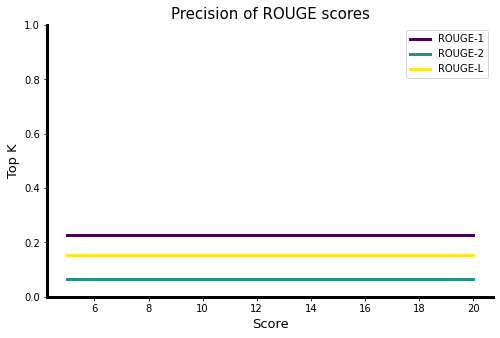

In [39]:
import matplotlib.pyplot as plt

ax = precision_df.plot(x='Temperature', cmap='viridis', figsize=(8, 5), lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.set_ylim(0, 1)

plt.title('Precision of ROUGE scores', fontsize=15)

plt.ylabel('Top K', fontsize=13)
plt.xlabel('Score', fontsize=13)

plt.show()

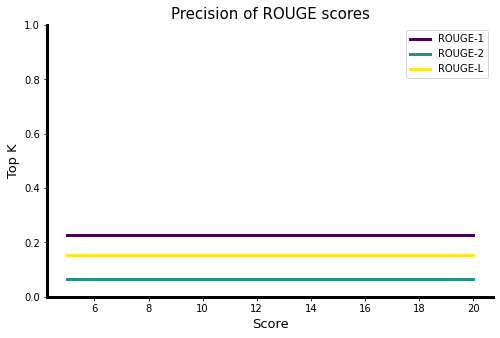

In [40]:
import matplotlib.pyplot as plt

ax = precision_df.plot(x='Temperature', cmap='viridis', figsize=(8, 5), lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.set_ylim(0, 1)

plt.title('Precision of ROUGE scores', fontsize=15)

plt.ylabel('Top K', fontsize=13)
plt.xlabel('Score', fontsize=13)

plt.show()

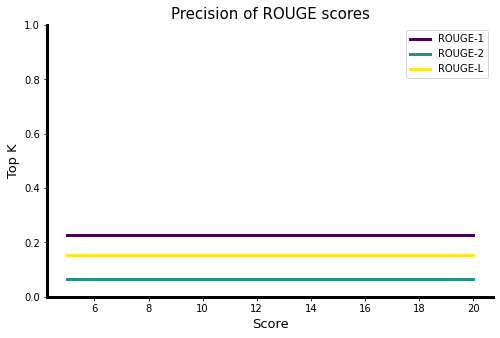

In [41]:
import matplotlib.pyplot as plt

ax = precision_df.plot(x='Temperature', cmap='viridis', figsize=(8, 5), lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.set_ylim(0, 1)

plt.title('Precision of ROUGE scores', fontsize=15)

plt.ylabel('Top K', fontsize=13)
plt.xlabel('Score', fontsize=13)

plt.show()

### Experiment: Temperature Sensitivity of ROUGE

In [42]:
rouge = datasets.load_metric('rouge')
actual = df_temp_sense['Actual Answer'].tolist()
scores_per_temp = {}
temp_array = [0.25, 0.50, 0.75, 1.0, 1.25, 1.5, 1.75]
for temp in temp_array:
    generated = df_temp_sense[f'Generated Answer (temp={temp:.2f})'].tolist()
    scores = rouge.compute(
        predictions=generated,
        references=actual, 
        rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
        use_agregator=True,
        use_stemmer=False,)
    _ = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure],
    }, index=[ 'P', 'R', 'F'])
    
    scores_per_temp[f"Temperature ({str(temp)})"] = _

In [43]:
precision_data = []
recall_data = []
f1_data = []
for key, scores_df in scores_per_temp.items():
    temperature = float(key.replace("Temperature (", '').replace(")", ''))
    
    precisions = [temperature] + scores_df.loc['P'].tolist()
    precision_data.append(precisions)
    
    recalls = [temperature] + scores_df.loc['R'].tolist()
    recall_data.append(recalls)
    
    f1s = [temperature] + scores_df.loc['F'].tolist()
    f1_data.append(f1s)
    
cols = ['Temperature', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
precision_df = pd.DataFrame(data=precision_data, columns=cols)
recall_df = pd.DataFrame(data=recall_data, columns=cols)
f1_df = pd.DataFrame(data=f1_data, columns=cols)

precision_df

,Temperature,ROUGE-1,ROUGE-2,ROUGE-L
0,0.25,0.225535,0.065744,0.154533
1,0.50,0.225535,0.065744,0.154533
2,0.75,0.225535,0.065744,0.154533
3,1.00,0.225535,0.065744,0.154533
4,1.25,0.225535,0.065744,0.154533
5,1.50,0.225535,0.065744,0.154533
6,1.75,0.225535,0.065744,0.154533


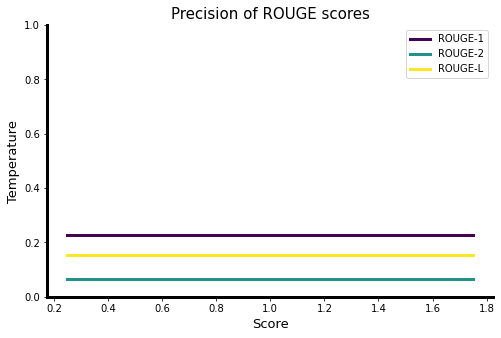

In [44]:
import matplotlib.pyplot as plt

ax = precision_df.plot(x='Temperature', cmap='viridis', figsize=(8, 5), lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.set_ylim(0, 1)

plt.title('Precision of ROUGE scores', fontsize=15)

plt.ylabel('Temperature', fontsize=13)
plt.xlabel('Score', fontsize=13)

plt.show()

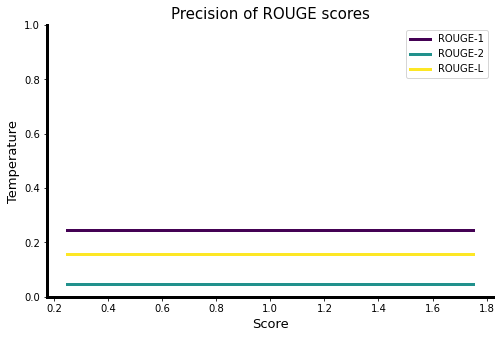

In [45]:
import matplotlib.pyplot as plt

ax = recall_df.plot(x='Temperature', cmap='viridis', figsize=(8, 5), lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.set_ylim(0, 1)

plt.title('Precision of ROUGE scores', fontsize=15)

plt.ylabel('Temperature', fontsize=13)
plt.xlabel('Score', fontsize=13)

plt.show()

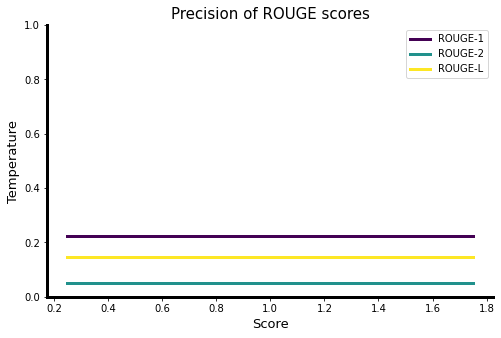

In [46]:
import matplotlib.pyplot as plt

ax = f1_df.plot(x='Temperature', cmap='viridis', figsize=(8, 5), lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.set_ylim(0, 1)

plt.title('Precision of ROUGE scores', fontsize=15)

plt.ylabel('Temperature', fontsize=13)
plt.xlabel('Score', fontsize=13)

plt.show()

## Addiction Recovery QA

In [47]:
# load addiction recovery dataset (general-conference, magazines combined)
source_dir = '../data/contexts/*'
files = glob(os.path.join(source_dir, '*.json'))

ar_snippets = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/1983 [00:00<?, ?it/s]

Using custom data configuration default-84fed7b4eaf12d59
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-84fed7b4eaf12d59/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
index_name = "context-index/ar-index.dat"
if not os.path.isfile(index_name): # avoids writing over the index
    make_qa_dense_index(
        retriever_model, retriever_tokenizer, ar_snippets['train'], device='cuda:0',
        index_name=index_name
    )

In [49]:
faiss_res = faiss.StandardGpuResources()
max_length = 128

# reading the embeddings into ram
ar_embeddings = np.memmap(
    index_name, 
    dtype='float32', mode='r',
    shape=(ar_snippets['train'].num_rows, max_length)
)

# create the gpu index
ar_index_flat = faiss.IndexFlatIP(max_length) # 128 fits in GPU
ar_gpu_index = faiss.index_cpu_to_gpu(provider=faiss_res, device=0, index=ar_index_flat)

# saving the embeddings into gpu index for faster retrieval time
ar_index_flat.add(ar_embeddings)

In [50]:
def may_i_ask(question, display_context=False):
    doc, res_list = query_qa_dense_index(
        question, 
        retriever_model, 
        retriever_tokenizer, 
        ar_snippets['train'], 
        ar_index_flat,
        10,
    )
    
    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, doc)
    
    # generate an answer with beam search, explore nucleus search
    generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]
    
    if display_context:
        print("Context snippets: \n\n", doc)
    
    return generated_answer

In [51]:
may_i_ask("How do I quit smoking?")

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


"Nicotine is a stimulant. It makes you feel good, so you want more of it. When you quit smoking, you no longer feel the urge to smoke, and you don't feel the need to smoke as much. This is why it's important to quit smoking when you feel like you need to, because you won't feel as good if you do."

In [66]:
may_i_ask("Why go to the temple?")

"I went to the temple because I wanted to learn more about the religion. The temple is a place where you can learn how to be a good person. It's a place for you to make a covenant with God to live a righteous life. You can make a lot of good decisions in the temple, but you can't make all of them in the real world."

In [64]:
may_i_ask("Why should I quit smoking?")

"Smoking is bad for you. It's bad for your health. It is also bad for society as a whole. If you smoke, you are contributing to the health problems of other people. You are also contributing to other people's health problems. Smoking is not good for you, but it's not as bad as it can be."

In [65]:
may_i_ask("What is love?")

"Love is the feeling of being in love with another person. It's the feeling that something is right about you and that you are worthy of being with that other person. There's a lot more to it than that, but that's the gist of it. If you want a more in-depth answer, try /r/askscience."

In [54]:
may_i_ask("How do I fix a car?")

"You can't fix a car. You need to buy a new car. The best way to do this is to take your car to a mechanic. They will be able to tell you exactly what is wrong with your car and what you need to do to fix it. If you have any other questions, feel free to ask."

In [55]:
may_i_ask("How do i repent?")

"You don't need to repent, you just need to acknowledge that you have sinned, and accept the consequences of your actions. It's the same as admitting that you committed a crime, and accepting the punishment for that crime. If you don't want to accept the punishment, don't commit the crime in the first place."

In [56]:
may_i_ask("Could the prospect of only future physical rewards even be bait for foolish dares of defiance now?")

'Depends on what you mean by “foolish dares of defiance now”. If you mean “dares of disobedience in the future”, then yes, it’s possible. However, I don’t think you’d get a lot of people to do it.'

In [57]:
may_i_ask("Why stop drinking?")

'Alcohol is a depressant. It lowers your inhibitions and makes it harder for you to control your emotions. It also makes you feel like you have no control over your life. When you stop drinking, you can control what you do and how much you do it. You can control how you feel and how you act.'

In [58]:
may_i_ask("Why is smoking marijuana wrong?")

"It's not inherently wrong, it's just not as socially acceptable as other forms of drug use. There are plenty of people who don't like the idea of smoking marijuana, but they're not going to go out of their way to tell you that it's bad for you. It's the same with alcohol, tobacco, and caffeine. They're not inherently bad, they're just not socially acceptable."

In [59]:
may_i_ask("How to stop smoking marijuana?")

"The best way to stop smoking marijuana is not to smoke it at all. It's a terrible habit to begin with, and it's very difficult to stop once you've started. If you have a problem with it, talk to a doctor about it, and get a prescription for a drug that will help you quit."

In [60]:
may_i_ask("What is faith?")

'Faith is the belief that something is true and that it will be true in the future. It is a belief that the future will be good or bad for you, and that you will be rewarded for your efforts. It can also be a belief in a higher power, such as God or the Holy Spirit, or it can just be a feeling of trust.'

In [61]:
may_i_ask("What is an electron?", display_context=True)

Context snippets: 

 <P> and always do those things that please Him and the Father, then we will come to know and understand all things: “And if your eye be single to my glory, your whole bodies shall be filled with light, and there shall be no darkness in you; and that body which is filled with light comprehendeth all things” (D&C 88:67). “That which is of God is light; and he that receiveth light, and continueth in God, receiveth more light; and that light groweth brighter and brighter until the perfect day” (D&C 50:24). “He that keepeth [God’s] commandments receiveth truth and light, <P> Lehi said, “All things must needs be a compound in one; ... no life neither death, nor corruption nor incorruption, happiness nor misery, neither sense nor insensibility” (2 Nephi 2:11). He further explained that for these opposites or alternatives to exist, there must be law. Law provides us the options. It is by the operation of laws that things happen. By using or obeying a law, one can bring abo

'An electron is a subatomic particle. It is the smallest particle in the periodic table. The periodic table is a collection of all the elementary particles that make up the universe. The electron is one of the smallest particles in this collection. It can be thought of as the smallest thing in the universe, but it is still a particle.'

In [62]:
may_i_ask("Why is partaking the sacrament important?")

'It’s a way to acknowledge that you’ve made a covenant with God to live a righteous life. If you don’t do it, you forfeit that covenant. The sacrament is a way of saying, “I’m willing to accept your covenant, but I’d like you to do something about it.”'

In [63]:
may_i_ask("How do I get rid of my addiction?")

"You don't have to get rid of your addiction. You just have to find something else to do with your life that doesn't make you feel like you need to be addicted. It's not a choice, it's just a fact of life. If you don't want to do it, don't do it."